In [1]:
import os, os.path
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf_device='/gpu:0'
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()
from collections import deque
import itertools
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from libs.utils import *
from libs.generate_boxes import *
from libs.dqn import *

num_episode = 60000
global_step = 0
tr_l, h_fill, tr_r,avg_loss_l,history_eps,used_boxes_eps  = [],[],[],[],[],[]
N_MDD = 8
K = 1
n_candidates = 5

num_max_boxes = N_MDD #+3
num_max_remain = num_max_boxes - K
print('num_max_boxes',num_max_boxes,'num_max_remain',num_max_remain)
env=Bpp3DEnv()
agent = DQNAgent( L=20, B=20, H=20, n_remains = num_max_remain, n_loading=K, 
                 lr=1e-4, exp_steps=19000, train_st = 1500, memory_len=2500, update_target_rate = 1000,
                net = 'DDQN_CNNDNN')

num_max_boxes 8 num_max_remain 7
distribution DDQN_CNNDNN


In [2]:
for e in range(num_episode):
    st=time.time()
    
    if num_episode>40000 and agent.epsilon <= 0.01:
        agent.epsilon = 0
    
    boxes_multi,gt_pos = generation_3dbox_random(case_size=[[20,20,20]], min_s = 1, N_mdd=N_MDD)#, is_prediv='h')
    
    env.reset()# env 초기화
    done = False
    step = 0
    history, h_load, h_remain_size, h_load_size = [],[],[],[]
    t_history, t_load, t_remain_size, t_load_size = [],[],[],[]
    used_boxes, pred_pos = [],[]
    
    #boxes_all = np.array(boxes_multi)[e%100].copy()
    boxes_all = np.array(boxes_multi)[0].copy()
    r_boxes = boxes_all.copy() #single case
    
    if agent.epsilon > agent.epsilon_end and len(agent.memory)>=agent.train_start:
        agent.epsilon -= agent.epsilon_decay_step

    while not done:#중박스에 대해 반복##############
        state = env.container_s.copy()
        state_h = env.container_h.copy()
        global_step += 1
        step += 1
        k = min(K, len(r_boxes))
        selected = cbn_select_boxes(r_boxes[:n_candidates], k) #r_boxes의 앞에서부터 n_candidates 만큼의 상자 중 k개의 중박스 선택 
        #selected = r_boxes.reshape((-1,1,3))
        s_order = get_selected_order(selected, k)
        
        num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, state, state_h, env.height)
        in_state, in_r_boxes, in_loading = raw2input(state_h, len(num_loaded_c), r_boxes, num_max_remain, K, loading_size_c, env.height) # input 변환 
        
        # action 선택 수가 1일 때 action 스킵
        if len(num_loaded_c) == 1:
            action_idx = 0
        else: # 선택 가능
            # action 실행
            action_idx = agent.get_action(in_state, np.array(loaded_mh_c), in_r_boxes, in_loading)
        
        # 다음 step ########################
        # env의 다음 state
        env.step(next_state_c[action_idx], next_h_c[action_idx]) 
        # r_boxes 업데이트
        num_loaded_box = num_loaded_c[action_idx]
        if num_loaded_box != 0: # 적입된 박스가 하나 이상 있는 경우 -> append
            new_used_boxes = loading_size_c[action_idx] # 기존 적재 박스, 기존 + 새 박스 -> 새로 적재된 박스 
            r_boxes = get_remain(new_used_boxes, r_boxes) # 남은 박스 업데이트 = 남은 박스 - 새로 적재 박스
            # 사용된 박스, 위치 업데이트
            used_boxes = used_boxes + loading_size_c[action_idx] #사용된 박스 업데이트
            pred_pos = pred_pos + loading_pos_c[action_idx] #예측된 위치 업데이트  
        else: # 적입된 박스가 없을 경우 - action = zero, state=t_state, 해당 박스들 모두 스킵
            r_boxes = get_remain(s_order[action_idx], r_boxes) # 남은 박스 업데이트 = 남은 박스 - 선택된 박스
        if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0: # 더 이상 적입할 적입할 수 없는 경우(박스 다 사용 or 다 채워짐)
            done = True
        
        # action 선택 수가 1 이상이고 마지막 박스가 적입되었을 때 append 
        if len(num_loaded_c) != 1 or done:
            # (s, a) append ########################
            history.append(in_state[action_idx]) # 적재 전 상태
            h_load.append(loaded_mh_c[action_idx]) # 적재된 상태
            h_remain_size.append(in_r_boxes[action_idx]) # 선택 후 전처리된 남은 박스 사이즈
            h_load_size.append(in_loading[action_idx]) # 적재된 박스 사이즈

            # (s') append ########################
            t_state = next_state_c[action_idx].copy() # 다음 state 
            t_state_h = next_h_c[action_idx].copy() 
            if done: #마지막 박스까지 채워졌을 경우 or 더 이상 적입할 수 없을 경우
                in_t_history = t_state_h.reshape((1, env.length, env.breadth, 1))
                loaded_mh_c = np.zeros((1, env.length, env.breadth, 2)) #(N, L, B, 2)
                in_t_remains = np.zeros((1, env.length, env.breadth, num_max_remain))
                in_t_loading = np.zeros((1, env.length, env.breadth, K))
            else:
                k = min(K, len(r_boxes))
                selected = cbn_select_boxes(r_boxes[:n_candidates], k) # 업데이트된 남은 박스들 중 중박스 선택
                #selected = r_boxes.reshape((-1,1,3))
                s_order = get_selected_order(selected, k) # 정렬 선택
                num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, t_state, t_state_h, env.height)
                in_t_history, in_t_remains, in_t_loading = \
                    raw2input(t_state_h, len(num_loaded_c), r_boxes, num_max_remain,  K, loading_size_c, env.height)
                
            t_history.append(in_t_history) # 적재 전 상태
            t_load.append(np.array(loaded_mh_c)) # 적재된 상태
            t_remain_size.append(in_t_remains) # 선택 후 전처리된 남은 박스 사이즈
            t_load_size.append(in_t_loading) # 적재된 박스 사이즈
                
        
        # terminal reward 계산 -> replay memory에 추가 
        if done:
            # terminal reward 
            avg_tr = 0 if len(tr_r)==0 else np.mean(tr_r)
            terminal_reward = (env.terminal_reward())**3 # - avg_tr
            tr_l.append(terminal_reward)
            h_fill.append(env.terminal_reward())
            if agent.epsilon >= 0.7: tr_r.append(env.terminal_reward())
            
            a_repeate = 1#6 if env.terminal_reward() ==1.0 else 1
            # append samples
            is_last = False 
            N = len(history)
            for i in range(N):
                if i == N-1: is_last=True
                reward=(0.99**(N-i-1))*terminal_reward #step reward
                for a in range(a_repeate):
                    agent.append_sample(history[i], h_load[i], h_remain_size[i], h_load_size[i], reward, is_last,
                                        t_history[i], t_load[i], t_remain_size[i], t_load_size[i])
            if global_step > agent.train_start:
                agent.draw_tensorboard(terminal_reward, env.terminal_reward(), step, e)
        # 학습 시작
        if len(agent.memory) >= agent.train_start:
            agent.train_model()
            if global_step % agent.update_target_rate == 0: # target model 업데이트
                agent.update_target_model()
            avg_loss_l.append(agent.avg_loss/float(step))
    
    
    #if global_step > agent.train_start:
    #    agent.draw_tensorboard(score, step, e)
    log = "=====episode: {:5d} | ".format(e)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "epsilon: {:.3f} | ".format(agent.epsilon)
    log += "reward(): {:.3f}, {:.3f}| ".format(env.terminal_reward(), terminal_reward)
    #log += "t_reward: {:.3f} | ".format(t_reward)
    #log += "q avg : {:3.2f} | ".format(agent.avg_q_max / float(step))
    log += "avg loss : {:6f} ".format(agent.avg_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    agent.avg_q_max, agent.avg_loss = 0, 0
    
    #used_boxes_eps.append(used_boxes)
    #history_eps.append(history)
    # 1000 에피소드마다 모델 저장
    if e % 1000 == 0:
        agent.model.save_weights("save_model/model", save_format="tf")
    
#print('total training time', time.time()-st)

=====episode:     0 | memory length:     8 | epsilon: 1.000 | reward(): 0.480, 0.111| avg loss : 0.000000 time: 0.041
=====episode:     1 | memory length:    13 | epsilon: 1.000 | reward(): 0.373, 0.052| avg loss : 0.000000 time: 0.034
=====episode:     2 | memory length:    18 | epsilon: 1.000 | reward(): 0.490, 0.118| avg loss : 0.000000 time: 0.030
=====episode:     3 | memory length:    26 | epsilon: 1.000 | reward(): 0.775, 0.465| avg loss : 0.000000 time: 0.041
=====episode:     4 | memory length:    34 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.041
=====episode:     5 | memory length:    42 | epsilon: 1.000 | reward(): 0.980, 0.941| avg loss : 0.000000 time: 0.034
=====episode:     6 | memory length:    47 | epsilon: 1.000 | reward(): 0.910, 0.754| avg loss : 0.000000 time: 0.033
=====episode:     7 | memory length:    55 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.044
=====episode:     8 | memory length:    63 | epsilon: 1.

=====episode:    75 | memory length:   564 | epsilon: 1.000 | reward(): 0.573, 0.188| avg loss : 0.000000 time: 0.049
=====episode:    76 | memory length:   570 | epsilon: 1.000 | reward(): 0.890, 0.705| avg loss : 0.000000 time: 0.031
=====episode:    77 | memory length:   577 | epsilon: 1.000 | reward(): 0.412, 0.070| avg loss : 0.000000 time: 0.034
=====episode:    78 | memory length:   579 | epsilon: 1.000 | reward(): 0.901, 0.733| avg loss : 0.000000 time: 0.014
=====episode:    79 | memory length:   587 | epsilon: 1.000 | reward(): 0.350, 0.043| avg loss : 0.000000 time: 0.046
=====episode:    80 | memory length:   595 | epsilon: 1.000 | reward(): 0.400, 0.064| avg loss : 0.000000 time: 0.044
=====episode:    81 | memory length:   603 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.040
=====episode:    82 | memory length:   611 | epsilon: 1.000 | reward(): 0.580, 0.195| avg loss : 0.000000 time: 0.040
=====episode:    83 | memory length:   619 | epsilon: 1.

=====episode:   149 | memory length:  1113 | epsilon: 1.000 | reward(): 0.150, 0.003| avg loss : 0.000000 time: 0.059
=====episode:   150 | memory length:  1121 | epsilon: 1.000 | reward(): 0.805, 0.522| avg loss : 0.000000 time: 0.040
=====episode:   151 | memory length:  1129 | epsilon: 1.000 | reward(): 0.505, 0.129| avg loss : 0.000000 time: 0.035
=====episode:   152 | memory length:  1137 | epsilon: 1.000 | reward(): 0.800, 0.512| avg loss : 0.000000 time: 0.039
=====episode:   153 | memory length:  1145 | epsilon: 1.000 | reward(): 1.000, 1.000| avg loss : 0.000000 time: 0.044
=====episode:   154 | memory length:  1153 | epsilon: 1.000 | reward(): 0.970, 0.913| avg loss : 0.000000 time: 0.036
=====episode:   155 | memory length:  1161 | epsilon: 1.000 | reward(): 0.450, 0.091| avg loss : 0.000000 time: 0.034
=====episode:   156 | memory length:  1169 | epsilon: 1.000 | reward(): 0.560, 0.176| avg loss : 0.000000 time: 0.046
=====episode:   157 | memory length:  1177 | epsilon: 1.

=====episode:   207 | memory length:  1538 | epsilon: 1.000 | reward(): 0.975, 0.927| avg loss : 3.927872 time: 8.726
=====episode:   208 | memory length:  1542 | epsilon: 1.000 | reward(): 0.403, 0.065| avg loss : 3.929835 time: 8.621
=====episode:   209 | memory length:  1549 | epsilon: 1.000 | reward(): 0.680, 0.314| avg loss : 3.927192 time: 4.762
=====episode:   210 | memory length:  1557 | epsilon: 1.000 | reward(): 0.730, 0.389| avg loss : 3.925202 time: 12.990
=====episode:   211 | memory length:  1562 | epsilon: 1.000 | reward(): 0.847, 0.608| avg loss : 3.922488 time: 4.668
=====episode:   212 | memory length:  1568 | epsilon: 0.999 | reward(): 0.317, 0.032| avg loss : 3.921593 time: 0.387
=====episode:   213 | memory length:  1576 | epsilon: 0.999 | reward(): 0.237, 0.013| avg loss : 3.921145 time: 0.578
=====episode:   214 | memory length:  1582 | epsilon: 0.999 | reward(): 0.949, 0.855| avg loss : 3.923477 time: 8.690
=====episode:   215 | memory length:  1587 | epsilon: 0

=====episode:   277 | memory length:  2035 | epsilon: 0.996 | reward(): 0.880, 0.681| avg loss : 3.835386 time: 0.572
=====episode:   278 | memory length:  2043 | epsilon: 0.996 | reward(): 0.400, 0.064| avg loss : 3.790129 time: 0.588
=====episode:   279 | memory length:  2051 | epsilon: 0.996 | reward(): 0.790, 0.493| avg loss : 3.852440 time: 0.557
=====episode:   280 | memory length:  2059 | epsilon: 0.996 | reward(): 0.650, 0.275| avg loss : 3.834367 time: 0.553
=====episode:   281 | memory length:  2066 | epsilon: 0.996 | reward(): 0.995, 0.985| avg loss : 3.856812 time: 0.504
=====episode:   282 | memory length:  2074 | epsilon: 0.996 | reward(): 0.400, 0.064| avg loss : 3.820746 time: 0.567
=====episode:   283 | memory length:  2080 | epsilon: 0.996 | reward(): 0.902, 0.734| avg loss : 3.819930 time: 0.407
=====episode:   284 | memory length:  2088 | epsilon: 0.996 | reward(): 0.800, 0.512| avg loss : 3.877179 time: 0.603
=====episode:   285 | memory length:  2096 | epsilon: 0.

=====episode:   347 | memory length:  2500 | epsilon: 0.992 | reward(): 0.680, 0.314| avg loss : 3.847672 time: 0.559
=====episode:   348 | memory length:  2500 | epsilon: 0.992 | reward(): 0.964, 0.897| avg loss : 3.832950 time: 0.402
=====episode:   349 | memory length:  2500 | epsilon: 0.992 | reward(): 0.450, 0.091| avg loss : 3.816612 time: 0.553
=====episode:   350 | memory length:  2500 | epsilon: 0.992 | reward(): 0.870, 0.659| avg loss : 3.781358 time: 0.546
=====episode:   351 | memory length:  2500 | epsilon: 0.992 | reward(): 0.549, 0.166| avg loss : 3.745373 time: 0.520
=====episode:   352 | memory length:  2500 | epsilon: 0.992 | reward(): 0.724, 0.379| avg loss : 3.812007 time: 0.577
=====episode:   353 | memory length:  2500 | epsilon: 0.992 | reward(): 0.700, 0.343| avg loss : 3.835990 time: 0.521
=====episode:   354 | memory length:  2500 | epsilon: 0.992 | reward(): 0.920, 0.779| avg loss : 3.798555 time: 0.477
=====episode:   355 | memory length:  2500 | epsilon: 0.

=====episode:   417 | memory length:  2500 | epsilon: 0.989 | reward(): 1.000, 1.000| avg loss : 3.713863 time: 0.530
=====episode:   418 | memory length:  2500 | epsilon: 0.989 | reward(): 0.450, 0.091| avg loss : 3.705563 time: 0.589
=====episode:   419 | memory length:  2500 | epsilon: 0.989 | reward(): 0.965, 0.899| avg loss : 3.718116 time: 0.540
=====episode:   420 | memory length:  2500 | epsilon: 0.989 | reward(): 0.843, 0.598| avg loss : 3.674011 time: 0.524
=====episode:   421 | memory length:  2500 | epsilon: 0.989 | reward(): 1.000, 1.000| avg loss : 3.715458 time: 0.552
=====episode:   422 | memory length:  2500 | epsilon: 0.989 | reward(): 0.782, 0.479| avg loss : 3.706145 time: 0.558
=====episode:   423 | memory length:  2500 | epsilon: 0.988 | reward(): 1.000, 1.000| avg loss : 3.619673 time: 0.566
=====episode:   424 | memory length:  2500 | epsilon: 0.988 | reward(): 0.287, 0.024| avg loss : 3.696922 time: 0.585
=====episode:   425 | memory length:  2500 | epsilon: 0.

=====episode:   487 | memory length:  2500 | epsilon: 0.985 | reward(): 0.610, 0.227| avg loss : 3.773185 time: 0.551
=====episode:   488 | memory length:  2500 | epsilon: 0.985 | reward(): 0.950, 0.857| avg loss : 3.657083 time: 0.564
=====episode:   489 | memory length:  2500 | epsilon: 0.985 | reward(): 0.917, 0.772| avg loss : 3.679062 time: 0.548
=====episode:   490 | memory length:  2500 | epsilon: 0.985 | reward(): 0.400, 0.064| avg loss : 3.628814 time: 0.525
=====episode:   491 | memory length:  2500 | epsilon: 0.985 | reward(): 0.750, 0.422| avg loss : 3.631065 time: 0.549
=====episode:   492 | memory length:  2500 | epsilon: 0.985 | reward(): 0.993, 0.978| avg loss : 3.716020 time: 0.575
=====episode:   493 | memory length:  2500 | epsilon: 0.985 | reward(): 0.985, 0.956| avg loss : 3.721692 time: 0.359
=====episode:   494 | memory length:  2500 | epsilon: 0.985 | reward(): 0.960, 0.885| avg loss : 3.688959 time: 0.559
=====episode:   495 | memory length:  2500 | epsilon: 0.

=====episode:   557 | memory length:  2500 | epsilon: 0.982 | reward(): 0.998, 0.993| avg loss : 3.597184 time: 0.575
=====episode:   558 | memory length:  2500 | epsilon: 0.981 | reward(): 0.995, 0.985| avg loss : 3.502305 time: 0.454
=====episode:   559 | memory length:  2500 | epsilon: 0.981 | reward(): 0.678, 0.312| avg loss : 3.532497 time: 0.541
=====episode:   560 | memory length:  2500 | epsilon: 0.981 | reward(): 0.898, 0.724| avg loss : 3.467931 time: 0.545
=====episode:   561 | memory length:  2500 | epsilon: 0.981 | reward(): 1.000, 1.000| avg loss : 3.527003 time: 0.560
=====episode:   562 | memory length:  2500 | epsilon: 0.981 | reward(): 0.963, 0.892| avg loss : 3.489115 time: 0.450
=====episode:   563 | memory length:  2500 | epsilon: 0.981 | reward(): 0.466, 0.101| avg loss : 3.586151 time: 0.542
=====episode:   564 | memory length:  2500 | epsilon: 0.981 | reward(): 0.650, 0.275| avg loss : 3.472112 time: 0.498
=====episode:   565 | memory length:  2500 | epsilon: 0.

=====episode:   627 | memory length:  2500 | epsilon: 0.978 | reward(): 0.787, 0.488| avg loss : 3.502613 time: 0.517
=====episode:   628 | memory length:  2500 | epsilon: 0.978 | reward(): 0.675, 0.308| avg loss : 3.653739 time: 0.617
=====episode:   629 | memory length:  2500 | epsilon: 0.978 | reward(): 0.973, 0.920| avg loss : 3.582180 time: 0.634
=====episode:   630 | memory length:  2500 | epsilon: 0.978 | reward(): 1.000, 1.000| avg loss : 3.524919 time: 0.529
=====episode:   631 | memory length:  2500 | epsilon: 0.978 | reward(): 0.800, 0.512| avg loss : 3.561073 time: 0.427
=====episode:   632 | memory length:  2500 | epsilon: 0.978 | reward(): 1.000, 1.000| avg loss : 3.630584 time: 0.565
=====episode:   633 | memory length:  2500 | epsilon: 0.978 | reward(): 0.786, 0.486| avg loss : 3.634463 time: 0.556
=====episode:   634 | memory length:  2500 | epsilon: 0.977 | reward(): 1.000, 1.000| avg loss : 3.505631 time: 0.540
=====episode:   635 | memory length:  2500 | epsilon: 0.

=====episode:   697 | memory length:  2500 | epsilon: 0.974 | reward(): 1.000, 1.000| avg loss : 3.498144 time: 0.552
=====episode:   698 | memory length:  2500 | epsilon: 0.974 | reward(): 0.671, 0.302| avg loss : 3.510308 time: 0.569
=====episode:   699 | memory length:  2500 | epsilon: 0.974 | reward(): 0.750, 0.422| avg loss : 3.461810 time: 0.558
=====episode:   700 | memory length:  2500 | epsilon: 0.974 | reward(): 0.930, 0.804| avg loss : 3.395895 time: 0.546
=====episode:   701 | memory length:  2500 | epsilon: 0.974 | reward(): 0.619, 0.238| avg loss : 3.468603 time: 0.377
=====episode:   702 | memory length:  2500 | epsilon: 0.974 | reward(): 0.948, 0.851| avg loss : 3.485955 time: 0.337
=====episode:   703 | memory length:  2500 | epsilon: 0.974 | reward(): 0.920, 0.779| avg loss : 3.480649 time: 0.591
=====episode:   704 | memory length:  2500 | epsilon: 0.974 | reward(): 0.618, 0.235| avg loss : 3.562830 time: 0.574
=====episode:   705 | memory length:  2500 | epsilon: 0.

=====episode:   767 | memory length:  2500 | epsilon: 0.971 | reward(): 0.986, 0.959| avg loss : 3.479190 time: 0.370
=====episode:   768 | memory length:  2500 | epsilon: 0.971 | reward(): 0.780, 0.475| avg loss : 3.521616 time: 0.561
=====episode:   769 | memory length:  2500 | epsilon: 0.970 | reward(): 0.725, 0.381| avg loss : 3.570346 time: 0.594
=====episode:   770 | memory length:  2500 | epsilon: 0.970 | reward(): 0.865, 0.647| avg loss : 3.495897 time: 0.486
=====episode:   771 | memory length:  2500 | epsilon: 0.970 | reward(): 1.000, 1.000| avg loss : 3.436492 time: 0.578
=====episode:   772 | memory length:  2500 | epsilon: 0.970 | reward(): 0.580, 0.195| avg loss : 3.372756 time: 0.533
=====episode:   773 | memory length:  2500 | epsilon: 0.970 | reward(): 0.200, 0.008| avg loss : 3.502450 time: 0.546
=====episode:   774 | memory length:  2500 | epsilon: 0.970 | reward(): 1.000, 1.000| avg loss : 3.462575 time: 0.561
=====episode:   775 | memory length:  2500 | epsilon: 0.

=====episode:   837 | memory length:  2500 | epsilon: 0.967 | reward(): 0.985, 0.956| avg loss : 3.330446 time: 0.548
=====episode:   838 | memory length:  2500 | epsilon: 0.967 | reward(): 0.360, 0.047| avg loss : 3.414554 time: 0.535
=====episode:   839 | memory length:  2500 | epsilon: 0.967 | reward(): 0.861, 0.637| avg loss : 3.172394 time: 0.410
=====episode:   840 | memory length:  2500 | epsilon: 0.967 | reward(): 0.738, 0.401| avg loss : 3.278732 time: 0.542
=====episode:   841 | memory length:  2500 | epsilon: 0.967 | reward(): 0.600, 0.216| avg loss : 3.381047 time: 0.559
=====episode:   842 | memory length:  2500 | epsilon: 0.967 | reward(): 1.000, 1.000| avg loss : 3.336477 time: 0.584
=====episode:   843 | memory length:  2500 | epsilon: 0.967 | reward(): 0.300, 0.027| avg loss : 3.454833 time: 0.572
=====episode:   844 | memory length:  2500 | epsilon: 0.967 | reward(): 0.942, 0.836| avg loss : 3.251487 time: 0.554
=====episode:   845 | memory length:  2500 | epsilon: 0.

=====episode:   907 | memory length:  2500 | epsilon: 0.963 | reward(): 0.400, 0.064| avg loss : 3.327135 time: 0.573
=====episode:   908 | memory length:  2500 | epsilon: 0.963 | reward(): 0.790, 0.493| avg loss : 3.302643 time: 0.551
=====episode:   909 | memory length:  2500 | epsilon: 0.963 | reward(): 0.750, 0.422| avg loss : 3.294705 time: 0.544
=====episode:   910 | memory length:  2500 | epsilon: 0.963 | reward(): 1.000, 1.000| avg loss : 3.318429 time: 0.548
=====episode:   911 | memory length:  2500 | epsilon: 0.963 | reward(): 0.412, 0.070| avg loss : 3.317238 time: 0.420
=====episode:   912 | memory length:  2500 | epsilon: 0.963 | reward(): 0.853, 0.620| avg loss : 3.291420 time: 0.565
=====episode:   913 | memory length:  2500 | epsilon: 0.963 | reward(): 0.190, 0.007| avg loss : 3.390735 time: 0.559
=====episode:   914 | memory length:  2500 | epsilon: 0.963 | reward(): 1.000, 1.000| avg loss : 3.334974 time: 0.583
=====episode:   915 | memory length:  2500 | epsilon: 0.

=====episode:   977 | memory length:  2500 | epsilon: 0.960 | reward(): 0.800, 0.512| avg loss : 3.147195 time: 0.539
=====episode:   978 | memory length:  2500 | epsilon: 0.960 | reward(): 1.000, 1.000| avg loss : 3.377429 time: 0.593
=====episode:   979 | memory length:  2500 | epsilon: 0.960 | reward(): 0.900, 0.729| avg loss : 3.175918 time: 0.592
=====episode:   980 | memory length:  2500 | epsilon: 0.959 | reward(): 0.930, 0.804| avg loss : 3.211429 time: 0.577
=====episode:   981 | memory length:  2500 | epsilon: 0.959 | reward(): 0.883, 0.689| avg loss : 3.225236 time: 0.266
=====episode:   982 | memory length:  2500 | epsilon: 0.959 | reward(): 0.500, 0.125| avg loss : 3.184057 time: 0.545
=====episode:   983 | memory length:  2500 | epsilon: 0.959 | reward(): 0.550, 0.166| avg loss : 3.298733 time: 0.561
=====episode:   984 | memory length:  2500 | epsilon: 0.959 | reward(): 0.738, 0.401| avg loss : 3.238569 time: 0.554
=====episode:   985 | memory length:  2500 | epsilon: 0.

=====episode:  1047 | memory length:  2500 | epsilon: 0.956 | reward(): 0.960, 0.885| avg loss : 3.201471 time: 0.460
=====episode:  1048 | memory length:  2500 | epsilon: 0.956 | reward(): 0.598, 0.213| avg loss : 3.254069 time: 0.438
=====episode:  1049 | memory length:  2500 | epsilon: 0.956 | reward(): 0.511, 0.133| avg loss : 3.227066 time: 0.529
=====episode:  1050 | memory length:  2500 | epsilon: 0.956 | reward(): 0.300, 0.027| avg loss : 3.274489 time: 0.545
=====episode:  1051 | memory length:  2500 | epsilon: 0.956 | reward(): 0.550, 0.166| avg loss : 3.232117 time: 0.519
=====episode:  1052 | memory length:  2500 | epsilon: 0.956 | reward(): 0.833, 0.577| avg loss : 3.223431 time: 0.282
=====episode:  1053 | memory length:  2500 | epsilon: 0.956 | reward(): 0.477, 0.109| avg loss : 3.233891 time: 0.558
=====episode:  1054 | memory length:  2500 | epsilon: 0.956 | reward(): 0.843, 0.598| avg loss : 3.070950 time: 0.482
=====episode:  1055 | memory length:  2500 | epsilon: 0.

=====episode:  1117 | memory length:  2500 | epsilon: 0.952 | reward(): 0.865, 0.647| avg loss : 3.227770 time: 0.591
=====episode:  1118 | memory length:  2500 | epsilon: 0.952 | reward(): 0.560, 0.176| avg loss : 3.216844 time: 0.570
=====episode:  1119 | memory length:  2500 | epsilon: 0.952 | reward(): 0.990, 0.970| avg loss : 3.211839 time: 0.548
=====episode:  1120 | memory length:  2500 | epsilon: 0.952 | reward(): 0.900, 0.729| avg loss : 3.229313 time: 0.546
=====episode:  1121 | memory length:  2500 | epsilon: 0.952 | reward(): 1.000, 1.000| avg loss : 3.188956 time: 0.594
=====episode:  1122 | memory length:  2500 | epsilon: 0.952 | reward(): 0.858, 0.631| avg loss : 3.192219 time: 0.585
=====episode:  1123 | memory length:  2500 | epsilon: 0.952 | reward(): 1.000, 1.000| avg loss : 3.106482 time: 0.562
=====episode:  1124 | memory length:  2500 | epsilon: 0.952 | reward(): 0.525, 0.145| avg loss : 3.198717 time: 0.541
=====episode:  1125 | memory length:  2500 | epsilon: 0.

=====episode:  1187 | memory length:  2500 | epsilon: 0.949 | reward(): 0.586, 0.201| avg loss : 3.086983 time: 0.570
=====episode:  1188 | memory length:  2500 | epsilon: 0.949 | reward(): 0.797, 0.506| avg loss : 3.102102 time: 0.535
=====episode:  1189 | memory length:  2500 | epsilon: 0.949 | reward(): 0.899, 0.726| avg loss : 3.162981 time: 0.608
=====episode:  1190 | memory length:  2500 | epsilon: 0.949 | reward(): 0.486, 0.115| avg loss : 3.167608 time: 0.552
=====episode:  1191 | memory length:  2500 | epsilon: 0.948 | reward(): 0.910, 0.753| avg loss : 3.227969 time: 0.422
=====episode:  1192 | memory length:  2500 | epsilon: 0.948 | reward(): 0.100, 0.001| avg loss : 3.153022 time: 0.552
=====episode:  1193 | memory length:  2500 | epsilon: 0.948 | reward(): 0.614, 0.231| avg loss : 3.270273 time: 0.220
=====episode:  1194 | memory length:  2500 | epsilon: 0.948 | reward(): 0.300, 0.027| avg loss : 3.239807 time: 0.566
=====episode:  1195 | memory length:  2500 | epsilon: 0.

=====episode:  1257 | memory length:  2500 | epsilon: 0.945 | reward(): 0.740, 0.405| avg loss : 3.220920 time: 0.546
=====episode:  1258 | memory length:  2500 | epsilon: 0.945 | reward(): 0.400, 0.064| avg loss : 3.294785 time: 0.542
=====episode:  1259 | memory length:  2500 | epsilon: 0.945 | reward(): 0.720, 0.373| avg loss : 3.197121 time: 0.580
=====episode:  1260 | memory length:  2500 | epsilon: 0.945 | reward(): 0.250, 0.016| avg loss : 3.204534 time: 0.529
=====episode:  1261 | memory length:  2500 | epsilon: 0.945 | reward(): 0.362, 0.048| avg loss : 3.130044 time: 0.566
=====episode:  1262 | memory length:  2500 | epsilon: 0.945 | reward(): 0.325, 0.034| avg loss : 3.152717 time: 0.538
=====episode:  1263 | memory length:  2500 | epsilon: 0.945 | reward(): 0.695, 0.336| avg loss : 3.184554 time: 0.517
=====episode:  1264 | memory length:  2500 | epsilon: 0.945 | reward(): 0.100, 0.001| avg loss : 3.188302 time: 0.553
=====episode:  1265 | memory length:  2500 | epsilon: 0.

=====episode:  1327 | memory length:  2500 | epsilon: 0.941 | reward(): 0.885, 0.693| avg loss : 3.093953 time: 0.409
=====episode:  1328 | memory length:  2500 | epsilon: 0.941 | reward(): 1.000, 1.000| avg loss : 3.279849 time: 0.592
=====episode:  1329 | memory length:  2500 | epsilon: 0.941 | reward(): 0.790, 0.493| avg loss : 3.160274 time: 0.433
=====episode:  1330 | memory length:  2500 | epsilon: 0.941 | reward(): 0.998, 0.995| avg loss : 3.125458 time: 0.501
=====episode:  1331 | memory length:  2500 | epsilon: 0.941 | reward(): 0.943, 0.838| avg loss : 3.144616 time: 0.483
=====episode:  1332 | memory length:  2500 | epsilon: 0.941 | reward(): 0.145, 0.003| avg loss : 3.214211 time: 0.553
=====episode:  1333 | memory length:  2500 | epsilon: 0.941 | reward(): 0.850, 0.614| avg loss : 3.139253 time: 0.575
=====episode:  1334 | memory length:  2500 | epsilon: 0.941 | reward(): 0.460, 0.097| avg loss : 3.209989 time: 0.606
=====episode:  1335 | memory length:  2500 | epsilon: 0.

=====episode:  1397 | memory length:  2500 | epsilon: 0.938 | reward(): 0.920, 0.779| avg loss : 3.121784 time: 0.584
=====episode:  1398 | memory length:  2500 | epsilon: 0.938 | reward(): 0.944, 0.841| avg loss : 3.238528 time: 0.428
=====episode:  1399 | memory length:  2500 | epsilon: 0.938 | reward(): 0.963, 0.892| avg loss : 3.214029 time: 0.560
=====episode:  1400 | memory length:  2500 | epsilon: 0.938 | reward(): 0.950, 0.857| avg loss : 2.968778 time: 0.546
=====episode:  1401 | memory length:  2500 | epsilon: 0.938 | reward(): 0.650, 0.275| avg loss : 3.153526 time: 0.581
=====episode:  1402 | memory length:  2500 | epsilon: 0.937 | reward(): 0.360, 0.047| avg loss : 3.168413 time: 0.487
=====episode:  1403 | memory length:  2500 | epsilon: 0.937 | reward(): 1.000, 1.000| avg loss : 3.114538 time: 0.584
=====episode:  1404 | memory length:  2500 | epsilon: 0.937 | reward(): 0.995, 0.985| avg loss : 3.176832 time: 0.611
=====episode:  1405 | memory length:  2500 | epsilon: 0.

=====episode:  1467 | memory length:  2500 | epsilon: 0.934 | reward(): 0.100, 0.001| avg loss : 3.042347 time: 0.582
=====episode:  1468 | memory length:  2500 | epsilon: 0.934 | reward(): 0.968, 0.906| avg loss : 3.085538 time: 0.435
=====episode:  1469 | memory length:  2500 | epsilon: 0.934 | reward(): 0.650, 0.275| avg loss : 3.127781 time: 0.552
=====episode:  1470 | memory length:  2500 | epsilon: 0.934 | reward(): 0.925, 0.791| avg loss : 3.042809 time: 0.582
=====episode:  1471 | memory length:  2500 | epsilon: 0.934 | reward(): 0.100, 0.001| avg loss : 3.166083 time: 0.564
=====episode:  1472 | memory length:  2500 | epsilon: 0.934 | reward(): 0.252, 0.016| avg loss : 3.110595 time: 0.570
=====episode:  1473 | memory length:  2500 | epsilon: 0.934 | reward(): 0.200, 0.008| avg loss : 3.108887 time: 0.566
=====episode:  1474 | memory length:  2500 | epsilon: 0.934 | reward(): 0.940, 0.831| avg loss : 3.101955 time: 0.489
=====episode:  1475 | memory length:  2500 | epsilon: 0.

=====episode:  1537 | memory length:  2500 | epsilon: 0.930 | reward(): 0.784, 0.482| avg loss : 3.076943 time: 0.545
=====episode:  1538 | memory length:  2500 | epsilon: 0.930 | reward(): 0.805, 0.522| avg loss : 3.210959 time: 0.603
=====episode:  1539 | memory length:  2500 | epsilon: 0.930 | reward(): 0.835, 0.582| avg loss : 3.162487 time: 0.569
=====episode:  1540 | memory length:  2500 | epsilon: 0.930 | reward(): 0.960, 0.885| avg loss : 3.064326 time: 0.562
=====episode:  1541 | memory length:  2500 | epsilon: 0.930 | reward(): 0.932, 0.810| avg loss : 3.156994 time: 0.537
=====episode:  1542 | memory length:  2500 | epsilon: 0.930 | reward(): 1.000, 1.000| avg loss : 3.025158 time: 0.557
=====episode:  1543 | memory length:  2500 | epsilon: 0.930 | reward(): 0.750, 0.422| avg loss : 3.109852 time: 0.600
=====episode:  1544 | memory length:  2500 | epsilon: 0.930 | reward(): 0.477, 0.109| avg loss : 3.137912 time: 0.601
=====episode:  1545 | memory length:  2500 | epsilon: 0.

=====episode:  1607 | memory length:  2500 | epsilon: 0.927 | reward(): 0.965, 0.899| avg loss : 3.174490 time: 0.544
=====episode:  1608 | memory length:  2500 | epsilon: 0.927 | reward(): 0.698, 0.339| avg loss : 3.194804 time: 0.488
=====episode:  1609 | memory length:  2500 | epsilon: 0.927 | reward(): 0.765, 0.449| avg loss : 3.082111 time: 0.442
=====episode:  1610 | memory length:  2500 | epsilon: 0.927 | reward(): 0.350, 0.043| avg loss : 3.186553 time: 0.554
=====episode:  1611 | memory length:  2500 | epsilon: 0.927 | reward(): 0.972, 0.917| avg loss : 3.101807 time: 0.509
=====episode:  1612 | memory length:  2500 | epsilon: 0.927 | reward(): 1.000, 1.000| avg loss : 3.164747 time: 0.560
=====episode:  1613 | memory length:  2500 | epsilon: 0.926 | reward(): 0.960, 0.885| avg loss : 3.179983 time: 0.542
=====episode:  1614 | memory length:  2500 | epsilon: 0.926 | reward(): 0.328, 0.035| avg loss : 3.067890 time: 0.555
=====episode:  1615 | memory length:  2500 | epsilon: 0.

=====episode:  1677 | memory length:  2500 | epsilon: 0.923 | reward(): 0.495, 0.121| avg loss : 3.106983 time: 0.537
=====episode:  1678 | memory length:  2500 | epsilon: 0.923 | reward(): 1.000, 1.000| avg loss : 3.166261 time: 0.549
=====episode:  1679 | memory length:  2500 | epsilon: 0.923 | reward(): 0.795, 0.502| avg loss : 3.236922 time: 0.430
=====episode:  1680 | memory length:  2500 | epsilon: 0.923 | reward(): 0.415, 0.071| avg loss : 3.085484 time: 0.548
=====episode:  1681 | memory length:  2500 | epsilon: 0.923 | reward(): 0.400, 0.064| avg loss : 3.143916 time: 0.599
=====episode:  1682 | memory length:  2500 | epsilon: 0.923 | reward(): 0.458, 0.096| avg loss : 3.204048 time: 0.319
=====episode:  1683 | memory length:  2500 | epsilon: 0.923 | reward(): 0.900, 0.729| avg loss : 3.141618 time: 0.663
=====episode:  1684 | memory length:  2500 | epsilon: 0.923 | reward(): 1.000, 0.999| avg loss : 3.248894 time: 0.511
=====episode:  1685 | memory length:  2500 | epsilon: 0.

=====episode:  1747 | memory length:  2500 | epsilon: 0.919 | reward(): 0.987, 0.960| avg loss : 2.979962 time: 0.533
=====episode:  1748 | memory length:  2500 | epsilon: 0.919 | reward(): 0.420, 0.074| avg loss : 3.193310 time: 0.564
=====episode:  1749 | memory length:  2500 | epsilon: 0.919 | reward(): 0.573, 0.188| avg loss : 3.149809 time: 0.582
=====episode:  1750 | memory length:  2500 | epsilon: 0.919 | reward(): 0.480, 0.111| avg loss : 3.118995 time: 0.572
=====episode:  1751 | memory length:  2500 | epsilon: 0.919 | reward(): 0.999, 0.997| avg loss : 3.141306 time: 0.520
=====episode:  1752 | memory length:  2500 | epsilon: 0.919 | reward(): 0.400, 0.064| avg loss : 3.063277 time: 0.582
=====episode:  1753 | memory length:  2500 | epsilon: 0.919 | reward(): 0.500, 0.125| avg loss : 3.107363 time: 0.560
=====episode:  1754 | memory length:  2500 | epsilon: 0.919 | reward(): 0.846, 0.604| avg loss : 3.142055 time: 0.517
=====episode:  1755 | memory length:  2500 | epsilon: 0.

=====episode:  1817 | memory length:  2500 | epsilon: 0.916 | reward(): 0.050, 0.000| avg loss : 3.143269 time: 0.561
=====episode:  1818 | memory length:  2500 | epsilon: 0.916 | reward(): 0.545, 0.162| avg loss : 3.141920 time: 0.569
=====episode:  1819 | memory length:  2500 | epsilon: 0.916 | reward(): 1.000, 1.000| avg loss : 3.091680 time: 0.537
=====episode:  1820 | memory length:  2500 | epsilon: 0.916 | reward(): 0.740, 0.405| avg loss : 3.172865 time: 0.538
=====episode:  1821 | memory length:  2500 | epsilon: 0.916 | reward(): 0.806, 0.525| avg loss : 3.197514 time: 0.553
=====episode:  1822 | memory length:  2500 | epsilon: 0.916 | reward(): 0.600, 0.216| avg loss : 3.093919 time: 0.586
=====episode:  1823 | memory length:  2500 | epsilon: 0.916 | reward(): 0.595, 0.211| avg loss : 3.167881 time: 0.561
=====episode:  1824 | memory length:  2500 | epsilon: 0.915 | reward(): 0.850, 0.614| avg loss : 3.149074 time: 0.547
=====episode:  1825 | memory length:  2500 | epsilon: 0.

=====episode:  1887 | memory length:  2500 | epsilon: 0.912 | reward(): 0.595, 0.211| avg loss : 3.054404 time: 0.548
=====episode:  1888 | memory length:  2500 | epsilon: 0.912 | reward(): 0.193, 0.007| avg loss : 3.110783 time: 0.597
=====episode:  1889 | memory length:  2500 | epsilon: 0.912 | reward(): 0.998, 0.994| avg loss : 3.075409 time: 0.450
=====episode:  1890 | memory length:  2500 | epsilon: 0.912 | reward(): 0.972, 0.918| avg loss : 3.132298 time: 0.573
=====episode:  1891 | memory length:  2500 | epsilon: 0.912 | reward(): 0.804, 0.520| avg loss : 3.136975 time: 0.564
=====episode:  1892 | memory length:  2500 | epsilon: 0.912 | reward(): 0.787, 0.487| avg loss : 3.115167 time: 0.548
=====episode:  1893 | memory length:  2500 | epsilon: 0.912 | reward(): 1.000, 1.000| avg loss : 3.096340 time: 0.602
=====episode:  1894 | memory length:  2500 | epsilon: 0.912 | reward(): 0.350, 0.043| avg loss : 3.059570 time: 0.551
=====episode:  1895 | memory length:  2500 | epsilon: 0.

=====episode:  1957 | memory length:  2500 | epsilon: 0.909 | reward(): 0.996, 0.987| avg loss : 3.060412 time: 0.569
=====episode:  1958 | memory length:  2500 | epsilon: 0.909 | reward(): 0.691, 0.330| avg loss : 3.067214 time: 0.309
=====episode:  1959 | memory length:  2500 | epsilon: 0.908 | reward(): 0.752, 0.425| avg loss : 2.946446 time: 0.323
=====episode:  1960 | memory length:  2500 | epsilon: 0.908 | reward(): 0.800, 0.512| avg loss : 3.101545 time: 0.585
=====episode:  1961 | memory length:  2500 | epsilon: 0.908 | reward(): 1.000, 1.000| avg loss : 3.149641 time: 0.536
=====episode:  1962 | memory length:  2500 | epsilon: 0.908 | reward(): 0.973, 0.920| avg loss : 2.978625 time: 0.520
=====episode:  1963 | memory length:  2500 | epsilon: 0.908 | reward(): 0.950, 0.857| avg loss : 2.974504 time: 0.606
=====episode:  1964 | memory length:  2500 | epsilon: 0.908 | reward(): 0.250, 0.016| avg loss : 3.053272 time: 0.564
=====episode:  1965 | memory length:  2500 | epsilon: 0.

=====episode:  2027 | memory length:  2500 | epsilon: 0.905 | reward(): 0.825, 0.562| avg loss : 3.092179 time: 0.561
=====episode:  2028 | memory length:  2500 | epsilon: 0.905 | reward(): 0.300, 0.027| avg loss : 3.024667 time: 0.568
=====episode:  2029 | memory length:  2500 | epsilon: 0.905 | reward(): 0.816, 0.544| avg loss : 3.077316 time: 0.540
=====episode:  2030 | memory length:  2500 | epsilon: 0.905 | reward(): 0.610, 0.227| avg loss : 3.069447 time: 0.567
=====episode:  2031 | memory length:  2500 | epsilon: 0.905 | reward(): 0.546, 0.163| avg loss : 3.157950 time: 0.551
=====episode:  2032 | memory length:  2500 | epsilon: 0.905 | reward(): 0.600, 0.216| avg loss : 3.052487 time: 0.557
=====episode:  2033 | memory length:  2500 | epsilon: 0.905 | reward(): 0.823, 0.558| avg loss : 3.129711 time: 0.429
=====episode:  2034 | memory length:  2500 | epsilon: 0.905 | reward(): 1.000, 1.000| avg loss : 3.056945 time: 0.554
=====episode:  2035 | memory length:  2500 | epsilon: 0.

=====episode:  2097 | memory length:  2500 | epsilon: 0.901 | reward(): 1.000, 1.000| avg loss : 3.111149 time: 0.549
=====episode:  2098 | memory length:  2500 | epsilon: 0.901 | reward(): 0.566, 0.181| avg loss : 3.055947 time: 0.537
=====episode:  2099 | memory length:  2500 | epsilon: 0.901 | reward(): 0.650, 0.275| avg loss : 3.135591 time: 0.561
=====episode:  2100 | memory length:  2500 | epsilon: 0.901 | reward(): 1.000, 1.000| avg loss : 3.036846 time: 0.578
=====episode:  2101 | memory length:  2500 | epsilon: 0.901 | reward(): 0.522, 0.142| avg loss : 3.051527 time: 0.559
=====episode:  2102 | memory length:  2500 | epsilon: 0.901 | reward(): 0.964, 0.896| avg loss : 3.140119 time: 0.555
=====episode:  2103 | memory length:  2500 | epsilon: 0.901 | reward(): 1.000, 1.000| avg loss : 3.043253 time: 0.524
=====episode:  2104 | memory length:  2500 | epsilon: 0.901 | reward(): 1.000, 1.000| avg loss : 3.020602 time: 0.564
=====episode:  2105 | memory length:  2500 | epsilon: 0.

=====episode:  2167 | memory length:  2500 | epsilon: 0.898 | reward(): 0.750, 0.422| avg loss : 3.090592 time: 0.570
=====episode:  2168 | memory length:  2500 | epsilon: 0.898 | reward(): 0.848, 0.610| avg loss : 3.007608 time: 0.595
=====episode:  2169 | memory length:  2500 | epsilon: 0.898 | reward(): 1.000, 1.000| avg loss : 3.001687 time: 0.577
=====episode:  2170 | memory length:  2500 | epsilon: 0.897 | reward(): 0.804, 0.520| avg loss : 3.043191 time: 0.573
=====episode:  2171 | memory length:  2500 | epsilon: 0.897 | reward(): 0.870, 0.659| avg loss : 3.111808 time: 0.337
=====episode:  2172 | memory length:  2500 | epsilon: 0.897 | reward(): 0.502, 0.127| avg loss : 3.073100 time: 0.552
=====episode:  2173 | memory length:  2500 | epsilon: 0.897 | reward(): 0.460, 0.097| avg loss : 3.055974 time: 0.563
=====episode:  2174 | memory length:  2500 | epsilon: 0.897 | reward(): 1.000, 1.000| avg loss : 3.062212 time: 0.592
=====episode:  2175 | memory length:  2500 | epsilon: 0.

=====episode:  2237 | memory length:  2500 | epsilon: 0.894 | reward(): 0.378, 0.054| avg loss : 3.029301 time: 0.567
=====episode:  2238 | memory length:  2500 | epsilon: 0.894 | reward(): 0.910, 0.754| avg loss : 3.025302 time: 0.585
=====episode:  2239 | memory length:  2500 | epsilon: 0.894 | reward(): 0.996, 0.987| avg loss : 3.108885 time: 0.513
=====episode:  2240 | memory length:  2500 | epsilon: 0.894 | reward(): 0.362, 0.048| avg loss : 3.057514 time: 0.562
=====episode:  2241 | memory length:  2500 | epsilon: 0.894 | reward(): 0.996, 0.988| avg loss : 3.188662 time: 0.449
=====episode:  2242 | memory length:  2500 | epsilon: 0.894 | reward(): 0.820, 0.551| avg loss : 3.074810 time: 0.585
=====episode:  2243 | memory length:  2500 | epsilon: 0.894 | reward(): 0.565, 0.180| avg loss : 3.115251 time: 0.592
=====episode:  2244 | memory length:  2500 | epsilon: 0.894 | reward(): 0.965, 0.899| avg loss : 3.056175 time: 0.559
=====episode:  2245 | memory length:  2500 | epsilon: 0.

=====episode:  2307 | memory length:  2500 | epsilon: 0.890 | reward(): 0.640, 0.262| avg loss : 3.077325 time: 0.548
=====episode:  2308 | memory length:  2500 | epsilon: 0.890 | reward(): 0.900, 0.729| avg loss : 3.040889 time: 0.603
=====episode:  2309 | memory length:  2500 | epsilon: 0.890 | reward(): 0.637, 0.259| avg loss : 3.127676 time: 0.605
=====episode:  2310 | memory length:  2500 | epsilon: 0.890 | reward(): 0.752, 0.426| avg loss : 3.125397 time: 0.581
=====episode:  2311 | memory length:  2500 | epsilon: 0.890 | reward(): 0.588, 0.204| avg loss : 3.086585 time: 0.552
=====episode:  2312 | memory length:  2500 | epsilon: 0.890 | reward(): 0.985, 0.956| avg loss : 3.060844 time: 0.565
=====episode:  2313 | memory length:  2500 | epsilon: 0.890 | reward(): 0.887, 0.699| avg loss : 3.065440 time: 0.574
=====episode:  2314 | memory length:  2500 | epsilon: 0.890 | reward(): 0.973, 0.921| avg loss : 3.078278 time: 0.406
=====episode:  2315 | memory length:  2500 | epsilon: 0.

=====episode:  2377 | memory length:  2500 | epsilon: 0.887 | reward(): 0.950, 0.857| avg loss : 3.135809 time: 0.577
=====episode:  2378 | memory length:  2500 | epsilon: 0.887 | reward(): 0.704, 0.349| avg loss : 3.175526 time: 0.581
=====episode:  2379 | memory length:  2500 | epsilon: 0.887 | reward(): 0.443, 0.087| avg loss : 3.099918 time: 0.585
=====episode:  2380 | memory length:  2500 | epsilon: 0.887 | reward(): 0.932, 0.811| avg loss : 3.086442 time: 0.555
=====episode:  2381 | memory length:  2500 | epsilon: 0.886 | reward(): 1.000, 1.000| avg loss : 3.082302 time: 0.580
=====episode:  2382 | memory length:  2500 | epsilon: 0.886 | reward(): 0.370, 0.051| avg loss : 3.049661 time: 0.564
=====episode:  2383 | memory length:  2500 | epsilon: 0.886 | reward(): 0.966, 0.902| avg loss : 3.079330 time: 0.500
=====episode:  2384 | memory length:  2500 | epsilon: 0.886 | reward(): 0.984, 0.953| avg loss : 3.035111 time: 0.589
=====episode:  2385 | memory length:  2500 | epsilon: 0.

=====episode:  2447 | memory length:  2500 | epsilon: 0.883 | reward(): 0.550, 0.166| avg loss : 2.994705 time: 0.549
=====episode:  2448 | memory length:  2500 | epsilon: 0.883 | reward(): 0.333, 0.037| avg loss : 3.095567 time: 0.522
=====episode:  2449 | memory length:  2500 | epsilon: 0.883 | reward(): 0.735, 0.397| avg loss : 3.113725 time: 0.321
=====episode:  2450 | memory length:  2500 | epsilon: 0.883 | reward(): 0.200, 0.008| avg loss : 3.144975 time: 0.597
=====episode:  2451 | memory length:  2500 | epsilon: 0.883 | reward(): 0.500, 0.125| avg loss : 3.094091 time: 0.572
=====episode:  2452 | memory length:  2500 | epsilon: 0.883 | reward(): 0.336, 0.038| avg loss : 3.047717 time: 0.580
=====episode:  2453 | memory length:  2500 | epsilon: 0.883 | reward(): 1.000, 1.000| avg loss : 3.045774 time: 0.576
=====episode:  2454 | memory length:  2500 | epsilon: 0.883 | reward(): 0.398, 0.063| avg loss : 3.148220 time: 0.535
=====episode:  2455 | memory length:  2500 | epsilon: 0.

=====episode:  2517 | memory length:  2500 | epsilon: 0.879 | reward(): 0.625, 0.244| avg loss : 3.142952 time: 0.539
=====episode:  2518 | memory length:  2500 | epsilon: 0.879 | reward(): 0.963, 0.892| avg loss : 3.108365 time: 0.545
=====episode:  2519 | memory length:  2500 | epsilon: 0.879 | reward(): 0.926, 0.795| avg loss : 3.146081 time: 0.476
=====episode:  2520 | memory length:  2500 | epsilon: 0.879 | reward(): 0.512, 0.135| avg loss : 3.037354 time: 0.591
=====episode:  2521 | memory length:  2500 | epsilon: 0.879 | reward(): 0.695, 0.336| avg loss : 3.099665 time: 0.567
=====episode:  2522 | memory length:  2500 | epsilon: 0.879 | reward(): 0.150, 0.003| avg loss : 3.029439 time: 0.603
=====episode:  2523 | memory length:  2500 | epsilon: 0.879 | reward(): 0.950, 0.857| avg loss : 3.067541 time: 0.555
=====episode:  2524 | memory length:  2500 | epsilon: 0.879 | reward(): 0.932, 0.811| avg loss : 3.207906 time: 0.614
=====episode:  2525 | memory length:  2500 | epsilon: 0.

=====episode:  2587 | memory length:  2500 | epsilon: 0.876 | reward(): 0.400, 0.064| avg loss : 3.089163 time: 0.579
=====episode:  2588 | memory length:  2500 | epsilon: 0.876 | reward(): 0.800, 0.512| avg loss : 3.067023 time: 0.592
=====episode:  2589 | memory length:  2500 | epsilon: 0.876 | reward(): 0.665, 0.294| avg loss : 3.034754 time: 0.589
=====episode:  2590 | memory length:  2500 | epsilon: 0.876 | reward(): 1.000, 1.000| avg loss : 3.084924 time: 0.575
=====episode:  2591 | memory length:  2500 | epsilon: 0.876 | reward(): 0.925, 0.791| avg loss : 3.050973 time: 0.568
=====episode:  2592 | memory length:  2500 | epsilon: 0.875 | reward(): 1.000, 1.000| avg loss : 3.092343 time: 0.583
=====episode:  2593 | memory length:  2500 | epsilon: 0.875 | reward(): 0.895, 0.717| avg loss : 3.081609 time: 0.557
=====episode:  2594 | memory length:  2500 | epsilon: 0.875 | reward(): 0.980, 0.941| avg loss : 3.109573 time: 0.586
=====episode:  2595 | memory length:  2500 | epsilon: 0.

=====episode:  2657 | memory length:  2500 | epsilon: 0.872 | reward(): 1.000, 1.000| avg loss : 3.087250 time: 0.612
=====episode:  2658 | memory length:  2500 | epsilon: 0.872 | reward(): 0.967, 0.904| avg loss : 2.984221 time: 0.512
=====episode:  2659 | memory length:  2500 | epsilon: 0.872 | reward(): 0.912, 0.759| avg loss : 3.056606 time: 0.659
=====episode:  2660 | memory length:  2500 | epsilon: 0.872 | reward(): 0.662, 0.290| avg loss : 3.088230 time: 0.298
=====episode:  2661 | memory length:  2500 | epsilon: 0.872 | reward(): 0.660, 0.287| avg loss : 3.058157 time: 0.608
=====episode:  2662 | memory length:  2500 | epsilon: 0.872 | reward(): 0.850, 0.614| avg loss : 3.186779 time: 0.605
=====episode:  2663 | memory length:  2500 | epsilon: 0.872 | reward(): 0.812, 0.536| avg loss : 3.130776 time: 0.615
=====episode:  2664 | memory length:  2500 | epsilon: 0.872 | reward(): 0.730, 0.389| avg loss : 3.025112 time: 0.579
=====episode:  2665 | memory length:  2500 | epsilon: 0.

=====episode:  2727 | memory length:  2500 | epsilon: 0.868 | reward(): 0.700, 0.343| avg loss : 3.150106 time: 0.585
=====episode:  2728 | memory length:  2500 | epsilon: 0.868 | reward(): 0.858, 0.631| avg loss : 3.114798 time: 0.554
=====episode:  2729 | memory length:  2500 | epsilon: 0.868 | reward(): 0.900, 0.729| avg loss : 3.059821 time: 0.557
=====episode:  2730 | memory length:  2500 | epsilon: 0.868 | reward(): 1.000, 1.000| avg loss : 3.167306 time: 0.571
=====episode:  2731 | memory length:  2500 | epsilon: 0.868 | reward(): 0.948, 0.851| avg loss : 3.066111 time: 0.546
=====episode:  2732 | memory length:  2500 | epsilon: 0.868 | reward(): 0.430, 0.080| avg loss : 3.102212 time: 0.558
=====episode:  2733 | memory length:  2500 | epsilon: 0.868 | reward(): 1.000, 1.000| avg loss : 3.018876 time: 0.596
=====episode:  2734 | memory length:  2500 | epsilon: 0.868 | reward(): 0.955, 0.871| avg loss : 3.120483 time: 0.593
=====episode:  2735 | memory length:  2500 | epsilon: 0.

=====episode:  2797 | memory length:  2500 | epsilon: 0.865 | reward(): 0.969, 0.909| avg loss : 3.001814 time: 0.462
=====episode:  2798 | memory length:  2500 | epsilon: 0.865 | reward(): 0.935, 0.817| avg loss : 3.073806 time: 0.558
=====episode:  2799 | memory length:  2500 | epsilon: 0.865 | reward(): 1.000, 1.000| avg loss : 3.055154 time: 0.577
=====episode:  2800 | memory length:  2500 | epsilon: 0.865 | reward(): 0.405, 0.066| avg loss : 3.034214 time: 0.584
=====episode:  2801 | memory length:  2500 | epsilon: 0.865 | reward(): 0.950, 0.857| avg loss : 2.966162 time: 0.575
=====episode:  2802 | memory length:  2500 | epsilon: 0.865 | reward(): 0.502, 0.127| avg loss : 3.131299 time: 0.281
=====episode:  2803 | memory length:  2500 | epsilon: 0.864 | reward(): 0.640, 0.262| avg loss : 2.997195 time: 0.575
=====episode:  2804 | memory length:  2500 | epsilon: 0.864 | reward(): 0.650, 0.275| avg loss : 3.056533 time: 0.562
=====episode:  2805 | memory length:  2500 | epsilon: 0.

=====episode:  2867 | memory length:  2500 | epsilon: 0.861 | reward(): 1.000, 1.000| avg loss : 3.065845 time: 0.570
=====episode:  2868 | memory length:  2500 | epsilon: 0.861 | reward(): 0.880, 0.681| avg loss : 3.061582 time: 0.583
=====episode:  2869 | memory length:  2500 | epsilon: 0.861 | reward(): 0.520, 0.141| avg loss : 3.046077 time: 0.572
=====episode:  2870 | memory length:  2500 | epsilon: 0.861 | reward(): 0.823, 0.556| avg loss : 3.065914 time: 0.467
=====episode:  2871 | memory length:  2500 | epsilon: 0.861 | reward(): 0.920, 0.779| avg loss : 3.151935 time: 0.577
=====episode:  2872 | memory length:  2500 | epsilon: 0.861 | reward(): 0.965, 0.899| avg loss : 3.199516 time: 0.517
=====episode:  2873 | memory length:  2500 | epsilon: 0.861 | reward(): 0.975, 0.928| avg loss : 3.064482 time: 0.554
=====episode:  2874 | memory length:  2500 | epsilon: 0.861 | reward(): 0.988, 0.963| avg loss : 3.030079 time: 0.641
=====episode:  2875 | memory length:  2500 | epsilon: 0.

=====episode:  2937 | memory length:  2500 | epsilon: 0.857 | reward(): 0.800, 0.512| avg loss : 3.002652 time: 0.615
=====episode:  2938 | memory length:  2500 | epsilon: 0.857 | reward(): 0.505, 0.129| avg loss : 3.060434 time: 0.577
=====episode:  2939 | memory length:  2500 | epsilon: 0.857 | reward(): 0.585, 0.200| avg loss : 3.102680 time: 0.487
=====episode:  2940 | memory length:  2500 | epsilon: 0.857 | reward(): 0.950, 0.857| avg loss : 3.050118 time: 0.579
=====episode:  2941 | memory length:  2500 | epsilon: 0.857 | reward(): 0.500, 0.125| avg loss : 3.072189 time: 0.606
=====episode:  2942 | memory length:  2500 | epsilon: 0.857 | reward(): 0.698, 0.339| avg loss : 2.932722 time: 0.363
=====episode:  2943 | memory length:  2500 | epsilon: 0.857 | reward(): 0.750, 0.422| avg loss : 3.045628 time: 0.622
=====episode:  2944 | memory length:  2500 | epsilon: 0.857 | reward(): 1.000, 1.000| avg loss : 2.978427 time: 0.622
=====episode:  2945 | memory length:  2500 | epsilon: 0.

=====episode:  3007 | memory length:  2500 | epsilon: 0.854 | reward(): 0.772, 0.460| avg loss : 2.988439 time: 0.445
=====episode:  3008 | memory length:  2500 | epsilon: 0.854 | reward(): 0.980, 0.941| avg loss : 3.048111 time: 0.491
=====episode:  3009 | memory length:  2500 | epsilon: 0.854 | reward(): 0.805, 0.522| avg loss : 3.049388 time: 0.592
=====episode:  3010 | memory length:  2500 | epsilon: 0.854 | reward(): 0.912, 0.760| avg loss : 3.065555 time: 0.508
=====episode:  3011 | memory length:  2500 | epsilon: 0.854 | reward(): 1.000, 1.000| avg loss : 3.122524 time: 0.657
=====episode:  3012 | memory length:  2500 | epsilon: 0.854 | reward(): 0.250, 0.016| avg loss : 3.069927 time: 0.608
=====episode:  3013 | memory length:  2500 | epsilon: 0.854 | reward(): 0.405, 0.066| avg loss : 2.983233 time: 0.548
=====episode:  3014 | memory length:  2500 | epsilon: 0.853 | reward(): 1.000, 1.000| avg loss : 2.993989 time: 0.595
=====episode:  3015 | memory length:  2500 | epsilon: 0.

=====episode:  3077 | memory length:  2500 | epsilon: 0.850 | reward(): 0.564, 0.179| avg loss : 3.035798 time: 0.601
=====episode:  3078 | memory length:  2500 | epsilon: 0.850 | reward(): 0.890, 0.705| avg loss : 2.954380 time: 0.591
=====episode:  3079 | memory length:  2500 | epsilon: 0.850 | reward(): 0.990, 0.970| avg loss : 2.965143 time: 0.627
=====episode:  3080 | memory length:  2500 | epsilon: 0.850 | reward(): 0.976, 0.930| avg loss : 2.938260 time: 0.656
=====episode:  3081 | memory length:  2500 | epsilon: 0.850 | reward(): 0.938, 0.826| avg loss : 3.030899 time: 0.498
=====episode:  3082 | memory length:  2500 | epsilon: 0.850 | reward(): 0.912, 0.760| avg loss : 2.987629 time: 0.584
=====episode:  3083 | memory length:  2500 | epsilon: 0.850 | reward(): 0.991, 0.972| avg loss : 3.104025 time: 0.556
=====episode:  3084 | memory length:  2500 | epsilon: 0.850 | reward(): 0.250, 0.016| avg loss : 2.960595 time: 0.573
=====episode:  3085 | memory length:  2500 | epsilon: 0.

=====episode:  3147 | memory length:  2500 | epsilon: 0.847 | reward(): 0.500, 0.125| avg loss : 3.003630 time: 0.588
=====episode:  3148 | memory length:  2500 | epsilon: 0.846 | reward(): 0.998, 0.994| avg loss : 2.893780 time: 0.570
=====episode:  3149 | memory length:  2500 | epsilon: 0.846 | reward(): 0.660, 0.287| avg loss : 2.978093 time: 0.596
=====episode:  3150 | memory length:  2500 | epsilon: 0.846 | reward(): 0.948, 0.852| avg loss : 3.009697 time: 0.589
=====episode:  3151 | memory length:  2500 | epsilon: 0.846 | reward(): 0.738, 0.401| avg loss : 2.986369 time: 0.381
=====episode:  3152 | memory length:  2500 | epsilon: 0.846 | reward(): 0.775, 0.465| avg loss : 3.132598 time: 0.440
=====episode:  3153 | memory length:  2500 | epsilon: 0.846 | reward(): 0.950, 0.857| avg loss : 3.016194 time: 0.625
=====episode:  3154 | memory length:  2500 | epsilon: 0.846 | reward(): 0.400, 0.064| avg loss : 3.119991 time: 0.630
=====episode:  3155 | memory length:  2500 | epsilon: 0.

=====episode:  3217 | memory length:  2500 | epsilon: 0.843 | reward(): 0.928, 0.799| avg loss : 3.032242 time: 0.553
=====episode:  3218 | memory length:  2500 | epsilon: 0.843 | reward(): 1.000, 1.000| avg loss : 3.101113 time: 0.637
=====episode:  3219 | memory length:  2500 | epsilon: 0.843 | reward(): 0.550, 0.166| avg loss : 3.033284 time: 0.624
=====episode:  3220 | memory length:  2500 | epsilon: 0.843 | reward(): 0.640, 0.262| avg loss : 2.936718 time: 0.586
=====episode:  3221 | memory length:  2500 | epsilon: 0.843 | reward(): 0.900, 0.729| avg loss : 3.020951 time: 0.698
=====episode:  3222 | memory length:  2500 | epsilon: 0.843 | reward(): 0.405, 0.066| avg loss : 2.956769 time: 0.577
=====episode:  3223 | memory length:  2500 | epsilon: 0.843 | reward(): 0.902, 0.735| avg loss : 2.969575 time: 0.555
=====episode:  3224 | memory length:  2500 | epsilon: 0.843 | reward(): 0.250, 0.016| avg loss : 2.948257 time: 0.629
=====episode:  3225 | memory length:  2500 | epsilon: 0.

=====episode:  3287 | memory length:  2500 | epsilon: 0.839 | reward(): 0.200, 0.008| avg loss : 2.949927 time: 0.671
=====episode:  3288 | memory length:  2500 | epsilon: 0.839 | reward(): 0.300, 0.027| avg loss : 2.942842 time: 0.619
=====episode:  3289 | memory length:  2500 | epsilon: 0.839 | reward(): 0.853, 0.620| avg loss : 2.952857 time: 0.564
=====episode:  3290 | memory length:  2500 | epsilon: 0.839 | reward(): 1.000, 1.000| avg loss : 2.984824 time: 0.611
=====episode:  3291 | memory length:  2500 | epsilon: 0.839 | reward(): 0.963, 0.892| avg loss : 3.010136 time: 0.586
=====episode:  3292 | memory length:  2500 | epsilon: 0.839 | reward(): 1.000, 1.000| avg loss : 3.004660 time: 0.631
=====episode:  3293 | memory length:  2500 | epsilon: 0.839 | reward(): 0.985, 0.956| avg loss : 3.063062 time: 0.555
=====episode:  3294 | memory length:  2500 | epsilon: 0.839 | reward(): 0.580, 0.195| avg loss : 2.996216 time: 0.568
=====episode:  3295 | memory length:  2500 | epsilon: 0.

=====episode:  3357 | memory length:  2500 | epsilon: 0.836 | reward(): 0.620, 0.238| avg loss : 2.887039 time: 0.546
=====episode:  3358 | memory length:  2500 | epsilon: 0.836 | reward(): 0.780, 0.475| avg loss : 2.809887 time: 0.553
=====episode:  3359 | memory length:  2500 | epsilon: 0.836 | reward(): 0.525, 0.145| avg loss : 2.907371 time: 0.583
=====episode:  3360 | memory length:  2500 | epsilon: 0.835 | reward(): 0.320, 0.033| avg loss : 2.917029 time: 0.595
=====episode:  3361 | memory length:  2500 | epsilon: 0.835 | reward(): 0.915, 0.766| avg loss : 2.923299 time: 0.612
=====episode:  3362 | memory length:  2500 | epsilon: 0.835 | reward(): 1.000, 1.000| avg loss : 2.872337 time: 0.609
=====episode:  3363 | memory length:  2500 | epsilon: 0.835 | reward(): 0.981, 0.944| avg loss : 3.006944 time: 0.554
=====episode:  3364 | memory length:  2500 | epsilon: 0.835 | reward(): 0.496, 0.122| avg loss : 2.841263 time: 0.604
=====episode:  3365 | memory length:  2500 | epsilon: 0.

=====episode:  3427 | memory length:  2500 | epsilon: 0.832 | reward(): 0.966, 0.902| avg loss : 3.007955 time: 0.553
=====episode:  3428 | memory length:  2500 | epsilon: 0.832 | reward(): 0.405, 0.066| avg loss : 2.919442 time: 0.594
=====episode:  3429 | memory length:  2500 | epsilon: 0.832 | reward(): 0.350, 0.043| avg loss : 3.064300 time: 0.593
=====episode:  3430 | memory length:  2500 | epsilon: 0.832 | reward(): 0.945, 0.844| avg loss : 3.006237 time: 0.534
=====episode:  3431 | memory length:  2500 | epsilon: 0.832 | reward(): 0.812, 0.536| avg loss : 2.924847 time: 0.613
=====episode:  3432 | memory length:  2500 | epsilon: 0.832 | reward(): 0.940, 0.831| avg loss : 2.941871 time: 0.640
=====episode:  3433 | memory length:  2500 | epsilon: 0.832 | reward(): 0.310, 0.030| avg loss : 2.897888 time: 0.154
=====episode:  3434 | memory length:  2500 | epsilon: 0.832 | reward(): 0.320, 0.033| avg loss : 3.018421 time: 0.450
=====episode:  3435 | memory length:  2500 | epsilon: 0.

=====episode:  3497 | memory length:  2500 | epsilon: 0.828 | reward(): 0.900, 0.729| avg loss : 3.042823 time: 0.621
=====episode:  3498 | memory length:  2500 | epsilon: 0.828 | reward(): 0.193, 0.007| avg loss : 2.888992 time: 0.583
=====episode:  3499 | memory length:  2500 | epsilon: 0.828 | reward(): 0.843, 0.598| avg loss : 3.198756 time: 0.162
=====episode:  3500 | memory length:  2500 | epsilon: 0.828 | reward(): 1.000, 1.000| avg loss : 2.993483 time: 0.651
=====episode:  3501 | memory length:  2500 | epsilon: 0.828 | reward(): 0.987, 0.960| avg loss : 2.846266 time: 0.439
=====episode:  3502 | memory length:  2500 | epsilon: 0.828 | reward(): 1.000, 1.000| avg loss : 2.921006 time: 0.601
=====episode:  3503 | memory length:  2500 | epsilon: 0.828 | reward(): 0.225, 0.011| avg loss : 2.954012 time: 0.603
=====episode:  3504 | memory length:  2500 | epsilon: 0.828 | reward(): 0.450, 0.091| avg loss : 2.975673 time: 0.677
=====episode:  3505 | memory length:  2500 | epsilon: 0.

=====episode:  3567 | memory length:  2500 | epsilon: 0.825 | reward(): 0.799, 0.510| avg loss : 2.874888 time: 0.579
=====episode:  3568 | memory length:  2500 | epsilon: 0.825 | reward(): 0.928, 0.800| avg loss : 2.904379 time: 0.529
=====episode:  3569 | memory length:  2500 | epsilon: 0.825 | reward(): 0.754, 0.430| avg loss : 2.895062 time: 0.432
=====episode:  3570 | memory length:  2500 | epsilon: 0.825 | reward(): 0.760, 0.439| avg loss : 2.995068 time: 0.529
=====episode:  3571 | memory length:  2500 | epsilon: 0.824 | reward(): 0.956, 0.874| avg loss : 2.976686 time: 0.605
=====episode:  3572 | memory length:  2500 | epsilon: 0.824 | reward(): 0.527, 0.147| avg loss : 2.876344 time: 0.593
=====episode:  3573 | memory length:  2500 | epsilon: 0.824 | reward(): 1.000, 1.000| avg loss : 2.995183 time: 0.599
=====episode:  3574 | memory length:  2500 | epsilon: 0.824 | reward(): 0.752, 0.426| avg loss : 2.990453 time: 0.594
=====episode:  3575 | memory length:  2500 | epsilon: 0.

=====episode:  3637 | memory length:  2500 | epsilon: 0.821 | reward(): 0.560, 0.176| avg loss : 3.030172 time: 0.662
=====episode:  3638 | memory length:  2500 | epsilon: 0.821 | reward(): 0.623, 0.242| avg loss : 3.039619 time: 0.571
=====episode:  3639 | memory length:  2500 | epsilon: 0.821 | reward(): 0.985, 0.956| avg loss : 3.003641 time: 0.652
=====episode:  3640 | memory length:  2500 | epsilon: 0.821 | reward(): 0.700, 0.343| avg loss : 3.008645 time: 0.584
=====episode:  3641 | memory length:  2500 | epsilon: 0.821 | reward(): 0.695, 0.335| avg loss : 2.907366 time: 0.610
=====episode:  3642 | memory length:  2500 | epsilon: 0.821 | reward(): 1.000, 1.000| avg loss : 2.944208 time: 0.630
=====episode:  3643 | memory length:  2500 | epsilon: 0.821 | reward(): 0.636, 0.258| avg loss : 2.941762 time: 0.593
=====episode:  3644 | memory length:  2500 | epsilon: 0.821 | reward(): 0.950, 0.857| avg loss : 2.901188 time: 0.613
=====episode:  3645 | memory length:  2500 | epsilon: 0.

=====episode:  3707 | memory length:  2500 | epsilon: 0.817 | reward(): 0.910, 0.754| avg loss : 2.923542 time: 0.580
=====episode:  3708 | memory length:  2500 | epsilon: 0.817 | reward(): 0.825, 0.562| avg loss : 2.781219 time: 0.591
=====episode:  3709 | memory length:  2500 | epsilon: 0.817 | reward(): 0.831, 0.574| avg loss : 2.938239 time: 0.626
=====episode:  3710 | memory length:  2500 | epsilon: 0.817 | reward(): 1.000, 1.000| avg loss : 2.914660 time: 0.593
=====episode:  3711 | memory length:  2500 | epsilon: 0.817 | reward(): 0.973, 0.920| avg loss : 2.896768 time: 0.587
=====episode:  3712 | memory length:  2500 | epsilon: 0.817 | reward(): 0.738, 0.401| avg loss : 2.942767 time: 0.596
=====episode:  3713 | memory length:  2500 | epsilon: 0.817 | reward(): 0.901, 0.731| avg loss : 2.899498 time: 0.588
=====episode:  3714 | memory length:  2500 | epsilon: 0.817 | reward(): 1.000, 1.000| avg loss : 3.004043 time: 0.568
=====episode:  3715 | memory length:  2500 | epsilon: 0.

=====episode:  3777 | memory length:  2500 | epsilon: 0.814 | reward(): 1.000, 1.000| avg loss : 2.896838 time: 0.586
=====episode:  3778 | memory length:  2500 | epsilon: 0.814 | reward(): 0.780, 0.475| avg loss : 2.894314 time: 0.615
=====episode:  3779 | memory length:  2500 | epsilon: 0.814 | reward(): 0.657, 0.284| avg loss : 3.048305 time: 0.584
=====episode:  3780 | memory length:  2500 | epsilon: 0.814 | reward(): 0.925, 0.791| avg loss : 2.926532 time: 0.605
=====episode:  3781 | memory length:  2500 | epsilon: 0.814 | reward(): 1.000, 1.000| avg loss : 2.892241 time: 0.610
=====episode:  3782 | memory length:  2500 | epsilon: 0.813 | reward(): 0.950, 0.857| avg loss : 2.894257 time: 0.615
=====episode:  3783 | memory length:  2500 | epsilon: 0.813 | reward(): 0.970, 0.913| avg loss : 2.930724 time: 0.606
=====episode:  3784 | memory length:  2500 | epsilon: 0.813 | reward(): 0.681, 0.316| avg loss : 2.932652 time: 0.593
=====episode:  3785 | memory length:  2500 | epsilon: 0.

=====episode:  3847 | memory length:  2500 | epsilon: 0.810 | reward(): 0.510, 0.133| avg loss : 2.814619 time: 0.632
=====episode:  3848 | memory length:  2500 | epsilon: 0.810 | reward(): 0.979, 0.938| avg loss : 2.877542 time: 0.658
=====episode:  3849 | memory length:  2500 | epsilon: 0.810 | reward(): 0.850, 0.614| avg loss : 2.923226 time: 0.631
=====episode:  3850 | memory length:  2500 | epsilon: 0.810 | reward(): 0.858, 0.631| avg loss : 2.875365 time: 0.283
=====episode:  3851 | memory length:  2500 | epsilon: 0.810 | reward(): 0.991, 0.973| avg loss : 2.948337 time: 0.526
=====episode:  3852 | memory length:  2500 | epsilon: 0.810 | reward(): 1.000, 1.000| avg loss : 2.831201 time: 0.571
=====episode:  3853 | memory length:  2500 | epsilon: 0.810 | reward(): 0.822, 0.554| avg loss : 2.976018 time: 0.600
=====episode:  3854 | memory length:  2500 | epsilon: 0.810 | reward(): 0.370, 0.051| avg loss : 2.908777 time: 0.594
=====episode:  3855 | memory length:  2500 | epsilon: 0.

=====episode:  3917 | memory length:  2500 | epsilon: 0.806 | reward(): 0.719, 0.372| avg loss : 2.957666 time: 0.555
=====episode:  3918 | memory length:  2500 | epsilon: 0.806 | reward(): 1.000, 1.000| avg loss : 2.934124 time: 0.613
=====episode:  3919 | memory length:  2500 | epsilon: 0.806 | reward(): 0.880, 0.681| avg loss : 2.879652 time: 0.399
=====episode:  3920 | memory length:  2500 | epsilon: 0.806 | reward(): 1.000, 1.000| avg loss : 2.708571 time: 0.596
=====episode:  3921 | memory length:  2500 | epsilon: 0.806 | reward(): 1.000, 1.000| avg loss : 2.838729 time: 0.602
=====episode:  3922 | memory length:  2500 | epsilon: 0.806 | reward(): 0.939, 0.829| avg loss : 2.782663 time: 0.566
=====episode:  3923 | memory length:  2500 | epsilon: 0.806 | reward(): 0.985, 0.956| avg loss : 2.896017 time: 0.548
=====episode:  3924 | memory length:  2500 | epsilon: 0.806 | reward(): 0.700, 0.343| avg loss : 2.869975 time: 0.633
=====episode:  3925 | memory length:  2500 | epsilon: 0.

=====episode:  3987 | memory length:  2500 | epsilon: 0.803 | reward(): 1.000, 1.000| avg loss : 2.839795 time: 0.572
=====episode:  3988 | memory length:  2500 | epsilon: 0.803 | reward(): 0.978, 0.934| avg loss : 2.713350 time: 0.592
=====episode:  3989 | memory length:  2500 | epsilon: 0.803 | reward(): 0.966, 0.901| avg loss : 2.816340 time: 0.624
=====episode:  3990 | memory length:  2500 | epsilon: 0.803 | reward(): 0.950, 0.857| avg loss : 2.934135 time: 0.631
=====episode:  3991 | memory length:  2500 | epsilon: 0.803 | reward(): 0.588, 0.203| avg loss : 2.965757 time: 0.613
=====episode:  3992 | memory length:  2500 | epsilon: 0.803 | reward(): 0.985, 0.956| avg loss : 2.802178 time: 0.599
=====episode:  3993 | memory length:  2500 | epsilon: 0.802 | reward(): 1.000, 1.000| avg loss : 2.807463 time: 0.617
=====episode:  3994 | memory length:  2500 | epsilon: 0.802 | reward(): 0.950, 0.858| avg loss : 2.915866 time: 0.609
=====episode:  3995 | memory length:  2500 | epsilon: 0.

=====episode:  4057 | memory length:  2500 | epsilon: 0.799 | reward(): 0.230, 0.012| avg loss : 2.889596 time: 0.598
=====episode:  4058 | memory length:  2500 | epsilon: 0.799 | reward(): 0.940, 0.831| avg loss : 2.852210 time: 0.575
=====episode:  4059 | memory length:  2500 | epsilon: 0.799 | reward(): 1.000, 1.000| avg loss : 2.732036 time: 0.608
=====episode:  4060 | memory length:  2500 | epsilon: 0.799 | reward(): 0.988, 0.963| avg loss : 2.768687 time: 0.363
=====episode:  4061 | memory length:  2500 | epsilon: 0.799 | reward(): 0.831, 0.574| avg loss : 2.744043 time: 0.587
=====episode:  4062 | memory length:  2500 | epsilon: 0.799 | reward(): 0.540, 0.157| avg loss : 2.820739 time: 0.581
=====episode:  4063 | memory length:  2500 | epsilon: 0.799 | reward(): 0.940, 0.831| avg loss : 2.800156 time: 0.594
=====episode:  4064 | memory length:  2500 | epsilon: 0.799 | reward(): 1.000, 1.000| avg loss : 2.864027 time: 0.567
=====episode:  4065 | memory length:  2500 | epsilon: 0.

=====episode:  4127 | memory length:  2500 | epsilon: 0.795 | reward(): 0.520, 0.141| avg loss : 2.805847 time: 0.585
=====episode:  4128 | memory length:  2500 | epsilon: 0.795 | reward(): 0.545, 0.162| avg loss : 2.780109 time: 0.233
=====episode:  4129 | memory length:  2500 | epsilon: 0.795 | reward(): 0.650, 0.275| avg loss : 2.810454 time: 0.613
=====episode:  4130 | memory length:  2500 | epsilon: 0.795 | reward(): 1.000, 1.000| avg loss : 2.979487 time: 0.622
=====episode:  4131 | memory length:  2500 | epsilon: 0.795 | reward(): 0.850, 0.614| avg loss : 2.867868 time: 0.621
=====episode:  4132 | memory length:  2500 | epsilon: 0.795 | reward(): 0.973, 0.922| avg loss : 2.880050 time: 0.448
=====episode:  4133 | memory length:  2500 | epsilon: 0.795 | reward(): 0.997, 0.990| avg loss : 2.791955 time: 0.506
=====episode:  4134 | memory length:  2500 | epsilon: 0.795 | reward(): 0.955, 0.871| avg loss : 2.784967 time: 0.612
=====episode:  4135 | memory length:  2500 | epsilon: 0.

=====episode:  4197 | memory length:  2500 | epsilon: 0.792 | reward(): 0.880, 0.681| avg loss : 2.807666 time: 0.679
=====episode:  4198 | memory length:  2500 | epsilon: 0.792 | reward(): 0.250, 0.016| avg loss : 2.802304 time: 0.594
=====episode:  4199 | memory length:  2500 | epsilon: 0.792 | reward(): 1.000, 1.000| avg loss : 2.885588 time: 0.639
=====episode:  4200 | memory length:  2500 | epsilon: 0.792 | reward(): 0.938, 0.824| avg loss : 2.804639 time: 0.665
=====episode:  4201 | memory length:  2500 | epsilon: 0.792 | reward(): 0.500, 0.125| avg loss : 2.865975 time: 0.660
=====episode:  4202 | memory length:  2500 | epsilon: 0.792 | reward(): 0.550, 0.166| avg loss : 2.848672 time: 0.580
=====episode:  4203 | memory length:  2500 | epsilon: 0.792 | reward(): 1.000, 1.000| avg loss : 2.777730 time: 0.636
=====episode:  4204 | memory length:  2500 | epsilon: 0.791 | reward(): 1.000, 1.000| avg loss : 2.864556 time: 0.617
=====episode:  4205 | memory length:  2500 | epsilon: 0.

=====episode:  4267 | memory length:  2500 | epsilon: 0.788 | reward(): 0.557, 0.173| avg loss : 2.715715 time: 0.595
=====episode:  4268 | memory length:  2500 | epsilon: 0.788 | reward(): 0.790, 0.493| avg loss : 2.831142 time: 0.609
=====episode:  4269 | memory length:  2500 | epsilon: 0.788 | reward(): 1.000, 1.000| avg loss : 2.783751 time: 0.629
=====episode:  4270 | memory length:  2500 | epsilon: 0.788 | reward(): 0.990, 0.971| avg loss : 2.771580 time: 0.661
=====episode:  4271 | memory length:  2500 | epsilon: 0.788 | reward(): 0.510, 0.133| avg loss : 2.777130 time: 0.393
=====episode:  4272 | memory length:  2500 | epsilon: 0.788 | reward(): 0.943, 0.839| avg loss : 2.811890 time: 0.583
=====episode:  4273 | memory length:  2500 | epsilon: 0.788 | reward(): 0.840, 0.593| avg loss : 2.758288 time: 0.371
=====episode:  4274 | memory length:  2500 | epsilon: 0.788 | reward(): 1.000, 1.000| avg loss : 2.857563 time: 0.622
=====episode:  4275 | memory length:  2500 | epsilon: 0.

=====episode:  4337 | memory length:  2500 | epsilon: 0.785 | reward(): 0.450, 0.091| avg loss : 2.715472 time: 0.561
=====episode:  4338 | memory length:  2500 | epsilon: 0.784 | reward(): 0.906, 0.745| avg loss : 2.683158 time: 0.573
=====episode:  4339 | memory length:  2500 | epsilon: 0.784 | reward(): 0.969, 0.908| avg loss : 2.871003 time: 0.341
=====episode:  4340 | memory length:  2500 | epsilon: 0.784 | reward(): 0.571, 0.186| avg loss : 2.898468 time: 0.629
=====episode:  4341 | memory length:  2500 | epsilon: 0.784 | reward(): 0.942, 0.835| avg loss : 2.803819 time: 0.601
=====episode:  4342 | memory length:  2500 | epsilon: 0.784 | reward(): 0.985, 0.956| avg loss : 2.726235 time: 0.582
=====episode:  4343 | memory length:  2500 | epsilon: 0.784 | reward(): 0.362, 0.048| avg loss : 2.746315 time: 0.587
=====episode:  4344 | memory length:  2500 | epsilon: 0.784 | reward(): 0.647, 0.271| avg loss : 2.709213 time: 0.613
=====episode:  4345 | memory length:  2500 | epsilon: 0.

=====episode:  4407 | memory length:  2500 | epsilon: 0.781 | reward(): 0.350, 0.043| avg loss : 2.760524 time: 0.660
=====episode:  4408 | memory length:  2500 | epsilon: 0.781 | reward(): 0.575, 0.190| avg loss : 2.880281 time: 0.622
=====episode:  4409 | memory length:  2500 | epsilon: 0.781 | reward(): 0.806, 0.523| avg loss : 2.723981 time: 0.629
=====episode:  4410 | memory length:  2500 | epsilon: 0.781 | reward(): 1.000, 1.000| avg loss : 2.679248 time: 0.587
=====episode:  4411 | memory length:  2500 | epsilon: 0.781 | reward(): 0.681, 0.317| avg loss : 2.859661 time: 0.626
=====episode:  4412 | memory length:  2500 | epsilon: 0.781 | reward(): 1.000, 1.000| avg loss : 2.778779 time: 0.634
=====episode:  4413 | memory length:  2500 | epsilon: 0.781 | reward(): 0.545, 0.162| avg loss : 2.832178 time: 0.593
=====episode:  4414 | memory length:  2500 | epsilon: 0.781 | reward(): 0.475, 0.107| avg loss : 2.860254 time: 0.158
=====episode:  4415 | memory length:  2500 | epsilon: 0.

=====episode:  4477 | memory length:  2500 | epsilon: 0.777 | reward(): 0.438, 0.084| avg loss : 2.736018 time: 0.630
=====episode:  4478 | memory length:  2500 | epsilon: 0.777 | reward(): 0.400, 0.064| avg loss : 2.845165 time: 0.603
=====episode:  4479 | memory length:  2500 | epsilon: 0.777 | reward(): 0.967, 0.904| avg loss : 2.824648 time: 0.655
=====episode:  4480 | memory length:  2500 | epsilon: 0.777 | reward(): 0.792, 0.497| avg loss : 2.706860 time: 0.630
=====episode:  4481 | memory length:  2500 | epsilon: 0.777 | reward(): 0.287, 0.024| avg loss : 2.785570 time: 0.609
=====episode:  4482 | memory length:  2500 | epsilon: 0.777 | reward(): 1.000, 1.000| avg loss : 2.936376 time: 0.726
=====episode:  4483 | memory length:  2500 | epsilon: 0.777 | reward(): 0.472, 0.105| avg loss : 2.805742 time: 0.590
=====episode:  4484 | memory length:  2500 | epsilon: 0.777 | reward(): 0.460, 0.097| avg loss : 2.785628 time: 0.588
=====episode:  4485 | memory length:  2500 | epsilon: 0.

=====episode:  4547 | memory length:  2500 | epsilon: 0.774 | reward(): 1.000, 1.000| avg loss : 2.719406 time: 0.615
=====episode:  4548 | memory length:  2500 | epsilon: 0.774 | reward(): 0.772, 0.461| avg loss : 2.742102 time: 0.561
=====episode:  4549 | memory length:  2500 | epsilon: 0.773 | reward(): 0.681, 0.316| avg loss : 2.751424 time: 0.441
=====episode:  4550 | memory length:  2500 | epsilon: 0.773 | reward(): 0.843, 0.598| avg loss : 2.707401 time: 0.634
=====episode:  4551 | memory length:  2500 | epsilon: 0.773 | reward(): 0.916, 0.769| avg loss : 2.823876 time: 0.619
=====episode:  4552 | memory length:  2500 | epsilon: 0.773 | reward(): 1.000, 1.000| avg loss : 2.868494 time: 0.600
=====episode:  4553 | memory length:  2500 | epsilon: 0.773 | reward(): 1.000, 1.000| avg loss : 2.831581 time: 0.577
=====episode:  4554 | memory length:  2500 | epsilon: 0.773 | reward(): 1.000, 1.000| avg loss : 2.780346 time: 0.590
=====episode:  4555 | memory length:  2500 | epsilon: 0.

=====episode:  4617 | memory length:  2500 | epsilon: 0.770 | reward(): 0.818, 0.546| avg loss : 2.830279 time: 0.620
=====episode:  4618 | memory length:  2500 | epsilon: 0.770 | reward(): 1.000, 1.000| avg loss : 2.722524 time: 0.621
=====episode:  4619 | memory length:  2500 | epsilon: 0.770 | reward(): 0.980, 0.941| avg loss : 2.862133 time: 0.479
=====episode:  4620 | memory length:  2500 | epsilon: 0.770 | reward(): 0.650, 0.275| avg loss : 2.820723 time: 0.591
=====episode:  4621 | memory length:  2500 | epsilon: 0.770 | reward(): 0.775, 0.465| avg loss : 2.833061 time: 0.613
=====episode:  4622 | memory length:  2500 | epsilon: 0.770 | reward(): 1.000, 1.000| avg loss : 2.933560 time: 0.591
=====episode:  4623 | memory length:  2500 | epsilon: 0.770 | reward(): 0.945, 0.844| avg loss : 2.876064 time: 0.364
=====episode:  4624 | memory length:  2500 | epsilon: 0.770 | reward(): 0.880, 0.681| avg loss : 2.876076 time: 0.560
=====episode:  4625 | memory length:  2500 | epsilon: 0.

=====episode:  4687 | memory length:  2500 | epsilon: 0.766 | reward(): 0.983, 0.950| avg loss : 2.791742 time: 0.574
=====episode:  4688 | memory length:  2500 | epsilon: 0.766 | reward(): 0.870, 0.659| avg loss : 2.850317 time: 0.570
=====episode:  4689 | memory length:  2500 | epsilon: 0.766 | reward(): 0.999, 0.996| avg loss : 2.727156 time: 0.496
=====episode:  4690 | memory length:  2500 | epsilon: 0.766 | reward(): 0.780, 0.475| avg loss : 2.865385 time: 0.572
=====episode:  4691 | memory length:  2500 | epsilon: 0.766 | reward(): 0.445, 0.088| avg loss : 2.889168 time: 0.559
=====episode:  4692 | memory length:  2500 | epsilon: 0.766 | reward(): 0.993, 0.978| avg loss : 2.777511 time: 0.599
=====episode:  4693 | memory length:  2500 | epsilon: 0.766 | reward(): 0.967, 0.905| avg loss : 2.918130 time: 0.372
=====episode:  4694 | memory length:  2500 | epsilon: 0.766 | reward(): 0.980, 0.941| avg loss : 2.794134 time: 0.588
=====episode:  4695 | memory length:  2500 | epsilon: 0.

=====episode:  4757 | memory length:  2500 | epsilon: 0.763 | reward(): 0.964, 0.896| avg loss : 2.902749 time: 0.551
=====episode:  4758 | memory length:  2500 | epsilon: 0.763 | reward(): 0.450, 0.091| avg loss : 2.757854 time: 0.618
=====episode:  4759 | memory length:  2500 | epsilon: 0.763 | reward(): 0.915, 0.766| avg loss : 2.894709 time: 0.609
=====episode:  4760 | memory length:  2500 | epsilon: 0.763 | reward(): 0.955, 0.871| avg loss : 2.804632 time: 0.311
=====episode:  4761 | memory length:  2500 | epsilon: 0.762 | reward(): 0.895, 0.717| avg loss : 2.793835 time: 0.647
=====episode:  4762 | memory length:  2500 | epsilon: 0.762 | reward(): 0.490, 0.118| avg loss : 2.906572 time: 0.580
=====episode:  4763 | memory length:  2500 | epsilon: 0.762 | reward(): 0.953, 0.864| avg loss : 2.857257 time: 0.288
=====episode:  4764 | memory length:  2500 | epsilon: 0.762 | reward(): 0.925, 0.791| avg loss : 2.957145 time: 0.565
=====episode:  4765 | memory length:  2500 | epsilon: 0.

=====episode:  4827 | memory length:  2500 | epsilon: 0.759 | reward(): 0.302, 0.027| avg loss : 2.841367 time: 0.616
=====episode:  4828 | memory length:  2500 | epsilon: 0.759 | reward(): 0.640, 0.262| avg loss : 2.884018 time: 0.616
=====episode:  4829 | memory length:  2500 | epsilon: 0.759 | reward(): 0.828, 0.567| avg loss : 2.819376 time: 0.582
=====episode:  4830 | memory length:  2500 | epsilon: 0.759 | reward(): 0.775, 0.465| avg loss : 2.893676 time: 0.575
=====episode:  4831 | memory length:  2500 | epsilon: 0.759 | reward(): 0.730, 0.389| avg loss : 2.882547 time: 0.678
=====episode:  4832 | memory length:  2500 | epsilon: 0.759 | reward(): 0.800, 0.512| avg loss : 2.878131 time: 0.548
=====episode:  4833 | memory length:  2500 | epsilon: 0.759 | reward(): 0.450, 0.091| avg loss : 2.852804 time: 0.539
=====episode:  4834 | memory length:  2500 | epsilon: 0.759 | reward(): 1.000, 1.000| avg loss : 2.812557 time: 0.595
=====episode:  4835 | memory length:  2500 | epsilon: 0.

=====episode:  4897 | memory length:  2500 | epsilon: 0.755 | reward(): 0.615, 0.233| avg loss : 2.900542 time: 0.596
=====episode:  4898 | memory length:  2500 | epsilon: 0.755 | reward(): 1.000, 1.000| avg loss : 2.879855 time: 0.583
=====episode:  4899 | memory length:  2500 | epsilon: 0.755 | reward(): 0.739, 0.403| avg loss : 2.856437 time: 0.575
=====episode:  4900 | memory length:  2500 | epsilon: 0.755 | reward(): 1.000, 1.000| avg loss : 2.890298 time: 0.596
=====episode:  4901 | memory length:  2500 | epsilon: 0.755 | reward(): 0.466, 0.101| avg loss : 2.763207 time: 0.478
=====episode:  4902 | memory length:  2500 | epsilon: 0.755 | reward(): 0.450, 0.091| avg loss : 2.838319 time: 0.566
=====episode:  4903 | memory length:  2500 | epsilon: 0.755 | reward(): 0.900, 0.729| avg loss : 2.907804 time: 0.618
=====episode:  4904 | memory length:  2500 | epsilon: 0.755 | reward(): 0.996, 0.989| avg loss : 2.976217 time: 0.562
=====episode:  4905 | memory length:  2500 | epsilon: 0.

=====episode:  4967 | memory length:  2500 | epsilon: 0.752 | reward(): 0.062, 0.000| avg loss : 2.877897 time: 0.568
=====episode:  4968 | memory length:  2500 | epsilon: 0.752 | reward(): 0.703, 0.347| avg loss : 2.884109 time: 0.532
=====episode:  4969 | memory length:  2500 | epsilon: 0.752 | reward(): 0.974, 0.923| avg loss : 2.841612 time: 0.581
=====episode:  4970 | memory length:  2500 | epsilon: 0.752 | reward(): 0.618, 0.235| avg loss : 2.919742 time: 0.417
=====episode:  4971 | memory length:  2500 | epsilon: 0.752 | reward(): 0.992, 0.975| avg loss : 2.961905 time: 0.463
=====episode:  4972 | memory length:  2500 | epsilon: 0.751 | reward(): 1.000, 1.000| avg loss : 2.897426 time: 0.600
=====episode:  4973 | memory length:  2500 | epsilon: 0.751 | reward(): 0.549, 0.165| avg loss : 2.864621 time: 0.555
=====episode:  4974 | memory length:  2500 | epsilon: 0.751 | reward(): 0.650, 0.275| avg loss : 2.942780 time: 0.572
=====episode:  4975 | memory length:  2500 | epsilon: 0.

=====episode:  5037 | memory length:  2500 | epsilon: 0.748 | reward(): 0.975, 0.927| avg loss : 2.923394 time: 0.471
=====episode:  5038 | memory length:  2500 | epsilon: 0.748 | reward(): 0.993, 0.980| avg loss : 2.815782 time: 0.383
=====episode:  5039 | memory length:  2500 | epsilon: 0.748 | reward(): 0.736, 0.399| avg loss : 2.844452 time: 0.529
=====episode:  5040 | memory length:  2500 | epsilon: 0.748 | reward(): 1.000, 1.000| avg loss : 2.832558 time: 0.592
=====episode:  5041 | memory length:  2500 | epsilon: 0.748 | reward(): 1.000, 1.000| avg loss : 2.950551 time: 0.653
=====episode:  5042 | memory length:  2500 | epsilon: 0.748 | reward(): 0.965, 0.899| avg loss : 2.925618 time: 0.509
=====episode:  5043 | memory length:  2500 | epsilon: 0.748 | reward(): 1.000, 1.000| avg loss : 2.837461 time: 0.661
=====episode:  5044 | memory length:  2500 | epsilon: 0.748 | reward(): 0.150, 0.003| avg loss : 2.800470 time: 0.582
=====episode:  5045 | memory length:  2500 | epsilon: 0.

=====episode:  5107 | memory length:  2500 | epsilon: 0.744 | reward(): 0.312, 0.031| avg loss : 2.754835 time: 0.574
=====episode:  5108 | memory length:  2500 | epsilon: 0.744 | reward(): 0.938, 0.824| avg loss : 2.839932 time: 0.614
=====episode:  5109 | memory length:  2500 | epsilon: 0.744 | reward(): 0.550, 0.166| avg loss : 2.986136 time: 0.639
=====episode:  5110 | memory length:  2500 | epsilon: 0.744 | reward(): 0.942, 0.835| avg loss : 2.890579 time: 0.547
=====episode:  5111 | memory length:  2500 | epsilon: 0.744 | reward(): 0.649, 0.274| avg loss : 2.834039 time: 0.669
=====episode:  5112 | memory length:  2500 | epsilon: 0.744 | reward(): 1.000, 1.000| avg loss : 2.746769 time: 0.665
=====episode:  5113 | memory length:  2500 | epsilon: 0.744 | reward(): 0.703, 0.347| avg loss : 2.751991 time: 0.576
=====episode:  5114 | memory length:  2500 | epsilon: 0.744 | reward(): 0.440, 0.085| avg loss : 2.849722 time: 0.534
=====episode:  5115 | memory length:  2500 | epsilon: 0.

=====episode:  5177 | memory length:  2500 | epsilon: 0.741 | reward(): 0.545, 0.162| avg loss : 2.803574 time: 0.614
=====episode:  5178 | memory length:  2500 | epsilon: 0.741 | reward(): 0.820, 0.551| avg loss : 2.811073 time: 0.715
=====episode:  5179 | memory length:  2500 | epsilon: 0.741 | reward(): 0.850, 0.614| avg loss : 2.856242 time: 0.580
=====episode:  5180 | memory length:  2500 | epsilon: 0.741 | reward(): 0.868, 0.653| avg loss : 2.721405 time: 0.592
=====episode:  5181 | memory length:  2500 | epsilon: 0.741 | reward(): 0.620, 0.238| avg loss : 2.788877 time: 0.599
=====episode:  5182 | memory length:  2500 | epsilon: 0.741 | reward(): 0.550, 0.166| avg loss : 2.776194 time: 0.533
=====episode:  5183 | memory length:  2500 | epsilon: 0.740 | reward(): 0.945, 0.844| avg loss : 2.807980 time: 0.582
=====episode:  5184 | memory length:  2500 | epsilon: 0.740 | reward(): 0.900, 0.729| avg loss : 2.847296 time: 0.577
=====episode:  5185 | memory length:  2500 | epsilon: 0.

=====episode:  5247 | memory length:  2500 | epsilon: 0.737 | reward(): 0.994, 0.981| avg loss : 2.814351 time: 0.611
=====episode:  5248 | memory length:  2500 | epsilon: 0.737 | reward(): 0.955, 0.871| avg loss : 2.770969 time: 0.548
=====episode:  5249 | memory length:  2500 | epsilon: 0.737 | reward(): 0.145, 0.003| avg loss : 2.709484 time: 0.589
=====episode:  5250 | memory length:  2500 | epsilon: 0.737 | reward(): 0.850, 0.614| avg loss : 2.870777 time: 0.597
=====episode:  5251 | memory length:  2500 | epsilon: 0.737 | reward(): 0.900, 0.729| avg loss : 2.714919 time: 0.516
=====episode:  5252 | memory length:  2500 | epsilon: 0.737 | reward(): 0.787, 0.488| avg loss : 2.857844 time: 0.612
=====episode:  5253 | memory length:  2500 | epsilon: 0.737 | reward(): 1.000, 1.000| avg loss : 2.730230 time: 0.549
=====episode:  5254 | memory length:  2500 | epsilon: 0.737 | reward(): 0.980, 0.940| avg loss : 2.747540 time: 0.447
=====episode:  5255 | memory length:  2500 | epsilon: 0.

=====episode:  5317 | memory length:  2500 | epsilon: 0.733 | reward(): 0.770, 0.457| avg loss : 2.854265 time: 0.572
=====episode:  5318 | memory length:  2500 | epsilon: 0.733 | reward(): 0.975, 0.928| avg loss : 2.700441 time: 0.552
=====episode:  5319 | memory length:  2500 | epsilon: 0.733 | reward(): 0.910, 0.754| avg loss : 2.667476 time: 0.567
=====episode:  5320 | memory length:  2500 | epsilon: 0.733 | reward(): 1.000, 1.000| avg loss : 2.806715 time: 0.578
=====episode:  5321 | memory length:  2500 | epsilon: 0.733 | reward(): 0.999, 0.998| avg loss : 2.758339 time: 0.511
=====episode:  5322 | memory length:  2500 | epsilon: 0.733 | reward(): 0.300, 0.027| avg loss : 2.723049 time: 0.576
=====episode:  5323 | memory length:  2500 | epsilon: 0.733 | reward(): 0.825, 0.562| avg loss : 2.697346 time: 0.565
=====episode:  5324 | memory length:  2500 | epsilon: 0.733 | reward(): 1.000, 1.000| avg loss : 2.792599 time: 0.578
=====episode:  5325 | memory length:  2500 | epsilon: 0.

=====episode:  5387 | memory length:  2500 | epsilon: 0.730 | reward(): 0.659, 0.287| avg loss : 2.900792 time: 0.599
=====episode:  5388 | memory length:  2500 | epsilon: 0.730 | reward(): 0.821, 0.553| avg loss : 2.718744 time: 0.262
=====episode:  5389 | memory length:  2500 | epsilon: 0.730 | reward(): 0.475, 0.107| avg loss : 2.715280 time: 0.571
=====episode:  5390 | memory length:  2500 | epsilon: 0.730 | reward(): 0.320, 0.033| avg loss : 2.784029 time: 0.602
=====episode:  5391 | memory length:  2500 | epsilon: 0.730 | reward(): 0.976, 0.930| avg loss : 2.796048 time: 0.591
=====episode:  5392 | memory length:  2500 | epsilon: 0.730 | reward(): 0.350, 0.043| avg loss : 2.833827 time: 0.569
=====episode:  5393 | memory length:  2500 | epsilon: 0.730 | reward(): 0.588, 0.203| avg loss : 2.848412 time: 0.600
=====episode:  5394 | memory length:  2500 | epsilon: 0.729 | reward(): 0.650, 0.275| avg loss : 2.735592 time: 0.614
=====episode:  5395 | memory length:  2500 | epsilon: 0.

=====episode:  5457 | memory length:  2500 | epsilon: 0.726 | reward(): 1.000, 1.000| avg loss : 2.764562 time: 0.559
=====episode:  5458 | memory length:  2500 | epsilon: 0.726 | reward(): 0.550, 0.166| avg loss : 2.784343 time: 0.577
=====episode:  5459 | memory length:  2500 | epsilon: 0.726 | reward(): 0.475, 0.107| avg loss : 2.813884 time: 0.590
=====episode:  5460 | memory length:  2500 | epsilon: 0.726 | reward(): 0.950, 0.857| avg loss : 2.797615 time: 0.588
=====episode:  5461 | memory length:  2500 | epsilon: 0.726 | reward(): 0.879, 0.680| avg loss : 2.818158 time: 0.415
=====episode:  5462 | memory length:  2500 | epsilon: 0.726 | reward(): 1.000, 1.000| avg loss : 2.779545 time: 0.600
=====episode:  5463 | memory length:  2500 | epsilon: 0.726 | reward(): 0.750, 0.422| avg loss : 2.853500 time: 0.555
=====episode:  5464 | memory length:  2500 | epsilon: 0.726 | reward(): 0.787, 0.488| avg loss : 2.725346 time: 0.606
=====episode:  5465 | memory length:  2500 | epsilon: 0.

=====episode:  5527 | memory length:  2500 | epsilon: 0.723 | reward(): 0.997, 0.991| avg loss : 2.754015 time: 0.620
=====episode:  5528 | memory length:  2500 | epsilon: 0.722 | reward(): 0.287, 0.024| avg loss : 2.781294 time: 0.601
=====episode:  5529 | memory length:  2500 | epsilon: 0.722 | reward(): 0.370, 0.051| avg loss : 2.789651 time: 0.590
=====episode:  5530 | memory length:  2500 | epsilon: 0.722 | reward(): 0.730, 0.389| avg loss : 2.630724 time: 0.628
=====episode:  5531 | memory length:  2500 | epsilon: 0.722 | reward(): 0.650, 0.275| avg loss : 2.734218 time: 0.552
=====episode:  5532 | memory length:  2500 | epsilon: 0.722 | reward(): 0.100, 0.001| avg loss : 2.759652 time: 0.661
=====episode:  5533 | memory length:  2500 | epsilon: 0.722 | reward(): 0.579, 0.194| avg loss : 2.768160 time: 0.539
=====episode:  5534 | memory length:  2500 | epsilon: 0.722 | reward(): 0.760, 0.439| avg loss : 2.770237 time: 0.465
=====episode:  5535 | memory length:  2500 | epsilon: 0.

=====episode:  5597 | memory length:  2500 | epsilon: 0.719 | reward(): 0.963, 0.892| avg loss : 2.716432 time: 0.643
=====episode:  5598 | memory length:  2500 | epsilon: 0.719 | reward(): 0.750, 0.423| avg loss : 2.729873 time: 0.381
=====episode:  5599 | memory length:  2500 | epsilon: 0.719 | reward(): 0.960, 0.885| avg loss : 2.808758 time: 0.468
=====episode:  5600 | memory length:  2500 | epsilon: 0.719 | reward(): 0.795, 0.502| avg loss : 2.832041 time: 0.623
=====episode:  5601 | memory length:  2500 | epsilon: 0.719 | reward(): 1.000, 1.000| avg loss : 2.757615 time: 0.577
=====episode:  5602 | memory length:  2500 | epsilon: 0.719 | reward(): 0.867, 0.652| avg loss : 2.749069 time: 0.386
=====episode:  5603 | memory length:  2500 | epsilon: 0.719 | reward(): 0.673, 0.304| avg loss : 2.778781 time: 0.558
=====episode:  5604 | memory length:  2500 | epsilon: 0.719 | reward(): 0.795, 0.502| avg loss : 2.762386 time: 0.577
=====episode:  5605 | memory length:  2500 | epsilon: 0.

=====episode:  5667 | memory length:  2500 | epsilon: 0.715 | reward(): 0.924, 0.789| avg loss : 2.725990 time: 0.581
=====episode:  5668 | memory length:  2500 | epsilon: 0.715 | reward(): 1.000, 1.000| avg loss : 2.828091 time: 0.584
=====episode:  5669 | memory length:  2500 | epsilon: 0.715 | reward(): 0.955, 0.871| avg loss : 2.720417 time: 0.575
=====episode:  5670 | memory length:  2500 | epsilon: 0.715 | reward(): 0.980, 0.941| avg loss : 2.846807 time: 0.612
=====episode:  5671 | memory length:  2500 | epsilon: 0.715 | reward(): 0.352, 0.044| avg loss : 2.737435 time: 0.550
=====episode:  5672 | memory length:  2500 | epsilon: 0.715 | reward(): 1.000, 1.000| avg loss : 2.767013 time: 0.593
=====episode:  5673 | memory length:  2500 | epsilon: 0.715 | reward(): 1.000, 1.000| avg loss : 2.796761 time: 0.652
=====episode:  5674 | memory length:  2500 | epsilon: 0.715 | reward(): 0.865, 0.647| avg loss : 2.876647 time: 0.341
=====episode:  5675 | memory length:  2500 | epsilon: 0.

=====episode:  5737 | memory length:  2500 | epsilon: 0.712 | reward(): 0.877, 0.676| avg loss : 2.803012 time: 0.620
=====episode:  5738 | memory length:  2500 | epsilon: 0.712 | reward(): 0.917, 0.772| avg loss : 2.834367 time: 0.579
=====episode:  5739 | memory length:  2500 | epsilon: 0.711 | reward(): 0.662, 0.291| avg loss : 2.611086 time: 0.535
=====episode:  5740 | memory length:  2500 | epsilon: 0.711 | reward(): 1.000, 1.000| avg loss : 2.828186 time: 0.594
=====episode:  5741 | memory length:  2500 | epsilon: 0.711 | reward(): 0.880, 0.681| avg loss : 2.924366 time: 0.344
=====episode:  5742 | memory length:  2500 | epsilon: 0.711 | reward(): 0.963, 0.892| avg loss : 2.714436 time: 0.677
=====episode:  5743 | memory length:  2500 | epsilon: 0.711 | reward(): 0.895, 0.717| avg loss : 2.734308 time: 0.568
=====episode:  5744 | memory length:  2500 | epsilon: 0.711 | reward(): 0.713, 0.362| avg loss : 2.789733 time: 0.567
=====episode:  5745 | memory length:  2500 | epsilon: 0.

=====episode:  5807 | memory length:  2500 | epsilon: 0.708 | reward(): 0.860, 0.636| avg loss : 2.905018 time: 0.586
=====episode:  5808 | memory length:  2500 | epsilon: 0.708 | reward(): 0.930, 0.804| avg loss : 2.730894 time: 0.610
=====episode:  5809 | memory length:  2500 | epsilon: 0.708 | reward(): 0.550, 0.166| avg loss : 2.790520 time: 0.623
=====episode:  5810 | memory length:  2500 | epsilon: 0.708 | reward(): 0.800, 0.512| avg loss : 2.769395 time: 0.554
=====episode:  5811 | memory length:  2500 | epsilon: 0.708 | reward(): 0.965, 0.899| avg loss : 2.809673 time: 0.612
=====episode:  5812 | memory length:  2500 | epsilon: 0.708 | reward(): 1.000, 1.000| avg loss : 2.788691 time: 0.553
=====episode:  5813 | memory length:  2500 | epsilon: 0.708 | reward(): 0.670, 0.301| avg loss : 2.805004 time: 0.610
=====episode:  5814 | memory length:  2500 | epsilon: 0.708 | reward(): 0.925, 0.791| avg loss : 2.897410 time: 0.583
=====episode:  5815 | memory length:  2500 | epsilon: 0.

=====episode:  5877 | memory length:  2500 | epsilon: 0.704 | reward(): 0.362, 0.048| avg loss : 2.759590 time: 0.565
=====episode:  5878 | memory length:  2500 | epsilon: 0.704 | reward(): 0.981, 0.944| avg loss : 2.872725 time: 0.527
=====episode:  5879 | memory length:  2500 | epsilon: 0.704 | reward(): 0.880, 0.681| avg loss : 2.779078 time: 0.600
=====episode:  5880 | memory length:  2500 | epsilon: 0.704 | reward(): 0.897, 0.722| avg loss : 2.847086 time: 0.611
=====episode:  5881 | memory length:  2500 | epsilon: 0.704 | reward(): 0.951, 0.861| avg loss : 2.713745 time: 0.407
=====episode:  5882 | memory length:  2500 | epsilon: 0.704 | reward(): 0.863, 0.642| avg loss : 2.851154 time: 0.678
=====episode:  5883 | memory length:  2500 | epsilon: 0.704 | reward(): 0.923, 0.788| avg loss : 2.738947 time: 0.583
=====episode:  5884 | memory length:  2500 | epsilon: 0.704 | reward(): 0.993, 0.978| avg loss : 2.912727 time: 0.428
=====episode:  5885 | memory length:  2500 | epsilon: 0.

=====episode:  5947 | memory length:  2500 | epsilon: 0.701 | reward(): 0.822, 0.554| avg loss : 2.780447 time: 0.444
=====episode:  5948 | memory length:  2500 | epsilon: 0.701 | reward(): 0.880, 0.681| avg loss : 2.846302 time: 0.684
=====episode:  5949 | memory length:  2500 | epsilon: 0.701 | reward(): 0.752, 0.426| avg loss : 2.823480 time: 0.591
=====episode:  5950 | memory length:  2500 | epsilon: 0.700 | reward(): 0.951, 0.860| avg loss : 2.776370 time: 0.490
=====episode:  5951 | memory length:  2500 | epsilon: 0.700 | reward(): 0.863, 0.642| avg loss : 2.790895 time: 0.644
=====episode:  5952 | memory length:  2500 | epsilon: 0.700 | reward(): 1.000, 1.000| avg loss : 2.749616 time: 0.649
=====episode:  5953 | memory length:  2500 | epsilon: 0.700 | reward(): 1.000, 1.000| avg loss : 2.748833 time: 0.596
=====episode:  5954 | memory length:  2500 | epsilon: 0.700 | reward(): 0.925, 0.791| avg loss : 2.785552 time: 0.609
=====episode:  5955 | memory length:  2500 | epsilon: 0.

=====episode:  6017 | memory length:  2500 | epsilon: 0.697 | reward(): 0.620, 0.238| avg loss : 2.732684 time: 0.563
=====episode:  6018 | memory length:  2500 | epsilon: 0.697 | reward(): 0.728, 0.385| avg loss : 2.714875 time: 0.620
=====episode:  6019 | memory length:  2500 | epsilon: 0.697 | reward(): 0.965, 0.898| avg loss : 2.750763 time: 0.611
=====episode:  6020 | memory length:  2500 | epsilon: 0.697 | reward(): 0.637, 0.258| avg loss : 2.800423 time: 0.539
=====episode:  6021 | memory length:  2500 | epsilon: 0.697 | reward(): 0.720, 0.373| avg loss : 2.700195 time: 0.587
=====episode:  6022 | memory length:  2500 | epsilon: 0.697 | reward(): 0.450, 0.091| avg loss : 2.634276 time: 0.532
=====episode:  6023 | memory length:  2500 | epsilon: 0.697 | reward(): 1.000, 1.000| avg loss : 2.707717 time: 0.552
=====episode:  6024 | memory length:  2500 | epsilon: 0.697 | reward(): 0.536, 0.154| avg loss : 2.852759 time: 0.555
=====episode:  6025 | memory length:  2500 | epsilon: 0.

=====episode:  6087 | memory length:  2500 | epsilon: 0.693 | reward(): 1.000, 1.000| avg loss : 2.712716 time: 0.529
=====episode:  6088 | memory length:  2500 | epsilon: 0.693 | reward(): 1.000, 1.000| avg loss : 2.724740 time: 0.607
=====episode:  6089 | memory length:  2500 | epsilon: 0.693 | reward(): 0.746, 0.415| avg loss : 2.670788 time: 0.541
=====episode:  6090 | memory length:  2500 | epsilon: 0.693 | reward(): 0.953, 0.864| avg loss : 2.797144 time: 0.584
=====episode:  6091 | memory length:  2500 | epsilon: 0.693 | reward(): 0.400, 0.064| avg loss : 2.739733 time: 0.592
=====episode:  6092 | memory length:  2500 | epsilon: 0.693 | reward(): 1.000, 1.000| avg loss : 2.644838 time: 0.586
=====episode:  6093 | memory length:  2500 | epsilon: 0.693 | reward(): 0.915, 0.767| avg loss : 2.663018 time: 0.536
=====episode:  6094 | memory length:  2500 | epsilon: 0.693 | reward(): 0.730, 0.389| avg loss : 2.757491 time: 0.427
=====episode:  6095 | memory length:  2500 | epsilon: 0.

=====episode:  6157 | memory length:  2500 | epsilon: 0.690 | reward(): 0.556, 0.172| avg loss : 2.727428 time: 0.535
=====episode:  6158 | memory length:  2500 | epsilon: 0.690 | reward(): 0.477, 0.109| avg loss : 2.672670 time: 0.591
=====episode:  6159 | memory length:  2500 | epsilon: 0.690 | reward(): 0.200, 0.008| avg loss : 2.824384 time: 0.571
=====episode:  6160 | memory length:  2500 | epsilon: 0.690 | reward(): 0.200, 0.008| avg loss : 2.758126 time: 0.567
=====episode:  6161 | memory length:  2500 | epsilon: 0.690 | reward(): 0.999, 0.998| avg loss : 2.632117 time: 0.606
=====episode:  6162 | memory length:  2500 | epsilon: 0.689 | reward(): 0.993, 0.980| avg loss : 2.786732 time: 0.502
=====episode:  6163 | memory length:  2500 | epsilon: 0.689 | reward(): 0.902, 0.735| avg loss : 2.827204 time: 0.613
=====episode:  6164 | memory length:  2500 | epsilon: 0.689 | reward(): 0.993, 0.979| avg loss : 2.691595 time: 0.606
=====episode:  6165 | memory length:  2500 | epsilon: 0.

=====episode:  6227 | memory length:  2500 | epsilon: 0.686 | reward(): 0.250, 0.016| avg loss : 2.676322 time: 0.537
=====episode:  6228 | memory length:  2500 | epsilon: 0.686 | reward(): 0.910, 0.754| avg loss : 2.630164 time: 0.584
=====episode:  6229 | memory length:  2500 | epsilon: 0.686 | reward(): 0.438, 0.084| avg loss : 2.747224 time: 0.148
=====episode:  6230 | memory length:  2500 | epsilon: 0.686 | reward(): 0.850, 0.615| avg loss : 2.673286 time: 0.468
=====episode:  6231 | memory length:  2500 | epsilon: 0.686 | reward(): 0.900, 0.729| avg loss : 2.685634 time: 0.579
=====episode:  6232 | memory length:  2500 | epsilon: 0.686 | reward(): 0.780, 0.475| avg loss : 2.603308 time: 0.610
=====episode:  6233 | memory length:  2500 | epsilon: 0.686 | reward(): 0.920, 0.779| avg loss : 2.632393 time: 0.625
=====episode:  6234 | memory length:  2500 | epsilon: 0.686 | reward(): 0.985, 0.956| avg loss : 2.676309 time: 0.609
=====episode:  6235 | memory length:  2500 | epsilon: 0.

=====episode:  6297 | memory length:  2500 | epsilon: 0.682 | reward(): 1.000, 1.000| avg loss : 2.628337 time: 0.578
=====episode:  6298 | memory length:  2500 | epsilon: 0.682 | reward(): 0.973, 0.922| avg loss : 2.633079 time: 0.479
=====episode:  6299 | memory length:  2500 | epsilon: 0.682 | reward(): 0.950, 0.857| avg loss : 2.639728 time: 0.578
=====episode:  6300 | memory length:  2500 | epsilon: 0.682 | reward(): 0.998, 0.993| avg loss : 2.626760 time: 0.551
=====episode:  6301 | memory length:  2500 | epsilon: 0.682 | reward(): 0.950, 0.857| avg loss : 2.622344 time: 0.596
=====episode:  6302 | memory length:  2500 | epsilon: 0.682 | reward(): 0.973, 0.920| avg loss : 2.615904 time: 0.500
=====episode:  6303 | memory length:  2500 | epsilon: 0.682 | reward(): 0.623, 0.241| avg loss : 2.586214 time: 0.527
=====episode:  6304 | memory length:  2500 | epsilon: 0.682 | reward(): 0.950, 0.857| avg loss : 2.721008 time: 0.620
=====episode:  6305 | memory length:  2500 | epsilon: 0.

=====episode:  6367 | memory length:  2500 | epsilon: 0.679 | reward(): 0.840, 0.593| avg loss : 2.812375 time: 0.515
=====episode:  6368 | memory length:  2500 | epsilon: 0.679 | reward(): 1.000, 1.000| avg loss : 2.793196 time: 0.654
=====episode:  6369 | memory length:  2500 | epsilon: 0.679 | reward(): 0.500, 0.125| avg loss : 2.702342 time: 0.557
=====episode:  6370 | memory length:  2500 | epsilon: 0.679 | reward(): 0.600, 0.216| avg loss : 2.674473 time: 0.607
=====episode:  6371 | memory length:  2500 | epsilon: 0.679 | reward(): 0.938, 0.825| avg loss : 2.734514 time: 0.618
=====episode:  6372 | memory length:  2500 | epsilon: 0.679 | reward(): 0.762, 0.443| avg loss : 2.713485 time: 0.579
=====episode:  6373 | memory length:  2500 | epsilon: 0.678 | reward(): 0.968, 0.906| avg loss : 2.745766 time: 0.600
=====episode:  6374 | memory length:  2500 | epsilon: 0.678 | reward(): 0.800, 0.512| avg loss : 2.597638 time: 0.574
=====episode:  6375 | memory length:  2500 | epsilon: 0.

=====episode:  6437 | memory length:  2500 | epsilon: 0.675 | reward(): 0.450, 0.091| avg loss : 2.671675 time: 0.592
=====episode:  6438 | memory length:  2500 | epsilon: 0.675 | reward(): 0.550, 0.166| avg loss : 2.613261 time: 0.575
=====episode:  6439 | memory length:  2500 | epsilon: 0.675 | reward(): 0.525, 0.145| avg loss : 2.560028 time: 0.545
=====episode:  6440 | memory length:  2500 | epsilon: 0.675 | reward(): 0.790, 0.493| avg loss : 2.736549 time: 0.573
=====episode:  6441 | memory length:  2500 | epsilon: 0.675 | reward(): 0.287, 0.024| avg loss : 2.721767 time: 0.573
=====episode:  6442 | memory length:  2500 | epsilon: 0.675 | reward(): 0.585, 0.200| avg loss : 2.623815 time: 0.625
=====episode:  6443 | memory length:  2500 | epsilon: 0.675 | reward(): 0.945, 0.844| avg loss : 2.635980 time: 0.453
=====episode:  6444 | memory length:  2500 | epsilon: 0.675 | reward(): 0.900, 0.729| avg loss : 2.587755 time: 0.565
=====episode:  6445 | memory length:  2500 | epsilon: 0.

=====episode:  6507 | memory length:  2500 | epsilon: 0.671 | reward(): 0.588, 0.203| avg loss : 2.646242 time: 0.561
=====episode:  6508 | memory length:  2500 | epsilon: 0.671 | reward(): 0.948, 0.851| avg loss : 2.646478 time: 0.596
=====episode:  6509 | memory length:  2500 | epsilon: 0.671 | reward(): 0.978, 0.934| avg loss : 2.632295 time: 0.543
=====episode:  6510 | memory length:  2500 | epsilon: 0.671 | reward(): 0.968, 0.906| avg loss : 2.636558 time: 0.435
=====episode:  6511 | memory length:  2500 | epsilon: 0.671 | reward(): 0.963, 0.893| avg loss : 2.740021 time: 0.623
=====episode:  6512 | memory length:  2500 | epsilon: 0.671 | reward(): 0.455, 0.094| avg loss : 2.676171 time: 0.564
=====episode:  6513 | memory length:  2500 | epsilon: 0.671 | reward(): 1.000, 1.000| avg loss : 2.701572 time: 0.582
=====episode:  6514 | memory length:  2500 | epsilon: 0.671 | reward(): 1.000, 1.000| avg loss : 2.672677 time: 0.584
=====episode:  6515 | memory length:  2500 | epsilon: 0.

=====episode:  6577 | memory length:  2500 | epsilon: 0.668 | reward(): 0.941, 0.834| avg loss : 2.603331 time: 0.603
=====episode:  6578 | memory length:  2500 | epsilon: 0.668 | reward(): 0.400, 0.064| avg loss : 2.634383 time: 0.584
=====episode:  6579 | memory length:  2500 | epsilon: 0.668 | reward(): 0.903, 0.738| avg loss : 2.675658 time: 0.565
=====episode:  6580 | memory length:  2500 | epsilon: 0.668 | reward(): 1.000, 1.000| avg loss : 2.686477 time: 0.616
=====episode:  6581 | memory length:  2500 | epsilon: 0.668 | reward(): 0.850, 0.614| avg loss : 2.606065 time: 0.257
=====episode:  6582 | memory length:  2500 | epsilon: 0.668 | reward(): 0.881, 0.685| avg loss : 2.583250 time: 0.577
=====episode:  6583 | memory length:  2500 | epsilon: 0.668 | reward(): 0.300, 0.027| avg loss : 2.724339 time: 0.542
=====episode:  6584 | memory length:  2500 | epsilon: 0.667 | reward(): 0.955, 0.870| avg loss : 2.685961 time: 0.635
=====episode:  6585 | memory length:  2500 | epsilon: 0.

=====episode:  6647 | memory length:  2500 | epsilon: 0.664 | reward(): 0.906, 0.745| avg loss : 2.599262 time: 0.294
=====episode:  6648 | memory length:  2500 | epsilon: 0.664 | reward(): 0.805, 0.522| avg loss : 2.606413 time: 0.563
=====episode:  6649 | memory length:  2500 | epsilon: 0.664 | reward(): 0.973, 0.920| avg loss : 2.598466 time: 0.621
=====episode:  6650 | memory length:  2500 | epsilon: 0.664 | reward(): 0.190, 0.007| avg loss : 2.554405 time: 0.583
=====episode:  6651 | memory length:  2500 | epsilon: 0.664 | reward(): 0.250, 0.016| avg loss : 2.654133 time: 0.623
=====episode:  6652 | memory length:  2500 | epsilon: 0.664 | reward(): 0.860, 0.636| avg loss : 2.715683 time: 0.577
=====episode:  6653 | memory length:  2500 | epsilon: 0.664 | reward(): 0.973, 0.920| avg loss : 2.803184 time: 0.414
=====episode:  6654 | memory length:  2500 | epsilon: 0.664 | reward(): 1.000, 1.000| avg loss : 2.686734 time: 0.548
=====episode:  6655 | memory length:  2500 | epsilon: 0.

=====episode:  6717 | memory length:  2500 | epsilon: 0.661 | reward(): 0.831, 0.573| avg loss : 2.676200 time: 0.522
=====episode:  6718 | memory length:  2500 | epsilon: 0.660 | reward(): 0.760, 0.439| avg loss : 2.747427 time: 0.601
=====episode:  6719 | memory length:  2500 | epsilon: 0.660 | reward(): 0.824, 0.560| avg loss : 2.669399 time: 0.572
=====episode:  6720 | memory length:  2500 | epsilon: 0.660 | reward(): 1.000, 1.000| avg loss : 2.616157 time: 0.581
=====episode:  6721 | memory length:  2500 | epsilon: 0.660 | reward(): 0.848, 0.609| avg loss : 2.579578 time: 0.421
=====episode:  6722 | memory length:  2500 | epsilon: 0.660 | reward(): 0.755, 0.430| avg loss : 2.691578 time: 0.610
=====episode:  6723 | memory length:  2500 | epsilon: 0.660 | reward(): 0.979, 0.938| avg loss : 2.629105 time: 0.558
=====episode:  6724 | memory length:  2500 | epsilon: 0.660 | reward(): 0.953, 0.864| avg loss : 2.646130 time: 0.563
=====episode:  6725 | memory length:  2500 | epsilon: 0.

=====episode:  6787 | memory length:  2500 | epsilon: 0.657 | reward(): 0.930, 0.804| avg loss : 2.738320 time: 0.325
=====episode:  6788 | memory length:  2500 | epsilon: 0.657 | reward(): 0.985, 0.956| avg loss : 2.736725 time: 0.636
=====episode:  6789 | memory length:  2500 | epsilon: 0.657 | reward(): 0.950, 0.857| avg loss : 2.647015 time: 0.624
=====episode:  6790 | memory length:  2500 | epsilon: 0.657 | reward(): 0.940, 0.831| avg loss : 2.636015 time: 0.315
=====episode:  6791 | memory length:  2500 | epsilon: 0.657 | reward(): 0.960, 0.885| avg loss : 2.716176 time: 0.632
=====episode:  6792 | memory length:  2500 | epsilon: 0.657 | reward(): 0.865, 0.647| avg loss : 2.706719 time: 0.591
=====episode:  6793 | memory length:  2500 | epsilon: 0.657 | reward(): 0.990, 0.970| avg loss : 2.651982 time: 0.490
=====episode:  6794 | memory length:  2500 | epsilon: 0.657 | reward(): 0.805, 0.522| avg loss : 2.593158 time: 0.574
=====episode:  6795 | memory length:  2500 | epsilon: 0.

=====episode:  6857 | memory length:  2500 | epsilon: 0.653 | reward(): 0.890, 0.705| avg loss : 2.703508 time: 0.467
=====episode:  6858 | memory length:  2500 | epsilon: 0.653 | reward(): 0.700, 0.343| avg loss : 2.737764 time: 0.574
=====episode:  6859 | memory length:  2500 | epsilon: 0.653 | reward(): 1.000, 1.000| avg loss : 2.793529 time: 0.667
=====episode:  6860 | memory length:  2500 | epsilon: 0.653 | reward(): 0.958, 0.878| avg loss : 2.785413 time: 0.596
=====episode:  6861 | memory length:  2500 | epsilon: 0.653 | reward(): 0.280, 0.022| avg loss : 2.710551 time: 0.568
=====episode:  6862 | memory length:  2500 | epsilon: 0.653 | reward(): 0.895, 0.717| avg loss : 2.713794 time: 0.603
=====episode:  6863 | memory length:  2500 | epsilon: 0.653 | reward(): 0.950, 0.857| avg loss : 2.759845 time: 0.545
=====episode:  6864 | memory length:  2500 | epsilon: 0.653 | reward(): 0.993, 0.979| avg loss : 2.582477 time: 0.514
=====episode:  6865 | memory length:  2500 | epsilon: 0.

=====episode:  6927 | memory length:  2500 | epsilon: 0.650 | reward(): 1.000, 1.000| avg loss : 2.660471 time: 0.649
=====episode:  6928 | memory length:  2500 | epsilon: 0.650 | reward(): 0.736, 0.399| avg loss : 2.705252 time: 0.623
=====episode:  6929 | memory length:  2500 | epsilon: 0.649 | reward(): 1.000, 1.000| avg loss : 2.726801 time: 0.610
=====episode:  6930 | memory length:  2500 | epsilon: 0.649 | reward(): 1.000, 1.000| avg loss : 2.822020 time: 0.604
=====episode:  6931 | memory length:  2500 | epsilon: 0.649 | reward(): 0.509, 0.132| avg loss : 2.649937 time: 0.600
=====episode:  6932 | memory length:  2500 | epsilon: 0.649 | reward(): 0.650, 0.275| avg loss : 2.701146 time: 0.577
=====episode:  6933 | memory length:  2500 | epsilon: 0.649 | reward(): 0.240, 0.014| avg loss : 2.639943 time: 0.600
=====episode:  6934 | memory length:  2500 | epsilon: 0.649 | reward(): 0.983, 0.949| avg loss : 2.680034 time: 0.531
=====episode:  6935 | memory length:  2500 | epsilon: 0.

=====episode:  6997 | memory length:  2500 | epsilon: 0.646 | reward(): 0.920, 0.778| avg loss : 2.639111 time: 0.307
=====episode:  6998 | memory length:  2500 | epsilon: 0.646 | reward(): 0.894, 0.715| avg loss : 2.645918 time: 0.641
=====episode:  6999 | memory length:  2500 | epsilon: 0.646 | reward(): 0.775, 0.465| avg loss : 2.635137 time: 0.523
=====episode:  7000 | memory length:  2500 | epsilon: 0.646 | reward(): 1.000, 1.000| avg loss : 2.695299 time: 0.578
=====episode:  7001 | memory length:  2500 | epsilon: 0.646 | reward(): 0.595, 0.211| avg loss : 2.807038 time: 0.610
=====episode:  7002 | memory length:  2500 | epsilon: 0.646 | reward(): 0.956, 0.874| avg loss : 2.632064 time: 0.643
=====episode:  7003 | memory length:  2500 | epsilon: 0.646 | reward(): 1.000, 1.000| avg loss : 2.702075 time: 0.651
=====episode:  7004 | memory length:  2500 | epsilon: 0.646 | reward(): 0.948, 0.851| avg loss : 2.629281 time: 0.594
=====episode:  7005 | memory length:  2500 | epsilon: 0.

=====episode:  7067 | memory length:  2500 | epsilon: 0.642 | reward(): 0.700, 0.343| avg loss : 2.706991 time: 0.560
=====episode:  7068 | memory length:  2500 | epsilon: 0.642 | reward(): 0.953, 0.864| avg loss : 2.716968 time: 0.565
=====episode:  7069 | memory length:  2500 | epsilon: 0.642 | reward(): 0.750, 0.422| avg loss : 2.671506 time: 0.621
=====episode:  7070 | memory length:  2500 | epsilon: 0.642 | reward(): 0.943, 0.839| avg loss : 2.700549 time: 0.651
=====episode:  7071 | memory length:  2500 | epsilon: 0.642 | reward(): 0.711, 0.360| avg loss : 2.669404 time: 0.610
=====episode:  7072 | memory length:  2500 | epsilon: 0.642 | reward(): 0.600, 0.216| avg loss : 2.628241 time: 0.577
=====episode:  7073 | memory length:  2500 | epsilon: 0.642 | reward(): 0.938, 0.824| avg loss : 2.608608 time: 0.605
=====episode:  7074 | memory length:  2500 | epsilon: 0.642 | reward(): 0.938, 0.824| avg loss : 2.726410 time: 0.366
=====episode:  7075 | memory length:  2500 | epsilon: 0.

=====episode:  7137 | memory length:  2500 | epsilon: 0.639 | reward(): 0.564, 0.179| avg loss : 2.747052 time: 0.578
=====episode:  7138 | memory length:  2500 | epsilon: 0.639 | reward(): 0.925, 0.791| avg loss : 2.637011 time: 0.622
=====episode:  7139 | memory length:  2500 | epsilon: 0.639 | reward(): 0.750, 0.422| avg loss : 2.676978 time: 0.585
=====episode:  7140 | memory length:  2500 | epsilon: 0.638 | reward(): 0.895, 0.717| avg loss : 2.686007 time: 0.557
=====episode:  7141 | memory length:  2500 | epsilon: 0.638 | reward(): 0.960, 0.885| avg loss : 2.797708 time: 0.241
=====episode:  7142 | memory length:  2500 | epsilon: 0.638 | reward(): 0.982, 0.947| avg loss : 2.705505 time: 0.452
=====episode:  7143 | memory length:  2500 | epsilon: 0.638 | reward(): 0.568, 0.183| avg loss : 2.700402 time: 0.603
=====episode:  7144 | memory length:  2500 | epsilon: 0.638 | reward(): 0.814, 0.539| avg loss : 2.688458 time: 0.500
=====episode:  7145 | memory length:  2500 | epsilon: 0.

=====episode:  7207 | memory length:  2500 | epsilon: 0.635 | reward(): 1.000, 1.000| avg loss : 2.642687 time: 0.614
=====episode:  7208 | memory length:  2500 | epsilon: 0.635 | reward(): 0.985, 0.956| avg loss : 2.749423 time: 0.632
=====episode:  7209 | memory length:  2500 | epsilon: 0.635 | reward(): 0.850, 0.614| avg loss : 2.531851 time: 0.582
=====episode:  7210 | memory length:  2500 | epsilon: 0.635 | reward(): 0.969, 0.910| avg loss : 2.732086 time: 0.378
=====episode:  7211 | memory length:  2500 | epsilon: 0.635 | reward(): 1.000, 1.000| avg loss : 2.650322 time: 0.594
=====episode:  7212 | memory length:  2500 | epsilon: 0.635 | reward(): 0.991, 0.972| avg loss : 2.624110 time: 0.534
=====episode:  7213 | memory length:  2500 | epsilon: 0.635 | reward(): 1.000, 1.000| avg loss : 2.640368 time: 0.619
=====episode:  7214 | memory length:  2500 | epsilon: 0.635 | reward(): 1.000, 1.000| avg loss : 2.684622 time: 0.607
=====episode:  7215 | memory length:  2500 | epsilon: 0.

=====episode:  7277 | memory length:  2500 | epsilon: 0.631 | reward(): 0.500, 0.125| avg loss : 2.724488 time: 0.596
=====episode:  7278 | memory length:  2500 | epsilon: 0.631 | reward(): 1.000, 1.000| avg loss : 2.670782 time: 0.619
=====episode:  7279 | memory length:  2500 | epsilon: 0.631 | reward(): 0.702, 0.346| avg loss : 2.779583 time: 0.362
=====episode:  7280 | memory length:  2500 | epsilon: 0.631 | reward(): 0.115, 0.002| avg loss : 2.693846 time: 0.553
=====episode:  7281 | memory length:  2500 | epsilon: 0.631 | reward(): 0.912, 0.760| avg loss : 2.664838 time: 0.624
=====episode:  7282 | memory length:  2500 | epsilon: 0.631 | reward(): 1.000, 1.000| avg loss : 2.720955 time: 0.603
=====episode:  7283 | memory length:  2500 | epsilon: 0.631 | reward(): 0.983, 0.948| avg loss : 2.734135 time: 0.551
=====episode:  7284 | memory length:  2500 | epsilon: 0.631 | reward(): 0.985, 0.956| avg loss : 2.729851 time: 0.597
=====episode:  7285 | memory length:  2500 | epsilon: 0.

=====episode:  7347 | memory length:  2500 | epsilon: 0.628 | reward(): 1.000, 1.000| avg loss : 2.743772 time: 0.603
=====episode:  7348 | memory length:  2500 | epsilon: 0.628 | reward(): 0.900, 0.729| avg loss : 2.799057 time: 0.584
=====episode:  7349 | memory length:  2500 | epsilon: 0.628 | reward(): 0.850, 0.614| avg loss : 2.721605 time: 0.567
=====episode:  7350 | memory length:  2500 | epsilon: 0.628 | reward(): 1.000, 1.000| avg loss : 2.742197 time: 0.573
=====episode:  7351 | memory length:  2500 | epsilon: 0.627 | reward(): 0.960, 0.885| avg loss : 2.623294 time: 0.349
=====episode:  7352 | memory length:  2500 | epsilon: 0.627 | reward(): 0.708, 0.354| avg loss : 2.689637 time: 0.583
=====episode:  7353 | memory length:  2500 | epsilon: 0.627 | reward(): 0.930, 0.805| avg loss : 2.747061 time: 0.638
=====episode:  7354 | memory length:  2500 | epsilon: 0.627 | reward(): 1.000, 1.000| avg loss : 2.681731 time: 0.595
=====episode:  7355 | memory length:  2500 | epsilon: 0.

=====episode:  7417 | memory length:  2500 | epsilon: 0.624 | reward(): 0.755, 0.430| avg loss : 2.835278 time: 0.578
=====episode:  7418 | memory length:  2500 | epsilon: 0.624 | reward(): 0.880, 0.681| avg loss : 2.694995 time: 0.552
=====episode:  7419 | memory length:  2500 | epsilon: 0.624 | reward(): 0.936, 0.820| avg loss : 2.785496 time: 0.556
=====episode:  7420 | memory length:  2500 | epsilon: 0.624 | reward(): 0.550, 0.166| avg loss : 2.700390 time: 0.582
=====episode:  7421 | memory length:  2500 | epsilon: 0.624 | reward(): 0.475, 0.107| avg loss : 2.728496 time: 0.586
=====episode:  7422 | memory length:  2500 | epsilon: 0.624 | reward(): 0.620, 0.238| avg loss : 2.679125 time: 0.631
=====episode:  7423 | memory length:  2500 | epsilon: 0.624 | reward(): 1.000, 1.000| avg loss : 2.733872 time: 0.607
=====episode:  7424 | memory length:  2500 | epsilon: 0.624 | reward(): 1.000, 1.000| avg loss : 2.628688 time: 0.589
=====episode:  7425 | memory length:  2500 | epsilon: 0.

=====episode:  7487 | memory length:  2500 | epsilon: 0.620 | reward(): 0.586, 0.201| avg loss : 2.647804 time: 0.563
=====episode:  7488 | memory length:  2500 | epsilon: 0.620 | reward(): 1.000, 1.000| avg loss : 2.656582 time: 0.605
=====episode:  7489 | memory length:  2500 | epsilon: 0.620 | reward(): 0.998, 0.993| avg loss : 2.669477 time: 0.524
=====episode:  7490 | memory length:  2500 | epsilon: 0.620 | reward(): 0.850, 0.614| avg loss : 2.696096 time: 0.606
=====episode:  7491 | memory length:  2500 | epsilon: 0.620 | reward(): 0.800, 0.512| avg loss : 2.657620 time: 0.585
=====episode:  7492 | memory length:  2500 | epsilon: 0.620 | reward(): 1.000, 1.000| avg loss : 2.649896 time: 0.587
=====episode:  7493 | memory length:  2500 | epsilon: 0.620 | reward(): 0.992, 0.976| avg loss : 2.756478 time: 0.613
=====episode:  7494 | memory length:  2500 | epsilon: 0.620 | reward(): 0.989, 0.967| avg loss : 2.712795 time: 0.581
=====episode:  7495 | memory length:  2500 | epsilon: 0.

=====episode:  7557 | memory length:  2500 | epsilon: 0.617 | reward(): 1.000, 1.000| avg loss : 2.730080 time: 0.635
=====episode:  7558 | memory length:  2500 | epsilon: 0.617 | reward(): 0.600, 0.216| avg loss : 2.697159 time: 0.579
=====episode:  7559 | memory length:  2500 | epsilon: 0.617 | reward(): 0.978, 0.935| avg loss : 2.606415 time: 0.514
=====episode:  7560 | memory length:  2500 | epsilon: 0.617 | reward(): 0.890, 0.705| avg loss : 2.744094 time: 0.608
=====episode:  7561 | memory length:  2500 | epsilon: 0.617 | reward(): 0.519, 0.140| avg loss : 2.724610 time: 0.614
=====episode:  7562 | memory length:  2500 | epsilon: 0.617 | reward(): 0.996, 0.987| avg loss : 2.638519 time: 0.539
=====episode:  7563 | memory length:  2500 | epsilon: 0.616 | reward(): 0.670, 0.301| avg loss : 2.646563 time: 0.579
=====episode:  7564 | memory length:  2500 | epsilon: 0.616 | reward(): 0.708, 0.354| avg loss : 2.625844 time: 0.660
=====episode:  7565 | memory length:  2500 | epsilon: 0.

=====episode:  7627 | memory length:  2500 | epsilon: 0.613 | reward(): 0.470, 0.104| avg loss : 2.629962 time: 0.300
=====episode:  7628 | memory length:  2500 | epsilon: 0.613 | reward(): 0.760, 0.439| avg loss : 2.658054 time: 0.602
=====episode:  7629 | memory length:  2500 | epsilon: 0.613 | reward(): 0.755, 0.430| avg loss : 2.760639 time: 0.607
=====episode:  7630 | memory length:  2500 | epsilon: 0.613 | reward(): 0.963, 0.894| avg loss : 2.784387 time: 0.567
=====episode:  7631 | memory length:  2500 | epsilon: 0.613 | reward(): 1.000, 1.000| avg loss : 2.766744 time: 0.655
=====episode:  7632 | memory length:  2500 | epsilon: 0.613 | reward(): 1.000, 1.000| avg loss : 2.686115 time: 0.607
=====episode:  7633 | memory length:  2500 | epsilon: 0.613 | reward(): 0.780, 0.475| avg loss : 2.685575 time: 0.597
=====episode:  7634 | memory length:  2500 | epsilon: 0.613 | reward(): 0.935, 0.817| avg loss : 2.728432 time: 0.505
=====episode:  7635 | memory length:  2500 | epsilon: 0.

=====episode:  7697 | memory length:  2500 | epsilon: 0.609 | reward(): 0.990, 0.970| avg loss : 2.693684 time: 0.589
=====episode:  7698 | memory length:  2500 | epsilon: 0.609 | reward(): 0.905, 0.741| avg loss : 2.648777 time: 0.630
=====episode:  7699 | memory length:  2500 | epsilon: 0.609 | reward(): 0.997, 0.990| avg loss : 2.643202 time: 0.617
=====episode:  7700 | memory length:  2500 | epsilon: 0.609 | reward(): 0.188, 0.007| avg loss : 2.600395 time: 0.604
=====episode:  7701 | memory length:  2500 | epsilon: 0.609 | reward(): 0.825, 0.562| avg loss : 2.706826 time: 0.572
=====episode:  7702 | memory length:  2500 | epsilon: 0.609 | reward(): 0.880, 0.681| avg loss : 2.591338 time: 0.582
=====episode:  7703 | memory length:  2500 | epsilon: 0.609 | reward(): 0.316, 0.031| avg loss : 2.761355 time: 0.594
=====episode:  7704 | memory length:  2500 | epsilon: 0.609 | reward(): 1.000, 1.000| avg loss : 2.659702 time: 0.593
=====episode:  7705 | memory length:  2500 | epsilon: 0.

=====episode:  7767 | memory length:  2500 | epsilon: 0.606 | reward(): 0.730, 0.389| avg loss : 2.632138 time: 0.527
=====episode:  7768 | memory length:  2500 | epsilon: 0.606 | reward(): 0.956, 0.873| avg loss : 2.624739 time: 0.442
=====episode:  7769 | memory length:  2500 | epsilon: 0.606 | reward(): 0.470, 0.104| avg loss : 2.677967 time: 0.481
=====episode:  7770 | memory length:  2500 | epsilon: 0.606 | reward(): 0.996, 0.988| avg loss : 2.821341 time: 0.454
=====episode:  7771 | memory length:  2500 | epsilon: 0.606 | reward(): 0.925, 0.793| avg loss : 2.689491 time: 0.237
=====episode:  7772 | memory length:  2500 | epsilon: 0.606 | reward(): 0.870, 0.659| avg loss : 2.620881 time: 0.594
=====episode:  7773 | memory length:  2500 | epsilon: 0.606 | reward(): 0.800, 0.512| avg loss : 2.694682 time: 0.414
=====episode:  7774 | memory length:  2500 | epsilon: 0.605 | reward(): 0.806, 0.524| avg loss : 2.651503 time: 0.607
=====episode:  7775 | memory length:  2500 | epsilon: 0.

=====episode:  7837 | memory length:  2500 | epsilon: 0.602 | reward(): 0.880, 0.681| avg loss : 2.709382 time: 0.407
=====episode:  7838 | memory length:  2500 | epsilon: 0.602 | reward(): 1.000, 1.000| avg loss : 2.671515 time: 0.598
=====episode:  7839 | memory length:  2500 | epsilon: 0.602 | reward(): 0.920, 0.779| avg loss : 2.602417 time: 0.627
=====episode:  7840 | memory length:  2500 | epsilon: 0.602 | reward(): 0.993, 0.978| avg loss : 2.748772 time: 0.557
=====episode:  7841 | memory length:  2500 | epsilon: 0.602 | reward(): 0.362, 0.048| avg loss : 2.724172 time: 0.631
=====episode:  7842 | memory length:  2500 | epsilon: 0.602 | reward(): 0.985, 0.956| avg loss : 2.778275 time: 0.491
=====episode:  7843 | memory length:  2500 | epsilon: 0.602 | reward(): 0.650, 0.275| avg loss : 2.740339 time: 0.590
=====episode:  7844 | memory length:  2500 | epsilon: 0.602 | reward(): 1.000, 1.000| avg loss : 2.556447 time: 0.659
=====episode:  7845 | memory length:  2500 | epsilon: 0.

=====episode:  7907 | memory length:  2500 | epsilon: 0.599 | reward(): 0.810, 0.531| avg loss : 2.522121 time: 0.346
=====episode:  7908 | memory length:  2500 | epsilon: 0.598 | reward(): 0.850, 0.614| avg loss : 2.648761 time: 0.682
=====episode:  7909 | memory length:  2500 | epsilon: 0.598 | reward(): 0.950, 0.857| avg loss : 2.562567 time: 0.578
=====episode:  7910 | memory length:  2500 | epsilon: 0.598 | reward(): 0.700, 0.343| avg loss : 2.714757 time: 0.610
=====episode:  7911 | memory length:  2500 | epsilon: 0.598 | reward(): 0.915, 0.767| avg loss : 2.681262 time: 0.459
=====episode:  7912 | memory length:  2500 | epsilon: 0.598 | reward(): 0.792, 0.497| avg loss : 2.670435 time: 0.596
=====episode:  7913 | memory length:  2500 | epsilon: 0.598 | reward(): 1.000, 1.000| avg loss : 2.720947 time: 0.587
=====episode:  7914 | memory length:  2500 | epsilon: 0.598 | reward(): 1.000, 1.000| avg loss : 2.665582 time: 0.599
=====episode:  7915 | memory length:  2500 | epsilon: 0.

=====episode:  7977 | memory length:  2500 | epsilon: 0.595 | reward(): 0.877, 0.676| avg loss : 2.726462 time: 0.624
=====episode:  7978 | memory length:  2500 | epsilon: 0.595 | reward(): 0.777, 0.470| avg loss : 2.565240 time: 0.401
=====episode:  7979 | memory length:  2500 | epsilon: 0.595 | reward(): 0.603, 0.219| avg loss : 2.651941 time: 0.673
=====episode:  7980 | memory length:  2500 | epsilon: 0.595 | reward(): 0.550, 0.166| avg loss : 2.549418 time: 0.638
=====episode:  7981 | memory length:  2500 | epsilon: 0.595 | reward(): 0.902, 0.735| avg loss : 2.776385 time: 0.609
=====episode:  7982 | memory length:  2500 | epsilon: 0.595 | reward(): 0.990, 0.970| avg loss : 2.642899 time: 0.605
=====episode:  7983 | memory length:  2500 | epsilon: 0.595 | reward(): 1.000, 1.000| avg loss : 2.638971 time: 0.592
=====episode:  7984 | memory length:  2500 | epsilon: 0.595 | reward(): 0.726, 0.382| avg loss : 2.723082 time: 0.577
=====episode:  7985 | memory length:  2500 | epsilon: 0.

=====episode:  8047 | memory length:  2500 | epsilon: 0.591 | reward(): 1.000, 1.000| avg loss : 2.675556 time: 0.548
=====episode:  8048 | memory length:  2500 | epsilon: 0.591 | reward(): 0.150, 0.003| avg loss : 2.782502 time: 0.610
=====episode:  8049 | memory length:  2500 | epsilon: 0.591 | reward(): 0.800, 0.512| avg loss : 2.805950 time: 0.604
=====episode:  8050 | memory length:  2500 | epsilon: 0.591 | reward(): 0.991, 0.974| avg loss : 2.614831 time: 0.594
=====episode:  8051 | memory length:  2500 | epsilon: 0.591 | reward(): 0.722, 0.377| avg loss : 2.674063 time: 0.218
=====episode:  8052 | memory length:  2500 | epsilon: 0.591 | reward(): 0.865, 0.646| avg loss : 2.658162 time: 0.310
=====episode:  8053 | memory length:  2500 | epsilon: 0.591 | reward(): 0.580, 0.195| avg loss : 2.793913 time: 0.626
=====episode:  8054 | memory length:  2500 | epsilon: 0.591 | reward(): 1.000, 1.000| avg loss : 2.713783 time: 0.595
=====episode:  8055 | memory length:  2500 | epsilon: 0.

=====episode:  8117 | memory length:  2500 | epsilon: 0.588 | reward(): 0.845, 0.603| avg loss : 2.732989 time: 0.646
=====episode:  8118 | memory length:  2500 | epsilon: 0.588 | reward(): 0.980, 0.940| avg loss : 2.718317 time: 0.543
=====episode:  8119 | memory length:  2500 | epsilon: 0.587 | reward(): 0.994, 0.983| avg loss : 2.867650 time: 0.616
=====episode:  8120 | memory length:  2500 | epsilon: 0.587 | reward(): 0.547, 0.164| avg loss : 2.737747 time: 0.329
=====episode:  8121 | memory length:  2500 | epsilon: 0.587 | reward(): 0.900, 0.729| avg loss : 2.831954 time: 0.566
=====episode:  8122 | memory length:  2500 | epsilon: 0.587 | reward(): 0.935, 0.817| avg loss : 2.710887 time: 0.527
=====episode:  8123 | memory length:  2500 | epsilon: 0.587 | reward(): 0.961, 0.888| avg loss : 2.772071 time: 0.560
=====episode:  8124 | memory length:  2500 | epsilon: 0.587 | reward(): 0.946, 0.847| avg loss : 2.592299 time: 0.562
=====episode:  8125 | memory length:  2500 | epsilon: 0.

=====episode:  8187 | memory length:  2500 | epsilon: 0.584 | reward(): 0.700, 0.343| avg loss : 2.684247 time: 0.573
=====episode:  8188 | memory length:  2500 | epsilon: 0.584 | reward(): 1.000, 1.000| avg loss : 2.687884 time: 0.661
=====episode:  8189 | memory length:  2500 | epsilon: 0.584 | reward(): 0.845, 0.603| avg loss : 2.633707 time: 0.574
=====episode:  8190 | memory length:  2500 | epsilon: 0.584 | reward(): 0.937, 0.823| avg loss : 2.627452 time: 0.551
=====episode:  8191 | memory length:  2500 | epsilon: 0.584 | reward(): 1.000, 1.000| avg loss : 2.676003 time: 0.608
=====episode:  8192 | memory length:  2500 | epsilon: 0.584 | reward(): 0.850, 0.614| avg loss : 2.762421 time: 0.581
=====episode:  8193 | memory length:  2500 | epsilon: 0.584 | reward(): 1.000, 1.000| avg loss : 2.724741 time: 0.584
=====episode:  8194 | memory length:  2500 | epsilon: 0.584 | reward(): 1.000, 1.000| avg loss : 2.635108 time: 0.604
=====episode:  8195 | memory length:  2500 | epsilon: 0.

=====episode:  8257 | memory length:  2500 | epsilon: 0.580 | reward(): 0.978, 0.934| avg loss : 2.641532 time: 0.601
=====episode:  8258 | memory length:  2500 | epsilon: 0.580 | reward(): 0.550, 0.166| avg loss : 2.632912 time: 0.576
=====episode:  8259 | memory length:  2500 | epsilon: 0.580 | reward(): 1.000, 1.000| avg loss : 2.717246 time: 0.571
=====episode:  8260 | memory length:  2500 | epsilon: 0.580 | reward(): 0.800, 0.512| avg loss : 2.627947 time: 0.651
=====episode:  8261 | memory length:  2500 | epsilon: 0.580 | reward(): 0.958, 0.878| avg loss : 2.588898 time: 0.543
=====episode:  8262 | memory length:  2500 | epsilon: 0.580 | reward(): 0.815, 0.541| avg loss : 2.854750 time: 0.410
=====episode:  8263 | memory length:  2500 | epsilon: 0.580 | reward(): 1.000, 1.000| avg loss : 2.697647 time: 0.643
=====episode:  8264 | memory length:  2500 | epsilon: 0.580 | reward(): 0.600, 0.216| avg loss : 2.624681 time: 0.577
=====episode:  8265 | memory length:  2500 | epsilon: 0.

=====episode:  8327 | memory length:  2500 | epsilon: 0.577 | reward(): 0.920, 0.779| avg loss : 2.594034 time: 0.596
=====episode:  8328 | memory length:  2500 | epsilon: 0.577 | reward(): 0.858, 0.631| avg loss : 2.703817 time: 0.623
=====episode:  8329 | memory length:  2500 | epsilon: 0.577 | reward(): 0.979, 0.938| avg loss : 2.519942 time: 0.476
=====episode:  8330 | memory length:  2500 | epsilon: 0.576 | reward(): 0.873, 0.664| avg loss : 2.721877 time: 0.516
=====episode:  8331 | memory length:  2500 | epsilon: 0.576 | reward(): 0.968, 0.906| avg loss : 2.648191 time: 0.625
=====episode:  8332 | memory length:  2500 | epsilon: 0.576 | reward(): 0.950, 0.857| avg loss : 2.620778 time: 0.510
=====episode:  8333 | memory length:  2500 | epsilon: 0.576 | reward(): 0.738, 0.401| avg loss : 2.517319 time: 0.667
=====episode:  8334 | memory length:  2500 | epsilon: 0.576 | reward(): 1.000, 1.000| avg loss : 2.568909 time: 0.588
=====episode:  8335 | memory length:  2500 | epsilon: 0.

=====episode:  8397 | memory length:  2500 | epsilon: 0.573 | reward(): 0.569, 0.184| avg loss : 2.657084 time: 0.600
=====episode:  8398 | memory length:  2500 | epsilon: 0.573 | reward(): 0.950, 0.857| avg loss : 2.674600 time: 0.633
=====episode:  8399 | memory length:  2500 | epsilon: 0.573 | reward(): 1.000, 1.000| avg loss : 2.689131 time: 0.606
=====episode:  8400 | memory length:  2500 | epsilon: 0.573 | reward(): 1.000, 1.000| avg loss : 2.563779 time: 0.610
=====episode:  8401 | memory length:  2500 | epsilon: 0.573 | reward(): 0.920, 0.779| avg loss : 2.624226 time: 0.562
=====episode:  8402 | memory length:  2500 | epsilon: 0.573 | reward(): 0.637, 0.258| avg loss : 2.598461 time: 0.601
=====episode:  8403 | memory length:  2500 | epsilon: 0.573 | reward(): 0.950, 0.857| avg loss : 2.761284 time: 0.588
=====episode:  8404 | memory length:  2500 | epsilon: 0.573 | reward(): 0.838, 0.587| avg loss : 2.812732 time: 0.603
=====episode:  8405 | memory length:  2500 | epsilon: 0.

=====episode:  8467 | memory length:  2500 | epsilon: 0.569 | reward(): 1.000, 1.000| avg loss : 2.766376 time: 0.605
=====episode:  8468 | memory length:  2500 | epsilon: 0.569 | reward(): 0.500, 0.125| avg loss : 2.661410 time: 0.643
=====episode:  8469 | memory length:  2500 | epsilon: 0.569 | reward(): 0.968, 0.906| avg loss : 2.720486 time: 0.616
=====episode:  8470 | memory length:  2500 | epsilon: 0.569 | reward(): 0.953, 0.864| avg loss : 2.785986 time: 0.540
=====episode:  8471 | memory length:  2500 | epsilon: 0.569 | reward(): 0.145, 0.003| avg loss : 2.614338 time: 0.619
=====episode:  8472 | memory length:  2500 | epsilon: 0.569 | reward(): 0.936, 0.820| avg loss : 2.673251 time: 0.308
=====episode:  8473 | memory length:  2500 | epsilon: 0.569 | reward(): 0.700, 0.343| avg loss : 2.578858 time: 0.197
=====episode:  8474 | memory length:  2500 | epsilon: 0.569 | reward(): 0.972, 0.918| avg loss : 2.713886 time: 0.648
=====episode:  8475 | memory length:  2500 | epsilon: 0.

=====episode:  8537 | memory length:  2500 | epsilon: 0.566 | reward(): 0.950, 0.857| avg loss : 2.687588 time: 0.593
=====episode:  8538 | memory length:  2500 | epsilon: 0.566 | reward(): 0.640, 0.262| avg loss : 2.665069 time: 0.589
=====episode:  8539 | memory length:  2500 | epsilon: 0.566 | reward(): 0.810, 0.531| avg loss : 2.627628 time: 0.619
=====episode:  8540 | memory length:  2500 | epsilon: 0.566 | reward(): 0.650, 0.275| avg loss : 2.782923 time: 0.584
=====episode:  8541 | memory length:  2500 | epsilon: 0.565 | reward(): 1.000, 1.000| avg loss : 2.717279 time: 0.614
=====episode:  8542 | memory length:  2500 | epsilon: 0.565 | reward(): 0.685, 0.321| avg loss : 2.718216 time: 0.604
=====episode:  8543 | memory length:  2500 | epsilon: 0.565 | reward(): 0.990, 0.970| avg loss : 2.685611 time: 0.516
=====episode:  8544 | memory length:  2500 | epsilon: 0.565 | reward(): 1.000, 1.000| avg loss : 2.651266 time: 0.549
=====episode:  8545 | memory length:  2500 | epsilon: 0.

=====episode:  8607 | memory length:  2500 | epsilon: 0.562 | reward(): 0.400, 0.064| avg loss : 2.683040 time: 0.601
=====episode:  8608 | memory length:  2500 | epsilon: 0.562 | reward(): 0.250, 0.016| avg loss : 2.757767 time: 0.584
=====episode:  8609 | memory length:  2500 | epsilon: 0.562 | reward(): 1.000, 1.000| avg loss : 2.736847 time: 0.637
=====episode:  8610 | memory length:  2500 | epsilon: 0.562 | reward(): 1.000, 1.000| avg loss : 2.729029 time: 0.580
=====episode:  8611 | memory length:  2500 | epsilon: 0.562 | reward(): 0.770, 0.457| avg loss : 2.725012 time: 0.556
=====episode:  8612 | memory length:  2500 | epsilon: 0.562 | reward(): 0.910, 0.754| avg loss : 2.705744 time: 0.564
=====episode:  8613 | memory length:  2500 | epsilon: 0.562 | reward(): 0.843, 0.598| avg loss : 2.667620 time: 0.615
=====episode:  8614 | memory length:  2500 | epsilon: 0.562 | reward(): 0.980, 0.941| avg loss : 2.651540 time: 0.447
=====episode:  8615 | memory length:  2500 | epsilon: 0.

=====episode:  8677 | memory length:  2500 | epsilon: 0.558 | reward(): 0.973, 0.921| avg loss : 2.751406 time: 0.541
=====episode:  8678 | memory length:  2500 | epsilon: 0.558 | reward(): 1.000, 1.000| avg loss : 2.772556 time: 0.616
=====episode:  8679 | memory length:  2500 | epsilon: 0.558 | reward(): 0.829, 0.570| avg loss : 2.720830 time: 0.610
=====episode:  8680 | memory length:  2500 | epsilon: 0.558 | reward(): 0.920, 0.779| avg loss : 2.749704 time: 0.579
=====episode:  8681 | memory length:  2500 | epsilon: 0.558 | reward(): 0.962, 0.889| avg loss : 2.775339 time: 0.485
=====episode:  8682 | memory length:  2500 | epsilon: 0.558 | reward(): 0.460, 0.097| avg loss : 2.757860 time: 0.599
=====episode:  8683 | memory length:  2500 | epsilon: 0.558 | reward(): 0.050, 0.000| avg loss : 2.782553 time: 0.642
=====episode:  8684 | memory length:  2500 | epsilon: 0.558 | reward(): 1.000, 1.000| avg loss : 2.791003 time: 0.578
=====episode:  8685 | memory length:  2500 | epsilon: 0.

=====episode:  8747 | memory length:  2500 | epsilon: 0.555 | reward(): 0.905, 0.741| avg loss : 2.746646 time: 0.292
=====episode:  8748 | memory length:  2500 | epsilon: 0.555 | reward(): 0.583, 0.198| avg loss : 2.791976 time: 0.640
=====episode:  8749 | memory length:  2500 | epsilon: 0.555 | reward(): 0.750, 0.422| avg loss : 2.680915 time: 0.637
=====episode:  8750 | memory length:  2500 | epsilon: 0.555 | reward(): 0.235, 0.013| avg loss : 2.818226 time: 0.619
=====episode:  8751 | memory length:  2500 | epsilon: 0.555 | reward(): 0.820, 0.551| avg loss : 2.699347 time: 0.620
=====episode:  8752 | memory length:  2500 | epsilon: 0.554 | reward(): 0.752, 0.426| avg loss : 2.758358 time: 0.612
=====episode:  8753 | memory length:  2500 | epsilon: 0.554 | reward(): 1.000, 1.000| avg loss : 2.842361 time: 0.657
=====episode:  8754 | memory length:  2500 | epsilon: 0.554 | reward(): 0.575, 0.190| avg loss : 2.769725 time: 0.591
=====episode:  8755 | memory length:  2500 | epsilon: 0.

=====episode:  8817 | memory length:  2500 | epsilon: 0.551 | reward(): 0.825, 0.562| avg loss : 2.775302 time: 0.599
=====episode:  8818 | memory length:  2500 | epsilon: 0.551 | reward(): 1.000, 1.000| avg loss : 2.799496 time: 0.640
=====episode:  8819 | memory length:  2500 | epsilon: 0.551 | reward(): 0.994, 0.981| avg loss : 2.643738 time: 0.745
=====episode:  8820 | memory length:  2500 | epsilon: 0.551 | reward(): 0.999, 0.997| avg loss : 2.742763 time: 0.557
=====episode:  8821 | memory length:  2500 | epsilon: 0.551 | reward(): 0.873, 0.664| avg loss : 2.758371 time: 0.464
=====episode:  8822 | memory length:  2500 | epsilon: 0.551 | reward(): 0.955, 0.871| avg loss : 2.767008 time: 0.639
=====episode:  8823 | memory length:  2500 | epsilon: 0.551 | reward(): 0.775, 0.465| avg loss : 2.932281 time: 0.465
=====episode:  8824 | memory length:  2500 | epsilon: 0.551 | reward(): 0.968, 0.906| avg loss : 2.831690 time: 0.624
=====episode:  8825 | memory length:  2500 | epsilon: 0.

=====episode:  8887 | memory length:  2500 | epsilon: 0.547 | reward(): 1.000, 1.000| avg loss : 2.724218 time: 0.664
=====episode:  8888 | memory length:  2500 | epsilon: 0.547 | reward(): 0.973, 0.920| avg loss : 2.732138 time: 0.509
=====episode:  8889 | memory length:  2500 | epsilon: 0.547 | reward(): 0.651, 0.276| avg loss : 2.793508 time: 0.582
=====episode:  8890 | memory length:  2500 | epsilon: 0.547 | reward(): 0.910, 0.754| avg loss : 2.853417 time: 0.555
=====episode:  8891 | memory length:  2500 | epsilon: 0.547 | reward(): 0.930, 0.804| avg loss : 2.700520 time: 0.633
=====episode:  8892 | memory length:  2500 | epsilon: 0.547 | reward(): 0.936, 0.820| avg loss : 2.630957 time: 0.588
=====episode:  8893 | memory length:  2500 | epsilon: 0.547 | reward(): 0.680, 0.314| avg loss : 2.825983 time: 0.615
=====episode:  8894 | memory length:  2500 | epsilon: 0.547 | reward(): 0.935, 0.817| avg loss : 2.829841 time: 0.520
=====episode:  8895 | memory length:  2500 | epsilon: 0.

=====episode:  8957 | memory length:  2500 | epsilon: 0.544 | reward(): 1.000, 1.000| avg loss : 2.643437 time: 0.659
=====episode:  8958 | memory length:  2500 | epsilon: 0.544 | reward(): 0.479, 0.110| avg loss : 2.661965 time: 0.492
=====episode:  8959 | memory length:  2500 | epsilon: 0.544 | reward(): 0.590, 0.205| avg loss : 2.667725 time: 0.598
=====episode:  8960 | memory length:  2500 | epsilon: 0.544 | reward(): 0.965, 0.899| avg loss : 2.686461 time: 0.657
=====episode:  8961 | memory length:  2500 | epsilon: 0.544 | reward(): 1.000, 1.000| avg loss : 2.757859 time: 0.641
=====episode:  8962 | memory length:  2500 | epsilon: 0.544 | reward(): 0.730, 0.389| avg loss : 2.668591 time: 0.620
=====episode:  8963 | memory length:  2500 | epsilon: 0.544 | reward(): 0.660, 0.287| avg loss : 2.748854 time: 0.320
=====episode:  8964 | memory length:  2500 | epsilon: 0.543 | reward(): 0.865, 0.646| avg loss : 2.666767 time: 0.565
=====episode:  8965 | memory length:  2500 | epsilon: 0.

=====episode:  9027 | memory length:  2500 | epsilon: 0.540 | reward(): 0.976, 0.928| avg loss : 2.721725 time: 0.581
=====episode:  9028 | memory length:  2500 | epsilon: 0.540 | reward(): 0.775, 0.465| avg loss : 2.767990 time: 0.562
=====episode:  9029 | memory length:  2500 | epsilon: 0.540 | reward(): 0.580, 0.195| avg loss : 2.803289 time: 0.604
=====episode:  9030 | memory length:  2500 | epsilon: 0.540 | reward(): 0.750, 0.422| avg loss : 2.764189 time: 0.610
=====episode:  9031 | memory length:  2500 | epsilon: 0.540 | reward(): 0.650, 0.275| avg loss : 2.740926 time: 0.585
=====episode:  9032 | memory length:  2500 | epsilon: 0.540 | reward(): 1.000, 1.000| avg loss : 2.777496 time: 0.603
=====episode:  9033 | memory length:  2500 | epsilon: 0.540 | reward(): 0.955, 0.870| avg loss : 2.626234 time: 0.625
=====episode:  9034 | memory length:  2500 | epsilon: 0.540 | reward(): 0.980, 0.941| avg loss : 2.796059 time: 0.544
=====episode:  9035 | memory length:  2500 | epsilon: 0.

=====episode:  9097 | memory length:  2500 | epsilon: 0.537 | reward(): 0.945, 0.844| avg loss : 2.779814 time: 0.644
=====episode:  9098 | memory length:  2500 | epsilon: 0.536 | reward(): 0.940, 0.831| avg loss : 2.664911 time: 0.600
=====episode:  9099 | memory length:  2500 | epsilon: 0.536 | reward(): 0.550, 0.166| avg loss : 2.681035 time: 0.573
=====episode:  9100 | memory length:  2500 | epsilon: 0.536 | reward(): 1.000, 1.000| avg loss : 2.780271 time: 0.624
=====episode:  9101 | memory length:  2500 | epsilon: 0.536 | reward(): 1.000, 1.000| avg loss : 2.684978 time: 0.692
=====episode:  9102 | memory length:  2500 | epsilon: 0.536 | reward(): 0.708, 0.354| avg loss : 2.675602 time: 0.634
=====episode:  9103 | memory length:  2500 | epsilon: 0.536 | reward(): 1.000, 1.000| avg loss : 2.628514 time: 0.609
=====episode:  9104 | memory length:  2500 | epsilon: 0.536 | reward(): 0.970, 0.913| avg loss : 2.763796 time: 0.605
=====episode:  9105 | memory length:  2500 | epsilon: 0.

=====episode:  9167 | memory length:  2500 | epsilon: 0.533 | reward(): 0.728, 0.385| avg loss : 2.750078 time: 0.649
=====episode:  9168 | memory length:  2500 | epsilon: 0.533 | reward(): 0.715, 0.366| avg loss : 2.769565 time: 0.297
=====episode:  9169 | memory length:  2500 | epsilon: 0.533 | reward(): 0.932, 0.811| avg loss : 2.661456 time: 0.604
=====episode:  9170 | memory length:  2500 | epsilon: 0.533 | reward(): 1.000, 1.000| avg loss : 2.718567 time: 0.627
=====episode:  9171 | memory length:  2500 | epsilon: 0.533 | reward(): 0.661, 0.288| avg loss : 2.719201 time: 0.657
=====episode:  9172 | memory length:  2500 | epsilon: 0.533 | reward(): 0.840, 0.593| avg loss : 2.712810 time: 0.611
=====episode:  9173 | memory length:  2500 | epsilon: 0.533 | reward(): 0.655, 0.281| avg loss : 2.670578 time: 0.583
=====episode:  9174 | memory length:  2500 | epsilon: 0.533 | reward(): 0.991, 0.973| avg loss : 2.807110 time: 0.600
=====episode:  9175 | memory length:  2500 | epsilon: 0.

=====episode:  9237 | memory length:  2500 | epsilon: 0.529 | reward(): 0.955, 0.871| avg loss : 2.760219 time: 0.670
=====episode:  9238 | memory length:  2500 | epsilon: 0.529 | reward(): 0.240, 0.014| avg loss : 2.838896 time: 0.660
=====episode:  9239 | memory length:  2500 | epsilon: 0.529 | reward(): 0.800, 0.512| avg loss : 2.751077 time: 0.663
=====episode:  9240 | memory length:  2500 | epsilon: 0.529 | reward(): 0.795, 0.502| avg loss : 2.683463 time: 0.605
=====episode:  9241 | memory length:  2500 | epsilon: 0.529 | reward(): 0.805, 0.522| avg loss : 2.733622 time: 0.558
=====episode:  9242 | memory length:  2500 | epsilon: 0.529 | reward(): 0.858, 0.632| avg loss : 2.705530 time: 0.599
=====episode:  9243 | memory length:  2500 | epsilon: 0.529 | reward(): 0.500, 0.125| avg loss : 2.747685 time: 0.590
=====episode:  9244 | memory length:  2500 | epsilon: 0.529 | reward(): 0.858, 0.631| avg loss : 2.733272 time: 0.566
=====episode:  9245 | memory length:  2500 | epsilon: 0.

=====episode:  9307 | memory length:  2500 | epsilon: 0.526 | reward(): 0.700, 0.343| avg loss : 2.680914 time: 0.655
=====episode:  9308 | memory length:  2500 | epsilon: 0.526 | reward(): 0.800, 0.512| avg loss : 2.683220 time: 0.671
=====episode:  9309 | memory length:  2500 | epsilon: 0.525 | reward(): 0.926, 0.795| avg loss : 2.663709 time: 0.599
=====episode:  9310 | memory length:  2500 | epsilon: 0.525 | reward(): 0.957, 0.875| avg loss : 2.756921 time: 0.325
=====episode:  9311 | memory length:  2500 | epsilon: 0.525 | reward(): 1.000, 1.000| avg loss : 2.732365 time: 0.644
=====episode:  9312 | memory length:  2500 | epsilon: 0.525 | reward(): 0.957, 0.877| avg loss : 2.627531 time: 0.585
=====episode:  9313 | memory length:  2500 | epsilon: 0.525 | reward(): 0.999, 0.996| avg loss : 2.638408 time: 0.599
=====episode:  9314 | memory length:  2500 | epsilon: 0.525 | reward(): 0.998, 0.994| avg loss : 2.718235 time: 0.660
=====episode:  9315 | memory length:  2500 | epsilon: 0.

=====episode:  9377 | memory length:  2500 | epsilon: 0.522 | reward(): 0.985, 0.956| avg loss : 2.623825 time: 0.673
=====episode:  9378 | memory length:  2500 | epsilon: 0.522 | reward(): 0.280, 0.022| avg loss : 2.656631 time: 0.590
=====episode:  9379 | memory length:  2500 | epsilon: 0.522 | reward(): 0.600, 0.216| avg loss : 2.630087 time: 0.566
=====episode:  9380 | memory length:  2500 | epsilon: 0.522 | reward(): 0.670, 0.301| avg loss : 2.550721 time: 0.566
=====episode:  9381 | memory length:  2500 | epsilon: 0.522 | reward(): 0.777, 0.469| avg loss : 2.636425 time: 0.609
=====episode:  9382 | memory length:  2500 | epsilon: 0.522 | reward(): 1.000, 1.000| avg loss : 2.544992 time: 0.672
=====episode:  9383 | memory length:  2500 | epsilon: 0.522 | reward(): 0.718, 0.369| avg loss : 2.641660 time: 0.589
=====episode:  9384 | memory length:  2500 | epsilon: 0.522 | reward(): 1.000, 1.000| avg loss : 2.625991 time: 0.815
=====episode:  9385 | memory length:  2500 | epsilon: 0.

=====episode:  9447 | memory length:  2500 | epsilon: 0.518 | reward(): 1.000, 1.000| avg loss : 2.652564 time: 0.643
=====episode:  9448 | memory length:  2500 | epsilon: 0.518 | reward(): 1.000, 1.000| avg loss : 2.630228 time: 0.664
=====episode:  9449 | memory length:  2500 | epsilon: 0.518 | reward(): 0.246, 0.015| avg loss : 2.598187 time: 0.684
=====episode:  9450 | memory length:  2500 | epsilon: 0.518 | reward(): 0.715, 0.366| avg loss : 2.503251 time: 0.480
=====episode:  9451 | memory length:  2500 | epsilon: 0.518 | reward(): 0.775, 0.465| avg loss : 2.514222 time: 0.663
=====episode:  9452 | memory length:  2500 | epsilon: 0.518 | reward(): 0.956, 0.874| avg loss : 2.553855 time: 0.592
=====episode:  9453 | memory length:  2500 | epsilon: 0.518 | reward(): 0.790, 0.493| avg loss : 2.652511 time: 0.584
=====episode:  9454 | memory length:  2500 | epsilon: 0.518 | reward(): 1.000, 1.000| avg loss : 2.668983 time: 0.648
=====episode:  9455 | memory length:  2500 | epsilon: 0.

=====episode:  9517 | memory length:  2500 | epsilon: 0.515 | reward(): 0.925, 0.791| avg loss : 2.627978 time: 0.663
=====episode:  9518 | memory length:  2500 | epsilon: 0.515 | reward(): 1.000, 1.000| avg loss : 2.463415 time: 0.636
=====episode:  9519 | memory length:  2500 | epsilon: 0.515 | reward(): 1.000, 1.000| avg loss : 2.558307 time: 0.694
=====episode:  9520 | memory length:  2500 | epsilon: 0.514 | reward(): 0.880, 0.681| avg loss : 2.542807 time: 0.684
=====episode:  9521 | memory length:  2500 | epsilon: 0.514 | reward(): 0.935, 0.817| avg loss : 2.565544 time: 0.625
=====episode:  9522 | memory length:  2500 | epsilon: 0.514 | reward(): 0.200, 0.008| avg loss : 2.509148 time: 0.644
=====episode:  9523 | memory length:  2500 | epsilon: 0.514 | reward(): 0.902, 0.735| avg loss : 2.483349 time: 0.642
=====episode:  9524 | memory length:  2500 | epsilon: 0.514 | reward(): 1.000, 1.000| avg loss : 2.535770 time: 0.636
=====episode:  9525 | memory length:  2500 | epsilon: 0.

=====episode:  9587 | memory length:  2500 | epsilon: 0.511 | reward(): 0.545, 0.162| avg loss : 2.517915 time: 0.601
=====episode:  9588 | memory length:  2500 | epsilon: 0.511 | reward(): 0.987, 0.961| avg loss : 2.469807 time: 0.517
=====episode:  9589 | memory length:  2500 | epsilon: 0.511 | reward(): 1.000, 1.000| avg loss : 2.515465 time: 0.710
=====episode:  9590 | memory length:  2500 | epsilon: 0.511 | reward(): 1.000, 1.000| avg loss : 2.513583 time: 0.687
=====episode:  9591 | memory length:  2500 | epsilon: 0.511 | reward(): 0.770, 0.457| avg loss : 2.529787 time: 0.590
=====episode:  9592 | memory length:  2500 | epsilon: 0.511 | reward(): 1.000, 1.000| avg loss : 2.569303 time: 0.621
=====episode:  9593 | memory length:  2500 | epsilon: 0.511 | reward(): 1.000, 1.000| avg loss : 2.510030 time: 0.644
=====episode:  9594 | memory length:  2500 | epsilon: 0.511 | reward(): 1.000, 1.000| avg loss : 2.597581 time: 0.582
=====episode:  9595 | memory length:  2500 | epsilon: 0.

=====episode:  9657 | memory length:  2500 | epsilon: 0.507 | reward(): 0.910, 0.754| avg loss : 2.576612 time: 0.669
=====episode:  9658 | memory length:  2500 | epsilon: 0.507 | reward(): 0.887, 0.699| avg loss : 2.468527 time: 0.661
=====episode:  9659 | memory length:  2500 | epsilon: 0.507 | reward(): 1.000, 1.000| avg loss : 2.456566 time: 0.735
=====episode:  9660 | memory length:  2500 | epsilon: 0.507 | reward(): 0.800, 0.512| avg loss : 2.407864 time: 0.654
=====episode:  9661 | memory length:  2500 | epsilon: 0.507 | reward(): 0.980, 0.941| avg loss : 2.407224 time: 0.424
=====episode:  9662 | memory length:  2500 | epsilon: 0.507 | reward(): 0.150, 0.003| avg loss : 2.536980 time: 0.692
=====episode:  9663 | memory length:  2500 | epsilon: 0.507 | reward(): 1.000, 1.000| avg loss : 2.552945 time: 0.718
=====episode:  9664 | memory length:  2500 | epsilon: 0.507 | reward(): 0.976, 0.930| avg loss : 2.464411 time: 0.504
=====episode:  9665 | memory length:  2500 | epsilon: 0.

=====episode:  9727 | memory length:  2500 | epsilon: 0.504 | reward(): 0.907, 0.747| avg loss : 2.506805 time: 0.643
=====episode:  9728 | memory length:  2500 | epsilon: 0.504 | reward(): 0.980, 0.941| avg loss : 2.521959 time: 0.666
=====episode:  9729 | memory length:  2500 | epsilon: 0.504 | reward(): 0.958, 0.879| avg loss : 2.498869 time: 0.507
=====episode:  9730 | memory length:  2500 | epsilon: 0.504 | reward(): 0.943, 0.837| avg loss : 2.528476 time: 0.516
=====episode:  9731 | memory length:  2500 | epsilon: 0.503 | reward(): 1.000, 1.000| avg loss : 2.471164 time: 0.627
=====episode:  9732 | memory length:  2500 | epsilon: 0.503 | reward(): 0.720, 0.373| avg loss : 2.575928 time: 0.625
=====episode:  9733 | memory length:  2500 | epsilon: 0.503 | reward(): 0.738, 0.401| avg loss : 2.489310 time: 0.612
=====episode:  9734 | memory length:  2500 | epsilon: 0.503 | reward(): 0.910, 0.754| avg loss : 2.545330 time: 0.606
=====episode:  9735 | memory length:  2500 | epsilon: 0.

=====episode:  9797 | memory length:  2500 | epsilon: 0.500 | reward(): 1.000, 1.000| avg loss : 2.556476 time: 0.552
=====episode:  9798 | memory length:  2500 | epsilon: 0.500 | reward(): 0.760, 0.439| avg loss : 2.447046 time: 0.594
=====episode:  9799 | memory length:  2500 | epsilon: 0.500 | reward(): 0.930, 0.804| avg loss : 2.458166 time: 0.649
=====episode:  9800 | memory length:  2500 | epsilon: 0.500 | reward(): 0.632, 0.253| avg loss : 2.498694 time: 0.593
=====episode:  9801 | memory length:  2500 | epsilon: 0.500 | reward(): 0.981, 0.943| avg loss : 2.682352 time: 0.375
=====episode:  9802 | memory length:  2500 | epsilon: 0.500 | reward(): 0.946, 0.848| avg loss : 2.469177 time: 0.617
=====episode:  9803 | memory length:  2500 | epsilon: 0.500 | reward(): 0.950, 0.857| avg loss : 2.322611 time: 0.544
=====episode:  9804 | memory length:  2500 | epsilon: 0.500 | reward(): 0.925, 0.791| avg loss : 2.503180 time: 0.650
=====episode:  9805 | memory length:  2500 | epsilon: 0.

=====episode:  9867 | memory length:  2500 | epsilon: 0.496 | reward(): 0.912, 0.760| avg loss : 2.555513 time: 0.680
=====episode:  9868 | memory length:  2500 | epsilon: 0.496 | reward(): 0.850, 0.614| avg loss : 2.476914 time: 0.682
=====episode:  9869 | memory length:  2500 | epsilon: 0.496 | reward(): 0.958, 0.878| avg loss : 2.514939 time: 0.617
=====episode:  9870 | memory length:  2500 | epsilon: 0.496 | reward(): 0.987, 0.960| avg loss : 2.488375 time: 0.700
=====episode:  9871 | memory length:  2500 | epsilon: 0.496 | reward(): 0.932, 0.810| avg loss : 2.497845 time: 0.509
=====episode:  9872 | memory length:  2500 | epsilon: 0.496 | reward(): 0.880, 0.681| avg loss : 2.437310 time: 0.398
=====episode:  9873 | memory length:  2500 | epsilon: 0.496 | reward(): 0.978, 0.934| avg loss : 2.516309 time: 0.402
=====episode:  9874 | memory length:  2500 | epsilon: 0.496 | reward(): 1.000, 1.000| avg loss : 2.450014 time: 0.616
=====episode:  9875 | memory length:  2500 | epsilon: 0.

=====episode:  9937 | memory length:  2500 | epsilon: 0.493 | reward(): 1.000, 1.000| avg loss : 2.372090 time: 0.711
=====episode:  9938 | memory length:  2500 | epsilon: 0.493 | reward(): 0.685, 0.321| avg loss : 2.410062 time: 0.626
=====episode:  9939 | memory length:  2500 | epsilon: 0.493 | reward(): 0.993, 0.980| avg loss : 2.663183 time: 0.680
=====episode:  9940 | memory length:  2500 | epsilon: 0.493 | reward(): 0.100, 0.001| avg loss : 2.463284 time: 0.654
=====episode:  9941 | memory length:  2500 | epsilon: 0.493 | reward(): 0.688, 0.325| avg loss : 2.466652 time: 0.603
=====episode:  9942 | memory length:  2500 | epsilon: 0.492 | reward(): 0.912, 0.760| avg loss : 2.473320 time: 0.676
=====episode:  9943 | memory length:  2500 | epsilon: 0.492 | reward(): 0.999, 0.998| avg loss : 2.500743 time: 0.560
=====episode:  9944 | memory length:  2500 | epsilon: 0.492 | reward(): 0.925, 0.791| avg loss : 2.588411 time: 0.625
=====episode:  9945 | memory length:  2500 | epsilon: 0.

=====episode: 10007 | memory length:  2500 | epsilon: 0.489 | reward(): 0.766, 0.449| avg loss : 2.433833 time: 0.609
=====episode: 10008 | memory length:  2500 | epsilon: 0.489 | reward(): 0.900, 0.729| avg loss : 2.596724 time: 0.624
=====episode: 10009 | memory length:  2500 | epsilon: 0.489 | reward(): 0.875, 0.669| avg loss : 2.729589 time: 0.665
=====episode: 10010 | memory length:  2500 | epsilon: 0.489 | reward(): 0.950, 0.857| avg loss : 2.490296 time: 0.505
=====episode: 10011 | memory length:  2500 | epsilon: 0.489 | reward(): 0.850, 0.614| avg loss : 2.514327 time: 0.595
=====episode: 10012 | memory length:  2500 | epsilon: 0.489 | reward(): 0.830, 0.572| avg loss : 2.533668 time: 0.683
=====episode: 10013 | memory length:  2500 | epsilon: 0.489 | reward(): 0.700, 0.343| avg loss : 2.514190 time: 0.655
=====episode: 10014 | memory length:  2500 | epsilon: 0.489 | reward(): 0.938, 0.824| avg loss : 2.537439 time: 0.666
=====episode: 10015 | memory length:  2500 | epsilon: 0.

=====episode: 10078 | memory length:  2500 | epsilon: 0.485 | reward(): 0.950, 0.857| avg loss : 2.428871 time: 0.604
=====episode: 10079 | memory length:  2500 | epsilon: 0.485 | reward(): 0.700, 0.343| avg loss : 2.642927 time: 0.686
=====episode: 10080 | memory length:  2500 | epsilon: 0.485 | reward(): 0.973, 0.920| avg loss : 2.565718 time: 0.671
=====episode: 10081 | memory length:  2500 | epsilon: 0.485 | reward(): 1.000, 1.000| avg loss : 2.514197 time: 0.650
=====episode: 10082 | memory length:  2500 | epsilon: 0.485 | reward(): 1.000, 1.000| avg loss : 2.604062 time: 0.638
=====episode: 10083 | memory length:  2500 | epsilon: 0.485 | reward(): 0.895, 0.718| avg loss : 2.555333 time: 0.648
=====episode: 10084 | memory length:  2500 | epsilon: 0.485 | reward(): 0.968, 0.906| avg loss : 2.601674 time: 0.637
=====episode: 10085 | memory length:  2500 | epsilon: 0.485 | reward(): 1.000, 1.000| avg loss : 2.540317 time: 0.705
=====episode: 10086 | memory length:  2500 | epsilon: 0.

=====episode: 10148 | memory length:  2500 | epsilon: 0.482 | reward(): 0.955, 0.871| avg loss : 2.593058 time: 0.489
=====episode: 10149 | memory length:  2500 | epsilon: 0.482 | reward(): 0.970, 0.913| avg loss : 2.617436 time: 0.639
=====episode: 10150 | memory length:  2500 | epsilon: 0.482 | reward(): 0.994, 0.981| avg loss : 2.420423 time: 0.473
=====episode: 10151 | memory length:  2500 | epsilon: 0.482 | reward(): 0.959, 0.883| avg loss : 2.584194 time: 0.601
=====episode: 10152 | memory length:  2500 | epsilon: 0.482 | reward(): 0.910, 0.754| avg loss : 2.556439 time: 0.643
=====episode: 10153 | memory length:  2500 | epsilon: 0.482 | reward(): 1.000, 1.000| avg loss : 2.750159 time: 0.657
=====episode: 10154 | memory length:  2500 | epsilon: 0.481 | reward(): 0.990, 0.971| avg loss : 2.514910 time: 0.529
=====episode: 10155 | memory length:  2500 | epsilon: 0.481 | reward(): 0.513, 0.135| avg loss : 2.792848 time: 0.627
=====episode: 10156 | memory length:  2500 | epsilon: 0.

=====episode: 10218 | memory length:  2500 | epsilon: 0.478 | reward(): 0.910, 0.755| avg loss : 2.664316 time: 0.412
=====episode: 10219 | memory length:  2500 | epsilon: 0.478 | reward(): 0.575, 0.190| avg loss : 2.603870 time: 0.653
=====episode: 10220 | memory length:  2500 | epsilon: 0.478 | reward(): 0.826, 0.564| avg loss : 2.666179 time: 0.641
=====episode: 10221 | memory length:  2500 | epsilon: 0.478 | reward(): 0.969, 0.909| avg loss : 2.592271 time: 0.619
=====episode: 10222 | memory length:  2500 | epsilon: 0.478 | reward(): 1.000, 1.000| avg loss : 2.613505 time: 0.709
=====episode: 10223 | memory length:  2500 | epsilon: 0.478 | reward(): 0.900, 0.729| avg loss : 2.600841 time: 0.611
=====episode: 10224 | memory length:  2500 | epsilon: 0.478 | reward(): 0.335, 0.038| avg loss : 2.645135 time: 0.628
=====episode: 10225 | memory length:  2500 | epsilon: 0.478 | reward(): 0.530, 0.149| avg loss : 2.482283 time: 0.649
=====episode: 10226 | memory length:  2500 | epsilon: 0.

=====episode: 10288 | memory length:  2500 | epsilon: 0.474 | reward(): 0.500, 0.125| avg loss : 2.541618 time: 0.677
=====episode: 10289 | memory length:  2500 | epsilon: 0.474 | reward(): 0.948, 0.851| avg loss : 2.630311 time: 0.570
=====episode: 10290 | memory length:  2500 | epsilon: 0.474 | reward(): 1.000, 1.000| avg loss : 2.500502 time: 0.685
=====episode: 10291 | memory length:  2500 | epsilon: 0.474 | reward(): 0.562, 0.178| avg loss : 2.514602 time: 0.322
=====episode: 10292 | memory length:  2500 | epsilon: 0.474 | reward(): 0.997, 0.991| avg loss : 2.646158 time: 0.539
=====episode: 10293 | memory length:  2500 | epsilon: 0.474 | reward(): 1.000, 1.000| avg loss : 2.483852 time: 0.660
=====episode: 10294 | memory length:  2500 | epsilon: 0.474 | reward(): 0.280, 0.022| avg loss : 2.620248 time: 0.639
=====episode: 10295 | memory length:  2500 | epsilon: 0.474 | reward(): 0.978, 0.934| avg loss : 2.699072 time: 0.568
=====episode: 10296 | memory length:  2500 | epsilon: 0.

=====episode: 10358 | memory length:  2500 | epsilon: 0.471 | reward(): 0.978, 0.934| avg loss : 2.669093 time: 0.630
=====episode: 10359 | memory length:  2500 | epsilon: 0.471 | reward(): 0.858, 0.632| avg loss : 2.587830 time: 0.684
=====episode: 10360 | memory length:  2500 | epsilon: 0.471 | reward(): 0.450, 0.091| avg loss : 2.644742 time: 0.731
=====episode: 10361 | memory length:  2500 | epsilon: 0.471 | reward(): 0.550, 0.166| avg loss : 2.584098 time: 0.621
=====episode: 10362 | memory length:  2500 | epsilon: 0.471 | reward(): 1.000, 1.000| avg loss : 2.637654 time: 0.661
=====episode: 10363 | memory length:  2500 | epsilon: 0.471 | reward(): 0.810, 0.531| avg loss : 2.575480 time: 0.614
=====episode: 10364 | memory length:  2500 | epsilon: 0.471 | reward(): 1.000, 1.000| avg loss : 2.546952 time: 0.698
=====episode: 10365 | memory length:  2500 | epsilon: 0.470 | reward(): 0.525, 0.145| avg loss : 2.690471 time: 0.643
=====episode: 10366 | memory length:  2500 | epsilon: 0.

=====episode: 10428 | memory length:  2500 | epsilon: 0.467 | reward(): 0.943, 0.837| avg loss : 2.614454 time: 0.575
=====episode: 10429 | memory length:  2500 | epsilon: 0.467 | reward(): 0.983, 0.950| avg loss : 2.528863 time: 0.651
=====episode: 10430 | memory length:  2500 | epsilon: 0.467 | reward(): 0.978, 0.934| avg loss : 2.654574 time: 0.399
=====episode: 10431 | memory length:  2500 | epsilon: 0.467 | reward(): 0.943, 0.839| avg loss : 2.616846 time: 0.674
=====episode: 10432 | memory length:  2500 | epsilon: 0.467 | reward(): 0.920, 0.779| avg loss : 2.565327 time: 0.650
=====episode: 10433 | memory length:  2500 | epsilon: 0.467 | reward(): 0.972, 0.917| avg loss : 2.485623 time: 0.524
=====episode: 10434 | memory length:  2500 | epsilon: 0.467 | reward(): 0.350, 0.043| avg loss : 2.664832 time: 0.559
=====episode: 10435 | memory length:  2500 | epsilon: 0.467 | reward(): 0.673, 0.305| avg loss : 2.643657 time: 0.634
=====episode: 10436 | memory length:  2500 | epsilon: 0.

=====episode: 10498 | memory length:  2500 | epsilon: 0.464 | reward(): 0.660, 0.288| avg loss : 2.565079 time: 0.652
=====episode: 10499 | memory length:  2500 | epsilon: 0.463 | reward(): 1.000, 1.000| avg loss : 2.575863 time: 0.666
=====episode: 10500 | memory length:  2500 | epsilon: 0.463 | reward(): 1.000, 1.000| avg loss : 2.583480 time: 0.682
=====episode: 10501 | memory length:  2500 | epsilon: 0.463 | reward(): 1.000, 1.000| avg loss : 2.531170 time: 0.633
=====episode: 10502 | memory length:  2500 | epsilon: 0.463 | reward(): 1.000, 1.000| avg loss : 2.601445 time: 0.636
=====episode: 10503 | memory length:  2500 | epsilon: 0.463 | reward(): 0.850, 0.614| avg loss : 2.565784 time: 0.628
=====episode: 10504 | memory length:  2500 | epsilon: 0.463 | reward(): 0.898, 0.725| avg loss : 2.620616 time: 0.369
=====episode: 10505 | memory length:  2500 | epsilon: 0.463 | reward(): 0.935, 0.817| avg loss : 2.599367 time: 0.613
=====episode: 10506 | memory length:  2500 | epsilon: 0.

=====episode: 10568 | memory length:  2500 | epsilon: 0.460 | reward(): 0.930, 0.803| avg loss : 2.544178 time: 0.296
=====episode: 10569 | memory length:  2500 | epsilon: 0.460 | reward(): 1.000, 1.000| avg loss : 2.473686 time: 0.609
=====episode: 10570 | memory length:  2500 | epsilon: 0.460 | reward(): 1.000, 1.000| avg loss : 2.573315 time: 0.660
=====episode: 10571 | memory length:  2500 | epsilon: 0.460 | reward(): 0.930, 0.804| avg loss : 2.508472 time: 0.594
=====episode: 10572 | memory length:  2500 | epsilon: 0.460 | reward(): 0.914, 0.763| avg loss : 2.602378 time: 0.144
=====episode: 10573 | memory length:  2500 | epsilon: 0.460 | reward(): 0.977, 0.933| avg loss : 2.385760 time: 0.480
=====episode: 10574 | memory length:  2500 | epsilon: 0.460 | reward(): 0.098, 0.001| avg loss : 2.526970 time: 0.628
=====episode: 10575 | memory length:  2500 | epsilon: 0.460 | reward(): 0.989, 0.967| avg loss : 2.687614 time: 0.500
=====episode: 10576 | memory length:  2500 | epsilon: 0.

=====episode: 10638 | memory length:  2500 | epsilon: 0.456 | reward(): 1.000, 1.000| avg loss : 2.488840 time: 0.621
=====episode: 10639 | memory length:  2500 | epsilon: 0.456 | reward(): 0.830, 0.572| avg loss : 2.423701 time: 0.616
=====episode: 10640 | memory length:  2500 | epsilon: 0.456 | reward(): 0.980, 0.941| avg loss : 2.566708 time: 0.621
=====episode: 10641 | memory length:  2500 | epsilon: 0.456 | reward(): 0.950, 0.857| avg loss : 2.496881 time: 0.620
=====episode: 10642 | memory length:  2500 | epsilon: 0.456 | reward(): 0.250, 0.016| avg loss : 2.435691 time: 0.613
=====episode: 10643 | memory length:  2500 | epsilon: 0.456 | reward(): 1.000, 1.000| avg loss : 2.537735 time: 0.597
=====episode: 10644 | memory length:  2500 | epsilon: 0.456 | reward(): 0.981, 0.943| avg loss : 2.526784 time: 0.549
=====episode: 10645 | memory length:  2500 | epsilon: 0.456 | reward(): 1.000, 1.000| avg loss : 2.662103 time: 0.662
=====episode: 10646 | memory length:  2500 | epsilon: 0.

=====episode: 10708 | memory length:  2500 | epsilon: 0.453 | reward(): 1.000, 1.000| avg loss : 2.614626 time: 0.565
=====episode: 10709 | memory length:  2500 | epsilon: 0.453 | reward(): 0.800, 0.512| avg loss : 2.419447 time: 0.624
=====episode: 10710 | memory length:  2500 | epsilon: 0.452 | reward(): 0.300, 0.027| avg loss : 2.613832 time: 0.570
=====episode: 10711 | memory length:  2500 | epsilon: 0.452 | reward(): 0.911, 0.756| avg loss : 2.466056 time: 0.425
=====episode: 10712 | memory length:  2500 | epsilon: 0.452 | reward(): 0.887, 0.699| avg loss : 2.553584 time: 0.359
=====episode: 10713 | memory length:  2500 | epsilon: 0.452 | reward(): 0.979, 0.937| avg loss : 2.539746 time: 0.494
=====episode: 10714 | memory length:  2500 | epsilon: 0.452 | reward(): 0.996, 0.988| avg loss : 2.396170 time: 0.603
=====episode: 10715 | memory length:  2500 | epsilon: 0.452 | reward(): 0.705, 0.350| avg loss : 2.635820 time: 0.683
=====episode: 10716 | memory length:  2500 | epsilon: 0.

=====episode: 10778 | memory length:  2500 | epsilon: 0.449 | reward(): 0.578, 0.193| avg loss : 2.619672 time: 0.610
=====episode: 10779 | memory length:  2500 | epsilon: 0.449 | reward(): 0.980, 0.941| avg loss : 2.510976 time: 0.570
=====episode: 10780 | memory length:  2500 | epsilon: 0.449 | reward(): 0.966, 0.902| avg loss : 2.514452 time: 0.661
=====episode: 10781 | memory length:  2500 | epsilon: 0.449 | reward(): 0.940, 0.831| avg loss : 2.522437 time: 0.635
=====episode: 10782 | memory length:  2500 | epsilon: 0.449 | reward(): 1.000, 1.000| avg loss : 2.543329 time: 0.658
=====episode: 10783 | memory length:  2500 | epsilon: 0.449 | reward(): 1.000, 1.000| avg loss : 2.507846 time: 0.616
=====episode: 10784 | memory length:  2500 | epsilon: 0.449 | reward(): 0.973, 0.920| avg loss : 2.557684 time: 0.630
=====episode: 10785 | memory length:  2500 | epsilon: 0.449 | reward(): 0.812, 0.536| avg loss : 2.461229 time: 0.604
=====episode: 10786 | memory length:  2500 | epsilon: 0.

=====episode: 10848 | memory length:  2500 | epsilon: 0.445 | reward(): 0.922, 0.785| avg loss : 2.600069 time: 0.655
=====episode: 10849 | memory length:  2500 | epsilon: 0.445 | reward(): 0.520, 0.141| avg loss : 2.542068 time: 0.636
=====episode: 10850 | memory length:  2500 | epsilon: 0.445 | reward(): 1.000, 1.000| avg loss : 2.570441 time: 0.593
=====episode: 10851 | memory length:  2500 | epsilon: 0.445 | reward(): 0.887, 0.699| avg loss : 2.465157 time: 0.595
=====episode: 10852 | memory length:  2500 | epsilon: 0.445 | reward(): 0.966, 0.901| avg loss : 2.519542 time: 0.638
=====episode: 10853 | memory length:  2500 | epsilon: 0.445 | reward(): 0.341, 0.040| avg loss : 2.510955 time: 0.453
=====episode: 10854 | memory length:  2500 | epsilon: 0.445 | reward(): 0.705, 0.350| avg loss : 2.488388 time: 0.564
=====episode: 10855 | memory length:  2500 | epsilon: 0.445 | reward(): 1.000, 1.000| avg loss : 2.570985 time: 0.660
=====episode: 10856 | memory length:  2500 | epsilon: 0.

=====episode: 10918 | memory length:  2500 | epsilon: 0.442 | reward(): 0.785, 0.483| avg loss : 2.534842 time: 0.710
=====episode: 10919 | memory length:  2500 | epsilon: 0.442 | reward(): 0.650, 0.275| avg loss : 2.447129 time: 0.637
=====episode: 10920 | memory length:  2500 | epsilon: 0.442 | reward(): 0.977, 0.933| avg loss : 2.554578 time: 0.604
=====episode: 10921 | memory length:  2500 | epsilon: 0.441 | reward(): 0.955, 0.871| avg loss : 2.506755 time: 0.661
=====episode: 10922 | memory length:  2500 | epsilon: 0.441 | reward(): 0.900, 0.729| avg loss : 2.508914 time: 0.554
=====episode: 10923 | memory length:  2500 | epsilon: 0.441 | reward(): 0.755, 0.430| avg loss : 2.541617 time: 0.618
=====episode: 10924 | memory length:  2500 | epsilon: 0.441 | reward(): 1.000, 1.000| avg loss : 2.499905 time: 0.580
=====episode: 10925 | memory length:  2500 | epsilon: 0.441 | reward(): 0.661, 0.289| avg loss : 2.440410 time: 0.481
=====episode: 10926 | memory length:  2500 | epsilon: 0.

=====episode: 10988 | memory length:  2500 | epsilon: 0.438 | reward(): 0.600, 0.216| avg loss : 2.504256 time: 0.597
=====episode: 10989 | memory length:  2500 | epsilon: 0.438 | reward(): 0.947, 0.848| avg loss : 2.515670 time: 0.453
=====episode: 10990 | memory length:  2500 | epsilon: 0.438 | reward(): 0.784, 0.482| avg loss : 2.583792 time: 0.612
=====episode: 10991 | memory length:  2500 | epsilon: 0.438 | reward(): 0.982, 0.947| avg loss : 2.600715 time: 0.583
=====episode: 10992 | memory length:  2500 | epsilon: 0.438 | reward(): 1.000, 1.000| avg loss : 2.516966 time: 0.641
=====episode: 10993 | memory length:  2500 | epsilon: 0.438 | reward(): 1.000, 1.000| avg loss : 2.548006 time: 0.628
=====episode: 10994 | memory length:  2500 | epsilon: 0.438 | reward(): 1.000, 1.000| avg loss : 2.601027 time: 0.639
=====episode: 10995 | memory length:  2500 | epsilon: 0.438 | reward(): 0.825, 0.562| avg loss : 2.396940 time: 0.547
=====episode: 10996 | memory length:  2500 | epsilon: 0.

=====episode: 11058 | memory length:  2500 | epsilon: 0.434 | reward(): 1.000, 1.000| avg loss : 2.508678 time: 0.583
=====episode: 11059 | memory length:  2500 | epsilon: 0.434 | reward(): 0.940, 0.831| avg loss : 2.427552 time: 0.382
=====episode: 11060 | memory length:  2500 | epsilon: 0.434 | reward(): 0.955, 0.871| avg loss : 2.533774 time: 0.658
=====episode: 11061 | memory length:  2500 | epsilon: 0.434 | reward(): 0.700, 0.343| avg loss : 2.427032 time: 0.588
=====episode: 11062 | memory length:  2500 | epsilon: 0.434 | reward(): 0.595, 0.211| avg loss : 2.494403 time: 0.616
=====episode: 11063 | memory length:  2500 | epsilon: 0.434 | reward(): 1.000, 1.000| avg loss : 2.521604 time: 0.662
=====episode: 11064 | memory length:  2500 | epsilon: 0.434 | reward(): 0.675, 0.308| avg loss : 2.549984 time: 0.625
=====episode: 11065 | memory length:  2500 | epsilon: 0.434 | reward(): 0.558, 0.174| avg loss : 2.307315 time: 0.590
=====episode: 11066 | memory length:  2500 | epsilon: 0.

=====episode: 11128 | memory length:  2500 | epsilon: 0.431 | reward(): 0.887, 0.699| avg loss : 2.471365 time: 0.697
=====episode: 11129 | memory length:  2500 | epsilon: 0.431 | reward(): 0.975, 0.927| avg loss : 2.516241 time: 0.603
=====episode: 11130 | memory length:  2500 | epsilon: 0.431 | reward(): 1.000, 1.000| avg loss : 2.434837 time: 0.657
=====episode: 11131 | memory length:  2500 | epsilon: 0.431 | reward(): 0.930, 0.804| avg loss : 2.559272 time: 0.619
=====episode: 11132 | memory length:  2500 | epsilon: 0.430 | reward(): 0.853, 0.620| avg loss : 2.494967 time: 0.613
=====episode: 11133 | memory length:  2500 | epsilon: 0.430 | reward(): 0.948, 0.851| avg loss : 2.420507 time: 0.641
=====episode: 11134 | memory length:  2500 | epsilon: 0.430 | reward(): 0.720, 0.373| avg loss : 2.436042 time: 0.625
=====episode: 11135 | memory length:  2500 | epsilon: 0.430 | reward(): 0.450, 0.091| avg loss : 2.436832 time: 0.627
=====episode: 11136 | memory length:  2500 | epsilon: 0.

=====episode: 11198 | memory length:  2500 | epsilon: 0.427 | reward(): 0.873, 0.664| avg loss : 2.392682 time: 0.602
=====episode: 11199 | memory length:  2500 | epsilon: 0.427 | reward(): 0.997, 0.991| avg loss : 2.505070 time: 0.535
=====episode: 11200 | memory length:  2500 | epsilon: 0.427 | reward(): 1.000, 1.000| avg loss : 2.621586 time: 0.769
=====episode: 11201 | memory length:  2500 | epsilon: 0.427 | reward(): 0.940, 0.831| avg loss : 2.371248 time: 0.600
=====episode: 11202 | memory length:  2500 | epsilon: 0.427 | reward(): 0.965, 0.899| avg loss : 2.437085 time: 0.497
=====episode: 11203 | memory length:  2500 | epsilon: 0.427 | reward(): 0.899, 0.726| avg loss : 2.460326 time: 0.665
=====episode: 11204 | memory length:  2500 | epsilon: 0.427 | reward(): 0.990, 0.970| avg loss : 2.509379 time: 0.533
=====episode: 11205 | memory length:  2500 | epsilon: 0.427 | reward(): 0.560, 0.176| avg loss : 2.449560 time: 0.668
=====episode: 11206 | memory length:  2500 | epsilon: 0.

=====episode: 11268 | memory length:  2500 | epsilon: 0.423 | reward(): 0.965, 0.899| avg loss : 2.598885 time: 0.417
=====episode: 11269 | memory length:  2500 | epsilon: 0.423 | reward(): 0.980, 0.941| avg loss : 2.517395 time: 0.584
=====episode: 11270 | memory length:  2500 | epsilon: 0.423 | reward(): 0.811, 0.533| avg loss : 2.537806 time: 0.441
=====episode: 11271 | memory length:  2500 | epsilon: 0.423 | reward(): 1.000, 1.000| avg loss : 2.636719 time: 0.675
=====episode: 11272 | memory length:  2500 | epsilon: 0.423 | reward(): 0.850, 0.614| avg loss : 2.517431 time: 0.599
=====episode: 11273 | memory length:  2500 | epsilon: 0.423 | reward(): 0.362, 0.048| avg loss : 2.513145 time: 0.589
=====episode: 11274 | memory length:  2500 | epsilon: 0.423 | reward(): 0.978, 0.934| avg loss : 2.630860 time: 0.569
=====episode: 11275 | memory length:  2500 | epsilon: 0.423 | reward(): 0.939, 0.827| avg loss : 2.617740 time: 0.618
=====episode: 11276 | memory length:  2500 | epsilon: 0.

=====episode: 11338 | memory length:  2500 | epsilon: 0.420 | reward(): 1.000, 1.000| avg loss : 2.558405 time: 0.669
=====episode: 11339 | memory length:  2500 | epsilon: 0.420 | reward(): 0.983, 0.950| avg loss : 2.598411 time: 0.597
=====episode: 11340 | memory length:  2500 | epsilon: 0.420 | reward(): 1.000, 1.000| avg loss : 2.450953 time: 0.625
=====episode: 11341 | memory length:  2500 | epsilon: 0.420 | reward(): 0.978, 0.934| avg loss : 2.574991 time: 0.441
=====episode: 11342 | memory length:  2500 | epsilon: 0.420 | reward(): 0.690, 0.328| avg loss : 2.635872 time: 0.459
=====episode: 11343 | memory length:  2500 | epsilon: 0.419 | reward(): 0.700, 0.343| avg loss : 2.544155 time: 0.612
=====episode: 11344 | memory length:  2500 | epsilon: 0.419 | reward(): 0.950, 0.857| avg loss : 2.644888 time: 0.602
=====episode: 11345 | memory length:  2500 | epsilon: 0.419 | reward(): 0.960, 0.885| avg loss : 2.629627 time: 0.671
=====episode: 11346 | memory length:  2500 | epsilon: 0.

=====episode: 11408 | memory length:  2500 | epsilon: 0.416 | reward(): 0.810, 0.532| avg loss : 2.548447 time: 0.329
=====episode: 11409 | memory length:  2500 | epsilon: 0.416 | reward(): 0.975, 0.927| avg loss : 2.551715 time: 0.483
=====episode: 11410 | memory length:  2500 | epsilon: 0.416 | reward(): 1.000, 1.000| avg loss : 2.512015 time: 0.695
=====episode: 11411 | memory length:  2500 | epsilon: 0.416 | reward(): 0.912, 0.759| avg loss : 2.428093 time: 0.514
=====episode: 11412 | memory length:  2500 | epsilon: 0.416 | reward(): 0.975, 0.927| avg loss : 2.462614 time: 0.618
=====episode: 11413 | memory length:  2500 | epsilon: 0.416 | reward(): 1.000, 1.000| avg loss : 2.557094 time: 0.602
=====episode: 11414 | memory length:  2500 | epsilon: 0.416 | reward(): 0.350, 0.043| avg loss : 2.462812 time: 0.559
=====episode: 11415 | memory length:  2500 | epsilon: 0.416 | reward(): 0.905, 0.741| avg loss : 2.504144 time: 0.607
=====episode: 11416 | memory length:  2500 | epsilon: 0.

=====episode: 11478 | memory length:  2500 | epsilon: 0.412 | reward(): 1.000, 1.000| avg loss : 2.606027 time: 0.596
=====episode: 11479 | memory length:  2500 | epsilon: 0.412 | reward(): 0.977, 0.933| avg loss : 2.591090 time: 0.478
=====episode: 11480 | memory length:  2500 | epsilon: 0.412 | reward(): 0.996, 0.988| avg loss : 2.551685 time: 0.595
=====episode: 11481 | memory length:  2500 | epsilon: 0.412 | reward(): 0.887, 0.699| avg loss : 2.657794 time: 0.639
=====episode: 11482 | memory length:  2500 | epsilon: 0.412 | reward(): 0.950, 0.857| avg loss : 2.615776 time: 0.655
=====episode: 11483 | memory length:  2500 | epsilon: 0.412 | reward(): 1.000, 1.000| avg loss : 2.578278 time: 0.733
=====episode: 11484 | memory length:  2500 | epsilon: 0.412 | reward(): 0.751, 0.424| avg loss : 2.559905 time: 0.660
=====episode: 11485 | memory length:  2500 | epsilon: 0.412 | reward(): 1.000, 1.000| avg loss : 2.522486 time: 0.715
=====episode: 11486 | memory length:  2500 | epsilon: 0.

=====episode: 11548 | memory length:  2500 | epsilon: 0.409 | reward(): 0.963, 0.892| avg loss : 2.523005 time: 0.639
=====episode: 11549 | memory length:  2500 | epsilon: 0.409 | reward(): 0.825, 0.562| avg loss : 2.557867 time: 0.570
=====episode: 11550 | memory length:  2500 | epsilon: 0.409 | reward(): 0.350, 0.043| avg loss : 2.520351 time: 0.649
=====episode: 11551 | memory length:  2500 | epsilon: 0.409 | reward(): 0.570, 0.185| avg loss : 2.454545 time: 0.635
=====episode: 11552 | memory length:  2500 | epsilon: 0.409 | reward(): 0.800, 0.512| avg loss : 2.585129 time: 0.646
=====episode: 11553 | memory length:  2500 | epsilon: 0.409 | reward(): 0.950, 0.857| avg loss : 2.404708 time: 0.574
=====episode: 11554 | memory length:  2500 | epsilon: 0.409 | reward(): 1.000, 1.000| avg loss : 2.497414 time: 0.615
=====episode: 11555 | memory length:  2500 | epsilon: 0.408 | reward(): 0.850, 0.614| avg loss : 2.573603 time: 0.620
=====episode: 11556 | memory length:  2500 | epsilon: 0.

=====episode: 11618 | memory length:  2500 | epsilon: 0.405 | reward(): 1.000, 1.000| avg loss : 2.565378 time: 0.596
=====episode: 11619 | memory length:  2500 | epsilon: 0.405 | reward(): 0.985, 0.956| avg loss : 2.490592 time: 0.527
=====episode: 11620 | memory length:  2500 | epsilon: 0.405 | reward(): 0.955, 0.871| avg loss : 2.472911 time: 0.634
=====episode: 11621 | memory length:  2500 | epsilon: 0.405 | reward(): 0.910, 0.754| avg loss : 2.528458 time: 0.604
=====episode: 11622 | memory length:  2500 | epsilon: 0.405 | reward(): 0.985, 0.956| avg loss : 2.419000 time: 0.596
=====episode: 11623 | memory length:  2500 | epsilon: 0.405 | reward(): 1.000, 1.000| avg loss : 2.596682 time: 0.652
=====episode: 11624 | memory length:  2500 | epsilon: 0.405 | reward(): 0.910, 0.754| avg loss : 2.571230 time: 0.596
=====episode: 11625 | memory length:  2500 | epsilon: 0.405 | reward(): 1.000, 1.000| avg loss : 2.517231 time: 0.688
=====episode: 11626 | memory length:  2500 | epsilon: 0.

=====episode: 11688 | memory length:  2500 | epsilon: 0.402 | reward(): 0.949, 0.854| avg loss : 2.602877 time: 0.613
=====episode: 11689 | memory length:  2500 | epsilon: 0.401 | reward(): 0.235, 0.013| avg loss : 2.563667 time: 0.662
=====episode: 11690 | memory length:  2500 | epsilon: 0.401 | reward(): 1.000, 1.000| avg loss : 2.553569 time: 0.610
=====episode: 11691 | memory length:  2500 | epsilon: 0.401 | reward(): 0.840, 0.593| avg loss : 2.559353 time: 0.633
=====episode: 11692 | memory length:  2500 | epsilon: 0.401 | reward(): 0.953, 0.864| avg loss : 2.601919 time: 0.589
=====episode: 11693 | memory length:  2500 | epsilon: 0.401 | reward(): 1.000, 1.000| avg loss : 2.555083 time: 0.659
=====episode: 11694 | memory length:  2500 | epsilon: 0.401 | reward(): 0.957, 0.876| avg loss : 2.540770 time: 0.664
=====episode: 11695 | memory length:  2500 | epsilon: 0.401 | reward(): 0.941, 0.832| avg loss : 2.713139 time: 0.536
=====episode: 11696 | memory length:  2500 | epsilon: 0.

=====episode: 11758 | memory length:  2500 | epsilon: 0.398 | reward(): 1.000, 1.000| avg loss : 2.610985 time: 0.637
=====episode: 11759 | memory length:  2500 | epsilon: 0.398 | reward(): 1.000, 1.000| avg loss : 2.713492 time: 0.666
=====episode: 11760 | memory length:  2500 | epsilon: 0.398 | reward(): 0.440, 0.085| avg loss : 2.635451 time: 0.611
=====episode: 11761 | memory length:  2500 | epsilon: 0.398 | reward(): 1.000, 1.000| avg loss : 2.546573 time: 0.678
=====episode: 11762 | memory length:  2500 | epsilon: 0.398 | reward(): 0.900, 0.729| avg loss : 2.700121 time: 0.617
=====episode: 11763 | memory length:  2500 | epsilon: 0.398 | reward(): 0.999, 0.996| avg loss : 2.592832 time: 0.662
=====episode: 11764 | memory length:  2500 | epsilon: 0.398 | reward(): 0.960, 0.883| avg loss : 2.517814 time: 0.491
=====episode: 11765 | memory length:  2500 | epsilon: 0.398 | reward(): 0.895, 0.717| avg loss : 2.627428 time: 0.662
=====episode: 11766 | memory length:  2500 | epsilon: 0.

=====episode: 11828 | memory length:  2500 | epsilon: 0.394 | reward(): 0.983, 0.949| avg loss : 2.563695 time: 0.406
=====episode: 11829 | memory length:  2500 | epsilon: 0.394 | reward(): 0.505, 0.129| avg loss : 2.643651 time: 0.621
=====episode: 11830 | memory length:  2500 | epsilon: 0.394 | reward(): 1.000, 1.000| avg loss : 2.553528 time: 0.640
=====episode: 11831 | memory length:  2500 | epsilon: 0.394 | reward(): 0.916, 0.769| avg loss : 2.713476 time: 0.682
=====episode: 11832 | memory length:  2500 | epsilon: 0.394 | reward(): 0.970, 0.913| avg loss : 2.567738 time: 0.685
=====episode: 11833 | memory length:  2500 | epsilon: 0.394 | reward(): 1.000, 1.000| avg loss : 2.600479 time: 0.663
=====episode: 11834 | memory length:  2500 | epsilon: 0.394 | reward(): 1.000, 1.000| avg loss : 2.632838 time: 0.703
=====episode: 11835 | memory length:  2500 | epsilon: 0.394 | reward(): 1.000, 1.000| avg loss : 2.529851 time: 0.689
=====episode: 11836 | memory length:  2500 | epsilon: 0.

=====episode: 11898 | memory length:  2500 | epsilon: 0.391 | reward(): 0.860, 0.636| avg loss : 2.712711 time: 0.643
=====episode: 11899 | memory length:  2500 | epsilon: 0.391 | reward(): 0.850, 0.614| avg loss : 2.658511 time: 0.611
=====episode: 11900 | memory length:  2500 | epsilon: 0.390 | reward(): 1.000, 1.000| avg loss : 2.804578 time: 0.669
=====episode: 11901 | memory length:  2500 | epsilon: 0.390 | reward(): 0.899, 0.726| avg loss : 2.646752 time: 0.655
=====episode: 11902 | memory length:  2500 | epsilon: 0.390 | reward(): 0.797, 0.507| avg loss : 2.745839 time: 0.622
=====episode: 11903 | memory length:  2500 | epsilon: 0.390 | reward(): 0.865, 0.647| avg loss : 2.713049 time: 0.609
=====episode: 11904 | memory length:  2500 | epsilon: 0.390 | reward(): 0.907, 0.745| avg loss : 2.716246 time: 0.709
=====episode: 11905 | memory length:  2500 | epsilon: 0.390 | reward(): 0.915, 0.766| avg loss : 2.785200 time: 0.390
=====episode: 11906 | memory length:  2500 | epsilon: 0.

=====episode: 11968 | memory length:  2500 | epsilon: 0.387 | reward(): 0.917, 0.771| avg loss : 2.714505 time: 0.616
=====episode: 11969 | memory length:  2500 | epsilon: 0.387 | reward(): 0.800, 0.512| avg loss : 2.738083 time: 0.671
=====episode: 11970 | memory length:  2500 | epsilon: 0.387 | reward(): 0.998, 0.993| avg loss : 2.600050 time: 0.622
=====episode: 11971 | memory length:  2500 | epsilon: 0.387 | reward(): 1.000, 1.000| avg loss : 2.670760 time: 0.663
=====episode: 11972 | memory length:  2500 | epsilon: 0.387 | reward(): 0.800, 0.512| avg loss : 2.711046 time: 0.620
=====episode: 11973 | memory length:  2500 | epsilon: 0.387 | reward(): 0.850, 0.614| avg loss : 2.750046 time: 0.727
=====episode: 11974 | memory length:  2500 | epsilon: 0.387 | reward(): 1.000, 1.000| avg loss : 2.715928 time: 0.658
=====episode: 11975 | memory length:  2500 | epsilon: 0.387 | reward(): 0.812, 0.536| avg loss : 2.747056 time: 0.663
=====episode: 11976 | memory length:  2500 | epsilon: 0.

=====episode: 12038 | memory length:  2500 | epsilon: 0.383 | reward(): 1.000, 1.000| avg loss : 2.560762 time: 0.649
=====episode: 12039 | memory length:  2500 | epsilon: 0.383 | reward(): 0.938, 0.824| avg loss : 2.639718 time: 0.361
=====episode: 12040 | memory length:  2500 | epsilon: 0.383 | reward(): 0.999, 0.996| avg loss : 2.547894 time: 0.662
=====episode: 12041 | memory length:  2500 | epsilon: 0.383 | reward(): 0.995, 0.984| avg loss : 2.627725 time: 0.677
=====episode: 12042 | memory length:  2500 | epsilon: 0.383 | reward(): 1.000, 1.000| avg loss : 2.593813 time: 0.643
=====episode: 12043 | memory length:  2500 | epsilon: 0.383 | reward(): 0.990, 0.970| avg loss : 2.608692 time: 0.590
=====episode: 12044 | memory length:  2500 | epsilon: 0.383 | reward(): 1.000, 1.000| avg loss : 2.526326 time: 0.639
=====episode: 12045 | memory length:  2500 | epsilon: 0.383 | reward(): 0.987, 0.962| avg loss : 2.571293 time: 0.623
=====episode: 12046 | memory length:  2500 | epsilon: 0.

=====episode: 12108 | memory length:  2500 | epsilon: 0.380 | reward(): 0.681, 0.316| avg loss : 2.595048 time: 0.629
=====episode: 12109 | memory length:  2500 | epsilon: 0.380 | reward(): 0.477, 0.109| avg loss : 2.618262 time: 0.650
=====episode: 12110 | memory length:  2500 | epsilon: 0.380 | reward(): 1.000, 1.000| avg loss : 2.526548 time: 0.691
=====episode: 12111 | memory length:  2500 | epsilon: 0.379 | reward(): 0.955, 0.871| avg loss : 2.672128 time: 0.638
=====episode: 12112 | memory length:  2500 | epsilon: 0.379 | reward(): 1.000, 1.000| avg loss : 2.660237 time: 0.670
=====episode: 12113 | memory length:  2500 | epsilon: 0.379 | reward(): 0.828, 0.567| avg loss : 2.557787 time: 0.680
=====episode: 12114 | memory length:  2500 | epsilon: 0.379 | reward(): 0.965, 0.899| avg loss : 2.631439 time: 0.656
=====episode: 12115 | memory length:  2500 | epsilon: 0.379 | reward(): 0.984, 0.952| avg loss : 2.600356 time: 0.405
=====episode: 12116 | memory length:  2500 | epsilon: 0.

=====episode: 12178 | memory length:  2500 | epsilon: 0.376 | reward(): 0.993, 0.978| avg loss : 2.606321 time: 0.656
=====episode: 12179 | memory length:  2500 | epsilon: 0.376 | reward(): 0.984, 0.953| avg loss : 2.544860 time: 0.604
=====episode: 12180 | memory length:  2500 | epsilon: 0.376 | reward(): 1.000, 1.000| avg loss : 2.700459 time: 0.810
=====episode: 12181 | memory length:  2500 | epsilon: 0.376 | reward(): 0.986, 0.959| avg loss : 2.538917 time: 0.486
=====episode: 12182 | memory length:  2500 | epsilon: 0.376 | reward(): 0.823, 0.556| avg loss : 2.606135 time: 0.639
=====episode: 12183 | memory length:  2500 | epsilon: 0.376 | reward(): 0.819, 0.548| avg loss : 2.680427 time: 0.434
=====episode: 12184 | memory length:  2500 | epsilon: 0.376 | reward(): 1.000, 1.000| avg loss : 2.590687 time: 0.724
=====episode: 12185 | memory length:  2500 | epsilon: 0.376 | reward(): 1.000, 1.000| avg loss : 2.572570 time: 0.638
=====episode: 12186 | memory length:  2500 | epsilon: 0.

=====episode: 12248 | memory length:  2500 | epsilon: 0.372 | reward(): 0.978, 0.935| avg loss : 2.490803 time: 0.569
=====episode: 12249 | memory length:  2500 | epsilon: 0.372 | reward(): 0.350, 0.043| avg loss : 2.495365 time: 0.626
=====episode: 12250 | memory length:  2500 | epsilon: 0.372 | reward(): 0.942, 0.837| avg loss : 2.569495 time: 0.442
=====episode: 12251 | memory length:  2500 | epsilon: 0.372 | reward(): 0.958, 0.878| avg loss : 2.580280 time: 0.629
=====episode: 12252 | memory length:  2500 | epsilon: 0.372 | reward(): 1.000, 1.000| avg loss : 2.468422 time: 0.590
=====episode: 12253 | memory length:  2500 | epsilon: 0.372 | reward(): 0.890, 0.705| avg loss : 2.520888 time: 0.421
=====episode: 12254 | memory length:  2500 | epsilon: 0.372 | reward(): 1.000, 1.000| avg loss : 2.484385 time: 0.635
=====episode: 12255 | memory length:  2500 | epsilon: 0.372 | reward(): 0.975, 0.927| avg loss : 2.379777 time: 0.674
=====episode: 12256 | memory length:  2500 | epsilon: 0.

=====episode: 12318 | memory length:  2500 | epsilon: 0.369 | reward(): 0.998, 0.993| avg loss : 2.509015 time: 0.668
=====episode: 12319 | memory length:  2500 | epsilon: 0.369 | reward(): 0.430, 0.080| avg loss : 2.482847 time: 0.210
=====episode: 12320 | memory length:  2500 | epsilon: 0.369 | reward(): 1.000, 1.000| avg loss : 2.443350 time: 0.673
=====episode: 12321 | memory length:  2500 | epsilon: 0.369 | reward(): 1.000, 1.000| avg loss : 2.550234 time: 0.683
=====episode: 12322 | memory length:  2500 | epsilon: 0.368 | reward(): 0.959, 0.881| avg loss : 2.531114 time: 0.648
=====episode: 12323 | memory length:  2500 | epsilon: 0.368 | reward(): 0.858, 0.631| avg loss : 2.499718 time: 0.661
=====episode: 12324 | memory length:  2500 | epsilon: 0.368 | reward(): 0.902, 0.735| avg loss : 2.578648 time: 0.694
=====episode: 12325 | memory length:  2500 | epsilon: 0.368 | reward(): 0.963, 0.892| avg loss : 2.510346 time: 0.583
=====episode: 12326 | memory length:  2500 | epsilon: 0.

=====episode: 12388 | memory length:  2500 | epsilon: 0.365 | reward(): 0.983, 0.949| avg loss : 2.581013 time: 0.690
=====episode: 12389 | memory length:  2500 | epsilon: 0.365 | reward(): 0.350, 0.043| avg loss : 2.516922 time: 0.641
=====episode: 12390 | memory length:  2500 | epsilon: 0.365 | reward(): 1.000, 1.000| avg loss : 2.546804 time: 0.681
=====episode: 12391 | memory length:  2500 | epsilon: 0.365 | reward(): 0.910, 0.754| avg loss : 2.601367 time: 0.607
=====episode: 12392 | memory length:  2500 | epsilon: 0.365 | reward(): 0.850, 0.614| avg loss : 2.474918 time: 0.669
=====episode: 12393 | memory length:  2500 | epsilon: 0.365 | reward(): 1.000, 1.000| avg loss : 2.465831 time: 0.686
=====episode: 12394 | memory length:  2500 | epsilon: 0.365 | reward(): 0.733, 0.393| avg loss : 2.506469 time: 0.742
=====episode: 12395 | memory length:  2500 | epsilon: 0.365 | reward(): 1.000, 1.000| avg loss : 2.514065 time: 0.675
=====episode: 12396 | memory length:  2500 | epsilon: 0.

=====episode: 12458 | memory length:  2500 | epsilon: 0.361 | reward(): 0.400, 0.064| avg loss : 2.466723 time: 0.592
=====episode: 12459 | memory length:  2500 | epsilon: 0.361 | reward(): 0.982, 0.946| avg loss : 2.401657 time: 0.420
=====episode: 12460 | memory length:  2500 | epsilon: 0.361 | reward(): 0.988, 0.963| avg loss : 2.405914 time: 0.690
=====episode: 12461 | memory length:  2500 | epsilon: 0.361 | reward(): 0.591, 0.207| avg loss : 2.453582 time: 0.710
=====episode: 12462 | memory length:  2500 | epsilon: 0.361 | reward(): 0.791, 0.495| avg loss : 2.424566 time: 0.574
=====episode: 12463 | memory length:  2500 | epsilon: 0.361 | reward(): 0.814, 0.539| avg loss : 2.474274 time: 0.685
=====episode: 12464 | memory length:  2500 | epsilon: 0.361 | reward(): 1.000, 1.000| avg loss : 2.525583 time: 0.636
=====episode: 12465 | memory length:  2500 | epsilon: 0.361 | reward(): 0.989, 0.967| avg loss : 2.559260 time: 0.630
=====episode: 12466 | memory length:  2500 | epsilon: 0.

=====episode: 12528 | memory length:  2500 | epsilon: 0.358 | reward(): 1.000, 1.000| avg loss : 2.517195 time: 0.688
=====episode: 12529 | memory length:  2500 | epsilon: 0.358 | reward(): 0.450, 0.091| avg loss : 2.454049 time: 0.596
=====episode: 12530 | memory length:  2500 | epsilon: 0.358 | reward(): 0.350, 0.043| avg loss : 2.460420 time: 0.687
=====episode: 12531 | memory length:  2500 | epsilon: 0.358 | reward(): 1.000, 1.000| avg loss : 2.444546 time: 0.649
=====episode: 12532 | memory length:  2500 | epsilon: 0.358 | reward(): 1.000, 1.000| avg loss : 2.346977 time: 0.664
=====episode: 12533 | memory length:  2500 | epsilon: 0.357 | reward(): 0.974, 0.924| avg loss : 2.375591 time: 0.546
=====episode: 12534 | memory length:  2500 | epsilon: 0.357 | reward(): 0.825, 0.562| avg loss : 2.386804 time: 0.417
=====episode: 12535 | memory length:  2500 | epsilon: 0.357 | reward(): 0.775, 0.465| avg loss : 2.426473 time: 0.687
=====episode: 12536 | memory length:  2500 | epsilon: 0.

=====episode: 12598 | memory length:  2500 | epsilon: 0.354 | reward(): 0.400, 0.064| avg loss : 2.273590 time: 0.589
=====episode: 12599 | memory length:  2500 | epsilon: 0.354 | reward(): 1.000, 1.000| avg loss : 2.412147 time: 0.685
=====episode: 12600 | memory length:  2500 | epsilon: 0.354 | reward(): 0.772, 0.461| avg loss : 2.423644 time: 0.703
=====episode: 12601 | memory length:  2500 | epsilon: 0.354 | reward(): 0.685, 0.321| avg loss : 2.451137 time: 0.664
=====episode: 12602 | memory length:  2500 | epsilon: 0.354 | reward(): 1.000, 1.000| avg loss : 2.412627 time: 0.663
=====episode: 12603 | memory length:  2500 | epsilon: 0.354 | reward(): 0.952, 0.863| avg loss : 2.371891 time: 0.504
=====episode: 12604 | memory length:  2500 | epsilon: 0.354 | reward(): 1.000, 1.000| avg loss : 2.419088 time: 0.630
=====episode: 12605 | memory length:  2500 | epsilon: 0.354 | reward(): 1.000, 1.000| avg loss : 2.349447 time: 0.689
=====episode: 12606 | memory length:  2500 | epsilon: 0.

=====episode: 12668 | memory length:  2500 | epsilon: 0.350 | reward(): 0.964, 0.896| avg loss : 2.306787 time: 0.424
=====episode: 12669 | memory length:  2500 | epsilon: 0.350 | reward(): 1.000, 1.000| avg loss : 2.371840 time: 0.669
=====episode: 12670 | memory length:  2500 | epsilon: 0.350 | reward(): 0.900, 0.729| avg loss : 2.368077 time: 0.623
=====episode: 12671 | memory length:  2500 | epsilon: 0.350 | reward(): 0.702, 0.345| avg loss : 2.301332 time: 0.624
=====episode: 12672 | memory length:  2500 | epsilon: 0.350 | reward(): 1.000, 1.000| avg loss : 2.279665 time: 0.611
=====episode: 12673 | memory length:  2500 | epsilon: 0.350 | reward(): 0.800, 0.512| avg loss : 2.378322 time: 0.725
=====episode: 12674 | memory length:  2500 | epsilon: 0.350 | reward(): 1.000, 1.000| avg loss : 2.280695 time: 0.710
=====episode: 12675 | memory length:  2500 | epsilon: 0.350 | reward(): 1.000, 1.000| avg loss : 2.232805 time: 0.656
=====episode: 12676 | memory length:  2500 | epsilon: 0.

=====episode: 12738 | memory length:  2500 | epsilon: 0.347 | reward(): 0.984, 0.952| avg loss : 2.311060 time: 0.720
=====episode: 12739 | memory length:  2500 | epsilon: 0.347 | reward(): 0.978, 0.935| avg loss : 2.319481 time: 0.344
=====episode: 12740 | memory length:  2500 | epsilon: 0.347 | reward(): 1.000, 1.000| avg loss : 2.333581 time: 0.700
=====episode: 12741 | memory length:  2500 | epsilon: 0.347 | reward(): 0.943, 0.837| avg loss : 2.258913 time: 0.679
=====episode: 12742 | memory length:  2500 | epsilon: 0.347 | reward(): 0.963, 0.892| avg loss : 2.275589 time: 0.586
=====episode: 12743 | memory length:  2500 | epsilon: 0.347 | reward(): 1.000, 1.000| avg loss : 2.365743 time: 0.669
=====episode: 12744 | memory length:  2500 | epsilon: 0.346 | reward(): 0.988, 0.963| avg loss : 2.183575 time: 0.697
=====episode: 12745 | memory length:  2500 | epsilon: 0.346 | reward(): 1.000, 1.000| avg loss : 2.259191 time: 0.655
=====episode: 12746 | memory length:  2500 | epsilon: 0.

=====episode: 12808 | memory length:  2500 | epsilon: 0.343 | reward(): 0.560, 0.176| avg loss : 2.248137 time: 0.701
=====episode: 12809 | memory length:  2500 | epsilon: 0.343 | reward(): 1.000, 1.000| avg loss : 2.157477 time: 0.690
=====episode: 12810 | memory length:  2500 | epsilon: 0.343 | reward(): 0.894, 0.714| avg loss : 2.135266 time: 0.390
=====episode: 12811 | memory length:  2500 | epsilon: 0.343 | reward(): 0.978, 0.934| avg loss : 2.072964 time: 0.499
=====episode: 12812 | memory length:  2500 | epsilon: 0.343 | reward(): 0.970, 0.913| avg loss : 2.238707 time: 0.454
=====episode: 12813 | memory length:  2500 | epsilon: 0.343 | reward(): 1.000, 1.000| avg loss : 2.304192 time: 0.645
=====episode: 12814 | memory length:  2500 | epsilon: 0.343 | reward(): 0.927, 0.798| avg loss : 2.287957 time: 0.599
=====episode: 12815 | memory length:  2500 | epsilon: 0.343 | reward(): 1.000, 1.000| avg loss : 2.188168 time: 0.696
=====episode: 12816 | memory length:  2500 | epsilon: 0.

=====episode: 12878 | memory length:  2500 | epsilon: 0.340 | reward(): 0.985, 0.956| avg loss : 2.270578 time: 0.597
=====episode: 12879 | memory length:  2500 | epsilon: 0.339 | reward(): 1.000, 1.000| avg loss : 2.279548 time: 0.740
=====episode: 12880 | memory length:  2500 | epsilon: 0.339 | reward(): 0.932, 0.811| avg loss : 2.221748 time: 0.656
=====episode: 12881 | memory length:  2500 | epsilon: 0.339 | reward(): 0.912, 0.760| avg loss : 2.276847 time: 0.667
=====episode: 12882 | memory length:  2500 | epsilon: 0.339 | reward(): 1.000, 1.000| avg loss : 2.249048 time: 0.654
=====episode: 12883 | memory length:  2500 | epsilon: 0.339 | reward(): 0.625, 0.244| avg loss : 2.245541 time: 0.692
=====episode: 12884 | memory length:  2500 | epsilon: 0.339 | reward(): 0.990, 0.970| avg loss : 2.283639 time: 0.587
=====episode: 12885 | memory length:  2500 | epsilon: 0.339 | reward(): 0.900, 0.729| avg loss : 2.187597 time: 0.648
=====episode: 12886 | memory length:  2500 | epsilon: 0.

=====episode: 12948 | memory length:  2500 | epsilon: 0.336 | reward(): 0.575, 0.190| avg loss : 2.240182 time: 0.654
=====episode: 12949 | memory length:  2500 | epsilon: 0.336 | reward(): 1.000, 1.000| avg loss : 2.092047 time: 0.615
=====episode: 12950 | memory length:  2500 | epsilon: 0.336 | reward(): 0.865, 0.647| avg loss : 2.213009 time: 0.608
=====episode: 12951 | memory length:  2500 | epsilon: 0.336 | reward(): 0.633, 0.254| avg loss : 2.256254 time: 0.636
=====episode: 12952 | memory length:  2500 | epsilon: 0.336 | reward(): 1.000, 1.000| avg loss : 2.139123 time: 0.649
=====episode: 12953 | memory length:  2500 | epsilon: 0.336 | reward(): 0.835, 0.582| avg loss : 2.221571 time: 0.659
=====episode: 12954 | memory length:  2500 | epsilon: 0.336 | reward(): 0.933, 0.812| avg loss : 2.450286 time: 0.489
=====episode: 12955 | memory length:  2500 | epsilon: 0.336 | reward(): 0.560, 0.176| avg loss : 2.165465 time: 0.715
=====episode: 12956 | memory length:  2500 | epsilon: 0.

=====episode: 13018 | memory length:  2500 | epsilon: 0.332 | reward(): 0.610, 0.227| avg loss : 2.218073 time: 0.685
=====episode: 13019 | memory length:  2500 | epsilon: 0.332 | reward(): 0.945, 0.844| avg loss : 2.162505 time: 0.664
=====episode: 13020 | memory length:  2500 | epsilon: 0.332 | reward(): 0.600, 0.216| avg loss : 2.148272 time: 0.637
=====episode: 13021 | memory length:  2500 | epsilon: 0.332 | reward(): 0.325, 0.034| avg loss : 2.184566 time: 0.776
=====episode: 13022 | memory length:  2500 | epsilon: 0.332 | reward(): 0.940, 0.831| avg loss : 2.190193 time: 0.689
=====episode: 13023 | memory length:  2500 | epsilon: 0.332 | reward(): 0.953, 0.864| avg loss : 2.326267 time: 0.556
=====episode: 13024 | memory length:  2500 | epsilon: 0.332 | reward(): 1.000, 1.000| avg loss : 2.181829 time: 0.673
=====episode: 13025 | memory length:  2500 | epsilon: 0.332 | reward(): 1.000, 1.000| avg loss : 2.174502 time: 0.745
=====episode: 13026 | memory length:  2500 | epsilon: 0.

=====episode: 13088 | memory length:  2500 | epsilon: 0.329 | reward(): 0.879, 0.679| avg loss : 2.189220 time: 0.684
=====episode: 13089 | memory length:  2500 | epsilon: 0.329 | reward(): 0.650, 0.275| avg loss : 2.241628 time: 0.634
=====episode: 13090 | memory length:  2500 | epsilon: 0.328 | reward(): 1.000, 1.000| avg loss : 2.198118 time: 0.684
=====episode: 13091 | memory length:  2500 | epsilon: 0.328 | reward(): 1.000, 1.000| avg loss : 2.267584 time: 0.701
=====episode: 13092 | memory length:  2500 | epsilon: 0.328 | reward(): 0.810, 0.531| avg loss : 2.167472 time: 0.633
=====episode: 13093 | memory length:  2500 | epsilon: 0.328 | reward(): 0.866, 0.649| avg loss : 2.280228 time: 0.379
=====episode: 13094 | memory length:  2500 | epsilon: 0.328 | reward(): 1.000, 1.000| avg loss : 2.179210 time: 0.677
=====episode: 13095 | memory length:  2500 | epsilon: 0.328 | reward(): 0.984, 0.953| avg loss : 2.131656 time: 0.677
=====episode: 13096 | memory length:  2500 | epsilon: 0.

=====episode: 13158 | memory length:  2500 | epsilon: 0.325 | reward(): 1.000, 1.000| avg loss : 2.233003 time: 0.669
=====episode: 13159 | memory length:  2500 | epsilon: 0.325 | reward(): 0.950, 0.857| avg loss : 2.259312 time: 0.665
=====episode: 13160 | memory length:  2500 | epsilon: 0.325 | reward(): 0.945, 0.844| avg loss : 2.120214 time: 0.689
=====episode: 13161 | memory length:  2500 | epsilon: 0.325 | reward(): 1.000, 1.000| avg loss : 2.173595 time: 0.663
=====episode: 13162 | memory length:  2500 | epsilon: 0.325 | reward(): 0.895, 0.717| avg loss : 2.247365 time: 0.603
=====episode: 13163 | memory length:  2500 | epsilon: 0.325 | reward(): 0.932, 0.811| avg loss : 2.121458 time: 0.344
=====episode: 13164 | memory length:  2500 | epsilon: 0.325 | reward(): 0.505, 0.129| avg loss : 2.237330 time: 0.615
=====episode: 13165 | memory length:  2500 | epsilon: 0.325 | reward(): 0.963, 0.892| avg loss : 2.211647 time: 0.253
=====episode: 13166 | memory length:  2500 | epsilon: 0.

=====episode: 13228 | memory length:  2500 | epsilon: 0.321 | reward(): 0.650, 0.275| avg loss : 2.227063 time: 0.705
=====episode: 13229 | memory length:  2500 | epsilon: 0.321 | reward(): 0.865, 0.647| avg loss : 2.214680 time: 0.666
=====episode: 13230 | memory length:  2500 | epsilon: 0.321 | reward(): 1.000, 1.000| avg loss : 2.241141 time: 0.694
=====episode: 13231 | memory length:  2500 | epsilon: 0.321 | reward(): 0.895, 0.717| avg loss : 2.163670 time: 0.733
=====episode: 13232 | memory length:  2500 | epsilon: 0.321 | reward(): 0.950, 0.857| avg loss : 2.237345 time: 0.697
=====episode: 13233 | memory length:  2500 | epsilon: 0.321 | reward(): 0.980, 0.941| avg loss : 2.094121 time: 0.474
=====episode: 13234 | memory length:  2500 | epsilon: 0.321 | reward(): 0.450, 0.091| avg loss : 2.264979 time: 0.612
=====episode: 13235 | memory length:  2500 | epsilon: 0.321 | reward(): 0.193, 0.007| avg loss : 2.271094 time: 0.604
=====episode: 13236 | memory length:  2500 | epsilon: 0.

=====episode: 13298 | memory length:  2500 | epsilon: 0.318 | reward(): 0.405, 0.066| avg loss : 2.171060 time: 0.690
=====episode: 13299 | memory length:  2500 | epsilon: 0.318 | reward(): 1.000, 1.000| avg loss : 2.321230 time: 0.726
=====episode: 13300 | memory length:  2500 | epsilon: 0.318 | reward(): 0.195, 0.007| avg loss : 2.199872 time: 0.685
=====episode: 13301 | memory length:  2500 | epsilon: 0.317 | reward(): 0.887, 0.699| avg loss : 2.133133 time: 0.640
=====episode: 13302 | memory length:  2500 | epsilon: 0.317 | reward(): 0.873, 0.664| avg loss : 2.392473 time: 0.673
=====episode: 13303 | memory length:  2500 | epsilon: 0.317 | reward(): 0.960, 0.883| avg loss : 2.172555 time: 0.461
=====episode: 13304 | memory length:  2500 | epsilon: 0.317 | reward(): 0.973, 0.920| avg loss : 2.249193 time: 0.618
=====episode: 13305 | memory length:  2500 | epsilon: 0.317 | reward(): 0.992, 0.976| avg loss : 2.021543 time: 0.617
=====episode: 13306 | memory length:  2500 | epsilon: 0.

=====episode: 13368 | memory length:  2500 | epsilon: 0.314 | reward(): 0.976, 0.930| avg loss : 2.086092 time: 0.641
=====episode: 13369 | memory length:  2500 | epsilon: 0.314 | reward(): 0.980, 0.941| avg loss : 2.143537 time: 0.667
=====episode: 13370 | memory length:  2500 | epsilon: 0.314 | reward(): 0.996, 0.989| avg loss : 2.115492 time: 0.689
=====episode: 13371 | memory length:  2500 | epsilon: 0.314 | reward(): 0.325, 0.034| avg loss : 2.175310 time: 0.655
=====episode: 13372 | memory length:  2500 | epsilon: 0.314 | reward(): 0.870, 0.659| avg loss : 2.201659 time: 0.649
=====episode: 13373 | memory length:  2500 | epsilon: 0.314 | reward(): 0.995, 0.985| avg loss : 2.085458 time: 0.609
=====episode: 13374 | memory length:  2500 | epsilon: 0.314 | reward(): 0.450, 0.091| avg loss : 2.110571 time: 0.688
=====episode: 13375 | memory length:  2500 | epsilon: 0.314 | reward(): 0.970, 0.913| avg loss : 2.207669 time: 0.624
=====episode: 13376 | memory length:  2500 | epsilon: 0.

=====episode: 13438 | memory length:  2500 | epsilon: 0.310 | reward(): 1.000, 1.000| avg loss : 2.110517 time: 0.675
=====episode: 13439 | memory length:  2500 | epsilon: 0.310 | reward(): 1.000, 1.000| avg loss : 2.210889 time: 0.717
=====episode: 13440 | memory length:  2500 | epsilon: 0.310 | reward(): 0.240, 0.014| avg loss : 2.086018 time: 0.641
=====episode: 13441 | memory length:  2500 | epsilon: 0.310 | reward(): 0.600, 0.216| avg loss : 2.188020 time: 0.706
=====episode: 13442 | memory length:  2500 | epsilon: 0.310 | reward(): 0.800, 0.512| avg loss : 2.074702 time: 0.650
=====episode: 13443 | memory length:  2500 | epsilon: 0.310 | reward(): 0.870, 0.659| avg loss : 2.094051 time: 0.657
=====episode: 13444 | memory length:  2500 | epsilon: 0.310 | reward(): 0.822, 0.555| avg loss : 2.125910 time: 0.559
=====episode: 13445 | memory length:  2500 | epsilon: 0.310 | reward(): 0.863, 0.642| avg loss : 2.296542 time: 0.712
=====episode: 13446 | memory length:  2500 | epsilon: 0.

=====episode: 13508 | memory length:  2500 | epsilon: 0.307 | reward(): 0.938, 0.824| avg loss : 2.172208 time: 0.678
=====episode: 13509 | memory length:  2500 | epsilon: 0.307 | reward(): 1.000, 1.000| avg loss : 2.433994 time: 0.626
=====episode: 13510 | memory length:  2500 | epsilon: 0.307 | reward(): 0.902, 0.735| avg loss : 2.282519 time: 0.627
=====episode: 13511 | memory length:  2500 | epsilon: 0.307 | reward(): 0.921, 0.782| avg loss : 2.239104 time: 0.595
=====episode: 13512 | memory length:  2500 | epsilon: 0.306 | reward(): 0.981, 0.944| avg loss : 2.251394 time: 0.684
=====episode: 13513 | memory length:  2500 | epsilon: 0.306 | reward(): 0.550, 0.166| avg loss : 2.239242 time: 0.667
=====episode: 13514 | memory length:  2500 | epsilon: 0.306 | reward(): 0.981, 0.944| avg loss : 2.216623 time: 0.522
=====episode: 13515 | memory length:  2500 | epsilon: 0.306 | reward(): 1.000, 1.000| avg loss : 2.231911 time: 0.679
=====episode: 13516 | memory length:  2500 | epsilon: 0.

=====episode: 13578 | memory length:  2500 | epsilon: 0.303 | reward(): 0.965, 0.899| avg loss : 2.252581 time: 0.622
=====episode: 13579 | memory length:  2500 | epsilon: 0.303 | reward(): 0.823, 0.557| avg loss : 2.341332 time: 0.727
=====episode: 13580 | memory length:  2500 | epsilon: 0.303 | reward(): 0.742, 0.408| avg loss : 2.204680 time: 0.621
=====episode: 13581 | memory length:  2500 | epsilon: 0.303 | reward(): 0.948, 0.851| avg loss : 2.228517 time: 0.687
=====episode: 13582 | memory length:  2500 | epsilon: 0.303 | reward(): 0.996, 0.989| avg loss : 2.275333 time: 0.637
=====episode: 13583 | memory length:  2500 | epsilon: 0.303 | reward(): 1.000, 1.000| avg loss : 2.241309 time: 0.687
=====episode: 13584 | memory length:  2500 | epsilon: 0.303 | reward(): 0.984, 0.952| avg loss : 2.445862 time: 0.575
=====episode: 13585 | memory length:  2500 | epsilon: 0.303 | reward(): 0.475, 0.107| avg loss : 2.393315 time: 0.707
=====episode: 13586 | memory length:  2500 | epsilon: 0.

=====episode: 13648 | memory length:  2500 | epsilon: 0.299 | reward(): 0.976, 0.930| avg loss : 2.365518 time: 0.364
=====episode: 13649 | memory length:  2500 | epsilon: 0.299 | reward(): 0.988, 0.963| avg loss : 2.412113 time: 0.651
=====episode: 13650 | memory length:  2500 | epsilon: 0.299 | reward(): 0.943, 0.837| avg loss : 2.250255 time: 0.528
=====episode: 13651 | memory length:  2500 | epsilon: 0.299 | reward(): 1.000, 1.000| avg loss : 2.165967 time: 0.645
=====episode: 13652 | memory length:  2500 | epsilon: 0.299 | reward(): 0.760, 0.439| avg loss : 2.183693 time: 0.647
=====episode: 13653 | memory length:  2500 | epsilon: 0.299 | reward(): 0.887, 0.698| avg loss : 2.346931 time: 0.392
=====episode: 13654 | memory length:  2500 | epsilon: 0.299 | reward(): 0.443, 0.087| avg loss : 2.205066 time: 0.540
=====episode: 13655 | memory length:  2500 | epsilon: 0.299 | reward(): 0.935, 0.817| avg loss : 2.223639 time: 0.686
=====episode: 13656 | memory length:  2500 | epsilon: 0.

=====episode: 13718 | memory length:  2500 | epsilon: 0.296 | reward(): 0.840, 0.593| avg loss : 2.248449 time: 0.631
=====episode: 13719 | memory length:  2500 | epsilon: 0.296 | reward(): 0.630, 0.250| avg loss : 2.338848 time: 0.522
=====episode: 13720 | memory length:  2500 | epsilon: 0.296 | reward(): 0.963, 0.892| avg loss : 2.336332 time: 0.322
=====episode: 13721 | memory length:  2500 | epsilon: 0.296 | reward(): 0.911, 0.757| avg loss : 2.211575 time: 0.753
=====episode: 13722 | memory length:  2500 | epsilon: 0.296 | reward(): 0.807, 0.527| avg loss : 2.270562 time: 0.656
=====episode: 13723 | memory length:  2500 | epsilon: 0.295 | reward(): 1.000, 1.000| avg loss : 2.348470 time: 0.606
=====episode: 13724 | memory length:  2500 | epsilon: 0.295 | reward(): 0.916, 0.770| avg loss : 2.256085 time: 0.657
=====episode: 13725 | memory length:  2500 | epsilon: 0.295 | reward(): 0.860, 0.636| avg loss : 2.275192 time: 0.618
=====episode: 13726 | memory length:  2500 | epsilon: 0.

=====episode: 13788 | memory length:  2500 | epsilon: 0.292 | reward(): 1.000, 1.000| avg loss : 2.406888 time: 0.632
=====episode: 13789 | memory length:  2500 | epsilon: 0.292 | reward(): 0.784, 0.482| avg loss : 2.468659 time: 0.683
=====episode: 13790 | memory length:  2500 | epsilon: 0.292 | reward(): 1.000, 1.000| avg loss : 2.337459 time: 0.667
=====episode: 13791 | memory length:  2500 | epsilon: 0.292 | reward(): 0.822, 0.556| avg loss : 2.360585 time: 0.534
=====episode: 13792 | memory length:  2500 | epsilon: 0.292 | reward(): 0.700, 0.343| avg loss : 2.315053 time: 0.694
=====episode: 13793 | memory length:  2500 | epsilon: 0.292 | reward(): 1.000, 1.000| avg loss : 2.264501 time: 0.711
=====episode: 13794 | memory length:  2500 | epsilon: 0.292 | reward(): 0.550, 0.166| avg loss : 2.390435 time: 0.697
=====episode: 13795 | memory length:  2500 | epsilon: 0.292 | reward(): 0.700, 0.343| avg loss : 2.376721 time: 0.638
=====episode: 13796 | memory length:  2500 | epsilon: 0.

=====episode: 13858 | memory length:  2500 | epsilon: 0.288 | reward(): 0.940, 0.830| avg loss : 2.387281 time: 0.751
=====episode: 13859 | memory length:  2500 | epsilon: 0.288 | reward(): 1.000, 1.000| avg loss : 2.328233 time: 0.668
=====episode: 13860 | memory length:  2500 | epsilon: 0.288 | reward(): 1.000, 1.000| avg loss : 2.319265 time: 0.683
=====episode: 13861 | memory length:  2500 | epsilon: 0.288 | reward(): 0.875, 0.670| avg loss : 2.188566 time: 0.616
=====episode: 13862 | memory length:  2500 | epsilon: 0.288 | reward(): 0.965, 0.898| avg loss : 2.364587 time: 0.678
=====episode: 13863 | memory length:  2500 | epsilon: 0.288 | reward(): 1.000, 1.000| avg loss : 2.289429 time: 0.634
=====episode: 13864 | memory length:  2500 | epsilon: 0.288 | reward(): 0.383, 0.056| avg loss : 2.350583 time: 0.698
=====episode: 13865 | memory length:  2500 | epsilon: 0.288 | reward(): 1.000, 1.000| avg loss : 2.281252 time: 0.647
=====episode: 13866 | memory length:  2500 | epsilon: 0.

=====episode: 13928 | memory length:  2500 | epsilon: 0.285 | reward(): 0.902, 0.735| avg loss : 2.325884 time: 0.639
=====episode: 13929 | memory length:  2500 | epsilon: 0.285 | reward(): 0.983, 0.948| avg loss : 2.299689 time: 0.576
=====episode: 13930 | memory length:  2500 | epsilon: 0.285 | reward(): 1.000, 1.000| avg loss : 2.365317 time: 0.744
=====episode: 13931 | memory length:  2500 | epsilon: 0.285 | reward(): 0.979, 0.937| avg loss : 2.242652 time: 0.623
=====episode: 13932 | memory length:  2500 | epsilon: 0.285 | reward(): 0.999, 0.998| avg loss : 2.409891 time: 0.602
=====episode: 13933 | memory length:  2500 | epsilon: 0.285 | reward(): 0.650, 0.275| avg loss : 2.300813 time: 0.660
=====episode: 13934 | memory length:  2500 | epsilon: 0.284 | reward(): 1.000, 1.000| avg loss : 2.401039 time: 0.723
=====episode: 13935 | memory length:  2500 | epsilon: 0.284 | reward(): 0.050, 0.000| avg loss : 2.409068 time: 0.654
=====episode: 13936 | memory length:  2500 | epsilon: 0.

=====episode: 13998 | memory length:  2500 | epsilon: 0.281 | reward(): 0.985, 0.956| avg loss : 2.323926 time: 0.494
=====episode: 13999 | memory length:  2500 | epsilon: 0.281 | reward(): 1.000, 1.000| avg loss : 2.377058 time: 0.703
=====episode: 14000 | memory length:  2500 | epsilon: 0.281 | reward(): 0.848, 0.610| avg loss : 2.235910 time: 0.595
=====episode: 14001 | memory length:  2500 | epsilon: 0.281 | reward(): 0.100, 0.001| avg loss : 2.421716 time: 0.650
=====episode: 14002 | memory length:  2500 | epsilon: 0.281 | reward(): 1.000, 1.000| avg loss : 2.360201 time: 0.660
=====episode: 14003 | memory length:  2500 | epsilon: 0.281 | reward(): 1.000, 1.000| avg loss : 2.383420 time: 0.689
=====episode: 14004 | memory length:  2500 | epsilon: 0.281 | reward(): 0.885, 0.694| avg loss : 2.309504 time: 0.687
=====episode: 14005 | memory length:  2500 | epsilon: 0.281 | reward(): 0.970, 0.913| avg loss : 2.399311 time: 0.681
=====episode: 14006 | memory length:  2500 | epsilon: 0.

=====episode: 14068 | memory length:  2500 | epsilon: 0.278 | reward(): 0.946, 0.846| avg loss : 2.279356 time: 0.368
=====episode: 14069 | memory length:  2500 | epsilon: 0.277 | reward(): 0.500, 0.125| avg loss : 2.318160 time: 0.656
=====episode: 14070 | memory length:  2500 | epsilon: 0.277 | reward(): 0.980, 0.941| avg loss : 2.247951 time: 0.640
=====episode: 14071 | memory length:  2500 | epsilon: 0.277 | reward(): 0.898, 0.724| avg loss : 2.252713 time: 0.589
=====episode: 14072 | memory length:  2500 | epsilon: 0.277 | reward(): 0.820, 0.551| avg loss : 2.118428 time: 0.606
=====episode: 14073 | memory length:  2500 | epsilon: 0.277 | reward(): 0.500, 0.125| avg loss : 2.249590 time: 0.699
=====episode: 14074 | memory length:  2500 | epsilon: 0.277 | reward(): 0.978, 0.935| avg loss : 2.240359 time: 0.579
=====episode: 14075 | memory length:  2500 | epsilon: 0.277 | reward(): 0.932, 0.811| avg loss : 2.308347 time: 0.691
=====episode: 14076 | memory length:  2500 | epsilon: 0.

=====episode: 14138 | memory length:  2500 | epsilon: 0.274 | reward(): 0.900, 0.729| avg loss : 2.054640 time: 0.693
=====episode: 14139 | memory length:  2500 | epsilon: 0.274 | reward(): 0.775, 0.465| avg loss : 2.133672 time: 0.678
=====episode: 14140 | memory length:  2500 | epsilon: 0.274 | reward(): 0.944, 0.841| avg loss : 2.132054 time: 0.720
=====episode: 14141 | memory length:  2500 | epsilon: 0.274 | reward(): 0.800, 0.512| avg loss : 2.183889 time: 0.706
=====episode: 14142 | memory length:  2500 | epsilon: 0.274 | reward(): 0.940, 0.829| avg loss : 2.119333 time: 0.431
=====episode: 14143 | memory length:  2500 | epsilon: 0.274 | reward(): 1.000, 1.000| avg loss : 2.190943 time: 0.695
=====episode: 14144 | memory length:  2500 | epsilon: 0.274 | reward(): 0.900, 0.729| avg loss : 2.141858 time: 0.690
=====episode: 14145 | memory length:  2500 | epsilon: 0.273 | reward(): 0.940, 0.831| avg loss : 2.137588 time: 0.554
=====episode: 14146 | memory length:  2500 | epsilon: 0.

=====episode: 14208 | memory length:  2500 | epsilon: 0.270 | reward(): 0.945, 0.844| avg loss : 2.113240 time: 0.660
=====episode: 14209 | memory length:  2500 | epsilon: 0.270 | reward(): 0.525, 0.145| avg loss : 2.176502 time: 0.572
=====episode: 14210 | memory length:  2500 | epsilon: 0.270 | reward(): 1.000, 1.000| avg loss : 2.174949 time: 0.614
=====episode: 14211 | memory length:  2500 | epsilon: 0.270 | reward(): 1.000, 1.000| avg loss : 2.205791 time: 0.722
=====episode: 14212 | memory length:  2500 | epsilon: 0.270 | reward(): 0.850, 0.614| avg loss : 2.185813 time: 0.674
=====episode: 14213 | memory length:  2500 | epsilon: 0.270 | reward(): 0.877, 0.676| avg loss : 2.226240 time: 0.667
=====episode: 14214 | memory length:  2500 | epsilon: 0.270 | reward(): 0.930, 0.804| avg loss : 2.182693 time: 0.693
=====episode: 14215 | memory length:  2500 | epsilon: 0.270 | reward(): 0.799, 0.511| avg loss : 2.285194 time: 0.471
=====episode: 14216 | memory length:  2500 | epsilon: 0.

=====episode: 14278 | memory length:  2500 | epsilon: 0.267 | reward(): 0.920, 0.779| avg loss : 2.280062 time: 0.610
=====episode: 14279 | memory length:  2500 | epsilon: 0.267 | reward(): 0.880, 0.681| avg loss : 2.146871 time: 0.502
=====episode: 14280 | memory length:  2500 | epsilon: 0.266 | reward(): 1.000, 1.000| avg loss : 2.162129 time: 0.695
=====episode: 14281 | memory length:  2500 | epsilon: 0.266 | reward(): 0.648, 0.273| avg loss : 2.239342 time: 0.630
=====episode: 14282 | memory length:  2500 | epsilon: 0.266 | reward(): 1.000, 1.000| avg loss : 2.346133 time: 0.697
=====episode: 14283 | memory length:  2500 | epsilon: 0.266 | reward(): 0.809, 0.529| avg loss : 2.213441 time: 0.731
=====episode: 14284 | memory length:  2500 | epsilon: 0.266 | reward(): 0.983, 0.948| avg loss : 2.348660 time: 0.715
=====episode: 14285 | memory length:  2500 | epsilon: 0.266 | reward(): 1.000, 1.000| avg loss : 2.304389 time: 0.691
=====episode: 14286 | memory length:  2500 | epsilon: 0.

=====episode: 14348 | memory length:  2500 | epsilon: 0.263 | reward(): 0.775, 0.465| avg loss : 2.223152 time: 0.662
=====episode: 14349 | memory length:  2500 | epsilon: 0.263 | reward(): 0.930, 0.804| avg loss : 2.268168 time: 0.707
=====episode: 14350 | memory length:  2500 | epsilon: 0.263 | reward(): 0.730, 0.389| avg loss : 2.143313 time: 0.630
=====episode: 14351 | memory length:  2500 | epsilon: 0.263 | reward(): 1.000, 1.000| avg loss : 2.321111 time: 0.698
=====episode: 14352 | memory length:  2500 | epsilon: 0.263 | reward(): 1.000, 1.000| avg loss : 2.251525 time: 0.692
=====episode: 14353 | memory length:  2500 | epsilon: 0.263 | reward(): 0.995, 0.984| avg loss : 2.191804 time: 0.618
=====episode: 14354 | memory length:  2500 | epsilon: 0.263 | reward(): 0.494, 0.121| avg loss : 2.119871 time: 0.299
=====episode: 14355 | memory length:  2500 | epsilon: 0.263 | reward(): 0.560, 0.176| avg loss : 2.255538 time: 0.692
=====episode: 14356 | memory length:  2500 | epsilon: 0.

=====episode: 14418 | memory length:  2500 | epsilon: 0.259 | reward(): 0.865, 0.647| avg loss : 2.281439 time: 0.701
=====episode: 14419 | memory length:  2500 | epsilon: 0.259 | reward(): 1.000, 1.000| avg loss : 2.360951 time: 0.698
=====episode: 14420 | memory length:  2500 | epsilon: 0.259 | reward(): 0.392, 0.060| avg loss : 2.316107 time: 0.181
=====episode: 14421 | memory length:  2500 | epsilon: 0.259 | reward(): 0.980, 0.941| avg loss : 2.315783 time: 0.753
=====episode: 14422 | memory length:  2500 | epsilon: 0.259 | reward(): 1.000, 1.000| avg loss : 2.311774 time: 0.650
=====episode: 14423 | memory length:  2500 | epsilon: 0.259 | reward(): 0.838, 0.587| avg loss : 2.378978 time: 0.655
=====episode: 14424 | memory length:  2500 | epsilon: 0.259 | reward(): 0.650, 0.275| avg loss : 2.112912 time: 0.680
=====episode: 14425 | memory length:  2500 | epsilon: 0.259 | reward(): 1.000, 1.000| avg loss : 2.269309 time: 0.720
=====episode: 14426 | memory length:  2500 | epsilon: 0.

=====episode: 14488 | memory length:  2500 | epsilon: 0.256 | reward(): 1.000, 1.000| avg loss : 2.221460 time: 0.646
=====episode: 14489 | memory length:  2500 | epsilon: 0.256 | reward(): 0.945, 0.844| avg loss : 2.298735 time: 0.649
=====episode: 14490 | memory length:  2500 | epsilon: 0.256 | reward(): 0.525, 0.145| avg loss : 2.156433 time: 0.647
=====episode: 14491 | memory length:  2500 | epsilon: 0.255 | reward(): 0.869, 0.656| avg loss : 2.284324 time: 0.681
=====episode: 14492 | memory length:  2500 | epsilon: 0.255 | reward(): 0.795, 0.502| avg loss : 2.260994 time: 0.691
=====episode: 14493 | memory length:  2500 | epsilon: 0.255 | reward(): 1.000, 1.000| avg loss : 2.245101 time: 0.660
=====episode: 14494 | memory length:  2500 | epsilon: 0.255 | reward(): 1.000, 1.000| avg loss : 2.294699 time: 0.704
=====episode: 14495 | memory length:  2500 | epsilon: 0.255 | reward(): 0.902, 0.735| avg loss : 2.338584 time: 0.580
=====episode: 14496 | memory length:  2500 | epsilon: 0.

=====episode: 14558 | memory length:  2500 | epsilon: 0.252 | reward(): 0.494, 0.121| avg loss : 2.295050 time: 0.588
=====episode: 14559 | memory length:  2500 | epsilon: 0.252 | reward(): 0.932, 0.809| avg loss : 2.432670 time: 0.438
=====episode: 14560 | memory length:  2500 | epsilon: 0.252 | reward(): 0.787, 0.488| avg loss : 2.298472 time: 0.618
=====episode: 14561 | memory length:  2500 | epsilon: 0.252 | reward(): 1.000, 1.000| avg loss : 2.377512 time: 0.683
=====episode: 14562 | memory length:  2500 | epsilon: 0.252 | reward(): 0.738, 0.401| avg loss : 2.352514 time: 0.659
=====episode: 14563 | memory length:  2500 | epsilon: 0.252 | reward(): 0.998, 0.993| avg loss : 2.396264 time: 0.655
=====episode: 14564 | memory length:  2500 | epsilon: 0.252 | reward(): 1.000, 1.000| avg loss : 2.390980 time: 0.703
=====episode: 14565 | memory length:  2500 | epsilon: 0.252 | reward(): 1.000, 1.000| avg loss : 2.373383 time: 0.663
=====episode: 14566 | memory length:  2500 | epsilon: 0.

=====episode: 14628 | memory length:  2500 | epsilon: 0.248 | reward(): 0.605, 0.221| avg loss : 2.279441 time: 0.617
=====episode: 14629 | memory length:  2500 | epsilon: 0.248 | reward(): 0.988, 0.963| avg loss : 2.344971 time: 0.731
=====episode: 14630 | memory length:  2500 | epsilon: 0.248 | reward(): 0.877, 0.675| avg loss : 2.374623 time: 0.634
=====episode: 14631 | memory length:  2500 | epsilon: 0.248 | reward(): 1.000, 1.000| avg loss : 2.292185 time: 0.725
=====episode: 14632 | memory length:  2500 | epsilon: 0.248 | reward(): 1.000, 1.000| avg loss : 2.412357 time: 0.723
=====episode: 14633 | memory length:  2500 | epsilon: 0.248 | reward(): 0.480, 0.111| avg loss : 2.370762 time: 0.680
=====episode: 14634 | memory length:  2500 | epsilon: 0.248 | reward(): 0.971, 0.915| avg loss : 2.354793 time: 0.509
=====episode: 14635 | memory length:  2500 | epsilon: 0.248 | reward(): 0.750, 0.422| avg loss : 2.344086 time: 0.598
=====episode: 14636 | memory length:  2500 | epsilon: 0.

=====episode: 14698 | memory length:  2500 | epsilon: 0.245 | reward(): 1.000, 1.000| avg loss : 2.224570 time: 0.684
=====episode: 14699 | memory length:  2500 | epsilon: 0.245 | reward(): 0.969, 0.910| avg loss : 2.286094 time: 0.486
=====episode: 14700 | memory length:  2500 | epsilon: 0.245 | reward(): 1.000, 1.000| avg loss : 2.210980 time: 0.670
=====episode: 14701 | memory length:  2500 | epsilon: 0.245 | reward(): 0.995, 0.985| avg loss : 2.340022 time: 0.358
=====episode: 14702 | memory length:  2500 | epsilon: 0.244 | reward(): 0.850, 0.614| avg loss : 2.387510 time: 0.669
=====episode: 14703 | memory length:  2500 | epsilon: 0.244 | reward(): 0.950, 0.857| avg loss : 2.304850 time: 0.540
=====episode: 14704 | memory length:  2500 | epsilon: 0.244 | reward(): 0.987, 0.961| avg loss : 2.379069 time: 0.701
=====episode: 14705 | memory length:  2500 | epsilon: 0.244 | reward(): 0.893, 0.712| avg loss : 2.424995 time: 0.687
=====episode: 14706 | memory length:  2500 | epsilon: 0.

=====episode: 14768 | memory length:  2500 | epsilon: 0.241 | reward(): 0.990, 0.970| avg loss : 2.385324 time: 0.672
=====episode: 14769 | memory length:  2500 | epsilon: 0.241 | reward(): 0.990, 0.969| avg loss : 2.366453 time: 0.618
=====episode: 14770 | memory length:  2500 | epsilon: 0.241 | reward(): 0.568, 0.183| avg loss : 2.425000 time: 0.636
=====episode: 14771 | memory length:  2500 | epsilon: 0.241 | reward(): 0.882, 0.686| avg loss : 2.340351 time: 0.628
=====episode: 14772 | memory length:  2500 | epsilon: 0.241 | reward(): 1.000, 1.000| avg loss : 2.321467 time: 0.708
=====episode: 14773 | memory length:  2500 | epsilon: 0.241 | reward(): 1.000, 1.000| avg loss : 2.346373 time: 0.693
=====episode: 14774 | memory length:  2500 | epsilon: 0.241 | reward(): 1.000, 1.000| avg loss : 2.456364 time: 0.574
=====episode: 14775 | memory length:  2500 | epsilon: 0.241 | reward(): 0.807, 0.527| avg loss : 2.379110 time: 0.667
=====episode: 14776 | memory length:  2500 | epsilon: 0.

=====episode: 14838 | memory length:  2500 | epsilon: 0.237 | reward(): 0.948, 0.851| avg loss : 2.305403 time: 0.696
=====episode: 14839 | memory length:  2500 | epsilon: 0.237 | reward(): 1.000, 1.000| avg loss : 2.429143 time: 0.709
=====episode: 14840 | memory length:  2500 | epsilon: 0.237 | reward(): 0.902, 0.735| avg loss : 2.287611 time: 0.683
=====episode: 14841 | memory length:  2500 | epsilon: 0.237 | reward(): 0.825, 0.562| avg loss : 2.299287 time: 0.720
=====episode: 14842 | memory length:  2500 | epsilon: 0.237 | reward(): 1.000, 1.000| avg loss : 2.447349 time: 0.690
=====episode: 14843 | memory length:  2500 | epsilon: 0.237 | reward(): 0.981, 0.945| avg loss : 2.337869 time: 0.496
=====episode: 14844 | memory length:  2500 | epsilon: 0.237 | reward(): 1.000, 1.000| avg loss : 2.345220 time: 0.640
=====episode: 14845 | memory length:  2500 | epsilon: 0.237 | reward(): 0.964, 0.896| avg loss : 2.205360 time: 0.364
=====episode: 14846 | memory length:  2500 | epsilon: 0.

=====episode: 14908 | memory length:  2500 | epsilon: 0.234 | reward(): 0.955, 0.871| avg loss : 2.359143 time: 0.684
=====episode: 14909 | memory length:  2500 | epsilon: 0.234 | reward(): 1.000, 1.000| avg loss : 2.290471 time: 0.662
=====episode: 14910 | memory length:  2500 | epsilon: 0.234 | reward(): 0.790, 0.493| avg loss : 2.423577 time: 0.722
=====episode: 14911 | memory length:  2500 | epsilon: 0.234 | reward(): 1.000, 1.000| avg loss : 2.224344 time: 0.661
=====episode: 14912 | memory length:  2500 | epsilon: 0.234 | reward(): 0.975, 0.927| avg loss : 2.307892 time: 0.689
=====episode: 14913 | memory length:  2500 | epsilon: 0.233 | reward(): 1.000, 1.000| avg loss : 2.338374 time: 0.724
=====episode: 14914 | memory length:  2500 | epsilon: 0.233 | reward(): 1.000, 1.000| avg loss : 2.410949 time: 0.705
=====episode: 14915 | memory length:  2500 | epsilon: 0.233 | reward(): 0.995, 0.985| avg loss : 2.195267 time: 0.487
=====episode: 14916 | memory length:  2500 | epsilon: 0.

=====episode: 14978 | memory length:  2500 | epsilon: 0.230 | reward(): 0.790, 0.493| avg loss : 2.258067 time: 0.726
=====episode: 14979 | memory length:  2500 | epsilon: 0.230 | reward(): 0.799, 0.510| avg loss : 2.383067 time: 0.346
=====episode: 14980 | memory length:  2500 | epsilon: 0.230 | reward(): 0.939, 0.827| avg loss : 2.257756 time: 0.719
=====episode: 14981 | memory length:  2500 | epsilon: 0.230 | reward(): 0.984, 0.953| avg loss : 2.490298 time: 0.482
=====episode: 14982 | memory length:  2500 | epsilon: 0.230 | reward(): 1.000, 1.000| avg loss : 2.283450 time: 0.743
=====episode: 14983 | memory length:  2500 | epsilon: 0.230 | reward(): 0.384, 0.056| avg loss : 2.307093 time: 0.265
=====episode: 14984 | memory length:  2500 | epsilon: 0.230 | reward(): 1.000, 1.000| avg loss : 2.435947 time: 0.682
=====episode: 14985 | memory length:  2500 | epsilon: 0.230 | reward(): 0.667, 0.297| avg loss : 2.380394 time: 0.722
=====episode: 14986 | memory length:  2500 | epsilon: 0.

=====episode: 15048 | memory length:  2500 | epsilon: 0.226 | reward(): 0.976, 0.930| avg loss : 2.225832 time: 0.597
=====episode: 15049 | memory length:  2500 | epsilon: 0.226 | reward(): 1.000, 1.000| avg loss : 2.321715 time: 0.693
=====episode: 15050 | memory length:  2500 | epsilon: 0.226 | reward(): 0.968, 0.906| avg loss : 2.306649 time: 0.525
=====episode: 15051 | memory length:  2500 | epsilon: 0.226 | reward(): 0.367, 0.050| avg loss : 2.428122 time: 0.680
=====episode: 15052 | memory length:  2500 | epsilon: 0.226 | reward(): 0.990, 0.970| avg loss : 2.345130 time: 0.664
=====episode: 15053 | memory length:  2500 | epsilon: 0.226 | reward(): 0.980, 0.941| avg loss : 2.285887 time: 0.545
=====episode: 15054 | memory length:  2500 | epsilon: 0.226 | reward(): 1.000, 1.000| avg loss : 2.317213 time: 0.679
=====episode: 15055 | memory length:  2500 | epsilon: 0.226 | reward(): 0.932, 0.811| avg loss : 2.364127 time: 0.679
=====episode: 15056 | memory length:  2500 | epsilon: 0.

=====episode: 15118 | memory length:  2500 | epsilon: 0.223 | reward(): 1.000, 1.000| avg loss : 2.243971 time: 0.698
=====episode: 15119 | memory length:  2500 | epsilon: 0.223 | reward(): 0.994, 0.981| avg loss : 2.291396 time: 0.665
=====episode: 15120 | memory length:  2500 | epsilon: 0.223 | reward(): 0.994, 0.983| avg loss : 2.229490 time: 0.638
=====episode: 15121 | memory length:  2500 | epsilon: 0.223 | reward(): 1.000, 1.000| avg loss : 2.202240 time: 0.671
=====episode: 15122 | memory length:  2500 | epsilon: 0.223 | reward(): 1.000, 1.000| avg loss : 2.236789 time: 0.649
=====episode: 15123 | memory length:  2500 | epsilon: 0.223 | reward(): 1.000, 1.000| avg loss : 2.308324 time: 0.683
=====episode: 15124 | memory length:  2500 | epsilon: 0.222 | reward(): 0.760, 0.439| avg loss : 2.225877 time: 0.712
=====episode: 15125 | memory length:  2500 | epsilon: 0.222 | reward(): 0.988, 0.963| avg loss : 2.153207 time: 0.663
=====episode: 15126 | memory length:  2500 | epsilon: 0.

=====episode: 15188 | memory length:  2500 | epsilon: 0.219 | reward(): 0.993, 0.979| avg loss : 2.194574 time: 0.655
=====episode: 15189 | memory length:  2500 | epsilon: 0.219 | reward(): 0.974, 0.923| avg loss : 2.186536 time: 0.544
=====episode: 15190 | memory length:  2500 | epsilon: 0.219 | reward(): 1.000, 1.000| avg loss : 2.292530 time: 0.633
=====episode: 15191 | memory length:  2500 | epsilon: 0.219 | reward(): 1.000, 1.000| avg loss : 2.275830 time: 0.659
=====episode: 15192 | memory length:  2500 | epsilon: 0.219 | reward(): 0.873, 0.666| avg loss : 2.153686 time: 0.628
=====episode: 15193 | memory length:  2500 | epsilon: 0.219 | reward(): 0.762, 0.443| avg loss : 2.167006 time: 0.514
=====episode: 15194 | memory length:  2500 | epsilon: 0.219 | reward(): 1.000, 1.000| avg loss : 2.167272 time: 0.651
=====episode: 15195 | memory length:  2500 | epsilon: 0.219 | reward(): 0.925, 0.791| avg loss : 2.125633 time: 0.617
=====episode: 15196 | memory length:  2500 | epsilon: 0.

=====episode: 15258 | memory length:  2500 | epsilon: 0.216 | reward(): 0.973, 0.922| avg loss : 2.221095 time: 0.366
=====episode: 15259 | memory length:  2500 | epsilon: 0.215 | reward(): 0.950, 0.857| avg loss : 2.212328 time: 0.675
=====episode: 15260 | memory length:  2500 | epsilon: 0.215 | reward(): 0.955, 0.871| avg loss : 2.159437 time: 0.678
=====episode: 15261 | memory length:  2500 | epsilon: 0.215 | reward(): 1.000, 1.000| avg loss : 2.201914 time: 0.663
=====episode: 15262 | memory length:  2500 | epsilon: 0.215 | reward(): 0.925, 0.791| avg loss : 2.141052 time: 0.665
=====episode: 15263 | memory length:  2500 | epsilon: 0.215 | reward(): 0.900, 0.729| avg loss : 2.130313 time: 0.660
=====episode: 15264 | memory length:  2500 | epsilon: 0.215 | reward(): 0.772, 0.460| avg loss : 2.158992 time: 0.686
=====episode: 15265 | memory length:  2500 | epsilon: 0.215 | reward(): 1.000, 1.000| avg loss : 2.129154 time: 0.666
=====episode: 15266 | memory length:  2500 | epsilon: 0.

=====episode: 15328 | memory length:  2500 | epsilon: 0.212 | reward(): 0.998, 0.993| avg loss : 2.152955 time: 0.658
=====episode: 15329 | memory length:  2500 | epsilon: 0.212 | reward(): 0.953, 0.865| avg loss : 2.128674 time: 0.548
=====episode: 15330 | memory length:  2500 | epsilon: 0.212 | reward(): 0.860, 0.636| avg loss : 2.130942 time: 0.678
=====episode: 15331 | memory length:  2500 | epsilon: 0.212 | reward(): 1.000, 1.000| avg loss : 2.036217 time: 0.687
=====episode: 15332 | memory length:  2500 | epsilon: 0.212 | reward(): 0.880, 0.681| avg loss : 2.189612 time: 0.440
=====episode: 15333 | memory length:  2500 | epsilon: 0.212 | reward(): 0.983, 0.950| avg loss : 2.105899 time: 0.561
=====episode: 15334 | memory length:  2500 | epsilon: 0.212 | reward(): 1.000, 1.000| avg loss : 2.097239 time: 0.711
=====episode: 15335 | memory length:  2500 | epsilon: 0.211 | reward(): 0.977, 0.932| avg loss : 2.064363 time: 0.547
=====episode: 15336 | memory length:  2500 | epsilon: 0.

=====episode: 15398 | memory length:  2500 | epsilon: 0.208 | reward(): 0.944, 0.840| avg loss : 2.073550 time: 0.684
=====episode: 15399 | memory length:  2500 | epsilon: 0.208 | reward(): 0.770, 0.457| avg loss : 2.289222 time: 0.561
=====episode: 15400 | memory length:  2500 | epsilon: 0.208 | reward(): 0.540, 0.157| avg loss : 2.204081 time: 0.677
=====episode: 15401 | memory length:  2500 | epsilon: 0.208 | reward(): 0.544, 0.161| avg loss : 2.130021 time: 0.648
=====episode: 15402 | memory length:  2500 | epsilon: 0.208 | reward(): 0.975, 0.927| avg loss : 2.211744 time: 0.694
=====episode: 15403 | memory length:  2500 | epsilon: 0.208 | reward(): 1.000, 1.000| avg loss : 2.163144 time: 0.693
=====episode: 15404 | memory length:  2500 | epsilon: 0.208 | reward(): 0.843, 0.598| avg loss : 2.240882 time: 0.716
=====episode: 15405 | memory length:  2500 | epsilon: 0.208 | reward(): 0.933, 0.812| avg loss : 2.235754 time: 0.643
=====episode: 15406 | memory length:  2500 | epsilon: 0.

=====episode: 15468 | memory length:  2500 | epsilon: 0.205 | reward(): 0.938, 0.824| avg loss : 2.281865 time: 0.667
=====episode: 15469 | memory length:  2500 | epsilon: 0.205 | reward(): 0.895, 0.717| avg loss : 2.294350 time: 0.641
=====episode: 15470 | memory length:  2500 | epsilon: 0.204 | reward(): 0.841, 0.594| avg loss : 2.304879 time: 0.686
=====episode: 15471 | memory length:  2500 | epsilon: 0.204 | reward(): 1.000, 1.000| avg loss : 2.335872 time: 0.684
=====episode: 15472 | memory length:  2500 | epsilon: 0.204 | reward(): 0.840, 0.593| avg loss : 2.276814 time: 0.650
=====episode: 15473 | memory length:  2500 | epsilon: 0.204 | reward(): 0.980, 0.941| avg loss : 2.341563 time: 0.698
=====episode: 15474 | memory length:  2500 | epsilon: 0.204 | reward(): 1.000, 1.000| avg loss : 2.296587 time: 0.701
=====episode: 15475 | memory length:  2500 | epsilon: 0.204 | reward(): 0.899, 0.726| avg loss : 2.345757 time: 0.322
=====episode: 15476 | memory length:  2500 | epsilon: 0.

=====episode: 15538 | memory length:  2500 | epsilon: 0.201 | reward(): 1.000, 1.000| avg loss : 2.343204 time: 0.739
=====episode: 15539 | memory length:  2500 | epsilon: 0.201 | reward(): 1.000, 1.000| avg loss : 2.316621 time: 0.721
=====episode: 15540 | memory length:  2500 | epsilon: 0.201 | reward(): 1.000, 1.000| avg loss : 2.310087 time: 0.665
=====episode: 15541 | memory length:  2500 | epsilon: 0.201 | reward(): 0.919, 0.776| avg loss : 2.284481 time: 0.748
=====episode: 15542 | memory length:  2500 | epsilon: 0.201 | reward(): 0.948, 0.851| avg loss : 2.262363 time: 0.721
=====episode: 15543 | memory length:  2500 | epsilon: 0.201 | reward(): 0.935, 0.817| avg loss : 2.271030 time: 0.647
=====episode: 15544 | memory length:  2500 | epsilon: 0.201 | reward(): 0.999, 0.997| avg loss : 2.284158 time: 0.674
=====episode: 15545 | memory length:  2500 | epsilon: 0.201 | reward(): 1.000, 1.000| avg loss : 2.391484 time: 0.717
=====episode: 15546 | memory length:  2500 | epsilon: 0.

=====episode: 15608 | memory length:  2500 | epsilon: 0.197 | reward(): 0.996, 0.987| avg loss : 2.294087 time: 0.638
=====episode: 15609 | memory length:  2500 | epsilon: 0.197 | reward(): 0.790, 0.493| avg loss : 2.208778 time: 0.645
=====episode: 15610 | memory length:  2500 | epsilon: 0.197 | reward(): 0.995, 0.985| avg loss : 2.318930 time: 0.702
=====episode: 15611 | memory length:  2500 | epsilon: 0.197 | reward(): 0.968, 0.907| avg loss : 2.319297 time: 0.697
=====episode: 15612 | memory length:  2500 | epsilon: 0.197 | reward(): 0.948, 0.851| avg loss : 2.356542 time: 0.718
=====episode: 15613 | memory length:  2500 | epsilon: 0.197 | reward(): 0.996, 0.988| avg loss : 2.276514 time: 0.633
=====episode: 15614 | memory length:  2500 | epsilon: 0.197 | reward(): 1.000, 1.000| avg loss : 2.343470 time: 0.691
=====episode: 15615 | memory length:  2500 | epsilon: 0.197 | reward(): 1.000, 1.000| avg loss : 2.334360 time: 0.692
=====episode: 15616 | memory length:  2500 | epsilon: 0.

=====episode: 15678 | memory length:  2500 | epsilon: 0.194 | reward(): 1.000, 1.000| avg loss : 2.241963 time: 0.602
=====episode: 15679 | memory length:  2500 | epsilon: 0.194 | reward(): 1.000, 1.000| avg loss : 2.396680 time: 0.704
=====episode: 15680 | memory length:  2500 | epsilon: 0.194 | reward(): 0.860, 0.636| avg loss : 2.337180 time: 0.732
=====episode: 15681 | memory length:  2500 | epsilon: 0.193 | reward(): 0.996, 0.989| avg loss : 2.258500 time: 0.566
=====episode: 15682 | memory length:  2500 | epsilon: 0.193 | reward(): 1.000, 1.000| avg loss : 2.329810 time: 0.703
=====episode: 15683 | memory length:  2500 | epsilon: 0.193 | reward(): 0.940, 0.831| avg loss : 2.374960 time: 0.676
=====episode: 15684 | memory length:  2500 | epsilon: 0.193 | reward(): 0.976, 0.929| avg loss : 2.357653 time: 0.598
=====episode: 15685 | memory length:  2500 | epsilon: 0.193 | reward(): 0.997, 0.991| avg loss : 2.319483 time: 0.673
=====episode: 15686 | memory length:  2500 | epsilon: 0.

=====episode: 15748 | memory length:  2500 | epsilon: 0.190 | reward(): 0.970, 0.913| avg loss : 2.202496 time: 0.655
=====episode: 15749 | memory length:  2500 | epsilon: 0.190 | reward(): 0.787, 0.488| avg loss : 2.289566 time: 0.700
=====episode: 15750 | memory length:  2500 | epsilon: 0.190 | reward(): 1.000, 1.000| avg loss : 2.319047 time: 0.665
=====episode: 15751 | memory length:  2500 | epsilon: 0.190 | reward(): 0.825, 0.562| avg loss : 2.229292 time: 0.673
=====episode: 15752 | memory length:  2500 | epsilon: 0.190 | reward(): 0.925, 0.791| avg loss : 2.248017 time: 0.679
=====episode: 15753 | memory length:  2500 | epsilon: 0.190 | reward(): 0.980, 0.941| avg loss : 2.453336 time: 0.694
=====episode: 15754 | memory length:  2500 | epsilon: 0.190 | reward(): 0.972, 0.917| avg loss : 2.178302 time: 0.522
=====episode: 15755 | memory length:  2500 | epsilon: 0.190 | reward(): 1.000, 1.000| avg loss : 2.180713 time: 0.733
=====episode: 15756 | memory length:  2500 | epsilon: 0.

=====episode: 15818 | memory length:  2500 | epsilon: 0.186 | reward(): 0.895, 0.717| avg loss : 2.271466 time: 0.695
=====episode: 15819 | memory length:  2500 | epsilon: 0.186 | reward(): 1.000, 1.000| avg loss : 2.257955 time: 0.631
=====episode: 15820 | memory length:  2500 | epsilon: 0.186 | reward(): 0.995, 0.985| avg loss : 2.223653 time: 0.703
=====episode: 15821 | memory length:  2500 | epsilon: 0.186 | reward(): 1.000, 1.000| avg loss : 2.341789 time: 0.646
=====episode: 15822 | memory length:  2500 | epsilon: 0.186 | reward(): 0.951, 0.859| avg loss : 2.223199 time: 0.647
=====episode: 15823 | memory length:  2500 | epsilon: 0.186 | reward(): 0.955, 0.871| avg loss : 2.155258 time: 0.676
=====episode: 15824 | memory length:  2500 | epsilon: 0.186 | reward(): 1.000, 1.000| avg loss : 2.220738 time: 0.722
=====episode: 15825 | memory length:  2500 | epsilon: 0.186 | reward(): 0.729, 0.388| avg loss : 2.367756 time: 0.657
=====episode: 15826 | memory length:  2500 | epsilon: 0.

=====episode: 15888 | memory length:  2500 | epsilon: 0.183 | reward(): 0.953, 0.866| avg loss : 2.314034 time: 0.748
=====episode: 15889 | memory length:  2500 | epsilon: 0.183 | reward(): 1.000, 1.000| avg loss : 2.369959 time: 0.689
=====episode: 15890 | memory length:  2500 | epsilon: 0.183 | reward(): 0.993, 0.980| avg loss : 2.393806 time: 0.575
=====episode: 15891 | memory length:  2500 | epsilon: 0.183 | reward(): 0.978, 0.934| avg loss : 2.329575 time: 0.723
=====episode: 15892 | memory length:  2500 | epsilon: 0.182 | reward(): 0.755, 0.430| avg loss : 2.279671 time: 0.647
=====episode: 15893 | memory length:  2500 | epsilon: 0.182 | reward(): 0.975, 0.927| avg loss : 2.226625 time: 0.708
=====episode: 15894 | memory length:  2500 | epsilon: 0.182 | reward(): 0.975, 0.927| avg loss : 2.627543 time: 0.291
=====episode: 15895 | memory length:  2500 | epsilon: 0.182 | reward(): 1.000, 1.000| avg loss : 2.260271 time: 0.655
=====episode: 15896 | memory length:  2500 | epsilon: 0.

=====episode: 15958 | memory length:  2500 | epsilon: 0.179 | reward(): 0.450, 0.091| avg loss : 2.334371 time: 0.715
=====episode: 15959 | memory length:  2500 | epsilon: 0.179 | reward(): 0.865, 0.647| avg loss : 2.381148 time: 0.547
=====episode: 15960 | memory length:  2500 | epsilon: 0.179 | reward(): 1.000, 1.000| avg loss : 2.297387 time: 0.713
=====episode: 15961 | memory length:  2500 | epsilon: 0.179 | reward(): 0.925, 0.791| avg loss : 2.304430 time: 0.519
=====episode: 15962 | memory length:  2500 | epsilon: 0.179 | reward(): 0.190, 0.007| avg loss : 2.308501 time: 0.706
=====episode: 15963 | memory length:  2500 | epsilon: 0.179 | reward(): 0.618, 0.235| avg loss : 2.299142 time: 0.700
=====episode: 15964 | memory length:  2500 | epsilon: 0.179 | reward(): 0.540, 0.157| avg loss : 2.350598 time: 0.590
=====episode: 15965 | memory length:  2500 | epsilon: 0.179 | reward(): 0.973, 0.920| avg loss : 2.302025 time: 0.704
=====episode: 15966 | memory length:  2500 | epsilon: 0.

=====episode: 16028 | memory length:  2500 | epsilon: 0.175 | reward(): 1.000, 1.000| avg loss : 2.466204 time: 0.756
=====episode: 16029 | memory length:  2500 | epsilon: 0.175 | reward(): 0.963, 0.892| avg loss : 2.286371 time: 0.693
=====episode: 16030 | memory length:  2500 | epsilon: 0.175 | reward(): 0.787, 0.487| avg loss : 2.312651 time: 0.463
=====episode: 16031 | memory length:  2500 | epsilon: 0.175 | reward(): 0.917, 0.772| avg loss : 2.215441 time: 0.704
=====episode: 16032 | memory length:  2500 | epsilon: 0.175 | reward(): 1.000, 1.000| avg loss : 2.338016 time: 0.710
=====episode: 16033 | memory length:  2500 | epsilon: 0.175 | reward(): 1.000, 1.000| avg loss : 2.293159 time: 0.695
=====episode: 16034 | memory length:  2500 | epsilon: 0.175 | reward(): 1.000, 1.000| avg loss : 2.272976 time: 0.713
=====episode: 16035 | memory length:  2500 | epsilon: 0.175 | reward(): 0.193, 0.007| avg loss : 2.315691 time: 0.673
=====episode: 16036 | memory length:  2500 | epsilon: 0.

=====episode: 16098 | memory length:  2500 | epsilon: 0.172 | reward(): 1.000, 1.000| avg loss : 2.343557 time: 0.687
=====episode: 16099 | memory length:  2500 | epsilon: 0.172 | reward(): 0.685, 0.321| avg loss : 2.370987 time: 0.730
=====episode: 16100 | memory length:  2500 | epsilon: 0.172 | reward(): 0.995, 0.985| avg loss : 2.386014 time: 0.603
=====episode: 16101 | memory length:  2500 | epsilon: 0.172 | reward(): 0.970, 0.913| avg loss : 2.134209 time: 0.492
=====episode: 16102 | memory length:  2500 | epsilon: 0.172 | reward(): 0.917, 0.772| avg loss : 2.325298 time: 0.707
=====episode: 16103 | memory length:  2500 | epsilon: 0.171 | reward(): 1.000, 1.000| avg loss : 2.303005 time: 0.678
=====episode: 16104 | memory length:  2500 | epsilon: 0.171 | reward(): 0.983, 0.948| avg loss : 2.340555 time: 0.573
=====episode: 16105 | memory length:  2500 | epsilon: 0.171 | reward(): 0.983, 0.948| avg loss : 2.380921 time: 0.647
=====episode: 16106 | memory length:  2500 | epsilon: 0.

=====episode: 16168 | memory length:  2500 | epsilon: 0.168 | reward(): 0.950, 0.857| avg loss : 2.258395 time: 0.690
=====episode: 16169 | memory length:  2500 | epsilon: 0.168 | reward(): 0.894, 0.714| avg loss : 2.332308 time: 0.463
=====episode: 16170 | memory length:  2500 | epsilon: 0.168 | reward(): 0.889, 0.704| avg loss : 2.267879 time: 0.744
=====episode: 16171 | memory length:  2500 | epsilon: 0.168 | reward(): 0.980, 0.941| avg loss : 2.235877 time: 0.426
=====episode: 16172 | memory length:  2500 | epsilon: 0.168 | reward(): 1.000, 1.000| avg loss : 2.216070 time: 0.693
=====episode: 16173 | memory length:  2500 | epsilon: 0.168 | reward(): 0.656, 0.282| avg loss : 2.332369 time: 0.742
=====episode: 16174 | memory length:  2500 | epsilon: 0.168 | reward(): 0.828, 0.568| avg loss : 2.288197 time: 0.539
=====episode: 16175 | memory length:  2500 | epsilon: 0.168 | reward(): 0.968, 0.906| avg loss : 2.328034 time: 0.672
=====episode: 16176 | memory length:  2500 | epsilon: 0.

=====episode: 16238 | memory length:  2500 | epsilon: 0.164 | reward(): 0.975, 0.927| avg loss : 2.390670 time: 0.696
=====episode: 16239 | memory length:  2500 | epsilon: 0.164 | reward(): 0.988, 0.963| avg loss : 2.288332 time: 0.737
=====episode: 16240 | memory length:  2500 | epsilon: 0.164 | reward(): 0.900, 0.729| avg loss : 2.343920 time: 0.664
=====episode: 16241 | memory length:  2500 | epsilon: 0.164 | reward(): 1.000, 1.000| avg loss : 2.213980 time: 0.688
=====episode: 16242 | memory length:  2500 | epsilon: 0.164 | reward(): 1.000, 1.000| avg loss : 2.343790 time: 0.653
=====episode: 16243 | memory length:  2500 | epsilon: 0.164 | reward(): 0.915, 0.766| avg loss : 2.256196 time: 0.662
=====episode: 16244 | memory length:  2500 | epsilon: 0.164 | reward(): 0.820, 0.551| avg loss : 2.251681 time: 0.697
=====episode: 16245 | memory length:  2500 | epsilon: 0.164 | reward(): 1.000, 1.000| avg loss : 2.374197 time: 0.676
=====episode: 16246 | memory length:  2500 | epsilon: 0.

=====episode: 16308 | memory length:  2500 | epsilon: 0.161 | reward(): 0.960, 0.885| avg loss : 2.283118 time: 0.730
=====episode: 16309 | memory length:  2500 | epsilon: 0.161 | reward(): 0.757, 0.434| avg loss : 2.310178 time: 0.717
=====episode: 16310 | memory length:  2500 | epsilon: 0.161 | reward(): 0.865, 0.647| avg loss : 2.295304 time: 0.727
=====episode: 16311 | memory length:  2500 | epsilon: 0.161 | reward(): 1.000, 1.000| avg loss : 2.310891 time: 0.690
=====episode: 16312 | memory length:  2500 | epsilon: 0.161 | reward(): 0.968, 0.906| avg loss : 2.424163 time: 0.567
=====episode: 16313 | memory length:  2500 | epsilon: 0.161 | reward(): 0.925, 0.791| avg loss : 2.139609 time: 0.348
=====episode: 16314 | memory length:  2500 | epsilon: 0.160 | reward(): 0.965, 0.899| avg loss : 2.315969 time: 0.701
=====episode: 16315 | memory length:  2500 | epsilon: 0.160 | reward(): 0.951, 0.861| avg loss : 2.377013 time: 0.579
=====episode: 16316 | memory length:  2500 | epsilon: 0.

=====episode: 16378 | memory length:  2500 | epsilon: 0.157 | reward(): 0.910, 0.754| avg loss : 2.434217 time: 0.629
=====episode: 16379 | memory length:  2500 | epsilon: 0.157 | reward(): 1.000, 1.000| avg loss : 2.331483 time: 0.682
=====episode: 16380 | memory length:  2500 | epsilon: 0.157 | reward(): 0.890, 0.705| avg loss : 2.340531 time: 0.703
=====episode: 16381 | memory length:  2500 | epsilon: 0.157 | reward(): 0.850, 0.614| avg loss : 2.401771 time: 0.664
=====episode: 16382 | memory length:  2500 | epsilon: 0.157 | reward(): 0.928, 0.799| avg loss : 2.314497 time: 0.656
=====episode: 16383 | memory length:  2500 | epsilon: 0.157 | reward(): 1.000, 1.000| avg loss : 2.406770 time: 0.732
=====episode: 16384 | memory length:  2500 | epsilon: 0.157 | reward(): 0.950, 0.857| avg loss : 2.320840 time: 0.626
=====episode: 16385 | memory length:  2500 | epsilon: 0.157 | reward(): 1.000, 1.000| avg loss : 2.402853 time: 0.724
=====episode: 16386 | memory length:  2500 | epsilon: 0.

=====episode: 16448 | memory length:  2500 | epsilon: 0.153 | reward(): 1.000, 1.000| avg loss : 2.301669 time: 0.709
=====episode: 16449 | memory length:  2500 | epsilon: 0.153 | reward(): 0.924, 0.789| avg loss : 2.381247 time: 0.402
=====episode: 16450 | memory length:  2500 | epsilon: 0.153 | reward(): 1.000, 1.000| avg loss : 2.114815 time: 0.708
=====episode: 16451 | memory length:  2500 | epsilon: 0.153 | reward(): 0.970, 0.913| avg loss : 2.184549 time: 0.543
=====episode: 16452 | memory length:  2500 | epsilon: 0.153 | reward(): 0.969, 0.909| avg loss : 2.285323 time: 0.388
=====episode: 16453 | memory length:  2500 | epsilon: 0.153 | reward(): 1.000, 1.000| avg loss : 2.198823 time: 0.674
=====episode: 16454 | memory length:  2500 | epsilon: 0.153 | reward(): 0.983, 0.948| avg loss : 2.319239 time: 0.700
=====episode: 16455 | memory length:  2500 | epsilon: 0.153 | reward(): 0.887, 0.699| avg loss : 2.268993 time: 0.489
=====episode: 16456 | memory length:  2500 | epsilon: 0.

=====episode: 16518 | memory length:  2500 | epsilon: 0.150 | reward(): 0.802, 0.516| avg loss : 2.279000 time: 0.663
=====episode: 16519 | memory length:  2500 | epsilon: 0.150 | reward(): 0.430, 0.080| avg loss : 2.179828 time: 0.720
=====episode: 16520 | memory length:  2500 | epsilon: 0.150 | reward(): 0.956, 0.874| avg loss : 2.167809 time: 0.457
=====episode: 16521 | memory length:  2500 | epsilon: 0.150 | reward(): 0.560, 0.176| avg loss : 2.311570 time: 0.699
=====episode: 16522 | memory length:  2500 | epsilon: 0.150 | reward(): 0.924, 0.789| avg loss : 2.317300 time: 0.290
=====episode: 16523 | memory length:  2500 | epsilon: 0.150 | reward(): 0.998, 0.993| avg loss : 2.236404 time: 0.666
=====episode: 16524 | memory length:  2500 | epsilon: 0.150 | reward(): 0.993, 0.978| avg loss : 2.266006 time: 0.672
=====episode: 16525 | memory length:  2500 | epsilon: 0.149 | reward(): 0.958, 0.878| avg loss : 2.366554 time: 0.468
=====episode: 16526 | memory length:  2500 | epsilon: 0.

=====episode: 16588 | memory length:  2500 | epsilon: 0.146 | reward(): 0.986, 0.957| avg loss : 2.124889 time: 0.513
=====episode: 16589 | memory length:  2500 | epsilon: 0.146 | reward(): 0.752, 0.426| avg loss : 2.238847 time: 0.688
=====episode: 16590 | memory length:  2500 | epsilon: 0.146 | reward(): 1.000, 1.000| avg loss : 2.191853 time: 0.679
=====episode: 16591 | memory length:  2500 | epsilon: 0.146 | reward(): 0.970, 0.913| avg loss : 2.150415 time: 0.646
=====episode: 16592 | memory length:  2500 | epsilon: 0.146 | reward(): 1.000, 1.000| avg loss : 2.162762 time: 0.677
=====episode: 16593 | memory length:  2500 | epsilon: 0.146 | reward(): 0.797, 0.507| avg loss : 2.267434 time: 0.656
=====episode: 16594 | memory length:  2500 | epsilon: 0.146 | reward(): 0.897, 0.723| avg loss : 2.199304 time: 0.674
=====episode: 16595 | memory length:  2500 | epsilon: 0.146 | reward(): 0.861, 0.637| avg loss : 2.309268 time: 0.706
=====episode: 16596 | memory length:  2500 | epsilon: 0.

=====episode: 16658 | memory length:  2500 | epsilon: 0.143 | reward(): 0.950, 0.857| avg loss : 2.158366 time: 0.631
=====episode: 16659 | memory length:  2500 | epsilon: 0.143 | reward(): 0.960, 0.885| avg loss : 2.203468 time: 0.442
=====episode: 16660 | memory length:  2500 | epsilon: 0.142 | reward(): 0.940, 0.831| avg loss : 2.131293 time: 0.656
=====episode: 16661 | memory length:  2500 | epsilon: 0.142 | reward(): 0.998, 0.993| avg loss : 2.162809 time: 0.587
=====episode: 16662 | memory length:  2500 | epsilon: 0.142 | reward(): 0.946, 0.848| avg loss : 2.097432 time: 0.651
=====episode: 16663 | memory length:  2500 | epsilon: 0.142 | reward(): 0.850, 0.614| avg loss : 2.176658 time: 0.666
=====episode: 16664 | memory length:  2500 | epsilon: 0.142 | reward(): 0.860, 0.636| avg loss : 2.060842 time: 0.450
=====episode: 16665 | memory length:  2500 | epsilon: 0.142 | reward(): 0.965, 0.899| avg loss : 2.133992 time: 0.534
=====episode: 16666 | memory length:  2500 | epsilon: 0.

=====episode: 16728 | memory length:  2500 | epsilon: 0.139 | reward(): 0.963, 0.892| avg loss : 2.277676 time: 0.519
=====episode: 16729 | memory length:  2500 | epsilon: 0.139 | reward(): 1.000, 1.000| avg loss : 2.231184 time: 0.633
=====episode: 16730 | memory length:  2500 | epsilon: 0.139 | reward(): 1.000, 1.000| avg loss : 2.200117 time: 0.688
=====episode: 16731 | memory length:  2500 | epsilon: 0.139 | reward(): 1.000, 1.000| avg loss : 2.282794 time: 0.703
=====episode: 16732 | memory length:  2500 | epsilon: 0.139 | reward(): 0.945, 0.844| avg loss : 2.337137 time: 0.577
=====episode: 16733 | memory length:  2500 | epsilon: 0.139 | reward(): 1.000, 1.000| avg loss : 2.345707 time: 0.665
=====episode: 16734 | memory length:  2500 | epsilon: 0.139 | reward(): 0.995, 0.985| avg loss : 2.337286 time: 0.643
=====episode: 16735 | memory length:  2500 | epsilon: 0.139 | reward(): 1.000, 1.000| avg loss : 2.287199 time: 0.740
=====episode: 16736 | memory length:  2500 | epsilon: 0.

=====episode: 16798 | memory length:  2500 | epsilon: 0.135 | reward(): 0.600, 0.216| avg loss : 2.297188 time: 0.712
=====episode: 16799 | memory length:  2500 | epsilon: 0.135 | reward(): 0.858, 0.632| avg loss : 2.248974 time: 0.700
=====episode: 16800 | memory length:  2500 | epsilon: 0.135 | reward(): 0.963, 0.892| avg loss : 2.255185 time: 0.509
=====episode: 16801 | memory length:  2500 | epsilon: 0.135 | reward(): 0.978, 0.934| avg loss : 2.243855 time: 0.719
=====episode: 16802 | memory length:  2500 | epsilon: 0.135 | reward(): 1.000, 1.000| avg loss : 2.268458 time: 0.703
=====episode: 16803 | memory length:  2500 | epsilon: 0.135 | reward(): 0.976, 0.930| avg loss : 2.386183 time: 0.555
=====episode: 16804 | memory length:  2500 | epsilon: 0.135 | reward(): 1.000, 1.000| avg loss : 2.355334 time: 0.697
=====episode: 16805 | memory length:  2500 | epsilon: 0.135 | reward(): 0.800, 0.512| avg loss : 2.292050 time: 0.680
=====episode: 16806 | memory length:  2500 | epsilon: 0.

=====episode: 16868 | memory length:  2500 | epsilon: 0.132 | reward(): 1.000, 1.000| avg loss : 2.166332 time: 0.700
=====episode: 16869 | memory length:  2500 | epsilon: 0.132 | reward(): 0.900, 0.729| avg loss : 2.329567 time: 0.702
=====episode: 16870 | memory length:  2500 | epsilon: 0.132 | reward(): 0.887, 0.699| avg loss : 2.246900 time: 0.676
=====episode: 16871 | memory length:  2500 | epsilon: 0.131 | reward(): 1.000, 1.000| avg loss : 2.299070 time: 0.800
=====episode: 16872 | memory length:  2500 | epsilon: 0.131 | reward(): 0.640, 0.262| avg loss : 2.215853 time: 0.709
=====episode: 16873 | memory length:  2500 | epsilon: 0.131 | reward(): 0.745, 0.413| avg loss : 2.282183 time: 0.643
=====episode: 16874 | memory length:  2500 | epsilon: 0.131 | reward(): 1.000, 1.000| avg loss : 2.259349 time: 0.691
=====episode: 16875 | memory length:  2500 | epsilon: 0.131 | reward(): 1.000, 1.000| avg loss : 2.289881 time: 0.693
=====episode: 16876 | memory length:  2500 | epsilon: 0.

=====episode: 16938 | memory length:  2500 | epsilon: 0.128 | reward(): 1.000, 1.000| avg loss : 2.265322 time: 0.694
=====episode: 16939 | memory length:  2500 | epsilon: 0.128 | reward(): 1.000, 1.000| avg loss : 2.285058 time: 0.673
=====episode: 16940 | memory length:  2500 | epsilon: 0.128 | reward(): 0.900, 0.729| avg loss : 2.281467 time: 0.695
=====episode: 16941 | memory length:  2500 | epsilon: 0.128 | reward(): 0.993, 0.980| avg loss : 2.298691 time: 0.650
=====episode: 16942 | memory length:  2500 | epsilon: 0.128 | reward(): 1.000, 1.000| avg loss : 2.254462 time: 0.707
=====episode: 16943 | memory length:  2500 | epsilon: 0.128 | reward(): 0.600, 0.216| avg loss : 2.266521 time: 0.727
=====episode: 16944 | memory length:  2500 | epsilon: 0.128 | reward(): 0.950, 0.857| avg loss : 2.404299 time: 0.377
=====episode: 16945 | memory length:  2500 | epsilon: 0.128 | reward(): 1.000, 1.000| avg loss : 2.281092 time: 0.667
=====episode: 16946 | memory length:  2500 | epsilon: 0.

=====episode: 17008 | memory length:  2500 | epsilon: 0.124 | reward(): 0.650, 0.275| avg loss : 2.383422 time: 0.703
=====episode: 17009 | memory length:  2500 | epsilon: 0.124 | reward(): 1.000, 1.000| avg loss : 2.315868 time: 0.742
=====episode: 17010 | memory length:  2500 | epsilon: 0.124 | reward(): 0.983, 0.948| avg loss : 2.434796 time: 0.642
=====episode: 17011 | memory length:  2500 | epsilon: 0.124 | reward(): 0.887, 0.699| avg loss : 2.227080 time: 0.717
=====episode: 17012 | memory length:  2500 | epsilon: 0.124 | reward(): 0.985, 0.956| avg loss : 2.308161 time: 0.619
=====episode: 17013 | memory length:  2500 | epsilon: 0.124 | reward(): 1.000, 1.000| avg loss : 2.386913 time: 0.741
=====episode: 17014 | memory length:  2500 | epsilon: 0.124 | reward(): 0.750, 0.422| avg loss : 2.295611 time: 0.720
=====episode: 17015 | memory length:  2500 | epsilon: 0.124 | reward(): 1.000, 1.000| avg loss : 2.308169 time: 0.699
=====episode: 17016 | memory length:  2500 | epsilon: 0.

=====episode: 17078 | memory length:  2500 | epsilon: 0.121 | reward(): 0.941, 0.832| avg loss : 2.399552 time: 0.389
=====episode: 17079 | memory length:  2500 | epsilon: 0.121 | reward(): 0.720, 0.373| avg loss : 2.313645 time: 0.687
=====episode: 17080 | memory length:  2500 | epsilon: 0.121 | reward(): 0.997, 0.991| avg loss : 2.254776 time: 0.620
=====episode: 17081 | memory length:  2500 | epsilon: 0.121 | reward(): 0.998, 0.993| avg loss : 2.369381 time: 0.616
=====episode: 17082 | memory length:  2500 | epsilon: 0.120 | reward(): 0.835, 0.582| avg loss : 2.268353 time: 0.734
=====episode: 17083 | memory length:  2500 | epsilon: 0.120 | reward(): 0.976, 0.931| avg loss : 2.324227 time: 0.551
=====episode: 17084 | memory length:  2500 | epsilon: 0.120 | reward(): 0.838, 0.587| avg loss : 2.347914 time: 0.734
=====episode: 17085 | memory length:  2500 | epsilon: 0.120 | reward(): 1.000, 1.000| avg loss : 2.252366 time: 0.655
=====episode: 17086 | memory length:  2500 | epsilon: 0.

=====episode: 17148 | memory length:  2500 | epsilon: 0.117 | reward(): 0.850, 0.614| avg loss : 2.350677 time: 0.692
=====episode: 17149 | memory length:  2500 | epsilon: 0.117 | reward(): 0.938, 0.826| avg loss : 2.316692 time: 0.705
=====episode: 17150 | memory length:  2500 | epsilon: 0.117 | reward(): 0.995, 0.985| avg loss : 2.252359 time: 0.606
=====episode: 17151 | memory length:  2500 | epsilon: 0.117 | reward(): 0.877, 0.676| avg loss : 2.351191 time: 0.683
=====episode: 17152 | memory length:  2500 | epsilon: 0.117 | reward(): 1.000, 1.000| avg loss : 2.261912 time: 0.699
=====episode: 17153 | memory length:  2500 | epsilon: 0.117 | reward(): 1.000, 1.000| avg loss : 2.246440 time: 0.722
=====episode: 17154 | memory length:  2500 | epsilon: 0.117 | reward(): 0.986, 0.958| avg loss : 2.231343 time: 0.565
=====episode: 17155 | memory length:  2500 | epsilon: 0.117 | reward(): 0.947, 0.850| avg loss : 2.263720 time: 0.584
=====episode: 17156 | memory length:  2500 | epsilon: 0.

=====episode: 17218 | memory length:  2500 | epsilon: 0.113 | reward(): 1.000, 1.000| avg loss : 2.382881 time: 0.840
=====episode: 17219 | memory length:  2500 | epsilon: 0.113 | reward(): 0.983, 0.948| avg loss : 2.389672 time: 0.714
=====episode: 17220 | memory length:  2500 | epsilon: 0.113 | reward(): 1.000, 1.000| avg loss : 2.392962 time: 0.588
=====episode: 17221 | memory length:  2500 | epsilon: 0.113 | reward(): 0.955, 0.871| avg loss : 2.331218 time: 0.682
=====episode: 17222 | memory length:  2500 | epsilon: 0.113 | reward(): 0.994, 0.983| avg loss : 2.350887 time: 0.669
=====episode: 17223 | memory length:  2500 | epsilon: 0.113 | reward(): 1.000, 1.000| avg loss : 2.344159 time: 0.708
=====episode: 17224 | memory length:  2500 | epsilon: 0.113 | reward(): 0.865, 0.647| avg loss : 2.321010 time: 0.655
=====episode: 17225 | memory length:  2500 | epsilon: 0.113 | reward(): 1.000, 1.000| avg loss : 2.308513 time: 0.687
=====episode: 17226 | memory length:  2500 | epsilon: 0.

=====episode: 17288 | memory length:  2500 | epsilon: 0.110 | reward(): 0.900, 0.729| avg loss : 2.335471 time: 0.687
=====episode: 17289 | memory length:  2500 | epsilon: 0.110 | reward(): 0.955, 0.871| avg loss : 2.499119 time: 0.693
=====episode: 17290 | memory length:  2500 | epsilon: 0.110 | reward(): 1.000, 1.000| avg loss : 2.332031 time: 0.699
=====episode: 17291 | memory length:  2500 | epsilon: 0.110 | reward(): 1.000, 1.000| avg loss : 2.264504 time: 0.714
=====episode: 17292 | memory length:  2500 | epsilon: 0.110 | reward(): 0.970, 0.913| avg loss : 2.297564 time: 0.438
=====episode: 17293 | memory length:  2500 | epsilon: 0.109 | reward(): 0.555, 0.171| avg loss : 2.376555 time: 0.724
=====episode: 17294 | memory length:  2500 | epsilon: 0.109 | reward(): 1.000, 1.000| avg loss : 2.321296 time: 0.673
=====episode: 17295 | memory length:  2500 | epsilon: 0.109 | reward(): 0.993, 0.978| avg loss : 2.272343 time: 0.659
=====episode: 17296 | memory length:  2500 | epsilon: 0.

=====episode: 17358 | memory length:  2500 | epsilon: 0.106 | reward(): 1.000, 1.000| avg loss : 2.454820 time: 0.771
=====episode: 17359 | memory length:  2500 | epsilon: 0.106 | reward(): 0.881, 0.684| avg loss : 2.270716 time: 0.674
=====episode: 17360 | memory length:  2500 | epsilon: 0.106 | reward(): 0.989, 0.967| avg loss : 2.464800 time: 0.592
=====episode: 17361 | memory length:  2500 | epsilon: 0.106 | reward(): 1.000, 1.000| avg loss : 2.409612 time: 0.699
=====episode: 17362 | memory length:  2500 | epsilon: 0.106 | reward(): 0.920, 0.779| avg loss : 2.355713 time: 0.557
=====episode: 17363 | memory length:  2500 | epsilon: 0.106 | reward(): 1.000, 1.000| avg loss : 2.436184 time: 0.676
=====episode: 17364 | memory length:  2500 | epsilon: 0.106 | reward(): 0.985, 0.956| avg loss : 2.527446 time: 0.678
=====episode: 17365 | memory length:  2500 | epsilon: 0.106 | reward(): 0.977, 0.933| avg loss : 2.384291 time: 0.701
=====episode: 17366 | memory length:  2500 | epsilon: 0.

=====episode: 17428 | memory length:  2500 | epsilon: 0.102 | reward(): 0.935, 0.817| avg loss : 2.310247 time: 0.660
=====episode: 17429 | memory length:  2500 | epsilon: 0.102 | reward(): 0.939, 0.828| avg loss : 2.399859 time: 0.629
=====episode: 17430 | memory length:  2500 | epsilon: 0.102 | reward(): 0.960, 0.885| avg loss : 2.407200 time: 0.670
=====episode: 17431 | memory length:  2500 | epsilon: 0.102 | reward(): 1.000, 1.000| avg loss : 2.380091 time: 0.698
=====episode: 17432 | memory length:  2500 | epsilon: 0.102 | reward(): 0.977, 0.933| avg loss : 2.381330 time: 0.689
=====episode: 17433 | memory length:  2500 | epsilon: 0.102 | reward(): 0.807, 0.527| avg loss : 2.329504 time: 0.447
=====episode: 17434 | memory length:  2500 | epsilon: 0.102 | reward(): 1.000, 1.000| avg loss : 2.318450 time: 0.671
=====episode: 17435 | memory length:  2500 | epsilon: 0.102 | reward(): 0.958, 0.878| avg loss : 2.431423 time: 0.550
=====episode: 17436 | memory length:  2500 | epsilon: 0.

=====episode: 17498 | memory length:  2500 | epsilon: 0.099 | reward(): 1.000, 1.000| avg loss : 2.311045 time: 0.700
=====episode: 17499 | memory length:  2500 | epsilon: 0.099 | reward(): 0.938, 0.824| avg loss : 2.295034 time: 0.685
=====episode: 17500 | memory length:  2500 | epsilon: 0.099 | reward(): 0.996, 0.988| avg loss : 2.315172 time: 0.628
=====episode: 17501 | memory length:  2500 | epsilon: 0.099 | reward(): 1.000, 1.000| avg loss : 2.296275 time: 0.718
=====episode: 17502 | memory length:  2500 | epsilon: 0.099 | reward(): 0.993, 0.979| avg loss : 2.376831 time: 0.389
=====episode: 17503 | memory length:  2500 | epsilon: 0.099 | reward(): 1.000, 1.000| avg loss : 2.341719 time: 0.686
=====episode: 17504 | memory length:  2500 | epsilon: 0.098 | reward(): 1.000, 1.000| avg loss : 2.250787 time: 0.698
=====episode: 17505 | memory length:  2500 | epsilon: 0.098 | reward(): 0.631, 0.251| avg loss : 2.324686 time: 0.517
=====episode: 17506 | memory length:  2500 | epsilon: 0.

=====episode: 17568 | memory length:  2500 | epsilon: 0.095 | reward(): 1.000, 1.000| avg loss : 2.283731 time: 0.737
=====episode: 17569 | memory length:  2500 | epsilon: 0.095 | reward(): 1.000, 1.000| avg loss : 2.323699 time: 0.695
=====episode: 17570 | memory length:  2500 | epsilon: 0.095 | reward(): 0.861, 0.637| avg loss : 2.181222 time: 0.527
=====episode: 17571 | memory length:  2500 | epsilon: 0.095 | reward(): 0.992, 0.976| avg loss : 2.419740 time: 0.706
=====episode: 17572 | memory length:  2500 | epsilon: 0.095 | reward(): 1.000, 1.000| avg loss : 2.329671 time: 0.735
=====episode: 17573 | memory length:  2500 | epsilon: 0.095 | reward(): 0.979, 0.938| avg loss : 2.293150 time: 0.683
=====episode: 17574 | memory length:  2500 | epsilon: 0.095 | reward(): 0.976, 0.930| avg loss : 2.316170 time: 0.465
=====episode: 17575 | memory length:  2500 | epsilon: 0.095 | reward(): 1.000, 1.000| avg loss : 2.247646 time: 0.718
=====episode: 17576 | memory length:  2500 | epsilon: 0.

=====episode: 17638 | memory length:  2500 | epsilon: 0.091 | reward(): 0.970, 0.913| avg loss : 2.265051 time: 0.723
=====episode: 17639 | memory length:  2500 | epsilon: 0.091 | reward(): 0.880, 0.681| avg loss : 2.199547 time: 0.666
=====episode: 17640 | memory length:  2500 | epsilon: 0.091 | reward(): 0.965, 0.899| avg loss : 2.278804 time: 0.685
=====episode: 17641 | memory length:  2500 | epsilon: 0.091 | reward(): 0.820, 0.551| avg loss : 2.247044 time: 0.713
=====episode: 17642 | memory length:  2500 | epsilon: 0.091 | reward(): 0.580, 0.195| avg loss : 2.268870 time: 0.656
=====episode: 17643 | memory length:  2500 | epsilon: 0.091 | reward(): 0.960, 0.883| avg loss : 2.273776 time: 0.655
=====episode: 17644 | memory length:  2500 | epsilon: 0.091 | reward(): 0.925, 0.791| avg loss : 2.336650 time: 0.643
=====episode: 17645 | memory length:  2500 | epsilon: 0.091 | reward(): 0.970, 0.913| avg loss : 2.245249 time: 0.716
=====episode: 17646 | memory length:  2500 | epsilon: 0.

=====episode: 17708 | memory length:  2500 | epsilon: 0.088 | reward(): 0.943, 0.838| avg loss : 2.167494 time: 0.680
=====episode: 17709 | memory length:  2500 | epsilon: 0.088 | reward(): 1.000, 1.000| avg loss : 2.210139 time: 0.734
=====episode: 17710 | memory length:  2500 | epsilon: 0.088 | reward(): 0.975, 0.925| avg loss : 2.205038 time: 0.567
=====episode: 17711 | memory length:  2500 | epsilon: 0.088 | reward(): 0.890, 0.705| avg loss : 2.292059 time: 0.697
=====episode: 17712 | memory length:  2500 | epsilon: 0.088 | reward(): 0.974, 0.923| avg loss : 2.156134 time: 0.638
=====episode: 17713 | memory length:  2500 | epsilon: 0.088 | reward(): 0.838, 0.587| avg loss : 2.230151 time: 0.690
=====episode: 17714 | memory length:  2500 | epsilon: 0.088 | reward(): 1.000, 1.000| avg loss : 2.157284 time: 0.700
=====episode: 17715 | memory length:  2500 | epsilon: 0.087 | reward(): 1.000, 1.000| avg loss : 2.220684 time: 0.735
=====episode: 17716 | memory length:  2500 | epsilon: 0.

=====episode: 17778 | memory length:  2500 | epsilon: 0.084 | reward(): 1.000, 1.000| avg loss : 2.084492 time: 0.667
=====episode: 17779 | memory length:  2500 | epsilon: 0.084 | reward(): 1.000, 1.000| avg loss : 2.221995 time: 0.698
=====episode: 17780 | memory length:  2500 | epsilon: 0.084 | reward(): 1.000, 1.000| avg loss : 2.200538 time: 0.825
=====episode: 17781 | memory length:  2500 | epsilon: 0.084 | reward(): 0.993, 0.979| avg loss : 2.192552 time: 0.654
=====episode: 17782 | memory length:  2500 | epsilon: 0.084 | reward(): 0.981, 0.943| avg loss : 2.124872 time: 0.586
=====episode: 17783 | memory length:  2500 | epsilon: 0.084 | reward(): 0.810, 0.531| avg loss : 2.204429 time: 0.685
=====episode: 17784 | memory length:  2500 | epsilon: 0.084 | reward(): 0.873, 0.664| avg loss : 2.125002 time: 0.691
=====episode: 17785 | memory length:  2500 | epsilon: 0.084 | reward(): 1.000, 1.000| avg loss : 2.336300 time: 0.710
=====episode: 17786 | memory length:  2500 | epsilon: 0.

=====episode: 17848 | memory length:  2500 | epsilon: 0.081 | reward(): 0.965, 0.899| avg loss : 2.142861 time: 0.627
=====episode: 17849 | memory length:  2500 | epsilon: 0.080 | reward(): 1.000, 1.000| avg loss : 2.099574 time: 0.666
=====episode: 17850 | memory length:  2500 | epsilon: 0.080 | reward(): 1.000, 1.000| avg loss : 2.212883 time: 0.720
=====episode: 17851 | memory length:  2500 | epsilon: 0.080 | reward(): 0.997, 0.990| avg loss : 2.265325 time: 0.719
=====episode: 17852 | memory length:  2500 | epsilon: 0.080 | reward(): 0.975, 0.928| avg loss : 2.141497 time: 0.655
=====episode: 17853 | memory length:  2500 | epsilon: 0.080 | reward(): 0.998, 0.994| avg loss : 2.205012 time: 0.622
=====episode: 17854 | memory length:  2500 | epsilon: 0.080 | reward(): 0.550, 0.166| avg loss : 2.210513 time: 0.691
=====episode: 17855 | memory length:  2500 | epsilon: 0.080 | reward(): 0.984, 0.951| avg loss : 2.144870 time: 0.696
=====episode: 17856 | memory length:  2500 | epsilon: 0.

=====episode: 17918 | memory length:  2500 | epsilon: 0.077 | reward(): 0.948, 0.851| avg loss : 2.209799 time: 0.712
=====episode: 17919 | memory length:  2500 | epsilon: 0.077 | reward(): 1.000, 1.000| avg loss : 2.299473 time: 0.725
=====episode: 17920 | memory length:  2500 | epsilon: 0.077 | reward(): 1.000, 1.000| avg loss : 2.237336 time: 0.737
=====episode: 17921 | memory length:  2500 | epsilon: 0.077 | reward(): 1.000, 1.000| avg loss : 2.269397 time: 0.668
=====episode: 17922 | memory length:  2500 | epsilon: 0.077 | reward(): 0.985, 0.956| avg loss : 2.462907 time: 0.401
=====episode: 17923 | memory length:  2500 | epsilon: 0.077 | reward(): 1.000, 1.000| avg loss : 2.262660 time: 0.682
=====episode: 17924 | memory length:  2500 | epsilon: 0.077 | reward(): 0.992, 0.976| avg loss : 2.247684 time: 0.478
=====episode: 17925 | memory length:  2500 | epsilon: 0.077 | reward(): 0.978, 0.934| avg loss : 2.303264 time: 0.645
=====episode: 17926 | memory length:  2500 | epsilon: 0.

=====episode: 17988 | memory length:  2500 | epsilon: 0.073 | reward(): 0.993, 0.979| avg loss : 2.154924 time: 0.629
=====episode: 17989 | memory length:  2500 | epsilon: 0.073 | reward(): 0.916, 0.769| avg loss : 2.281670 time: 0.655
=====episode: 17990 | memory length:  2500 | epsilon: 0.073 | reward(): 0.810, 0.531| avg loss : 2.201547 time: 0.784
=====episode: 17991 | memory length:  2500 | epsilon: 0.073 | reward(): 0.992, 0.977| avg loss : 2.165869 time: 0.618
=====episode: 17992 | memory length:  2500 | epsilon: 0.073 | reward(): 0.948, 0.852| avg loss : 2.223040 time: 0.534
=====episode: 17993 | memory length:  2500 | epsilon: 0.073 | reward(): 0.916, 0.768| avg loss : 2.276886 time: 0.708
=====episode: 17994 | memory length:  2500 | epsilon: 0.073 | reward(): 1.000, 1.000| avg loss : 2.212321 time: 0.676
=====episode: 17995 | memory length:  2500 | epsilon: 0.073 | reward(): 0.993, 0.980| avg loss : 2.302596 time: 0.470
=====episode: 17996 | memory length:  2500 | epsilon: 0.

=====episode: 18058 | memory length:  2500 | epsilon: 0.070 | reward(): 0.472, 0.105| avg loss : 2.231211 time: 0.690
=====episode: 18059 | memory length:  2500 | epsilon: 0.070 | reward(): 1.000, 1.000| avg loss : 2.260683 time: 0.733
=====episode: 18060 | memory length:  2500 | epsilon: 0.070 | reward(): 0.600, 0.216| avg loss : 2.145042 time: 0.714
=====episode: 18061 | memory length:  2500 | epsilon: 0.069 | reward(): 1.000, 1.000| avg loss : 2.155406 time: 0.711
=====episode: 18062 | memory length:  2500 | epsilon: 0.069 | reward(): 1.000, 1.000| avg loss : 2.200191 time: 0.690
=====episode: 18063 | memory length:  2500 | epsilon: 0.069 | reward(): 0.978, 0.934| avg loss : 2.220991 time: 0.730
=====episode: 18064 | memory length:  2500 | epsilon: 0.069 | reward(): 1.000, 1.000| avg loss : 2.285891 time: 0.731
=====episode: 18065 | memory length:  2500 | epsilon: 0.069 | reward(): 0.978, 0.934| avg loss : 2.145215 time: 0.654
=====episode: 18066 | memory length:  2500 | epsilon: 0.

=====episode: 18128 | memory length:  2500 | epsilon: 0.066 | reward(): 0.988, 0.964| avg loss : 2.160785 time: 0.577
=====episode: 18129 | memory length:  2500 | epsilon: 0.066 | reward(): 0.910, 0.754| avg loss : 2.200165 time: 0.754
=====episode: 18130 | memory length:  2500 | epsilon: 0.066 | reward(): 0.772, 0.461| avg loss : 2.237196 time: 0.728
=====episode: 18131 | memory length:  2500 | epsilon: 0.066 | reward(): 1.000, 1.000| avg loss : 2.146371 time: 0.723
=====episode: 18132 | memory length:  2500 | epsilon: 0.066 | reward(): 1.000, 1.000| avg loss : 2.238176 time: 0.714
=====episode: 18133 | memory length:  2500 | epsilon: 0.066 | reward(): 0.989, 0.966| avg loss : 2.099413 time: 0.620
=====episode: 18134 | memory length:  2500 | epsilon: 0.066 | reward(): 1.000, 1.000| avg loss : 2.239649 time: 0.660
=====episode: 18135 | memory length:  2500 | epsilon: 0.066 | reward(): 0.856, 0.626| avg loss : 2.250609 time: 0.690
=====episode: 18136 | memory length:  2500 | epsilon: 0.

=====episode: 18198 | memory length:  2500 | epsilon: 0.062 | reward(): 0.955, 0.871| avg loss : 2.116678 time: 0.550
=====episode: 18199 | memory length:  2500 | epsilon: 0.062 | reward(): 0.903, 0.737| avg loss : 2.178612 time: 0.469
=====episode: 18200 | memory length:  2500 | epsilon: 0.062 | reward(): 0.820, 0.551| avg loss : 1.999043 time: 0.705
=====episode: 18201 | memory length:  2500 | epsilon: 0.062 | reward(): 0.145, 0.003| avg loss : 2.036239 time: 0.747
=====episode: 18202 | memory length:  2500 | epsilon: 0.062 | reward(): 0.953, 0.864| avg loss : 2.124151 time: 0.704
=====episode: 18203 | memory length:  2500 | epsilon: 0.062 | reward(): 1.000, 1.000| avg loss : 2.032834 time: 0.701
=====episode: 18204 | memory length:  2500 | epsilon: 0.062 | reward(): 1.000, 1.000| avg loss : 2.159853 time: 0.706
=====episode: 18205 | memory length:  2500 | epsilon: 0.062 | reward(): 0.800, 0.512| avg loss : 2.066185 time: 0.649
=====episode: 18206 | memory length:  2500 | epsilon: 0.

=====episode: 18268 | memory length:  2500 | epsilon: 0.059 | reward(): 0.865, 0.647| avg loss : 1.974784 time: 0.713
=====episode: 18269 | memory length:  2500 | epsilon: 0.059 | reward(): 0.946, 0.847| avg loss : 2.013722 time: 0.450
=====episode: 18270 | memory length:  2500 | epsilon: 0.059 | reward(): 0.973, 0.920| avg loss : 2.093403 time: 0.661
=====episode: 18271 | memory length:  2500 | epsilon: 0.059 | reward(): 1.000, 1.000| avg loss : 2.136628 time: 0.679
=====episode: 18272 | memory length:  2500 | epsilon: 0.058 | reward(): 1.000, 1.000| avg loss : 2.236583 time: 0.705
=====episode: 18273 | memory length:  2500 | epsilon: 0.058 | reward(): 0.878, 0.677| avg loss : 2.177166 time: 0.709
=====episode: 18274 | memory length:  2500 | epsilon: 0.058 | reward(): 0.920, 0.779| avg loss : 2.114749 time: 0.676
=====episode: 18275 | memory length:  2500 | epsilon: 0.058 | reward(): 0.985, 0.956| avg loss : 2.195863 time: 0.659
=====episode: 18276 | memory length:  2500 | epsilon: 0.

=====episode: 18338 | memory length:  2500 | epsilon: 0.055 | reward(): 0.955, 0.870| avg loss : 2.310756 time: 0.648
=====episode: 18339 | memory length:  2500 | epsilon: 0.055 | reward(): 1.000, 1.000| avg loss : 2.231413 time: 0.701
=====episode: 18340 | memory length:  2500 | epsilon: 0.055 | reward(): 0.985, 0.956| avg loss : 2.132675 time: 0.651
=====episode: 18341 | memory length:  2500 | epsilon: 0.055 | reward(): 1.000, 1.000| avg loss : 2.144101 time: 0.735
=====episode: 18342 | memory length:  2500 | epsilon: 0.055 | reward(): 0.807, 0.527| avg loss : 2.220761 time: 0.550
=====episode: 18343 | memory length:  2500 | epsilon: 0.055 | reward(): 1.000, 1.000| avg loss : 2.231908 time: 0.721
=====episode: 18344 | memory length:  2500 | epsilon: 0.055 | reward(): 0.900, 0.729| avg loss : 2.046506 time: 0.717
=====episode: 18345 | memory length:  2500 | epsilon: 0.055 | reward(): 0.987, 0.960| avg loss : 2.120075 time: 0.585
=====episode: 18346 | memory length:  2500 | epsilon: 0.

=====episode: 18408 | memory length:  2500 | epsilon: 0.051 | reward(): 1.000, 1.000| avg loss : 2.281825 time: 0.694
=====episode: 18409 | memory length:  2500 | epsilon: 0.051 | reward(): 0.963, 0.892| avg loss : 2.157331 time: 0.706
=====episode: 18410 | memory length:  2500 | epsilon: 0.051 | reward(): 0.700, 0.343| avg loss : 2.053800 time: 0.667
=====episode: 18411 | memory length:  2500 | epsilon: 0.051 | reward(): 0.976, 0.930| avg loss : 2.109890 time: 0.676
=====episode: 18412 | memory length:  2500 | epsilon: 0.051 | reward(): 1.000, 1.000| avg loss : 2.246106 time: 0.720
=====episode: 18413 | memory length:  2500 | epsilon: 0.051 | reward(): 1.000, 1.000| avg loss : 2.117990 time: 0.716
=====episode: 18414 | memory length:  2500 | epsilon: 0.051 | reward(): 0.979, 0.939| avg loss : 2.099276 time: 0.609
=====episode: 18415 | memory length:  2500 | epsilon: 0.051 | reward(): 1.000, 1.000| avg loss : 2.133221 time: 0.642
=====episode: 18416 | memory length:  2500 | epsilon: 0.

=====episode: 18478 | memory length:  2500 | epsilon: 0.048 | reward(): 0.993, 0.978| avg loss : 2.147807 time: 0.634
=====episode: 18479 | memory length:  2500 | epsilon: 0.048 | reward(): 0.932, 0.811| avg loss : 2.086207 time: 0.462
=====episode: 18480 | memory length:  2500 | epsilon: 0.048 | reward(): 1.000, 1.000| avg loss : 2.114281 time: 0.708
=====episode: 18481 | memory length:  2500 | epsilon: 0.048 | reward(): 0.881, 0.683| avg loss : 2.138157 time: 0.660
=====episode: 18482 | memory length:  2500 | epsilon: 0.048 | reward(): 1.000, 1.000| avg loss : 2.122061 time: 0.710
=====episode: 18483 | memory length:  2500 | epsilon: 0.047 | reward(): 1.000, 1.000| avg loss : 2.150554 time: 0.712
=====episode: 18484 | memory length:  2500 | epsilon: 0.047 | reward(): 1.000, 1.000| avg loss : 2.190263 time: 0.725
=====episode: 18485 | memory length:  2500 | epsilon: 0.047 | reward(): 0.997, 0.992| avg loss : 2.143156 time: 0.658
=====episode: 18486 | memory length:  2500 | epsilon: 0.

=====episode: 18548 | memory length:  2500 | epsilon: 0.044 | reward(): 1.000, 1.000| avg loss : 2.119170 time: 0.746
=====episode: 18549 | memory length:  2500 | epsilon: 0.044 | reward(): 0.980, 0.941| avg loss : 2.245539 time: 0.740
=====episode: 18550 | memory length:  2500 | epsilon: 0.044 | reward(): 1.000, 1.000| avg loss : 2.204294 time: 0.719
=====episode: 18551 | memory length:  2500 | epsilon: 0.044 | reward(): 1.000, 1.000| avg loss : 2.065577 time: 0.732
=====episode: 18552 | memory length:  2500 | epsilon: 0.044 | reward(): 0.965, 0.899| avg loss : 2.187697 time: 0.709
=====episode: 18553 | memory length:  2500 | epsilon: 0.044 | reward(): 0.562, 0.178| avg loss : 2.214990 time: 0.691
=====episode: 18554 | memory length:  2500 | epsilon: 0.044 | reward(): 0.965, 0.899| avg loss : 2.106985 time: 0.554
=====episode: 18555 | memory length:  2500 | epsilon: 0.044 | reward(): 0.939, 0.827| avg loss : 2.105091 time: 0.738
=====episode: 18556 | memory length:  2500 | epsilon: 0.

=====episode: 18618 | memory length:  2500 | epsilon: 0.040 | reward(): 0.983, 0.948| avg loss : 2.105500 time: 0.474
=====episode: 18619 | memory length:  2500 | epsilon: 0.040 | reward(): 0.899, 0.727| avg loss : 2.134712 time: 0.804
=====episode: 18620 | memory length:  2500 | epsilon: 0.040 | reward(): 1.000, 1.000| avg loss : 2.151516 time: 0.723
=====episode: 18621 | memory length:  2500 | epsilon: 0.040 | reward(): 1.000, 1.000| avg loss : 2.257088 time: 0.732
=====episode: 18622 | memory length:  2500 | epsilon: 0.040 | reward(): 1.000, 1.000| avg loss : 2.090166 time: 0.723
=====episode: 18623 | memory length:  2500 | epsilon: 0.040 | reward(): 1.000, 1.000| avg loss : 2.100886 time: 0.736
=====episode: 18624 | memory length:  2500 | epsilon: 0.040 | reward(): 1.000, 1.000| avg loss : 1.992296 time: 0.706
=====episode: 18625 | memory length:  2500 | epsilon: 0.040 | reward(): 0.601, 0.217| avg loss : 2.046748 time: 0.708
=====episode: 18626 | memory length:  2500 | epsilon: 0.

=====episode: 18688 | memory length:  2500 | epsilon: 0.037 | reward(): 1.000, 1.000| avg loss : 2.055462 time: 0.696
=====episode: 18689 | memory length:  2500 | epsilon: 0.037 | reward(): 0.989, 0.967| avg loss : 2.214460 time: 0.704
=====episode: 18690 | memory length:  2500 | epsilon: 0.037 | reward(): 0.985, 0.956| avg loss : 2.112242 time: 0.700
=====episode: 18691 | memory length:  2500 | epsilon: 0.037 | reward(): 1.000, 1.000| avg loss : 2.039259 time: 0.638
=====episode: 18692 | memory length:  2500 | epsilon: 0.037 | reward(): 0.990, 0.969| avg loss : 2.167616 time: 0.445
=====episode: 18693 | memory length:  2500 | epsilon: 0.037 | reward(): 0.964, 0.896| avg loss : 2.074296 time: 0.700
=====episode: 18694 | memory length:  2500 | epsilon: 0.036 | reward(): 0.333, 0.037| avg loss : 2.100292 time: 0.697
=====episode: 18695 | memory length:  2500 | epsilon: 0.036 | reward(): 0.362, 0.048| avg loss : 2.198774 time: 0.654
=====episode: 18696 | memory length:  2500 | epsilon: 0.

=====episode: 18758 | memory length:  2500 | epsilon: 0.033 | reward(): 0.945, 0.844| avg loss : 2.077457 time: 0.571
=====episode: 18759 | memory length:  2500 | epsilon: 0.033 | reward(): 1.000, 1.000| avg loss : 2.128810 time: 0.732
=====episode: 18760 | memory length:  2500 | epsilon: 0.033 | reward(): 0.989, 0.967| avg loss : 1.967213 time: 0.482
=====episode: 18761 | memory length:  2500 | epsilon: 0.033 | reward(): 0.998, 0.993| avg loss : 2.062233 time: 0.740
=====episode: 18762 | memory length:  2500 | epsilon: 0.033 | reward(): 0.982, 0.946| avg loss : 2.220029 time: 0.584
=====episode: 18763 | memory length:  2500 | epsilon: 0.033 | reward(): 1.000, 1.000| avg loss : 2.111443 time: 0.696
=====episode: 18764 | memory length:  2500 | epsilon: 0.033 | reward(): 0.905, 0.741| avg loss : 2.063294 time: 0.674
=====episode: 18765 | memory length:  2500 | epsilon: 0.033 | reward(): 0.997, 0.990| avg loss : 2.068436 time: 0.641
=====episode: 18766 | memory length:  2500 | epsilon: 0.

=====episode: 18828 | memory length:  2500 | epsilon: 0.029 | reward(): 0.950, 0.857| avg loss : 2.189271 time: 0.657
=====episode: 18829 | memory length:  2500 | epsilon: 0.029 | reward(): 1.000, 1.000| avg loss : 2.200804 time: 0.804
=====episode: 18830 | memory length:  2500 | epsilon: 0.029 | reward(): 0.500, 0.125| avg loss : 2.101375 time: 0.732
=====episode: 18831 | memory length:  2500 | epsilon: 0.029 | reward(): 1.000, 1.000| avg loss : 2.123710 time: 0.722
=====episode: 18832 | memory length:  2500 | epsilon: 0.029 | reward(): 1.000, 1.000| avg loss : 2.185426 time: 0.702
=====episode: 18833 | memory length:  2500 | epsilon: 0.029 | reward(): 0.990, 0.970| avg loss : 2.231281 time: 0.708
=====episode: 18834 | memory length:  2500 | epsilon: 0.029 | reward(): 0.976, 0.929| avg loss : 2.107131 time: 0.559
=====episode: 18835 | memory length:  2500 | epsilon: 0.029 | reward(): 0.755, 0.430| avg loss : 2.303236 time: 0.474
=====episode: 18836 | memory length:  2500 | epsilon: 0.

=====episode: 18898 | memory length:  2500 | epsilon: 0.026 | reward(): 0.937, 0.823| avg loss : 2.208143 time: 0.689
=====episode: 18899 | memory length:  2500 | epsilon: 0.026 | reward(): 0.980, 0.941| avg loss : 2.181171 time: 0.652
=====episode: 18900 | memory length:  2500 | epsilon: 0.026 | reward(): 0.955, 0.871| avg loss : 2.218443 time: 0.697
=====episode: 18901 | memory length:  2500 | epsilon: 0.026 | reward(): 1.000, 1.000| avg loss : 2.062307 time: 0.687
=====episode: 18902 | memory length:  2500 | epsilon: 0.026 | reward(): 0.965, 0.899| avg loss : 1.968378 time: 0.424
=====episode: 18903 | memory length:  2500 | epsilon: 0.026 | reward(): 1.000, 1.000| avg loss : 2.170987 time: 0.729
=====episode: 18904 | memory length:  2500 | epsilon: 0.026 | reward(): 0.951, 0.861| avg loss : 2.077567 time: 0.645
=====episode: 18905 | memory length:  2500 | epsilon: 0.025 | reward(): 1.000, 1.000| avg loss : 2.173919 time: 0.697
=====episode: 18906 | memory length:  2500 | epsilon: 0.

=====episode: 18968 | memory length:  2500 | epsilon: 0.022 | reward(): 1.000, 1.000| avg loss : 2.073697 time: 0.691
=====episode: 18969 | memory length:  2500 | epsilon: 0.022 | reward(): 0.949, 0.855| avg loss : 2.144153 time: 0.566
=====episode: 18970 | memory length:  2500 | epsilon: 0.022 | reward(): 1.000, 1.000| avg loss : 2.050121 time: 0.742
=====episode: 18971 | memory length:  2500 | epsilon: 0.022 | reward(): 1.000, 1.000| avg loss : 2.087940 time: 0.729
=====episode: 18972 | memory length:  2500 | epsilon: 0.022 | reward(): 1.000, 1.000| avg loss : 2.141463 time: 0.721
=====episode: 18973 | memory length:  2500 | epsilon: 0.022 | reward(): 0.990, 0.970| avg loss : 2.271750 time: 0.744
=====episode: 18974 | memory length:  2500 | epsilon: 0.022 | reward(): 0.880, 0.681| avg loss : 2.009533 time: 0.696
=====episode: 18975 | memory length:  2500 | epsilon: 0.022 | reward(): 0.994, 0.982| avg loss : 2.016910 time: 0.626
=====episode: 18976 | memory length:  2500 | epsilon: 0.

=====episode: 19038 | memory length:  2500 | epsilon: 0.019 | reward(): 1.000, 1.000| avg loss : 2.121976 time: 0.700
=====episode: 19039 | memory length:  2500 | epsilon: 0.018 | reward(): 0.997, 0.990| avg loss : 2.110613 time: 0.468
=====episode: 19040 | memory length:  2500 | epsilon: 0.018 | reward(): 0.885, 0.693| avg loss : 1.943295 time: 0.695
=====episode: 19041 | memory length:  2500 | epsilon: 0.018 | reward(): 1.000, 1.000| avg loss : 2.024478 time: 0.761
=====episode: 19042 | memory length:  2500 | epsilon: 0.018 | reward(): 1.000, 1.000| avg loss : 2.100821 time: 0.711
=====episode: 19043 | memory length:  2500 | epsilon: 0.018 | reward(): 0.955, 0.871| avg loss : 1.983680 time: 0.690
=====episode: 19044 | memory length:  2500 | epsilon: 0.018 | reward(): 1.000, 1.000| avg loss : 2.058207 time: 0.772
=====episode: 19045 | memory length:  2500 | epsilon: 0.018 | reward(): 1.000, 1.000| avg loss : 2.078667 time: 0.717
=====episode: 19046 | memory length:  2500 | epsilon: 0.

=====episode: 19108 | memory length:  2500 | epsilon: 0.015 | reward(): 1.000, 1.000| avg loss : 2.082734 time: 0.715
=====episode: 19109 | memory length:  2500 | epsilon: 0.015 | reward(): 0.640, 0.262| avg loss : 2.067661 time: 0.658
=====episode: 19110 | memory length:  2500 | epsilon: 0.015 | reward(): 0.985, 0.956| avg loss : 1.979270 time: 0.623
=====episode: 19111 | memory length:  2500 | epsilon: 0.015 | reward(): 0.982, 0.947| avg loss : 2.170529 time: 0.684
=====episode: 19112 | memory length:  2500 | epsilon: 0.015 | reward(): 1.000, 1.000| avg loss : 2.052579 time: 0.713
=====episode: 19113 | memory length:  2500 | epsilon: 0.015 | reward(): 0.985, 0.956| avg loss : 2.143825 time: 0.487
=====episode: 19114 | memory length:  2500 | epsilon: 0.015 | reward(): 0.954, 0.867| avg loss : 2.017665 time: 0.523
=====episode: 19115 | memory length:  2500 | epsilon: 0.015 | reward(): 0.600, 0.216| avg loss : 2.113581 time: 0.676
=====episode: 19116 | memory length:  2500 | epsilon: 0.

=====episode: 19178 | memory length:  2500 | epsilon: 0.011 | reward(): 0.450, 0.091| avg loss : 2.010504 time: 0.727
=====episode: 19179 | memory length:  2500 | epsilon: 0.011 | reward(): 1.000, 1.000| avg loss : 2.008739 time: 0.734
=====episode: 19180 | memory length:  2500 | epsilon: 0.011 | reward(): 0.787, 0.488| avg loss : 2.072819 time: 0.700
=====episode: 19181 | memory length:  2500 | epsilon: 0.011 | reward(): 0.993, 0.980| avg loss : 2.022527 time: 0.711
=====episode: 19182 | memory length:  2500 | epsilon: 0.011 | reward(): 0.940, 0.831| avg loss : 2.024280 time: 0.733
=====episode: 19183 | memory length:  2500 | epsilon: 0.011 | reward(): 1.000, 1.000| avg loss : 2.059172 time: 0.729
=====episode: 19184 | memory length:  2500 | epsilon: 0.011 | reward(): 1.000, 1.000| avg loss : 1.959237 time: 0.740
=====episode: 19185 | memory length:  2500 | epsilon: 0.011 | reward(): 1.000, 1.000| avg loss : 2.198217 time: 0.654
=====episode: 19186 | memory length:  2500 | epsilon: 0.

=====episode: 19248 | memory length:  2500 | epsilon: 0.000 | reward(): 0.919, 0.776| avg loss : 1.977630 time: 0.378
=====episode: 19249 | memory length:  2500 | epsilon: 0.000 | reward(): 0.783, 0.481| avg loss : 2.121455 time: 0.690
=====episode: 19250 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 1.949021 time: 0.707
=====episode: 19251 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.023640 time: 0.692
=====episode: 19252 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.068344 time: 0.386
=====episode: 19253 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.011258 time: 0.712
=====episode: 19254 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.088501 time: 0.651
=====episode: 19255 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.032300 time: 0.701
=====episode: 19256 | memory length:  2500 | epsilon: 0.

=====episode: 19318 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 2.119569 time: 0.686
=====episode: 19319 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.100832 time: 0.651
=====episode: 19320 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.079737 time: 0.806
=====episode: 19321 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.167774 time: 0.686
=====episode: 19322 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.040069 time: 0.693
=====episode: 19323 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.036592 time: 0.680
=====episode: 19324 | memory length:  2500 | epsilon: 0.000 | reward(): 0.843, 0.598| avg loss : 2.050173 time: 0.690
=====episode: 19325 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.035452 time: 0.356
=====episode: 19326 | memory length:  2500 | epsilon: 0.

=====episode: 19388 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.103733 time: 0.447
=====episode: 19389 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 2.153205 time: 0.552
=====episode: 19390 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.029130 time: 0.689
=====episode: 19391 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.084320 time: 0.688
=====episode: 19392 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.135653 time: 0.634
=====episode: 19393 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.108382 time: 0.703
=====episode: 19394 | memory length:  2500 | epsilon: 0.000 | reward(): 0.660, 0.287| avg loss : 2.029150 time: 0.675
=====episode: 19395 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.089934 time: 0.681
=====episode: 19396 | memory length:  2500 | epsilon: 0.

=====episode: 19458 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.009123 time: 0.676
=====episode: 19459 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 1.999845 time: 0.364
=====episode: 19460 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.031412 time: 0.690
=====episode: 19461 | memory length:  2500 | epsilon: 0.000 | reward(): 0.350, 0.043| avg loss : 2.117734 time: 0.682
=====episode: 19462 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.117099 time: 0.716
=====episode: 19463 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.139662 time: 0.671
=====episode: 19464 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.082847 time: 0.700
=====episode: 19465 | memory length:  2500 | epsilon: 0.000 | reward(): 0.951, 0.861| avg loss : 2.096216 time: 0.444
=====episode: 19466 | memory length:  2500 | epsilon: 0.

=====episode: 19528 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.051926 time: 0.696
=====episode: 19529 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.025452 time: 0.651
=====episode: 19530 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.120575 time: 0.702
=====episode: 19531 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 1.914915 time: 0.677
=====episode: 19532 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 1.967607 time: 0.523
=====episode: 19533 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.013523 time: 0.706
=====episode: 19534 | memory length:  2500 | epsilon: 0.000 | reward(): 0.826, 0.564| avg loss : 1.990124 time: 0.633
=====episode: 19535 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.028002 time: 0.702
=====episode: 19536 | memory length:  2500 | epsilon: 0.

=====episode: 19598 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 1.972341 time: 0.681
=====episode: 19599 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.918| avg loss : 2.031857 time: 0.726
=====episode: 19600 | memory length:  2500 | epsilon: 0.000 | reward(): 0.867, 0.651| avg loss : 2.019090 time: 0.691
=====episode: 19601 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.962| avg loss : 1.973709 time: 0.714
=====episode: 19602 | memory length:  2500 | epsilon: 0.000 | reward(): 0.730, 0.389| avg loss : 1.976228 time: 0.716
=====episode: 19603 | memory length:  2500 | epsilon: 0.000 | reward(): 0.744, 0.412| avg loss : 2.002202 time: 0.539
=====episode: 19604 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.024808 time: 0.741
=====episode: 19605 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.937479 time: 0.837
=====episode: 19606 | memory length:  2500 | epsilon: 0.

=====episode: 19668 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.117656 time: 0.371
=====episode: 19669 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.199120 time: 0.730
=====episode: 19670 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.162550 time: 0.700
=====episode: 19671 | memory length:  2500 | epsilon: 0.000 | reward(): 0.919, 0.776| avg loss : 2.063977 time: 0.700
=====episode: 19672 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.101495 time: 0.701
=====episode: 19673 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.148182 time: 0.737
=====episode: 19674 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.185659 time: 0.710
=====episode: 19675 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 0.999| avg loss : 2.067894 time: 0.643
=====episode: 19676 | memory length:  2500 | epsilon: 0.

=====episode: 19738 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.071779 time: 0.736
=====episode: 19739 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.058238 time: 0.380
=====episode: 19740 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.204612 time: 0.739
=====episode: 19741 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.142389 time: 0.725
=====episode: 19742 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.128032 time: 0.732
=====episode: 19743 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.945| avg loss : 2.202992 time: 0.632
=====episode: 19744 | memory length:  2500 | epsilon: 0.000 | reward(): 0.440, 0.085| avg loss : 2.080493 time: 0.741
=====episode: 19745 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.277791 time: 0.731
=====episode: 19746 | memory length:  2500 | epsilon: 0.

=====episode: 19808 | memory length:  2500 | epsilon: 0.000 | reward(): 0.961, 0.888| avg loss : 2.132880 time: 0.355
=====episode: 19809 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.142055 time: 0.713
=====episode: 19810 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.212594 time: 0.641
=====episode: 19811 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.975| avg loss : 2.244429 time: 0.641
=====episode: 19812 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.105577 time: 0.666
=====episode: 19813 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.141754 time: 0.810
=====episode: 19814 | memory length:  2500 | epsilon: 0.000 | reward(): 0.942, 0.835| avg loss : 2.165574 time: 0.472
=====episode: 19815 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.134586 time: 0.708
=====episode: 19816 | memory length:  2500 | epsilon: 0.

=====episode: 19878 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.254254 time: 0.724
=====episode: 19879 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.194434 time: 0.735
=====episode: 19880 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.199319 time: 0.746
=====episode: 19881 | memory length:  2500 | epsilon: 0.000 | reward(): 0.961, 0.888| avg loss : 2.190094 time: 0.679
=====episode: 19882 | memory length:  2500 | epsilon: 0.000 | reward(): 0.775, 0.465| avg loss : 2.241658 time: 0.636
=====episode: 19883 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.657| avg loss : 2.203267 time: 0.380
=====episode: 19884 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.925| avg loss : 2.361745 time: 0.697
=====episode: 19885 | memory length:  2500 | epsilon: 0.000 | reward(): 0.938, 0.824| avg loss : 2.206715 time: 0.555
=====episode: 19886 | memory length:  2500 | epsilon: 0.

=====episode: 19948 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.280935 time: 0.469
=====episode: 19949 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.210275 time: 0.699
=====episode: 19950 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.268880 time: 0.724
=====episode: 19951 | memory length:  2500 | epsilon: 0.000 | reward(): 0.911, 0.756| avg loss : 2.233606 time: 0.663
=====episode: 19952 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.303878 time: 0.718
=====episode: 19953 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.117148 time: 0.707
=====episode: 19954 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.199105 time: 0.713
=====episode: 19955 | memory length:  2500 | epsilon: 0.000 | reward(): 0.790, 0.493| avg loss : 2.285813 time: 0.724
=====episode: 19956 | memory length:  2500 | epsilon: 0.

=====episode: 20018 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.191520 time: 0.632
=====episode: 20019 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.975| avg loss : 2.214057 time: 0.478
=====episode: 20020 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.241221 time: 0.734
=====episode: 20021 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.767| avg loss : 2.156783 time: 0.718
=====episode: 20022 | memory length:  2500 | epsilon: 0.000 | reward(): 0.738, 0.401| avg loss : 2.255129 time: 0.568
=====episode: 20023 | memory length:  2500 | epsilon: 0.000 | reward(): 0.939, 0.829| avg loss : 2.144211 time: 0.443
=====episode: 20024 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.283737 time: 0.720
=====episode: 20025 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.185313 time: 0.728
=====episode: 20026 | memory length:  2500 | epsilon: 0.

=====episode: 20088 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.209471 time: 0.707
=====episode: 20089 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.360804 time: 0.846
=====episode: 20090 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.962| avg loss : 2.258682 time: 0.699
=====episode: 20091 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.310566 time: 0.727
=====episode: 20092 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.235870 time: 0.729
=====episode: 20093 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.895| avg loss : 2.271657 time: 0.677
=====episode: 20094 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.274931 time: 0.583
=====episode: 20095 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.191508 time: 0.732
=====episode: 20096 | memory length:  2500 | epsilon: 0.

=====episode: 20158 | memory length:  2500 | epsilon: 0.000 | reward(): 0.882, 0.686| avg loss : 2.176175 time: 0.381
=====episode: 20159 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.232554 time: 0.700
=====episode: 20160 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.152520 time: 0.673
=====episode: 20161 | memory length:  2500 | epsilon: 0.000 | reward(): 0.977, 0.933| avg loss : 2.199434 time: 0.358
=====episode: 20162 | memory length:  2500 | epsilon: 0.000 | reward(): 0.258, 0.017| avg loss : 2.343853 time: 0.733
=====episode: 20163 | memory length:  2500 | epsilon: 0.000 | reward(): 0.500, 0.125| avg loss : 2.194897 time: 0.706
=====episode: 20164 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.105706 time: 0.652
=====episode: 20165 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 2.249469 time: 0.732
=====episode: 20166 | memory length:  2500 | epsilon: 0.

=====episode: 20228 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.066975 time: 0.720
=====episode: 20229 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.115501 time: 0.710
=====episode: 20230 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.326878 time: 0.734
=====episode: 20231 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.882| avg loss : 2.156857 time: 0.371
=====episode: 20232 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.179955 time: 0.725
=====episode: 20233 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.184012 time: 0.458
=====episode: 20234 | memory length:  2500 | epsilon: 0.000 | reward(): 0.190, 0.007| avg loss : 2.228216 time: 0.696
=====episode: 20235 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.320585 time: 0.733
=====episode: 20236 | memory length:  2500 | epsilon: 0.

=====episode: 20298 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.223932 time: 0.713
=====episode: 20299 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128071 time: 0.720
=====episode: 20300 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.161314 time: 0.699
=====episode: 20301 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.173536 time: 0.718
=====episode: 20302 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.255514 time: 0.744
=====episode: 20303 | memory length:  2500 | epsilon: 0.000 | reward(): 0.575, 0.190| avg loss : 2.153740 time: 0.748
=====episode: 20304 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.009695 time: 0.658
=====episode: 20305 | memory length:  2500 | epsilon: 0.000 | reward(): 0.765, 0.448| avg loss : 2.208437 time: 0.736
=====episode: 20306 | memory length:  2500 | epsilon: 0.

=====episode: 20368 | memory length:  2500 | epsilon: 0.000 | reward(): 0.862, 0.641| avg loss : 2.186533 time: 0.475
=====episode: 20369 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.134761 time: 0.706
=====episode: 20370 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.939| avg loss : 2.322799 time: 0.691
=====episode: 20371 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.928| avg loss : 2.387270 time: 0.682
=====episode: 20372 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 2.240998 time: 0.758
=====episode: 20373 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.093891 time: 0.709
=====episode: 20374 | memory length:  2500 | epsilon: 0.000 | reward(): 0.956, 0.874| avg loss : 2.199563 time: 0.739
=====episode: 20375 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.203090 time: 0.581
=====episode: 20376 | memory length:  2500 | epsilon: 0.

=====episode: 20438 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.190589 time: 0.733
=====episode: 20439 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.270575 time: 0.737
=====episode: 20440 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.274976 time: 0.728
=====episode: 20441 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 2.255242 time: 0.748
=====episode: 20442 | memory length:  2500 | epsilon: 0.000 | reward(): 0.552, 0.169| avg loss : 2.157947 time: 0.735
=====episode: 20443 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.199204 time: 0.659
=====episode: 20444 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.145560 time: 0.698
=====episode: 20445 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.810| avg loss : 2.171581 time: 0.473
=====episode: 20446 | memory length:  2500 | epsilon: 0.

=====episode: 20508 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 2.253213 time: 0.665
=====episode: 20509 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.290219 time: 0.365
=====episode: 20510 | memory length:  2500 | epsilon: 0.000 | reward(): 0.775, 0.465| avg loss : 2.183853 time: 0.730
=====episode: 20511 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.082756 time: 0.543
=====episode: 20512 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.235893 time: 0.715
=====episode: 20513 | memory length:  2500 | epsilon: 0.000 | reward(): 0.394, 0.061| avg loss : 2.209486 time: 0.737
=====episode: 20514 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.205064 time: 0.702
=====episode: 20515 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.205813 time: 0.740
=====episode: 20516 | memory length:  2500 | epsilon: 0.

=====episode: 20578 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.037824 time: 0.688
=====episode: 20579 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.228768 time: 0.741
=====episode: 20580 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.928| avg loss : 2.346628 time: 0.773
=====episode: 20581 | memory length:  2500 | epsilon: 0.000 | reward(): 0.805, 0.522| avg loss : 2.217762 time: 0.732
=====episode: 20582 | memory length:  2500 | epsilon: 0.000 | reward(): 0.748, 0.418| avg loss : 2.123790 time: 0.458
=====episode: 20583 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.293627 time: 0.748
=====episode: 20584 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.060196 time: 0.682
=====episode: 20585 | memory length:  2500 | epsilon: 0.000 | reward(): 0.625, 0.244| avg loss : 2.195142 time: 0.715
=====episode: 20586 | memory length:  2500 | epsilon: 0.

=====episode: 20648 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.335660 time: 0.489
=====episode: 20649 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.200112 time: 0.732
=====episode: 20650 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.164061 time: 0.178
=====episode: 20651 | memory length:  2500 | epsilon: 0.000 | reward(): 0.640, 0.262| avg loss : 2.069053 time: 0.683
=====episode: 20652 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.030332 time: 0.713
=====episode: 20653 | memory length:  2500 | epsilon: 0.000 | reward(): 0.805, 0.522| avg loss : 2.232590 time: 0.711
=====episode: 20654 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.178723 time: 0.659
=====episode: 20655 | memory length:  2500 | epsilon: 0.000 | reward(): 0.703, 0.347| avg loss : 2.288773 time: 0.580
=====episode: 20656 | memory length:  2500 | epsilon: 0.

=====episode: 20718 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.197524 time: 0.389
=====episode: 20719 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.253631 time: 0.714
=====episode: 20720 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.951| avg loss : 2.115309 time: 0.645
=====episode: 20721 | memory length:  2500 | epsilon: 0.000 | reward(): 0.448, 0.090| avg loss : 2.197692 time: 0.461
=====episode: 20722 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.232086 time: 0.706
=====episode: 20723 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.919| avg loss : 2.434958 time: 0.576
=====episode: 20724 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.204530 time: 0.723
=====episode: 20725 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.132519 time: 0.728
=====episode: 20726 | memory length:  2500 | epsilon: 0.

=====episode: 20788 | memory length:  2500 | epsilon: 0.000 | reward(): 0.700, 0.343| avg loss : 2.434194 time: 0.740
=====episode: 20789 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.130234 time: 0.551
=====episode: 20790 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.303621 time: 0.700
=====episode: 20791 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.316553 time: 0.749
=====episode: 20792 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 2.256543 time: 0.579
=====episode: 20793 | memory length:  2500 | epsilon: 0.000 | reward(): 0.923, 0.786| avg loss : 2.235211 time: 0.709
=====episode: 20794 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.221286 time: 0.701
=====episode: 20795 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.244846 time: 0.715
=====episode: 20796 | memory length:  2500 | epsilon: 0.

=====episode: 20858 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 2.216258 time: 0.654
=====episode: 20859 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 2.234904 time: 0.748
=====episode: 20860 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 2.278546 time: 0.653
=====episode: 20861 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.207209 time: 0.707
=====episode: 20862 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.242905 time: 0.731
=====episode: 20863 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.234617 time: 0.702
=====episode: 20864 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.837| avg loss : 2.158911 time: 0.389
=====episode: 20865 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.262704 time: 0.697
=====episode: 20866 | memory length:  2500 | epsilon: 0.

=====episode: 20928 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.255964 time: 0.729
=====episode: 20929 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.228064 time: 0.680
=====episode: 20930 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.206468 time: 0.652
=====episode: 20931 | memory length:  2500 | epsilon: 0.000 | reward(): 0.986, 0.958| avg loss : 2.304617 time: 0.682
=====episode: 20932 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.250420 time: 0.715
=====episode: 20933 | memory length:  2500 | epsilon: 0.000 | reward(): 0.868, 0.654| avg loss : 2.244095 time: 0.729
=====episode: 20934 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 2.250704 time: 0.700
=====episode: 20935 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.271432 time: 0.742
=====episode: 20936 | memory length:  2500 | epsilon: 0.

=====episode: 20998 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.277957 time: 0.459
=====episode: 20999 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 2.289529 time: 0.619
=====episode: 21000 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.192196 time: 0.695
=====episode: 21001 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.251163 time: 0.672
=====episode: 21002 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.222118 time: 0.727
=====episode: 21003 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 2.231151 time: 0.634
=====episode: 21004 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.300520 time: 0.704
=====episode: 21005 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.235372 time: 0.709
=====episode: 21006 | memory length:  2500 | epsilon: 0.

=====episode: 21068 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.207633 time: 0.715
=====episode: 21069 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.960| avg loss : 2.291682 time: 0.675
=====episode: 21070 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.222328 time: 0.742
=====episode: 21071 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.276381 time: 0.733
=====episode: 21072 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.070338 time: 0.713
=====episode: 21073 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.172976 time: 0.644
=====episode: 21074 | memory length:  2500 | epsilon: 0.000 | reward(): 0.941, 0.833| avg loss : 2.239065 time: 0.747
=====episode: 21075 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.221026 time: 0.671
=====episode: 21076 | memory length:  2500 | epsilon: 0.

=====episode: 21138 | memory length:  2500 | epsilon: 0.000 | reward(): 0.886, 0.695| avg loss : 1.857631 time: 0.372
=====episode: 21139 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.134612 time: 0.726
=====episode: 21140 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.125995 time: 0.718
=====episode: 21141 | memory length:  2500 | epsilon: 0.000 | reward(): 0.904, 0.739| avg loss : 2.039976 time: 0.363
=====episode: 21142 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.297121 time: 0.739
=====episode: 21143 | memory length:  2500 | epsilon: 0.000 | reward(): 0.560, 0.176| avg loss : 2.217112 time: 0.716
=====episode: 21144 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.205134 time: 0.745
=====episode: 21145 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.136706 time: 0.697
=====episode: 21146 | memory length:  2500 | epsilon: 0.

=====episode: 21208 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119477 time: 0.701
=====episode: 21209 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.085155 time: 0.707
=====episode: 21210 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.093364 time: 0.718
=====episode: 21211 | memory length:  2500 | epsilon: 0.000 | reward(): 0.680, 0.314| avg loss : 2.049121 time: 0.718
=====episode: 21212 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.197817 time: 0.567
=====episode: 21213 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 2.136685 time: 0.677
=====episode: 21214 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.190993 time: 0.737
=====episode: 21215 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.201660 time: 0.741
=====episode: 21216 | memory length:  2500 | epsilon: 0.

=====episode: 21278 | memory length:  2500 | epsilon: 0.000 | reward(): 0.952, 0.863| avg loss : 1.961315 time: 0.545
=====episode: 21279 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.193948 time: 0.722
=====episode: 21280 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 2.124681 time: 0.707
=====episode: 21281 | memory length:  2500 | epsilon: 0.000 | reward(): 0.700, 0.343| avg loss : 2.122323 time: 0.629
=====episode: 21282 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.062711 time: 0.830
=====episode: 21283 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.081448 time: 0.717
=====episode: 21284 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.129450 time: 0.711
=====episode: 21285 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 2.050445 time: 0.645
=====episode: 21286 | memory length:  2500 | epsilon: 0.

=====episode: 21348 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.080702 time: 0.696
=====episode: 21349 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.944| avg loss : 2.092804 time: 0.733
=====episode: 21350 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 1.999633 time: 0.661
=====episode: 21351 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.000572 time: 0.571
=====episode: 21352 | memory length:  2500 | epsilon: 0.000 | reward(): 0.901, 0.731| avg loss : 2.116243 time: 0.701
=====episode: 21353 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091027 time: 0.732
=====episode: 21354 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.012471 time: 0.720
=====episode: 21355 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.197293 time: 0.717
=====episode: 21356 | memory length:  2500 | epsilon: 0.

=====episode: 21418 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.965| avg loss : 2.143635 time: 0.560
=====episode: 21419 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.052849 time: 0.651
=====episode: 21420 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.052405 time: 0.701
=====episode: 21421 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.062100 time: 0.731
=====episode: 21422 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.008380 time: 0.746
=====episode: 21423 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 2.016574 time: 0.676
=====episode: 21424 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.898969 time: 0.719
=====episode: 21425 | memory length:  2500 | epsilon: 0.000 | reward(): 0.957, 0.877| avg loss : 1.973158 time: 0.706
=====episode: 21426 | memory length:  2500 | epsilon: 0.

=====episode: 21488 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 2.156950 time: 0.558
=====episode: 21489 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.830| avg loss : 2.162866 time: 0.375
=====episode: 21490 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.029942 time: 0.687
=====episode: 21491 | memory length:  2500 | epsilon: 0.000 | reward(): 0.772, 0.461| avg loss : 2.030176 time: 0.744
=====episode: 21492 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.154131 time: 0.719
=====episode: 21493 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.040852 time: 0.483
=====episode: 21494 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.057000 time: 0.730
=====episode: 21495 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.113908 time: 0.718
=====episode: 21496 | memory length:  2500 | epsilon: 0.

=====episode: 21558 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.200588 time: 0.736
=====episode: 21559 | memory length:  2500 | epsilon: 0.000 | reward(): 0.939, 0.827| avg loss : 2.094544 time: 0.587
=====episode: 21560 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.223489 time: 0.574
=====episode: 21561 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.199984 time: 0.723
=====episode: 21562 | memory length:  2500 | epsilon: 0.000 | reward(): 0.300, 0.027| avg loss : 2.074950 time: 0.712
=====episode: 21563 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.960| avg loss : 2.146218 time: 0.745
=====episode: 21564 | memory length:  2500 | epsilon: 0.000 | reward(): 0.986, 0.957| avg loss : 2.307410 time: 0.401
=====episode: 21565 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.232623 time: 0.719
=====episode: 21566 | memory length:  2500 | epsilon: 0.

=====episode: 21628 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.121669 time: 0.740
=====episode: 21629 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.156348 time: 0.701
=====episode: 21630 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.278059 time: 0.683
=====episode: 21631 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.256898 time: 0.727
=====episode: 21632 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.919| avg loss : 2.120516 time: 0.621
=====episode: 21633 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088287 time: 0.704
=====episode: 21634 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.155918 time: 0.658
=====episode: 21635 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.068220 time: 0.370
=====episode: 21636 | memory length:  2500 | epsilon: 0.

=====episode: 21698 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.228699 time: 0.629
=====episode: 21699 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.177643 time: 0.721
=====episode: 21700 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.127627 time: 0.735
=====episode: 21701 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.203247 time: 0.749
=====episode: 21702 | memory length:  2500 | epsilon: 0.000 | reward(): 0.903, 0.737| avg loss : 2.168367 time: 0.559
=====episode: 21703 | memory length:  2500 | epsilon: 0.000 | reward(): 0.400, 0.064| avg loss : 2.194834 time: 0.733
=====episode: 21704 | memory length:  2500 | epsilon: 0.000 | reward(): 0.778, 0.471| avg loss : 2.086112 time: 0.335
=====episode: 21705 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.211419 time: 0.716
=====episode: 21706 | memory length:  2500 | epsilon: 0.

=====episode: 21768 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.248480 time: 0.736
=====episode: 21769 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.309968 time: 0.729
=====episode: 21770 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.190813 time: 0.639
=====episode: 21771 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.223282 time: 0.751
=====episode: 21772 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.230549 time: 0.736
=====episode: 21773 | memory length:  2500 | epsilon: 0.000 | reward(): 0.951, 0.861| avg loss : 2.117550 time: 0.720
=====episode: 21774 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.167599 time: 0.738
=====episode: 21775 | memory length:  2500 | epsilon: 0.000 | reward(): 0.450, 0.091| avg loss : 2.280548 time: 0.658
=====episode: 21776 | memory length:  2500 | epsilon: 0.

=====episode: 21838 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.044632 time: 0.666
=====episode: 21839 | memory length:  2500 | epsilon: 0.000 | reward(): 0.944, 0.841| avg loss : 2.042207 time: 0.676
=====episode: 21840 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.030103 time: 0.700
=====episode: 21841 | memory length:  2500 | epsilon: 0.000 | reward(): 0.843, 0.598| avg loss : 2.204569 time: 0.713
=====episode: 21842 | memory length:  2500 | epsilon: 0.000 | reward(): 0.969, 0.908| avg loss : 2.061974 time: 0.576
=====episode: 21843 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.213562 time: 0.744
=====episode: 21844 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.056723 time: 0.691
=====episode: 21845 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131443 time: 0.749
=====episode: 21846 | memory length:  2500 | epsilon: 0.

=====episode: 21908 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.205202 time: 0.712
=====episode: 21909 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.134928 time: 0.709
=====episode: 21910 | memory length:  2500 | epsilon: 0.000 | reward(): 0.856, 0.626| avg loss : 2.018941 time: 0.728
=====episode: 21911 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.199778 time: 0.732
=====episode: 21912 | memory length:  2500 | epsilon: 0.000 | reward(): 0.911, 0.757| avg loss : 2.036204 time: 0.632
=====episode: 21913 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.132731 time: 0.733
=====episode: 21914 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.072368 time: 0.701
=====episode: 21915 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.058760 time: 0.807
=====episode: 21916 | memory length:  2500 | epsilon: 0.

=====episode: 21978 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.228825 time: 0.743
=====episode: 21979 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.040247 time: 0.715
=====episode: 21980 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.202660 time: 0.667
=====episode: 21981 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.169972 time: 0.739
=====episode: 21982 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.198614 time: 0.744
=====episode: 21983 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.110274 time: 0.735
=====episode: 21984 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.106069 time: 0.726
=====episode: 21985 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.159922 time: 0.717
=====episode: 21986 | memory length:  2500 | epsilon: 0.

=====episode: 22048 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.944| avg loss : 2.014517 time: 0.397
=====episode: 22049 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 2.125534 time: 0.680
=====episode: 22050 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.127726 time: 0.373
=====episode: 22051 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.156521 time: 0.729
=====episode: 22052 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.125903 time: 0.739
=====episode: 22053 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.265146 time: 0.745
=====episode: 22054 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.093603 time: 0.707
=====episode: 22055 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.882| avg loss : 2.160440 time: 0.469
=====episode: 22056 | memory length:  2500 | epsilon: 0.

=====episode: 22118 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.077098 time: 0.657
=====episode: 22119 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.168043 time: 0.847
=====episode: 22120 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.020172 time: 0.707
=====episode: 22121 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.081333 time: 0.719
=====episode: 22122 | memory length:  2500 | epsilon: 0.000 | reward(): 0.871, 0.661| avg loss : 1.953735 time: 0.450
=====episode: 22123 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.086303 time: 0.486
=====episode: 22124 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.105161 time: 0.704
=====episode: 22125 | memory length:  2500 | epsilon: 0.000 | reward(): 0.814, 0.539| avg loss : 2.177811 time: 0.702
=====episode: 22126 | memory length:  2500 | epsilon: 0.

=====episode: 22188 | memory length:  2500 | epsilon: 0.000 | reward(): 0.858, 0.631| avg loss : 2.067527 time: 0.721
=====episode: 22189 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.872| avg loss : 2.160997 time: 0.559
=====episode: 22190 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.907| avg loss : 2.018051 time: 0.734
=====episode: 22191 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.972| avg loss : 2.213669 time: 0.744
=====episode: 22192 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.198787 time: 0.679
=====episode: 22193 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.109213 time: 0.673
=====episode: 22194 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.968| avg loss : 2.153390 time: 0.389
=====episode: 22195 | memory length:  2500 | epsilon: 0.000 | reward(): 0.423, 0.076| avg loss : 2.072536 time: 0.678
=====episode: 22196 | memory length:  2500 | epsilon: 0.

=====episode: 22258 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.162768 time: 0.705
=====episode: 22259 | memory length:  2500 | epsilon: 0.000 | reward(): 0.840, 0.593| avg loss : 1.999925 time: 0.714
=====episode: 22260 | memory length:  2500 | epsilon: 0.000 | reward(): 0.787, 0.488| avg loss : 2.118884 time: 0.725
=====episode: 22261 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.943| avg loss : 2.086478 time: 0.711
=====episode: 22262 | memory length:  2500 | epsilon: 0.000 | reward(): 0.885, 0.693| avg loss : 2.143534 time: 0.732
=====episode: 22263 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 2.092127 time: 0.379
=====episode: 22264 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.105259 time: 0.728
=====episode: 22265 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.029968 time: 0.691
=====episode: 22266 | memory length:  2500 | epsilon: 0.

=====episode: 22328 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.079052 time: 0.820
=====episode: 22329 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.960| avg loss : 2.097053 time: 0.673
=====episode: 22330 | memory length:  2500 | epsilon: 0.000 | reward(): 0.500, 0.125| avg loss : 2.126563 time: 0.725
=====episode: 22331 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.001505 time: 0.702
=====episode: 22332 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.029551 time: 0.685
=====episode: 22333 | memory length:  2500 | epsilon: 0.000 | reward(): 0.680, 0.314| avg loss : 2.023990 time: 0.733
=====episode: 22334 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.019881 time: 0.643
=====episode: 22335 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.081024 time: 0.734
=====episode: 22336 | memory length:  2500 | epsilon: 0.

=====episode: 22398 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 1.973342 time: 0.708
=====episode: 22399 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.999071 time: 0.719
=====episode: 22400 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.025283 time: 0.725
=====episode: 22401 | memory length:  2500 | epsilon: 0.000 | reward(): 0.907, 0.747| avg loss : 2.049911 time: 0.714
=====episode: 22402 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.060832 time: 0.733
=====episode: 22403 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.204126 time: 0.746
=====episode: 22404 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.116591 time: 0.368
=====episode: 22405 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.134431 time: 0.705
=====episode: 22406 | memory length:  2500 | epsilon: 0.

=====episode: 22468 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.104903 time: 0.591
=====episode: 22469 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.911438 time: 0.672
=====episode: 22470 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 1.929917 time: 0.377
=====episode: 22471 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.160152 time: 0.729
=====episode: 22472 | memory length:  2500 | epsilon: 0.000 | reward(): 0.962, 0.890| avg loss : 2.102608 time: 0.384
=====episode: 22473 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.022992 time: 0.715
=====episode: 22474 | memory length:  2500 | epsilon: 0.000 | reward(): 0.415, 0.071| avg loss : 2.001619 time: 0.699
=====episode: 22475 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.090195 time: 0.672
=====episode: 22476 | memory length:  2500 | epsilon: 0.

=====episode: 22538 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.081077 time: 0.734
=====episode: 22539 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.051080 time: 0.688
=====episode: 22540 | memory length:  2500 | epsilon: 0.000 | reward(): 0.906, 0.744| avg loss : 2.155938 time: 0.291
=====episode: 22541 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993591 time: 0.732
=====episode: 22542 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.064883 time: 0.647
=====episode: 22543 | memory length:  2500 | epsilon: 0.000 | reward(): 0.939, 0.829| avg loss : 2.011703 time: 0.740
=====episode: 22544 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 2.033165 time: 0.681
=====episode: 22545 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.983952 time: 0.720
=====episode: 22546 | memory length:  2500 | epsilon: 0.

=====episode: 22608 | memory length:  2500 | epsilon: 0.000 | reward(): 0.777, 0.470| avg loss : 1.897182 time: 0.696
=====episode: 22609 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.867542 time: 0.685
=====episode: 22610 | memory length:  2500 | epsilon: 0.000 | reward(): 0.794, 0.502| avg loss : 2.005903 time: 0.641
=====episode: 22611 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.971145 time: 0.555
=====episode: 22612 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.030347 time: 0.394
=====episode: 22613 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.895744 time: 0.810
=====episode: 22614 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.974042 time: 0.638
=====episode: 22615 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.845661 time: 0.754
=====episode: 22616 | memory length:  2500 | epsilon: 0.

=====episode: 22678 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.993748 time: 0.377
=====episode: 22679 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.082081 time: 0.746
=====episode: 22680 | memory length:  2500 | epsilon: 0.000 | reward(): 0.939, 0.827| avg loss : 2.050033 time: 0.707
=====episode: 22681 | memory length:  2500 | epsilon: 0.000 | reward(): 0.585, 0.200| avg loss : 1.938651 time: 0.684
=====episode: 22682 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.946666 time: 0.706
=====episode: 22683 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.978460 time: 0.720
=====episode: 22684 | memory length:  2500 | epsilon: 0.000 | reward(): 0.790, 0.493| avg loss : 1.985645 time: 0.563
=====episode: 22685 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.973739 time: 0.731
=====episode: 22686 | memory length:  2500 | epsilon: 0.

=====episode: 22748 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.890904 time: 0.701
=====episode: 22749 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.912563 time: 0.627
=====episode: 22750 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.026117 time: 0.721
=====episode: 22751 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.845780 time: 0.683
=====episode: 22752 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.012343 time: 0.700
=====episode: 22753 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.939089 time: 0.702
=====episode: 22754 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.017386 time: 0.714
=====episode: 22755 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.946653 time: 0.673
=====episode: 22756 | memory length:  2500 | epsilon: 0.

=====episode: 22818 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 1.953792 time: 0.669
=====episode: 22819 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.939009 time: 0.701
=====episode: 22820 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.048653 time: 0.699
=====episode: 22821 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.760| avg loss : 1.930716 time: 0.663
=====episode: 22822 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.965409 time: 0.707
=====episode: 22823 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.972175 time: 0.672
=====episode: 22824 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 1.880662 time: 0.461
=====episode: 22825 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.080832 time: 0.455
=====episode: 22826 | memory length:  2500 | epsilon: 0.

=====episode: 22888 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 1.943665 time: 0.627
=====episode: 22889 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 1.962523 time: 0.700
=====episode: 22890 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.988692 time: 0.687
=====episode: 22891 | memory length:  2500 | epsilon: 0.000 | reward(): 0.977, 0.932| avg loss : 1.952767 time: 0.611
=====episode: 22892 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.034871 time: 0.658
=====episode: 22893 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.865| avg loss : 2.006012 time: 0.378
=====episode: 22894 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.852441 time: 0.344
=====episode: 22895 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.855095 time: 0.797
=====episode: 22896 | memory length:  2500 | epsilon: 0.

=====episode: 22958 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.064153 time: 0.671
=====episode: 22959 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.115442 time: 0.634
=====episode: 22960 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 1.943408 time: 0.679
=====episode: 22961 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 2.112845 time: 0.622
=====episode: 22962 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.771| avg loss : 2.048498 time: 0.690
=====episode: 22963 | memory length:  2500 | epsilon: 0.000 | reward(): 0.956, 0.874| avg loss : 2.141003 time: 0.693
=====episode: 22964 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 1.978097 time: 0.716
=====episode: 22965 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.760| avg loss : 1.957620 time: 0.345
=====episode: 22966 | memory length:  2500 | epsilon: 0.

=====episode: 23028 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 1.952144 time: 0.445
=====episode: 23029 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.019902 time: 0.712
=====episode: 23030 | memory length:  2500 | epsilon: 0.000 | reward(): 0.914, 0.765| avg loss : 2.113967 time: 0.711
=====episode: 23031 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.041563 time: 0.570
=====episode: 23032 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.143552 time: 0.724
=====episode: 23033 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.030042 time: 0.681
=====episode: 23034 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.095841 time: 0.706
=====episode: 23035 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.065942 time: 0.685
=====episode: 23036 | memory length:  2500 | epsilon: 0.

=====episode: 23098 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.780| avg loss : 2.143522 time: 0.353
=====episode: 23099 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.002901 time: 0.696
=====episode: 23100 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.123081 time: 0.699
=====episode: 23101 | memory length:  2500 | epsilon: 0.000 | reward(): 0.700, 0.343| avg loss : 2.064875 time: 0.673
=====episode: 23102 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.033077 time: 0.704
=====episode: 23103 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.989| avg loss : 2.076617 time: 0.703
=====episode: 23104 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.081317 time: 0.539
=====episode: 23105 | memory length:  2500 | epsilon: 0.000 | reward(): 0.700, 0.343| avg loss : 2.115788 time: 0.675
=====episode: 23106 | memory length:  2500 | epsilon: 0.

=====episode: 23168 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.918| avg loss : 2.213042 time: 0.702
=====episode: 23169 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.198695 time: 0.689
=====episode: 23170 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.280859 time: 0.676
=====episode: 23171 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.245273 time: 0.802
=====episode: 23172 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.182731 time: 0.434
=====episode: 23173 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.165270 time: 0.662
=====episode: 23174 | memory length:  2500 | epsilon: 0.000 | reward(): 0.460, 0.097| avg loss : 2.043197 time: 0.529
=====episode: 23175 | memory length:  2500 | epsilon: 0.000 | reward(): 0.924, 0.789| avg loss : 2.251320 time: 0.454
=====episode: 23176 | memory length:  2500 | epsilon: 0.

=====episode: 23238 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.215761 time: 0.700
=====episode: 23239 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.217379 time: 0.376
=====episode: 23240 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.195412 time: 0.688
=====episode: 23241 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.207488 time: 0.700
=====episode: 23242 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 2.135565 time: 0.522
=====episode: 23243 | memory length:  2500 | epsilon: 0.000 | reward(): 0.868, 0.653| avg loss : 2.096538 time: 0.461
=====episode: 23244 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.198821 time: 0.691
=====episode: 23245 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.148273 time: 0.682
=====episode: 23246 | memory length:  2500 | epsilon: 0.

=====episode: 23308 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.030891 time: 0.698
=====episode: 23309 | memory length:  2500 | epsilon: 0.000 | reward(): 0.661, 0.289| avg loss : 2.095180 time: 0.621
=====episode: 23310 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.112011 time: 0.687
=====episode: 23311 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.040308 time: 0.692
=====episode: 23312 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.935| avg loss : 2.081902 time: 0.679
=====episode: 23313 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.181165 time: 0.555
=====episode: 23314 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.121373 time: 0.670
=====episode: 23315 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.158817 time: 0.685
=====episode: 23316 | memory length:  2500 | epsilon: 0.

=====episode: 23378 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.141836 time: 0.621
=====episode: 23379 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 2.029293 time: 0.615
=====episode: 23380 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.152330 time: 0.691
=====episode: 23381 | memory length:  2500 | epsilon: 0.000 | reward(): 0.947, 0.849| avg loss : 2.146052 time: 0.451
=====episode: 23382 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.090416 time: 0.677
=====episode: 23383 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.995| avg loss : 2.116080 time: 0.649
=====episode: 23384 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.127278 time: 0.632
=====episode: 23385 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.203300 time: 0.655
=====episode: 23386 | memory length:  2500 | epsilon: 0.

=====episode: 23448 | memory length:  2500 | epsilon: 0.000 | reward(): 0.700, 0.343| avg loss : 2.305419 time: 0.361
=====episode: 23449 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088022 time: 0.691
=====episode: 23450 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.192062 time: 0.689
=====episode: 23451 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.101510 time: 0.631
=====episode: 23452 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.157773 time: 0.701
=====episode: 23453 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.203009 time: 0.801
=====episode: 23454 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.126500 time: 0.676
=====episode: 23455 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.100945 time: 0.705
=====episode: 23456 | memory length:  2500 | epsilon: 0.

=====episode: 23518 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108946 time: 0.707
=====episode: 23519 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.048959 time: 0.703
=====episode: 23520 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.907| avg loss : 2.012105 time: 0.551
=====episode: 23521 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.069672 time: 0.682
=====episode: 23522 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.171386 time: 0.700
=====episode: 23523 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.159372 time: 0.376
=====episode: 23524 | memory length:  2500 | epsilon: 0.000 | reward(): 0.362, 0.048| avg loss : 2.130106 time: 0.689
=====episode: 23525 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.175850 time: 0.703
=====episode: 23526 | memory length:  2500 | epsilon: 0.

=====episode: 23588 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.110286 time: 0.723
=====episode: 23589 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.028228 time: 0.690
=====episode: 23590 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.098609 time: 0.632
=====episode: 23591 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.967946 time: 0.679
=====episode: 23592 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.047780 time: 0.705
=====episode: 23593 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.080292 time: 0.696
=====episode: 23594 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.032807 time: 0.546
=====episode: 23595 | memory length:  2500 | epsilon: 0.000 | reward(): 0.936, 0.820| avg loss : 2.018156 time: 0.639
=====episode: 23596 | memory length:  2500 | epsilon: 0.

=====episode: 23658 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.951| avg loss : 2.030134 time: 0.380
=====episode: 23659 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.090310 time: 0.645
=====episode: 23660 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.126961 time: 0.641
=====episode: 23661 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.915722 time: 0.672
=====episode: 23662 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.929868 time: 0.696
=====episode: 23663 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.032455 time: 0.693
=====episode: 23664 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.861827 time: 0.641
=====episode: 23665 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.987| avg loss : 2.016618 time: 0.542
=====episode: 23666 | memory length:  2500 | epsilon: 0.

=====episode: 23728 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.945076 time: 0.673
=====episode: 23729 | memory length:  2500 | epsilon: 0.000 | reward(): 0.758, 0.436| avg loss : 2.067186 time: 0.704
=====episode: 23730 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.880640 time: 0.701
=====episode: 23731 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.062552 time: 0.665
=====episode: 23732 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.924514 time: 0.684
=====episode: 23733 | memory length:  2500 | epsilon: 0.000 | reward(): 0.620, 0.238| avg loss : 1.922740 time: 0.668
=====episode: 23734 | memory length:  2500 | epsilon: 0.000 | reward(): 0.500, 0.125| avg loss : 2.006583 time: 0.681
=====episode: 23735 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 1.877022 time: 0.623
=====episode: 23736 | memory length:  2500 | epsilon: 0.

=====episode: 23798 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.027436 time: 0.723
=====episode: 23799 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.012036 time: 0.677
=====episode: 23800 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 1.948284 time: 0.696
=====episode: 23801 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.048316 time: 0.670
=====episode: 23802 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.002010 time: 0.725
=====episode: 23803 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.062989 time: 0.706
=====episode: 23804 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.061657 time: 0.707
=====episode: 23805 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.021941 time: 0.720
=====episode: 23806 | memory length:  2500 | epsilon: 0.

=====episode: 23868 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.945| avg loss : 2.067121 time: 0.695
=====episode: 23869 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088394 time: 0.716
=====episode: 23870 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.169636 time: 0.630
=====episode: 23871 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.839| avg loss : 2.095265 time: 0.453
=====episode: 23872 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.053081 time: 0.723
=====episode: 23873 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.035539 time: 0.647
=====episode: 23874 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.099641 time: 0.702
=====episode: 23875 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.029399 time: 0.694
=====episode: 23876 | memory length:  2500 | epsilon: 0.

=====episode: 23938 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.976331 time: 0.662
=====episode: 23939 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.042629 time: 0.704
=====episode: 23940 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.062090 time: 0.432
=====episode: 23941 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.072534 time: 0.780
=====episode: 23942 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.998331 time: 0.700
=====episode: 23943 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.054410 time: 0.663
=====episode: 23944 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 2.091033 time: 0.642
=====episode: 23945 | memory length:  2500 | epsilon: 0.000 | reward(): 0.986, 0.959| avg loss : 1.849051 time: 0.435
=====episode: 23946 | memory length:  2500 | epsilon: 0.

=====episode: 24008 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.052107 time: 0.552
=====episode: 24009 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 1.962275 time: 0.591
=====episode: 24010 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.186918 time: 0.620
=====episode: 24011 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.056474 time: 0.635
=====episode: 24012 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.161091 time: 0.694
=====episode: 24013 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.154649 time: 0.705
=====episode: 24014 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.059312 time: 0.707
=====episode: 24015 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.137299 time: 0.606
=====episode: 24016 | memory length:  2500 | epsilon: 0.

=====episode: 24078 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.148754 time: 0.726
=====episode: 24079 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.069104 time: 0.685
=====episode: 24080 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131368 time: 0.725
=====episode: 24081 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.972| avg loss : 1.968476 time: 0.648
=====episode: 24082 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.070725 time: 0.664
=====episode: 24083 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.134418 time: 0.665
=====episode: 24084 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.071897 time: 0.710
=====episode: 24085 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.527| avg loss : 2.141867 time: 0.266
=====episode: 24086 | memory length:  2500 | epsilon: 0.

=====episode: 24148 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.073887 time: 0.533
=====episode: 24149 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.069460 time: 0.655
=====episode: 24150 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.110481 time: 0.647
=====episode: 24151 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.151876 time: 0.705
=====episode: 24152 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.997| avg loss : 2.101413 time: 0.696
=====episode: 24153 | memory length:  2500 | epsilon: 0.000 | reward(): 0.828, 0.567| avg loss : 2.006028 time: 0.672
=====episode: 24154 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.176558 time: 0.380
=====episode: 24155 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 2.138719 time: 0.707
=====episode: 24156 | memory length:  2500 | epsilon: 0.

=====episode: 24218 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.151187 time: 0.722
=====episode: 24219 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.096623 time: 0.719
=====episode: 24220 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.099531 time: 0.740
=====episode: 24221 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.112777 time: 0.720
=====episode: 24222 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.170893 time: 0.720
=====episode: 24223 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.177475 time: 0.475
=====episode: 24224 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.122297 time: 0.714
=====episode: 24225 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.067663 time: 0.713
=====episode: 24226 | memory length:  2500 | epsilon: 0.

=====episode: 24288 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.204963 time: 0.697
=====episode: 24289 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.092455 time: 0.707
=====episode: 24290 | memory length:  2500 | epsilon: 0.000 | reward(): 0.479, 0.110| avg loss : 2.046877 time: 0.461
=====episode: 24291 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.082077 time: 0.707
=====episode: 24292 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.050782 time: 0.711
=====episode: 24293 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.155320 time: 0.741
=====episode: 24294 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.907| avg loss : 2.146393 time: 0.712
=====episode: 24295 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.018647 time: 0.674
=====episode: 24296 | memory length:  2500 | epsilon: 0.

=====episode: 24358 | memory length:  2500 | epsilon: 0.000 | reward(): 0.311, 0.030| avg loss : 2.144203 time: 0.708
=====episode: 24359 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.146375 time: 0.723
=====episode: 24360 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.261824 time: 0.748
=====episode: 24361 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.075878 time: 0.747
=====episode: 24362 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.124929 time: 0.713
=====episode: 24363 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.995| avg loss : 2.234839 time: 0.653
=====episode: 24364 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.215300 time: 0.703
=====episode: 24365 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.170608 time: 0.705
=====episode: 24366 | memory length:  2500 | epsilon: 0.

=====episode: 24428 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.098751 time: 0.736
=====episode: 24429 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.159389 time: 0.736
=====episode: 24430 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 2.099047 time: 0.733
=====episode: 24431 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.119343 time: 0.690
=====episode: 24432 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.209232 time: 0.729
=====episode: 24433 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.852| avg loss : 2.067512 time: 0.754
=====episode: 24434 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.044266 time: 0.744
=====episode: 24435 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.054843 time: 0.695
=====episode: 24436 | memory length:  2500 | epsilon: 0.

=====episode: 24498 | memory length:  2500 | epsilon: 0.000 | reward(): 0.790, 0.493| avg loss : 2.104081 time: 0.695
=====episode: 24499 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.057104 time: 0.718
=====episode: 24500 | memory length:  2500 | epsilon: 0.000 | reward(): 0.625, 0.244| avg loss : 2.112741 time: 0.708
=====episode: 24501 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.157226 time: 0.727
=====episode: 24502 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.100612 time: 0.728
=====episode: 24503 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.109381 time: 0.712
=====episode: 24504 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.083288 time: 0.705
=====episode: 24505 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.037276 time: 0.736
=====episode: 24506 | memory length:  2500 | epsilon: 0.

=====episode: 24568 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.076951 time: 0.733
=====episode: 24569 | memory length:  2500 | epsilon: 0.000 | reward(): 0.840, 0.593| avg loss : 2.112463 time: 0.703
=====episode: 24570 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.062942 time: 0.719
=====episode: 24571 | memory length:  2500 | epsilon: 0.000 | reward(): 0.632, 0.252| avg loss : 2.033929 time: 0.373
=====episode: 24572 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.150566 time: 0.745
=====episode: 24573 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 2.269932 time: 0.730
=====episode: 24574 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.270030 time: 0.723
=====episode: 24575 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.894| avg loss : 2.229761 time: 0.746
=====episode: 24576 | memory length:  2500 | epsilon: 0.

=====episode: 24638 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.171584 time: 0.558
=====episode: 24639 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.176495 time: 0.717
=====episode: 24640 | memory length:  2500 | epsilon: 0.000 | reward(): 0.913, 0.761| avg loss : 2.309591 time: 0.690
=====episode: 24641 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.902| avg loss : 2.245187 time: 0.761
=====episode: 24642 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.962| avg loss : 2.255009 time: 0.665
=====episode: 24643 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.243560 time: 0.688
=====episode: 24644 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.263106 time: 0.460
=====episode: 24645 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.162655 time: 0.728
=====episode: 24646 | memory length:  2500 | epsilon: 0.

=====episode: 24708 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.150039 time: 0.708
=====episode: 24709 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.136826 time: 0.731
=====episode: 24710 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.160573 time: 0.650
=====episode: 24711 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.120429 time: 0.813
=====episode: 24712 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.900| avg loss : 2.073231 time: 0.561
=====episode: 24713 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.144472 time: 0.717
=====episode: 24714 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.123187 time: 0.727
=====episode: 24715 | memory length:  2500 | epsilon: 0.000 | reward(): 0.886, 0.695| avg loss : 2.124319 time: 0.468
=====episode: 24716 | memory length:  2500 | epsilon: 0.

=====episode: 24778 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.263855 time: 0.735
=====episode: 24779 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.223329 time: 0.722
=====episode: 24780 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.121108 time: 0.676
=====episode: 24781 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.197724 time: 0.723
=====episode: 24782 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.527| avg loss : 2.306843 time: 0.732
=====episode: 24783 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.902| avg loss : 2.356653 time: 0.765
=====episode: 24784 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.293499 time: 0.708
=====episode: 24785 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.253942 time: 0.720
=====episode: 24786 | memory length:  2500 | epsilon: 0.

=====episode: 24848 | memory length:  2500 | epsilon: 0.000 | reward(): 0.810, 0.531| avg loss : 2.312279 time: 0.696
=====episode: 24849 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.293564 time: 0.731
=====episode: 24850 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.416220 time: 0.719
=====episode: 24851 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.281896 time: 0.730
=====episode: 24852 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.339501 time: 0.720
=====episode: 24853 | memory length:  2500 | epsilon: 0.000 | reward(): 0.385, 0.057| avg loss : 2.338693 time: 0.689
=====episode: 24854 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.274403 time: 0.688
=====episode: 24855 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 2.362703 time: 0.735
=====episode: 24856 | memory length:  2500 | epsilon: 0.

=====episode: 24918 | memory length:  2500 | epsilon: 0.000 | reward(): 0.640, 0.262| avg loss : 2.163375 time: 0.688
=====episode: 24919 | memory length:  2500 | epsilon: 0.000 | reward(): 0.951, 0.859| avg loss : 2.250643 time: 0.577
=====episode: 24920 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.204919 time: 0.736
=====episode: 24921 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.165996 time: 0.744
=====episode: 24922 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.114551 time: 0.678
=====episode: 24923 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.232848 time: 0.725
=====episode: 24924 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.215453 time: 0.711
=====episode: 24925 | memory length:  2500 | epsilon: 0.000 | reward(): 0.828, 0.567| avg loss : 2.184694 time: 0.728
=====episode: 24926 | memory length:  2500 | epsilon: 0.

=====episode: 24988 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.227029 time: 0.724
=====episode: 24989 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.192762 time: 0.731
=====episode: 24990 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.180314 time: 0.719
=====episode: 24991 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.313135 time: 0.731
=====episode: 24992 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.174332 time: 0.552
=====episode: 24993 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.962| avg loss : 2.185373 time: 0.560
=====episode: 24994 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.258213 time: 0.665
=====episode: 24995 | memory length:  2500 | epsilon: 0.000 | reward(): 0.787, 0.488| avg loss : 2.212989 time: 0.741
=====episode: 24996 | memory length:  2500 | epsilon: 0.

=====episode: 25058 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.051930 time: 0.372
=====episode: 25059 | memory length:  2500 | epsilon: 0.000 | reward(): 0.936, 0.820| avg loss : 2.179658 time: 0.462
=====episode: 25060 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.153724 time: 0.717
=====episode: 25061 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.072987 time: 0.704
=====episode: 25062 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.050823 time: 0.654
=====episode: 25063 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108939 time: 0.719
=====episode: 25064 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.042464 time: 0.726
=====episode: 25065 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.134787 time: 0.684
=====episode: 25066 | memory length:  2500 | epsilon: 0.

=====episode: 25128 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.282495 time: 0.744
=====episode: 25129 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.250261 time: 0.722
=====episode: 25130 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.239047 time: 0.749
=====episode: 25131 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.092541 time: 0.734
=====episode: 25132 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.254626 time: 0.693
=====episode: 25133 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.232628 time: 0.747
=====episode: 25134 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.157907 time: 0.730
=====episode: 25135 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128052 time: 0.726
=====episode: 25136 | memory length:  2500 | epsilon: 0.

=====episode: 25198 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.157730 time: 0.703
=====episode: 25199 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.100082 time: 0.736
=====episode: 25200 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.104176 time: 0.725
=====episode: 25201 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.177365 time: 0.720
=====episode: 25202 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.147216 time: 0.756
=====episode: 25203 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.839| avg loss : 2.205166 time: 0.568
=====episode: 25204 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.133655 time: 0.737
=====episode: 25205 | memory length:  2500 | epsilon: 0.000 | reward(): 0.862, 0.640| avg loss : 2.218015 time: 0.384
=====episode: 25206 | memory length:  2500 | epsilon: 0.

=====episode: 25268 | memory length:  2500 | epsilon: 0.000 | reward(): 0.924, 0.789| avg loss : 2.193400 time: 0.739
=====episode: 25269 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.099146 time: 0.387
=====episode: 25270 | memory length:  2500 | epsilon: 0.000 | reward(): 0.830, 0.572| avg loss : 2.112427 time: 0.696
=====episode: 25271 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.038347 time: 0.483
=====episode: 25272 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.951996 time: 0.718
=====episode: 25273 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.114691 time: 0.627
=====episode: 25274 | memory length:  2500 | epsilon: 0.000 | reward(): 0.550, 0.166| avg loss : 2.182946 time: 0.754
=====episode: 25275 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 2.196097 time: 0.641
=====episode: 25276 | memory length:  2500 | epsilon: 0.

=====episode: 25338 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.053560 time: 0.727
=====episode: 25339 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.000713 time: 0.697
=====episode: 25340 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.912| avg loss : 2.135928 time: 0.669
=====episode: 25341 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.090756 time: 0.714
=====episode: 25342 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.024959 time: 0.696
=====episode: 25343 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.123525 time: 0.709
=====episode: 25344 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.038174 time: 0.698
=====episode: 25345 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.031263 time: 0.721
=====episode: 25346 | memory length:  2500 | epsilon: 0.

=====episode: 25408 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.054683 time: 0.699
=====episode: 25409 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.208749 time: 0.715
=====episode: 25410 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.118501 time: 0.727
=====episode: 25411 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 2.110340 time: 0.729
=====episode: 25412 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.112019 time: 0.734
=====episode: 25413 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.144558 time: 0.750
=====episode: 25414 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.135410 time: 0.721
=====episode: 25415 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.084555 time: 0.762
=====episode: 25416 | memory length:  2500 | epsilon: 0.

=====episode: 25478 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.947777 time: 0.636
=====episode: 25479 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.135644 time: 0.707
=====episode: 25480 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.154806 time: 0.853
=====episode: 25481 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.127577 time: 0.730
=====episode: 25482 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.925297 time: 0.716
=====episode: 25483 | memory length:  2500 | epsilon: 0.000 | reward(): 0.924, 0.788| avg loss : 2.025378 time: 0.699
=====episode: 25484 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.931942 time: 0.694
=====episode: 25485 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 2.144565 time: 0.511
=====episode: 25486 | memory length:  2500 | epsilon: 0.

=====episode: 25548 | memory length:  2500 | epsilon: 0.000 | reward(): 0.734, 0.395| avg loss : 2.083982 time: 0.749
=====episode: 25549 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.142935 time: 0.474
=====episode: 25550 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.943| avg loss : 2.021734 time: 0.668
=====episode: 25551 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.155667 time: 0.719
=====episode: 25552 | memory length:  2500 | epsilon: 0.000 | reward(): 0.835, 0.582| avg loss : 2.211183 time: 0.697
=====episode: 25553 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.109806 time: 0.726
=====episode: 25554 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.042412 time: 0.719
=====episode: 25555 | memory length:  2500 | epsilon: 0.000 | reward(): 0.863, 0.642| avg loss : 2.211906 time: 0.699
=====episode: 25556 | memory length:  2500 | epsilon: 0.

=====episode: 25618 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 2.083389 time: 0.471
=====episode: 25619 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.082255 time: 0.715
=====episode: 25620 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 1.962269 time: 0.665
=====episode: 25621 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.735| avg loss : 2.186505 time: 0.478
=====episode: 25622 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.147687 time: 0.725
=====episode: 25623 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.126045 time: 0.719
=====episode: 25624 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138225 time: 0.744
=====episode: 25625 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.176558 time: 0.735
=====episode: 25626 | memory length:  2500 | epsilon: 0.

=====episode: 25688 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.125455 time: 0.710
=====episode: 25689 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.200110 time: 0.739
=====episode: 25690 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.259335 time: 0.707
=====episode: 25691 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.154446 time: 0.745
=====episode: 25692 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 2.147309 time: 0.758
=====episode: 25693 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.103173 time: 0.662
=====episode: 25694 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.087191 time: 0.729
=====episode: 25695 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.124213 time: 0.723
=====episode: 25696 | memory length:  2500 | epsilon: 0.

=====episode: 25758 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.143887 time: 0.635
=====episode: 25759 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.198192 time: 0.750
=====episode: 25760 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 2.219203 time: 0.548
=====episode: 25761 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.118517 time: 0.727
=====episode: 25762 | memory length:  2500 | epsilon: 0.000 | reward(): 0.787, 0.487| avg loss : 2.093376 time: 0.729
=====episode: 25763 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.137982 time: 0.655
=====episode: 25764 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.220096 time: 0.746
=====episode: 25765 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.199723 time: 0.713
=====episode: 25766 | memory length:  2500 | epsilon: 0.

=====episode: 25828 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.220805 time: 0.688
=====episode: 25829 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.230959 time: 0.439
=====episode: 25830 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.232728 time: 0.745
=====episode: 25831 | memory length:  2500 | epsilon: 0.000 | reward(): 0.956, 0.874| avg loss : 2.365171 time: 0.724
=====episode: 25832 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.356999 time: 0.707
=====episode: 25833 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.186073 time: 0.655
=====episode: 25834 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.951| avg loss : 2.263188 time: 0.479
=====episode: 25835 | memory length:  2500 | epsilon: 0.000 | reward(): 0.775, 0.465| avg loss : 2.266828 time: 0.724
=====episode: 25836 | memory length:  2500 | epsilon: 0.

=====episode: 25898 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.243438 time: 0.668
=====episode: 25899 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.191791 time: 0.712
=====episode: 25900 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.184280 time: 0.720
=====episode: 25901 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.249745 time: 0.748
=====episode: 25902 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.313274 time: 0.670
=====episode: 25903 | memory length:  2500 | epsilon: 0.000 | reward(): 0.612, 0.229| avg loss : 2.301712 time: 0.657
=====episode: 25904 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.100412 time: 0.712
=====episode: 25905 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.205172 time: 0.722
=====episode: 25906 | memory length:  2500 | epsilon: 0.

=====episode: 25968 | memory length:  2500 | epsilon: 0.000 | reward(): 0.823, 0.556| avg loss : 2.416858 time: 0.375
=====episode: 25969 | memory length:  2500 | epsilon: 0.000 | reward(): 0.710, 0.358| avg loss : 2.258487 time: 0.679
=====episode: 25970 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.971| avg loss : 2.302861 time: 0.572
=====episode: 25971 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.235848 time: 0.700
=====episode: 25972 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 2.255462 time: 0.720
=====episode: 25973 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.211213 time: 0.576
=====episode: 25974 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.200346 time: 0.717
=====episode: 25975 | memory length:  2500 | epsilon: 0.000 | reward(): 0.835, 0.582| avg loss : 2.354268 time: 0.709
=====episode: 25976 | memory length:  2500 | epsilon: 0.

=====episode: 26038 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.315596 time: 0.727
=====episode: 26039 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.269203 time: 0.739
=====episode: 26040 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.292065 time: 0.375
=====episode: 26041 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.338752 time: 0.720
=====episode: 26042 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.340186 time: 0.677
=====episode: 26043 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 2.215625 time: 0.714
=====episode: 26044 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.250335 time: 0.666
=====episode: 26045 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.364659 time: 0.725
=====episode: 26046 | memory length:  2500 | epsilon: 0.

=====episode: 26108 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.191470 time: 0.727
=====episode: 26109 | memory length:  2500 | epsilon: 0.000 | reward(): 0.844, 0.601| avg loss : 2.349277 time: 0.382
=====episode: 26110 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.921| avg loss : 2.295135 time: 0.556
=====episode: 26111 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.217570 time: 0.695
=====episode: 26112 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.233179 time: 0.707
=====episode: 26113 | memory length:  2500 | epsilon: 0.000 | reward(): 0.817, 0.545| avg loss : 2.247701 time: 0.682
=====episode: 26114 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.186386 time: 0.709
=====episode: 26115 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.274300 time: 0.730
=====episode: 26116 | memory length:  2500 | epsilon: 0.

=====episode: 26178 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.224795 time: 0.727
=====episode: 26179 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.172033 time: 0.651
=====episode: 26180 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.132349 time: 0.388
=====episode: 26181 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.292837 time: 0.748
=====episode: 26182 | memory length:  2500 | epsilon: 0.000 | reward(): 0.840, 0.593| avg loss : 2.211941 time: 0.736
=====episode: 26183 | memory length:  2500 | epsilon: 0.000 | reward(): 0.859, 0.634| avg loss : 2.257318 time: 0.664
=====episode: 26184 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.996| avg loss : 2.265219 time: 0.570
=====episode: 26185 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.111429 time: 0.704
=====episode: 26186 | memory length:  2500 | epsilon: 0.

=====episode: 26248 | memory length:  2500 | epsilon: 0.000 | reward(): 0.969, 0.908| avg loss : 2.206053 time: 0.686
=====episode: 26249 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 2.124247 time: 0.640
=====episode: 26250 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138063 time: 0.683
=====episode: 26251 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.197045 time: 0.707
=====episode: 26252 | memory length:  2500 | epsilon: 0.000 | reward(): 0.840, 0.593| avg loss : 2.151902 time: 0.686
=====episode: 26253 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 2.147550 time: 0.673
=====episode: 26254 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.963409 time: 0.673
=====episode: 26255 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 2.189460 time: 0.684
=====episode: 26256 | memory length:  2500 | epsilon: 0.

=====episode: 26318 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.124310 time: 0.707
=====episode: 26319 | memory length:  2500 | epsilon: 0.000 | reward(): 0.967, 0.904| avg loss : 2.103808 time: 0.563
=====episode: 26320 | memory length:  2500 | epsilon: 0.000 | reward(): 0.797, 0.507| avg loss : 2.104098 time: 0.640
=====episode: 26321 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.124817 time: 0.382
=====episode: 26322 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.952| avg loss : 2.128209 time: 0.733
=====episode: 26323 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.142304 time: 0.712
=====episode: 26324 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.083156 time: 0.715
=====episode: 26325 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.212264 time: 0.704
=====episode: 26326 | memory length:  2500 | epsilon: 0.

=====episode: 26388 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.123705 time: 0.721
=====episode: 26389 | memory length:  2500 | epsilon: 0.000 | reward(): 0.838, 0.587| avg loss : 2.304059 time: 0.491
=====episode: 26390 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.144128 time: 0.649
=====episode: 26391 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.097224 time: 0.739
=====episode: 26392 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 1.985988 time: 0.284
=====episode: 26393 | memory length:  2500 | epsilon: 0.000 | reward(): 0.942, 0.835| avg loss : 2.245877 time: 0.759
=====episode: 26394 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.065282 time: 0.739
=====episode: 26395 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.149932 time: 0.700
=====episode: 26396 | memory length:  2500 | epsilon: 0.

=====episode: 26458 | memory length:  2500 | epsilon: 0.000 | reward(): 0.655, 0.281| avg loss : 2.111750 time: 0.643
=====episode: 26459 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.048807 time: 0.711
=====episode: 26460 | memory length:  2500 | epsilon: 0.000 | reward(): 0.383, 0.056| avg loss : 2.035673 time: 0.736
=====episode: 26461 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.066647 time: 0.716
=====episode: 26462 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.133235 time: 0.710
=====episode: 26463 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.106411 time: 0.735
=====episode: 26464 | memory length:  2500 | epsilon: 0.000 | reward(): 0.799, 0.509| avg loss : 2.056625 time: 0.703
=====episode: 26465 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.269679 time: 0.722
=====episode: 26466 | memory length:  2500 | epsilon: 0.

=====episode: 26528 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.995| avg loss : 2.004949 time: 0.658
=====episode: 26529 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.075745 time: 0.749
=====episode: 26530 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.068110 time: 0.700
=====episode: 26531 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.918| avg loss : 2.121033 time: 0.737
=====episode: 26532 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.101830 time: 0.698
=====episode: 26533 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.199917 time: 0.705
=====episode: 26534 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.087315 time: 0.743
=====episode: 26535 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.760| avg loss : 2.091819 time: 0.553
=====episode: 26536 | memory length:  2500 | epsilon: 0.

=====episode: 26598 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.103432 time: 0.725
=====episode: 26599 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091101 time: 0.724
=====episode: 26600 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 2.116992 time: 0.383
=====episode: 26601 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.150238 time: 0.719
=====episode: 26602 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.053210 time: 0.712
=====episode: 26603 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.084355 time: 0.697
=====episode: 26604 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.028268 time: 0.657
=====episode: 26605 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.074553 time: 0.712
=====episode: 26606 | memory length:  2500 | epsilon: 0.

=====episode: 26668 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.982831 time: 0.733
=====episode: 26669 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.107564 time: 0.743
=====episode: 26670 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.971012 time: 0.727
=====episode: 26671 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.009032 time: 0.582
=====episode: 26672 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.931919 time: 0.748
=====episode: 26673 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.917344 time: 0.708
=====episode: 26674 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.076290 time: 0.700
=====episode: 26675 | memory length:  2500 | epsilon: 0.000 | reward(): 0.777, 0.470| avg loss : 1.959217 time: 0.765
=====episode: 26676 | memory length:  2500 | epsilon: 0.

=====episode: 26738 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.986174 time: 0.693
=====episode: 26739 | memory length:  2500 | epsilon: 0.000 | reward(): 0.740, 0.405| avg loss : 2.027086 time: 0.753
=====episode: 26740 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.033877 time: 0.704
=====episode: 26741 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.977839 time: 0.663
=====episode: 26742 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.003509 time: 0.739
=====episode: 26743 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.074930 time: 0.727
=====episode: 26744 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.932857 time: 0.393
=====episode: 26745 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.103971 time: 0.707
=====episode: 26746 | memory length:  2500 | epsilon: 0.

=====episode: 26808 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992489 time: 0.702
=====episode: 26809 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.142479 time: 0.559
=====episode: 26810 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 1.929216 time: 0.697
=====episode: 26811 | memory length:  2500 | epsilon: 0.000 | reward(): 0.098, 0.001| avg loss : 1.913885 time: 0.692
=====episode: 26812 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.919411 time: 0.702
=====episode: 26813 | memory length:  2500 | epsilon: 0.000 | reward(): 0.816, 0.544| avg loss : 1.977653 time: 0.396
=====episode: 26814 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.948371 time: 0.699
=====episode: 26815 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.056355 time: 0.671
=====episode: 26816 | memory length:  2500 | epsilon: 0.

=====episode: 26878 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 1.992330 time: 0.711
=====episode: 26879 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 1.997373 time: 0.711
=====episode: 26880 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.908849 time: 0.723
=====episode: 26881 | memory length:  2500 | epsilon: 0.000 | reward(): 0.505, 0.129| avg loss : 2.041139 time: 0.692
=====episode: 26882 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.008106 time: 0.748
=====episode: 26883 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.980933 time: 0.726
=====episode: 26884 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.018175 time: 0.728
=====episode: 26885 | memory length:  2500 | epsilon: 0.000 | reward(): 0.744, 0.411| avg loss : 1.993119 time: 0.715
=====episode: 26886 | memory length:  2500 | epsilon: 0.

=====episode: 26948 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.969528 time: 0.571
=====episode: 26949 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 1.962608 time: 0.744
=====episode: 26950 | memory length:  2500 | epsilon: 0.000 | reward(): 0.804, 0.521| avg loss : 2.011713 time: 0.645
=====episode: 26951 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.985271 time: 0.716
=====episode: 26952 | memory length:  2500 | epsilon: 0.000 | reward(): 0.947, 0.849| avg loss : 1.979001 time: 0.484
=====episode: 26953 | memory length:  2500 | epsilon: 0.000 | reward(): 0.834, 0.580| avg loss : 2.013548 time: 0.571
=====episode: 26954 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.906259 time: 0.724
=====episode: 26955 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.970588 time: 0.726
=====episode: 26956 | memory length:  2500 | epsilon: 0.

=====episode: 27018 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.035294 time: 0.717
=====episode: 27019 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 2.057113 time: 0.706
=====episode: 27020 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.835799 time: 0.654
=====episode: 27021 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.034689 time: 0.725
=====episode: 27022 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.965301 time: 0.783
=====episode: 27023 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.073540 time: 0.480
=====episode: 27024 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.896524 time: 0.685
=====episode: 27025 | memory length:  2500 | epsilon: 0.000 | reward(): 0.798, 0.509| avg loss : 1.943204 time: 0.381
=====episode: 27026 | memory length:  2500 | epsilon: 0.

=====episode: 27088 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.996| avg loss : 2.075395 time: 0.690
=====episode: 27089 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.996| avg loss : 2.035957 time: 0.666
=====episode: 27090 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.043180 time: 0.715
=====episode: 27091 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.977458 time: 0.714
=====episode: 27092 | memory length:  2500 | epsilon: 0.000 | reward(): 0.905, 0.741| avg loss : 1.985983 time: 0.690
=====episode: 27093 | memory length:  2500 | epsilon: 0.000 | reward(): 0.863, 0.642| avg loss : 2.017151 time: 0.463
=====episode: 27094 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.917| avg loss : 2.008161 time: 0.482
=====episode: 27095 | memory length:  2500 | epsilon: 0.000 | reward(): 0.798, 0.508| avg loss : 2.003193 time: 0.617
=====episode: 27096 | memory length:  2500 | epsilon: 0.

=====episode: 27158 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.316244 time: 0.679
=====episode: 27159 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.923| avg loss : 2.151331 time: 0.405
=====episode: 27160 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.934474 time: 0.715
=====episode: 27161 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.043354 time: 0.721
=====episode: 27162 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.000396 time: 0.698
=====episode: 27163 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.921| avg loss : 2.088328 time: 0.731
=====episode: 27164 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.089161 time: 0.710
=====episode: 27165 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.009618 time: 0.709
=====episode: 27166 | memory length:  2500 | epsilon: 0.

=====episode: 27228 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.021706 time: 0.713
=====episode: 27229 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.735| avg loss : 2.089563 time: 0.706
=====episode: 27230 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.093194 time: 0.650
=====episode: 27231 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.033372 time: 0.735
=====episode: 27232 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.987341 time: 0.681
=====episode: 27233 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.150517 time: 0.378
=====episode: 27234 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.107967 time: 0.750
=====episode: 27235 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.135495 time: 0.735
=====episode: 27236 | memory length:  2500 | epsilon: 0.

=====episode: 27298 | memory length:  2500 | epsilon: 0.000 | reward(): 0.840, 0.593| avg loss : 2.061107 time: 0.743
=====episode: 27299 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.096590 time: 0.720
=====episode: 27300 | memory length:  2500 | epsilon: 0.000 | reward(): 0.858, 0.631| avg loss : 2.094122 time: 0.586
=====episode: 27301 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.251889 time: 0.663
=====episode: 27302 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.010157 time: 0.650
=====episode: 27303 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.111962 time: 0.840
=====episode: 27304 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.099364 time: 0.682
=====episode: 27305 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.082538 time: 0.731
=====episode: 27306 | memory length:  2500 | epsilon: 0.

=====episode: 27368 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.234672 time: 0.713
=====episode: 27369 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.038398 time: 0.740
=====episode: 27370 | memory length:  2500 | epsilon: 0.000 | reward(): 0.723, 0.377| avg loss : 2.193371 time: 0.671
=====episode: 27371 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.130074 time: 0.660
=====episode: 27372 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091853 time: 0.675
=====episode: 27373 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.952| avg loss : 2.192901 time: 0.742
=====episode: 27374 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.240897 time: 0.712
=====episode: 27375 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.169374 time: 0.719
=====episode: 27376 | memory length:  2500 | epsilon: 0.

=====episode: 27438 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.021232 time: 0.658
=====episode: 27439 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.106568 time: 0.730
=====episode: 27440 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.035344 time: 0.728
=====episode: 27441 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.065133 time: 0.685
=====episode: 27442 | memory length:  2500 | epsilon: 0.000 | reward(): 0.544, 0.161| avg loss : 2.191821 time: 0.730
=====episode: 27443 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.213000 time: 0.641
=====episode: 27444 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.229556 time: 0.686
=====episode: 27445 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.151904 time: 0.745
=====episode: 27446 | memory length:  2500 | epsilon: 0.

=====episode: 27508 | memory length:  2500 | epsilon: 0.000 | reward(): 0.838, 0.587| avg loss : 2.155094 time: 0.720
=====episode: 27509 | memory length:  2500 | epsilon: 0.000 | reward(): 0.952, 0.863| avg loss : 2.156431 time: 0.642
=====episode: 27510 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.193718 time: 0.695
=====episode: 27511 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 2.123336 time: 0.657
=====episode: 27512 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 2.223821 time: 0.641
=====episode: 27513 | memory length:  2500 | epsilon: 0.000 | reward(): 0.680, 0.314| avg loss : 2.132887 time: 0.721
=====episode: 27514 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.139558 time: 0.751
=====episode: 27515 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.145746 time: 0.678
=====episode: 27516 | memory length:  2500 | epsilon: 0.

=====episode: 27578 | memory length:  2500 | epsilon: 0.000 | reward(): 0.280, 0.022| avg loss : 2.119140 time: 0.646
=====episode: 27579 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131326 time: 0.831
=====episode: 27580 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.121040 time: 0.725
=====episode: 27581 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.870| avg loss : 2.255922 time: 0.679
=====episode: 27582 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.171715 time: 0.473
=====episode: 27583 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.244886 time: 0.674
=====episode: 27584 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.111150 time: 0.736
=====episode: 27585 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.110697 time: 0.699
=====episode: 27586 | memory length:  2500 | epsilon: 0.

=====episode: 27648 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.095732 time: 0.392
=====episode: 27649 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.094408 time: 0.719
=====episode: 27650 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.160780 time: 0.643
=====episode: 27651 | memory length:  2500 | epsilon: 0.000 | reward(): 0.815, 0.541| avg loss : 2.087903 time: 0.705
=====episode: 27652 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.125190 time: 0.713
=====episode: 27653 | memory length:  2500 | epsilon: 0.000 | reward(): 0.944, 0.841| avg loss : 2.269533 time: 0.473
=====episode: 27654 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.119025 time: 0.652
=====episode: 27655 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.225760 time: 0.704
=====episode: 27656 | memory length:  2500 | epsilon: 0.

=====episode: 27718 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.042991 time: 0.650
=====episode: 27719 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.997091 time: 0.720
=====episode: 27720 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.252309 time: 0.737
=====episode: 27721 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 2.154833 time: 0.716
=====episode: 27722 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.214378 time: 0.755
=====episode: 27723 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 2.123096 time: 0.573
=====episode: 27724 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.277413 time: 0.545
=====episode: 27725 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.963836 time: 0.734
=====episode: 27726 | memory length:  2500 | epsilon: 0.

=====episode: 27788 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.137982 time: 0.734
=====episode: 27789 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.120279 time: 0.723
=====episode: 27790 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.174671 time: 0.738
=====episode: 27791 | memory length:  2500 | epsilon: 0.000 | reward(): 0.986, 0.959| avg loss : 2.166778 time: 0.468
=====episode: 27792 | memory length:  2500 | epsilon: 0.000 | reward(): 0.892, 0.711| avg loss : 2.002258 time: 0.395
=====episode: 27793 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.082339 time: 0.693
=====episode: 27794 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.152258 time: 0.747
=====episode: 27795 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.237235 time: 0.668
=====episode: 27796 | memory length:  2500 | epsilon: 0.

=====episode: 27858 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.287480 time: 0.713
=====episode: 27859 | memory length:  2500 | epsilon: 0.000 | reward(): 0.710, 0.358| avg loss : 2.220000 time: 0.692
=====episode: 27860 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.169024 time: 0.475
=====episode: 27861 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.107838 time: 0.831
=====episode: 27862 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.159923 time: 0.658
=====episode: 27863 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.156226 time: 0.738
=====episode: 27864 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.148780 time: 0.745
=====episode: 27865 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.925| avg loss : 2.153596 time: 0.496
=====episode: 27866 | memory length:  2500 | epsilon: 0.

=====episode: 27928 | memory length:  2500 | epsilon: 0.000 | reward(): 0.835, 0.582| avg loss : 2.161455 time: 0.294
=====episode: 27929 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 2.161445 time: 0.577
=====episode: 27930 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.125505 time: 0.733
=====episode: 27931 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.232534 time: 0.726
=====episode: 27932 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.990| avg loss : 2.270433 time: 0.760
=====episode: 27933 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.155782 time: 0.726
=====episode: 27934 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.525| avg loss : 2.177215 time: 0.729
=====episode: 27935 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 2.349623 time: 0.490
=====episode: 27936 | memory length:  2500 | epsilon: 0.

=====episode: 27998 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.026868 time: 0.701
=====episode: 27999 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.116074 time: 0.747
=====episode: 28000 | memory length:  2500 | epsilon: 0.000 | reward(): 0.830, 0.572| avg loss : 2.139266 time: 0.734
=====episode: 28001 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.038457 time: 0.727
=====episode: 28002 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.206512 time: 0.745
=====episode: 28003 | memory length:  2500 | epsilon: 0.000 | reward(): 0.840, 0.593| avg loss : 2.125189 time: 0.700
=====episode: 28004 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.092999 time: 0.717
=====episode: 28005 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.261831 time: 0.742
=====episode: 28006 | memory length:  2500 | epsilon: 0.

=====episode: 28068 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.104996 time: 0.575
=====episode: 28069 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.024805 time: 0.728
=====episode: 28070 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.094912 time: 0.730
=====episode: 28071 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.057004 time: 0.726
=====episode: 28072 | memory length:  2500 | epsilon: 0.000 | reward(): 0.892, 0.711| avg loss : 2.094084 time: 0.663
=====episode: 28073 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.131918 time: 0.725
=====episode: 28074 | memory length:  2500 | epsilon: 0.000 | reward(): 0.977, 0.931| avg loss : 2.122368 time: 0.699
=====episode: 28075 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.148478 time: 0.470
=====episode: 28076 | memory length:  2500 | epsilon: 0.

=====episode: 28138 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.024986 time: 0.695
=====episode: 28139 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.024823 time: 0.701
=====episode: 28140 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.178307 time: 0.550
=====episode: 28141 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.039213 time: 0.634
=====episode: 28142 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.187560 time: 0.743
=====episode: 28143 | memory length:  2500 | epsilon: 0.000 | reward(): 0.863, 0.642| avg loss : 2.191365 time: 0.784
=====episode: 28144 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.001465 time: 0.659
=====episode: 28145 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.109804 time: 0.562
=====episode: 28146 | memory length:  2500 | epsilon: 0.

=====episode: 28208 | memory length:  2500 | epsilon: 0.000 | reward(): 0.944, 0.842| avg loss : 2.217007 time: 0.562
=====episode: 28209 | memory length:  2500 | epsilon: 0.000 | reward(): 0.921, 0.782| avg loss : 2.056343 time: 0.637
=====episode: 28210 | memory length:  2500 | epsilon: 0.000 | reward(): 0.777, 0.470| avg loss : 2.184238 time: 0.571
=====episode: 28211 | memory length:  2500 | epsilon: 0.000 | reward(): 0.787, 0.487| avg loss : 2.193572 time: 0.765
=====episode: 28212 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.957| avg loss : 2.200921 time: 0.685
=====episode: 28213 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.760| avg loss : 2.218570 time: 0.493
=====episode: 28214 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.206663 time: 0.719
=====episode: 28215 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.093690 time: 0.714
=====episode: 28216 | memory length:  2500 | epsilon: 0.

=====episode: 28278 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.257778 time: 0.735
=====episode: 28279 | memory length:  2500 | epsilon: 0.000 | reward(): 0.553, 0.169| avg loss : 2.130260 time: 0.731
=====episode: 28280 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.166219 time: 0.660
=====episode: 28281 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.139597 time: 0.731
=====episode: 28282 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.206870 time: 0.734
=====episode: 28283 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.163018 time: 0.708
=====episode: 28284 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.167119 time: 0.700
=====episode: 28285 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.114494 time: 0.486
=====episode: 28286 | memory length:  2500 | epsilon: 0.

=====episode: 28348 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.195424 time: 0.721
=====episode: 28349 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.169737 time: 0.672
=====episode: 28350 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.103912 time: 0.676
=====episode: 28351 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.527| avg loss : 2.110917 time: 0.698
=====episode: 28352 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.208530 time: 0.718
=====episode: 28353 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.106239 time: 0.691
=====episode: 28354 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.116598 time: 0.639
=====episode: 28355 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.111313 time: 0.686
=====episode: 28356 | memory length:  2500 | epsilon: 0.

=====episode: 28418 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.899384 time: 0.364
=====episode: 28419 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.008032 time: 0.702
=====episode: 28420 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.139179 time: 0.709
=====episode: 28421 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.171714 time: 0.376
=====episode: 28422 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.105130 time: 0.722
=====episode: 28423 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.137874 time: 0.730
=====episode: 28424 | memory length:  2500 | epsilon: 0.000 | reward(): 0.772, 0.461| avg loss : 2.102385 time: 0.703
=====episode: 28425 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.154653 time: 0.716
=====episode: 28426 | memory length:  2500 | epsilon: 0.

=====episode: 28488 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.096907 time: 0.716
=====episode: 28489 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.183393 time: 0.734
=====episode: 28490 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.005018 time: 0.699
=====episode: 28491 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.136593 time: 0.691
=====episode: 28492 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.197781 time: 0.746
=====episode: 28493 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.943| avg loss : 2.041277 time: 0.651
=====episode: 28494 | memory length:  2500 | epsilon: 0.000 | reward(): 0.886, 0.696| avg loss : 2.122747 time: 0.374
=====episode: 28495 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.099741 time: 0.653
=====episode: 28496 | memory length:  2500 | epsilon: 0.

=====episode: 28558 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.183937 time: 0.652
=====episode: 28559 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.092648 time: 0.478
=====episode: 28560 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.121825 time: 0.707
=====episode: 28561 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.042121 time: 0.737
=====episode: 28562 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.201028 time: 0.741
=====episode: 28563 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 2.040393 time: 0.383
=====episode: 28564 | memory length:  2500 | epsilon: 0.000 | reward(): 0.715, 0.366| avg loss : 2.071092 time: 0.738
=====episode: 28565 | memory length:  2500 | epsilon: 0.000 | reward(): 0.500, 0.125| avg loss : 2.068480 time: 0.580
=====episode: 28566 | memory length:  2500 | epsilon: 0.

=====episode: 28628 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.173545 time: 0.732
=====episode: 28629 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.061372 time: 0.599
=====episode: 28630 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.970738 time: 0.727
=====episode: 28631 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.065158 time: 0.692
=====episode: 28632 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.074638 time: 0.742
=====episode: 28633 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.061791 time: 0.739
=====episode: 28634 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.026243 time: 0.711
=====episode: 28635 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.056723 time: 0.724
=====episode: 28636 | memory length:  2500 | epsilon: 0.

=====episode: 28698 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.050316 time: 0.698
=====episode: 28699 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.149050 time: 0.728
=====episode: 28700 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.086077 time: 0.845
=====episode: 28701 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 1.974691 time: 0.693
=====episode: 28702 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.130997 time: 0.755
=====episode: 28703 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 1.936846 time: 0.690
=====episode: 28704 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.078784 time: 0.731
=====episode: 28705 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 1.975516 time: 0.648
=====episode: 28706 | memory length:  2500 | epsilon: 0.

=====episode: 28768 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 2.116533 time: 0.574
=====episode: 28769 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.069688 time: 0.737
=====episode: 28770 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.158420 time: 0.718
=====episode: 28771 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.019294 time: 0.693
=====episode: 28772 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.953978 time: 0.546
=====episode: 28773 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.103016 time: 0.723
=====episode: 28774 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.173901 time: 0.731
=====episode: 28775 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.093650 time: 0.693
=====episode: 28776 | memory length:  2500 | epsilon: 0.

=====episode: 28838 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.081421 time: 0.726
=====episode: 28839 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.977280 time: 0.723
=====episode: 28840 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.227562 time: 0.481
=====episode: 28841 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.038468 time: 0.697
=====episode: 28842 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.152582 time: 0.677
=====episode: 28843 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.177898 time: 0.732
=====episode: 28844 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.156734 time: 0.738
=====episode: 28845 | memory length:  2500 | epsilon: 0.000 | reward(): 0.923, 0.786| avg loss : 2.074418 time: 0.383
=====episode: 28846 | memory length:  2500 | epsilon: 0.

=====episode: 28908 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 2.014440 time: 0.686
=====episode: 28909 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.177818 time: 0.705
=====episode: 28910 | memory length:  2500 | epsilon: 0.000 | reward(): 0.897, 0.723| avg loss : 2.047934 time: 0.698
=====episode: 28911 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.085091 time: 0.723
=====episode: 28912 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.007933 time: 0.653
=====episode: 28913 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.060466 time: 0.678
=====episode: 28914 | memory length:  2500 | epsilon: 0.000 | reward(): 0.933, 0.812| avg loss : 2.081337 time: 0.740
=====episode: 28915 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.026389 time: 0.558
=====episode: 28916 | memory length:  2500 | epsilon: 0.

=====episode: 28978 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.210809 time: 0.559
=====episode: 28979 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.163466 time: 0.671
=====episode: 28980 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.228970 time: 0.771
=====episode: 28981 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 2.127280 time: 0.737
=====episode: 28982 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.063548 time: 0.697
=====episode: 28983 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.103054 time: 0.682
=====episode: 28984 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.049759 time: 0.734
=====episode: 28985 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.185897 time: 0.703
=====episode: 28986 | memory length:  2500 | epsilon: 0.

=====episode: 29048 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 2.136263 time: 0.653
=====episode: 29049 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 2.087196 time: 0.758
=====episode: 29050 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.221824 time: 0.750
=====episode: 29051 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.081973 time: 0.683
=====episode: 29052 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.952| avg loss : 2.055943 time: 0.395
=====episode: 29053 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088694 time: 0.705
=====episode: 29054 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.052709 time: 0.716
=====episode: 29055 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.152115 time: 0.679
=====episode: 29056 | memory length:  2500 | epsilon: 0.

=====episode: 29118 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.104568 time: 0.708
=====episode: 29119 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.302419 time: 0.725
=====episode: 29120 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 1.996705 time: 0.682
=====episode: 29121 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.984| avg loss : 2.082418 time: 0.708
=====episode: 29122 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.215375 time: 0.595
=====episode: 29123 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.170394 time: 0.716
=====episode: 29124 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.038814 time: 0.725
=====episode: 29125 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.020937 time: 0.703
=====episode: 29126 | memory length:  2500 | epsilon: 0.

=====episode: 29188 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.101280 time: 0.698
=====episode: 29189 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.116280 time: 0.728
=====episode: 29190 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.188452 time: 0.697
=====episode: 29191 | memory length:  2500 | epsilon: 0.000 | reward(): 0.280, 0.022| avg loss : 2.074494 time: 0.703
=====episode: 29192 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.007247 time: 0.717
=====episode: 29193 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.067424 time: 0.725
=====episode: 29194 | memory length:  2500 | epsilon: 0.000 | reward(): 0.956, 0.874| avg loss : 2.148402 time: 0.716
=====episode: 29195 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.169512 time: 0.714
=====episode: 29196 | memory length:  2500 | epsilon: 0.

=====episode: 29258 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.115449 time: 0.674
=====episode: 29259 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.158536 time: 0.705
=====episode: 29260 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.127840 time: 0.717
=====episode: 29261 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 2.013842 time: 0.669
=====episode: 29262 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.945| avg loss : 2.043128 time: 0.667
=====episode: 29263 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.235469 time: 0.485
=====episode: 29264 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.114377 time: 0.730
=====episode: 29265 | memory length:  2500 | epsilon: 0.000 | reward(): 0.946, 0.847| avg loss : 2.089836 time: 0.702
=====episode: 29266 | memory length:  2500 | epsilon: 0.

=====episode: 29328 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.083388 time: 0.732
=====episode: 29329 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.071889 time: 0.697
=====episode: 29330 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.940| avg loss : 2.269577 time: 0.722
=====episode: 29331 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 2.089412 time: 0.620
=====episode: 29332 | memory length:  2500 | epsilon: 0.000 | reward(): 0.520, 0.141| avg loss : 2.140195 time: 0.718
=====episode: 29333 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.944| avg loss : 2.142742 time: 0.642
=====episode: 29334 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.086420 time: 0.684
=====episode: 29335 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.203685 time: 0.731
=====episode: 29336 | memory length:  2500 | epsilon: 0.

=====episode: 29398 | memory length:  2500 | epsilon: 0.000 | reward(): 0.830, 0.572| avg loss : 2.243573 time: 0.727
=====episode: 29399 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.071377 time: 0.711
=====episode: 29400 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.968| avg loss : 2.212346 time: 0.392
=====episode: 29401 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.260561 time: 0.750
=====episode: 29402 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.204844 time: 0.704
=====episode: 29403 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.047977 time: 0.699
=====episode: 29404 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.992048 time: 0.382
=====episode: 29405 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.051316 time: 0.860
=====episode: 29406 | memory length:  2500 | epsilon: 0.

=====episode: 29468 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.195063 time: 0.705
=====episode: 29469 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.099252 time: 0.630
=====episode: 29470 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.056730 time: 0.661
=====episode: 29471 | memory length:  2500 | epsilon: 0.000 | reward(): 0.941, 0.834| avg loss : 2.184118 time: 0.685
=====episode: 29472 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.131887 time: 0.613
=====episode: 29473 | memory length:  2500 | epsilon: 0.000 | reward(): 0.193, 0.007| avg loss : 2.040008 time: 0.720
=====episode: 29474 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.175611 time: 0.725
=====episode: 29475 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.020944 time: 0.372
=====episode: 29476 | memory length:  2500 | epsilon: 0.

=====episode: 29538 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.071803 time: 0.671
=====episode: 29539 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 1.967095 time: 0.665
=====episode: 29540 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.992| avg loss : 1.987231 time: 0.605
=====episode: 29541 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.166655 time: 0.688
=====episode: 29542 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119525 time: 0.711
=====episode: 29543 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.006920 time: 0.687
=====episode: 29544 | memory length:  2500 | epsilon: 0.000 | reward(): 0.626, 0.245| avg loss : 2.121763 time: 0.717
=====episode: 29545 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.061770 time: 0.696
=====episode: 29546 | memory length:  2500 | epsilon: 0.

=====episode: 29608 | memory length:  2500 | epsilon: 0.000 | reward(): 0.400, 0.064| avg loss : 2.103504 time: 0.686
=====episode: 29609 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.977| avg loss : 2.102887 time: 0.637
=====episode: 29610 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 2.126744 time: 0.672
=====episode: 29611 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.146117 time: 0.685
=====episode: 29612 | memory length:  2500 | epsilon: 0.000 | reward(): 0.700, 0.343| avg loss : 2.009362 time: 0.659
=====episode: 29613 | memory length:  2500 | epsilon: 0.000 | reward(): 0.640, 0.262| avg loss : 2.089441 time: 0.744
=====episode: 29614 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 2.077230 time: 0.714
=====episode: 29615 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.760| avg loss : 2.104166 time: 0.679
=====episode: 29616 | memory length:  2500 | epsilon: 0.

=====episode: 29678 | memory length:  2500 | epsilon: 0.000 | reward(): 0.977, 0.933| avg loss : 2.226743 time: 0.361
=====episode: 29679 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.156685 time: 0.687
=====episode: 29680 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.004392 time: 0.655
=====episode: 29681 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.104746 time: 0.534
=====episode: 29682 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.093683 time: 0.637
=====episode: 29683 | memory length:  2500 | epsilon: 0.000 | reward(): 0.490, 0.118| avg loss : 2.186596 time: 0.611
=====episode: 29684 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.940| avg loss : 2.046932 time: 0.470
=====episode: 29685 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.035592 time: 0.703
=====episode: 29686 | memory length:  2500 | epsilon: 0.

=====episode: 29748 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.127641 time: 0.549
=====episode: 29749 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.081114 time: 0.522
=====episode: 29750 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.949030 time: 0.652
=====episode: 29751 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.975504 time: 0.670
=====episode: 29752 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.071199 time: 0.723
=====episode: 29753 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.175208 time: 0.702
=====episode: 29754 | memory length:  2500 | epsilon: 0.000 | reward(): 0.962, 0.891| avg loss : 2.152135 time: 0.384
=====episode: 29755 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 2.132903 time: 0.690
=====episode: 29756 | memory length:  2500 | epsilon: 0.

=====episode: 29818 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.159251 time: 0.716
=====episode: 29819 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.082390 time: 0.452
=====episode: 29820 | memory length:  2500 | epsilon: 0.000 | reward(): 0.790, 0.493| avg loss : 2.028269 time: 0.692
=====episode: 29821 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.012785 time: 0.636
=====episode: 29822 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.130837 time: 0.666
=====episode: 29823 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.021773 time: 0.710
=====episode: 29824 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.096768 time: 0.727
=====episode: 29825 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.168645 time: 0.693
=====episode: 29826 | memory length:  2500 | epsilon: 0.

=====episode: 29888 | memory length:  2500 | epsilon: 0.000 | reward(): 0.946, 0.847| avg loss : 2.111031 time: 0.357
=====episode: 29889 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.184795 time: 0.720
=====episode: 29890 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.126665 time: 0.697
=====episode: 29891 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.169517 time: 0.709
=====episode: 29892 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.049568 time: 0.698
=====episode: 29893 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.028512 time: 0.694
=====episode: 29894 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.066203 time: 0.715
=====episode: 29895 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.060116 time: 0.693
=====episode: 29896 | memory length:  2500 | epsilon: 0.

=====episode: 29958 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.025470 time: 0.697
=====episode: 29959 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.101156 time: 0.704
=====episode: 29960 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.137714 time: 0.692
=====episode: 29961 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.092806 time: 0.665
=====episode: 29962 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.083577 time: 0.705
=====episode: 29963 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.009485 time: 0.664
=====episode: 29964 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.082252 time: 0.697
=====episode: 29965 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.029292 time: 0.695
=====episode: 29966 | memory length:  2500 | epsilon: 0.

=====episode: 30028 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.189643 time: 0.700
=====episode: 30029 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.043122 time: 0.617
=====episode: 30030 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.135127 time: 0.460
=====episode: 30031 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.015416 time: 0.560
=====episode: 30032 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.932741 time: 0.681
=====episode: 30033 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.240389 time: 0.668
=====episode: 30034 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.040806 time: 0.690
=====episode: 30035 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.080212 time: 0.658
=====episode: 30036 | memory length:  2500 | epsilon: 0.

=====episode: 30098 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.183259 time: 0.544
=====episode: 30099 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.780| avg loss : 1.990910 time: 0.711
=====episode: 30100 | memory length:  2500 | epsilon: 0.000 | reward(): 0.835, 0.582| avg loss : 2.075052 time: 0.591
=====episode: 30101 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.025865 time: 0.767
=====episode: 30102 | memory length:  2500 | epsilon: 0.000 | reward(): 0.937, 0.823| avg loss : 2.065800 time: 0.709
=====episode: 30103 | memory length:  2500 | epsilon: 0.000 | reward(): 0.858, 0.631| avg loss : 2.138413 time: 0.704
=====episode: 30104 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.013697 time: 0.748
=====episode: 30105 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.085793 time: 0.686
=====episode: 30106 | memory length:  2500 | epsilon: 0.

=====episode: 30168 | memory length:  2500 | epsilon: 0.000 | reward(): 0.618, 0.235| avg loss : 2.077209 time: 0.742
=====episode: 30169 | memory length:  2500 | epsilon: 0.000 | reward(): 0.934, 0.815| avg loss : 2.174785 time: 0.743
=====episode: 30170 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.135791 time: 0.723
=====episode: 30171 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.001887 time: 0.713
=====episode: 30172 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.945| avg loss : 2.088481 time: 0.723
=====episode: 30173 | memory length:  2500 | epsilon: 0.000 | reward(): 0.752, 0.426| avg loss : 2.162285 time: 0.702
=====episode: 30174 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.024853 time: 0.568
=====episode: 30175 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.866| avg loss : 1.923342 time: 0.448
=====episode: 30176 | memory length:  2500 | epsilon: 0.

=====episode: 30238 | memory length:  2500 | epsilon: 0.000 | reward(): 0.810, 0.531| avg loss : 2.064329 time: 0.661
=====episode: 30239 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.902| avg loss : 2.021580 time: 0.395
=====episode: 30240 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 1.847715 time: 0.475
=====episode: 30241 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.105804 time: 0.754
=====episode: 30242 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.527| avg loss : 2.092949 time: 0.290
=====episode: 30243 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108929 time: 0.719
=====episode: 30244 | memory length:  2500 | epsilon: 0.000 | reward(): 0.913, 0.762| avg loss : 2.107551 time: 0.708
=====episode: 30245 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.112042 time: 0.725
=====episode: 30246 | memory length:  2500 | epsilon: 0.

=====episode: 30308 | memory length:  2500 | epsilon: 0.000 | reward(): 0.782, 0.479| avg loss : 2.108007 time: 0.628
=====episode: 30309 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.256446 time: 0.577
=====episode: 30310 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.196094 time: 0.546
=====episode: 30311 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.972| avg loss : 2.128135 time: 0.391
=====episode: 30312 | memory length:  2500 | epsilon: 0.000 | reward(): 0.845, 0.603| avg loss : 2.131278 time: 0.624
=====episode: 30313 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.149219 time: 0.699
=====episode: 30314 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.157484 time: 0.697
=====episode: 30315 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.075456 time: 0.735
=====episode: 30316 | memory length:  2500 | epsilon: 0.

=====episode: 30378 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 2.123049 time: 0.473
=====episode: 30379 | memory length:  2500 | epsilon: 0.000 | reward(): 0.962, 0.889| avg loss : 2.057420 time: 0.720
=====episode: 30380 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.129774 time: 0.716
=====episode: 30381 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.240322 time: 0.692
=====episode: 30382 | memory length:  2500 | epsilon: 0.000 | reward(): 0.971, 0.915| avg loss : 2.016916 time: 0.764
=====episode: 30383 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.960| avg loss : 2.165618 time: 0.493
=====episode: 30384 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.245913 time: 0.726
=====episode: 30385 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.094525 time: 0.734
=====episode: 30386 | memory length:  2500 | epsilon: 0.

=====episode: 30448 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.211564 time: 0.751
=====episode: 30449 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.209834 time: 0.726
=====episode: 30450 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.153261 time: 0.739
=====episode: 30451 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128017 time: 0.765
=====episode: 30452 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.925| avg loss : 2.159346 time: 0.727
=====episode: 30453 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.130560 time: 0.749
=====episode: 30454 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.243606 time: 0.745
=====episode: 30455 | memory length:  2500 | epsilon: 0.000 | reward(): 0.890, 0.705| avg loss : 2.183159 time: 0.543
=====episode: 30456 | memory length:  2500 | epsilon: 0.

=====episode: 30518 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.251877 time: 0.719
=====episode: 30519 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.229528 time: 0.694
=====episode: 30520 | memory length:  2500 | epsilon: 0.000 | reward(): 0.470, 0.104| avg loss : 2.229316 time: 0.747
=====episode: 30521 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.277406 time: 0.748
=====episode: 30522 | memory length:  2500 | epsilon: 0.000 | reward(): 0.300, 0.027| avg loss : 2.206153 time: 0.749
=====episode: 30523 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.201131 time: 0.476
=====episode: 30524 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.319687 time: 0.744
=====episode: 30525 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.280512 time: 0.569
=====episode: 30526 | memory length:  2500 | epsilon: 0.

=====episode: 30588 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.242389 time: 0.729
=====episode: 30589 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.211705 time: 0.753
=====episode: 30590 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.195196 time: 0.705
=====episode: 30591 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.167316 time: 0.716
=====episode: 30592 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.224645 time: 0.690
=====episode: 30593 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.140101 time: 0.736
=====episode: 30594 | memory length:  2500 | epsilon: 0.000 | reward(): 0.640, 0.262| avg loss : 2.265156 time: 0.751
=====episode: 30595 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.180027 time: 0.705
=====episode: 30596 | memory length:  2500 | epsilon: 0.

=====episode: 30658 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.170973 time: 0.692
=====episode: 30659 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.215089 time: 0.724
=====episode: 30660 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 2.129254 time: 0.729
=====episode: 30661 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.173191 time: 0.758
=====episode: 30662 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.133213 time: 0.645
=====episode: 30663 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.202419 time: 0.738
=====episode: 30664 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.294244 time: 0.731
=====episode: 30665 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.210339 time: 0.711
=====episode: 30666 | memory length:  2500 | epsilon: 0.

=====episode: 30728 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.237171 time: 0.705
=====episode: 30729 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.185777 time: 0.687
=====episode: 30730 | memory length:  2500 | epsilon: 0.000 | reward(): 0.884, 0.691| avg loss : 2.252235 time: 0.688
=====episode: 30731 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.315006 time: 0.745
=====episode: 30732 | memory length:  2500 | epsilon: 0.000 | reward(): 0.625, 0.244| avg loss : 2.123138 time: 0.644
=====episode: 30733 | memory length:  2500 | epsilon: 0.000 | reward(): 0.818, 0.547| avg loss : 2.340865 time: 0.589
=====episode: 30734 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.314245 time: 0.732
=====episode: 30735 | memory length:  2500 | epsilon: 0.000 | reward(): 0.280, 0.022| avg loss : 2.364868 time: 0.725
=====episode: 30736 | memory length:  2500 | epsilon: 0.

=====episode: 30798 | memory length:  2500 | epsilon: 0.000 | reward(): 0.790, 0.493| avg loss : 2.134758 time: 0.707
=====episode: 30799 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.207268 time: 0.641
=====episode: 30800 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.320504 time: 0.717
=====episode: 30801 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.208441 time: 0.721
=====episode: 30802 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.203867 time: 0.718
=====episode: 30803 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.187138 time: 0.681
=====episode: 30804 | memory length:  2500 | epsilon: 0.000 | reward(): 0.897, 0.723| avg loss : 2.172268 time: 0.745
=====episode: 30805 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.255383 time: 0.357
=====episode: 30806 | memory length:  2500 | epsilon: 0.

=====episode: 30868 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.201716 time: 0.758
=====episode: 30869 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 2.249763 time: 0.748
=====episode: 30870 | memory length:  2500 | epsilon: 0.000 | reward(): 0.942, 0.835| avg loss : 2.330147 time: 0.739
=====episode: 30871 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.232250 time: 0.709
=====episode: 30872 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.881| avg loss : 2.225069 time: 0.583
=====episode: 30873 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.204416 time: 0.717
=====episode: 30874 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.108324 time: 0.703
=====episode: 30875 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.154332 time: 0.730
=====episode: 30876 | memory length:  2500 | epsilon: 0.

=====episode: 30938 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.178489 time: 0.683
=====episode: 30939 | memory length:  2500 | epsilon: 0.000 | reward(): 0.571, 0.186| avg loss : 2.211264 time: 0.645
=====episode: 30940 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.344249 time: 0.736
=====episode: 30941 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.189591 time: 0.720
=====episode: 30942 | memory length:  2500 | epsilon: 0.000 | reward(): 0.938, 0.824| avg loss : 2.227022 time: 0.726
=====episode: 30943 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.222461 time: 0.722
=====episode: 30944 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.301656 time: 0.732
=====episode: 30945 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.222755 time: 0.703
=====episode: 30946 | memory length:  2500 | epsilon: 0.

=====episode: 31008 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.230711 time: 0.733
=====episode: 31009 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.222910 time: 0.736
=====episode: 31010 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.146095 time: 0.443
=====episode: 31011 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128171 time: 0.689
=====episode: 31012 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.216140 time: 0.725
=====episode: 31013 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.307626 time: 0.743
=====episode: 31014 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.221688 time: 0.724
=====episode: 31015 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.257413 time: 0.714
=====episode: 31016 | memory length:  2500 | epsilon: 0.

=====episode: 31078 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.228831 time: 0.663
=====episode: 31079 | memory length:  2500 | epsilon: 0.000 | reward(): 0.826, 0.564| avg loss : 2.260136 time: 0.737
=====episode: 31080 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.245219 time: 0.732
=====episode: 31081 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.176030 time: 0.731
=====episode: 31082 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.282607 time: 0.716
=====episode: 31083 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.334746 time: 0.736
=====episode: 31084 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.173756 time: 0.705
=====episode: 31085 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.251238 time: 0.687
=====episode: 31086 | memory length:  2500 | epsilon: 0.

=====episode: 31148 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.270082 time: 0.715
=====episode: 31149 | memory length:  2500 | epsilon: 0.000 | reward(): 0.725, 0.381| avg loss : 2.091527 time: 0.670
=====episode: 31150 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.407744 time: 0.487
=====episode: 31151 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.200533 time: 0.708
=====episode: 31152 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.279752 time: 0.738
=====episode: 31153 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.164671 time: 0.496
=====episode: 31154 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.182796 time: 0.484
=====episode: 31155 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.248503 time: 0.663
=====episode: 31156 | memory length:  2500 | epsilon: 0.

=====episode: 31218 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.096482 time: 0.632
=====episode: 31219 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.902| avg loss : 2.067320 time: 0.488
=====episode: 31220 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.977| avg loss : 2.228470 time: 0.670
=====episode: 31221 | memory length:  2500 | epsilon: 0.000 | reward(): 0.803, 0.518| avg loss : 2.091050 time: 0.662
=====episode: 31222 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.224620 time: 0.696
=====episode: 31223 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.030857 time: 0.663
=====episode: 31224 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.075318 time: 0.482
=====episode: 31225 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.110065 time: 0.716
=====episode: 31226 | memory length:  2500 | epsilon: 0.

=====episode: 31288 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.117927 time: 0.722
=====episode: 31289 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.733| avg loss : 2.237671 time: 0.794
=====episode: 31290 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.225258 time: 0.742
=====episode: 31291 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.986| avg loss : 2.110305 time: 0.733
=====episode: 31292 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.960| avg loss : 2.098329 time: 0.718
=====episode: 31293 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138687 time: 0.766
=====episode: 31294 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 2.238423 time: 0.715
=====episode: 31295 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.209934 time: 0.754
=====episode: 31296 | memory length:  2500 | epsilon: 0.

=====episode: 31358 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.085343 time: 0.576
=====episode: 31359 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.001984 time: 0.650
=====episode: 31360 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.107124 time: 0.732
=====episode: 31361 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.253645 time: 0.740
=====episode: 31362 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.188852 time: 0.718
=====episode: 31363 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.074850 time: 0.737
=====episode: 31364 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.056590 time: 0.717
=====episode: 31365 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 2.099955 time: 0.680
=====episode: 31366 | memory length:  2500 | epsilon: 0.

=====episode: 31428 | memory length:  2500 | epsilon: 0.000 | reward(): 0.907, 0.747| avg loss : 2.056597 time: 0.553
=====episode: 31429 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.205075 time: 0.755
=====episode: 31430 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.221289 time: 0.673
=====episode: 31431 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.089715 time: 0.706
=====episode: 31432 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.163822 time: 0.735
=====episode: 31433 | memory length:  2500 | epsilon: 0.000 | reward(): 0.760, 0.439| avg loss : 2.109185 time: 0.713
=====episode: 31434 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.016274 time: 0.728
=====episode: 31435 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.132612 time: 0.721
=====episode: 31436 | memory length:  2500 | epsilon: 0.

=====episode: 31498 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.090437 time: 0.705
=====episode: 31499 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.140909 time: 0.729
=====episode: 31500 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.145754 time: 0.703
=====episode: 31501 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.165260 time: 0.705
=====episode: 31502 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.127888 time: 0.698
=====episode: 31503 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.013765 time: 0.749
=====episode: 31504 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.003072 time: 0.705
=====episode: 31505 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.092054 time: 0.717
=====episode: 31506 | memory length:  2500 | epsilon: 0.

=====episode: 31568 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.159100 time: 0.724
=====episode: 31569 | memory length:  2500 | epsilon: 0.000 | reward(): 0.890, 0.705| avg loss : 2.064427 time: 0.704
=====episode: 31570 | memory length:  2500 | epsilon: 0.000 | reward(): 0.550, 0.166| avg loss : 2.051172 time: 0.722
=====episode: 31571 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.020100 time: 0.715
=====episode: 31572 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.164074 time: 0.676
=====episode: 31573 | memory length:  2500 | epsilon: 0.000 | reward(): 0.830, 0.572| avg loss : 2.029340 time: 0.682
=====episode: 31574 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.109033 time: 0.791
=====episode: 31575 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.006348 time: 0.676
=====episode: 31576 | memory length:  2500 | epsilon: 0.

=====episode: 31638 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.927262 time: 0.748
=====episode: 31639 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.884| avg loss : 2.105185 time: 0.745
=====episode: 31640 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119116 time: 0.709
=====episode: 31641 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.155955 time: 0.714
=====episode: 31642 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992758 time: 0.683
=====episode: 31643 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.094669 time: 0.728
=====episode: 31644 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.969| avg loss : 2.126442 time: 0.641
=====episode: 31645 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.971| avg loss : 2.030838 time: 0.654
=====episode: 31646 | memory length:  2500 | epsilon: 0.

=====episode: 31708 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.086544 time: 0.722
=====episode: 31709 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.162705 time: 0.740
=====episode: 31710 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.971858 time: 0.719
=====episode: 31711 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 2.057626 time: 0.679
=====episode: 31712 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.936358 time: 0.670
=====episode: 31713 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.918| avg loss : 2.013372 time: 0.728
=====episode: 31714 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 1.953131 time: 0.696
=====episode: 31715 | memory length:  2500 | epsilon: 0.000 | reward(): 0.405, 0.066| avg loss : 2.024754 time: 0.734
=====episode: 31716 | memory length:  2500 | epsilon: 0.

=====episode: 31778 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.067596 time: 0.739
=====episode: 31779 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.045117 time: 0.723
=====episode: 31780 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.148208 time: 0.666
=====episode: 31781 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.037026 time: 0.802
=====episode: 31782 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.007532 time: 0.731
=====episode: 31783 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.986960 time: 0.747
=====episode: 31784 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.080863 time: 0.650
=====episode: 31785 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.012688 time: 0.713
=====episode: 31786 | memory length:  2500 | epsilon: 0.

=====episode: 31848 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.057039 time: 0.743
=====episode: 31849 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.027539 time: 0.756
=====episode: 31850 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.027865 time: 0.364
=====episode: 31851 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088814 time: 0.755
=====episode: 31852 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.970791 time: 0.729
=====episode: 31853 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.028820 time: 0.721
=====episode: 31854 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.007597 time: 0.714
=====episode: 31855 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.037069 time: 0.627
=====episode: 31856 | memory length:  2500 | epsilon: 0.

=====episode: 31918 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.043701 time: 0.689
=====episode: 31919 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 1.930030 time: 0.737
=====episode: 31920 | memory length:  2500 | epsilon: 0.000 | reward(): 0.898, 0.725| avg loss : 2.006624 time: 0.407
=====episode: 31921 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.949111 time: 0.710
=====episode: 31922 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 2.008153 time: 0.643
=====episode: 31923 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.975| avg loss : 2.043038 time: 0.585
=====episode: 31924 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.040980 time: 0.744
=====episode: 31925 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.124975 time: 0.714
=====episode: 31926 | memory length:  2500 | epsilon: 0.

=====episode: 31988 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.052551 time: 0.715
=====episode: 31989 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.007780 time: 0.718
=====episode: 31990 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.099483 time: 0.739
=====episode: 31991 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.114472 time: 0.594
=====episode: 31992 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.976859 time: 0.719
=====episode: 31993 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.256622 time: 0.720
=====episode: 31994 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.136828 time: 0.756
=====episode: 31995 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.153530 time: 0.727
=====episode: 31996 | memory length:  2500 | epsilon: 0.

=====episode: 32058 | memory length:  2500 | epsilon: 0.000 | reward(): 0.861, 0.637| avg loss : 2.090687 time: 0.653
=====episode: 32059 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.250988 time: 0.579
=====episode: 32060 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.155601 time: 0.704
=====episode: 32061 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.193183 time: 0.732
=====episode: 32062 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.017246 time: 0.695
=====episode: 32063 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138075 time: 0.730
=====episode: 32064 | memory length:  2500 | epsilon: 0.000 | reward(): 0.590, 0.205| avg loss : 2.033384 time: 0.707
=====episode: 32065 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.116614 time: 0.734
=====episode: 32066 | memory length:  2500 | epsilon: 0.

=====episode: 32128 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.894| avg loss : 2.205414 time: 0.475
=====episode: 32129 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.310021 time: 0.704
=====episode: 32130 | memory length:  2500 | epsilon: 0.000 | reward(): 0.869, 0.656| avg loss : 2.293692 time: 0.379
=====episode: 32131 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.123262 time: 0.460
=====episode: 32132 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.211686 time: 0.729
=====episode: 32133 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.201901 time: 0.729
=====episode: 32134 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.252463 time: 0.717
=====episode: 32135 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.146322 time: 0.439
=====episode: 32136 | memory length:  2500 | epsilon: 0.

=====episode: 32198 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.260087 time: 0.716
=====episode: 32199 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.187285 time: 0.702
=====episode: 32200 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.147784 time: 0.705
=====episode: 32201 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.984| avg loss : 2.319055 time: 0.669
=====episode: 32202 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.133168 time: 0.705
=====episode: 32203 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.159745 time: 0.720
=====episode: 32204 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.243205 time: 0.712
=====episode: 32205 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.158366 time: 0.389
=====episode: 32206 | memory length:  2500 | epsilon: 0.

=====episode: 32268 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.138059 time: 0.642
=====episode: 32269 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.134663 time: 0.760
=====episode: 32270 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.307913 time: 0.745
=====episode: 32271 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.201724 time: 0.646
=====episode: 32272 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108824 time: 0.703
=====episode: 32273 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.266341 time: 0.756
=====episode: 32274 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.134380 time: 0.703
=====episode: 32275 | memory length:  2500 | epsilon: 0.000 | reward(): 0.961, 0.886| avg loss : 2.283598 time: 0.703
=====episode: 32276 | memory length:  2500 | epsilon: 0.

=====episode: 32338 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 2.110346 time: 0.659
=====episode: 32339 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.308044 time: 0.671
=====episode: 32340 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.082249 time: 0.708
=====episode: 32341 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.278574 time: 0.713
=====episode: 32342 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.971| avg loss : 2.232015 time: 0.691
=====episode: 32343 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.223950 time: 0.531
=====episode: 32344 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.168385 time: 0.700
=====episode: 32345 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.962| avg loss : 2.126452 time: 0.656
=====episode: 32346 | memory length:  2500 | epsilon: 0.

=====episode: 32408 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.167243 time: 0.727
=====episode: 32409 | memory length:  2500 | epsilon: 0.000 | reward(): 0.969, 0.911| avg loss : 2.284858 time: 0.701
=====episode: 32410 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.171125 time: 0.735
=====episode: 32411 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.344059 time: 0.719
=====episode: 32412 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.153540 time: 0.685
=====episode: 32413 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.227376 time: 0.741
=====episode: 32414 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.213462 time: 0.374
=====episode: 32415 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.127191 time: 0.715
=====episode: 32416 | memory length:  2500 | epsilon: 0.

=====episode: 32478 | memory length:  2500 | epsilon: 0.000 | reward(): 0.278, 0.021| avg loss : 2.110342 time: 0.738
=====episode: 32479 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 1.975615 time: 0.650
=====episode: 32480 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.951058 time: 0.694
=====episode: 32481 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.997| avg loss : 2.315466 time: 0.682
=====episode: 32482 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.135040 time: 0.692
=====episode: 32483 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 1.961629 time: 0.644
=====episode: 32484 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.116481 time: 0.718
=====episode: 32485 | memory length:  2500 | epsilon: 0.000 | reward(): 0.928, 0.799| avg loss : 2.064197 time: 0.678
=====episode: 32486 | memory length:  2500 | epsilon: 0.

=====episode: 32548 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.987| avg loss : 1.993320 time: 0.674
=====episode: 32549 | memory length:  2500 | epsilon: 0.000 | reward(): 0.790, 0.493| avg loss : 2.009868 time: 0.653
=====episode: 32550 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.937359 time: 0.750
=====episode: 32551 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.987| avg loss : 2.011263 time: 0.606
=====episode: 32552 | memory length:  2500 | epsilon: 0.000 | reward(): 0.640, 0.262| avg loss : 2.088723 time: 0.724
=====episode: 32553 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.960789 time: 0.734
=====episode: 32554 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.032900 time: 0.729
=====episode: 32555 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.066135 time: 0.750
=====episode: 32556 | memory length:  2500 | epsilon: 0.

=====episode: 32618 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.971517 time: 0.709
=====episode: 32619 | memory length:  2500 | epsilon: 0.000 | reward(): 0.856, 0.626| avg loss : 1.898391 time: 0.635
=====episode: 32620 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.023742 time: 0.724
=====episode: 32621 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.007793 time: 0.720
=====episode: 32622 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.079085 time: 0.694
=====episode: 32623 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.989161 time: 0.706
=====episode: 32624 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.973749 time: 0.733
=====episode: 32625 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.136153 time: 0.727
=====episode: 32626 | memory length:  2500 | epsilon: 0.

=====episode: 32688 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.005908 time: 0.717
=====episode: 32689 | memory length:  2500 | epsilon: 0.000 | reward(): 0.193, 0.007| avg loss : 2.019254 time: 0.191
=====episode: 32690 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.987| avg loss : 1.976771 time: 0.568
=====episode: 32691 | memory length:  2500 | epsilon: 0.000 | reward(): 0.805, 0.522| avg loss : 2.038170 time: 0.821
=====episode: 32692 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.038592 time: 0.651
=====episode: 32693 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.951558 time: 0.693
=====episode: 32694 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.098057 time: 0.725
=====episode: 32695 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.049107 time: 0.396
=====episode: 32696 | memory length:  2500 | epsilon: 0.

=====episode: 32758 | memory length:  2500 | epsilon: 0.000 | reward(): 0.918, 0.774| avg loss : 2.155987 time: 0.695
=====episode: 32759 | memory length:  2500 | epsilon: 0.000 | reward(): 0.786, 0.486| avg loss : 1.989525 time: 0.709
=====episode: 32760 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.139909 time: 0.732
=====episode: 32761 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.005261 time: 0.708
=====episode: 32762 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.941601 time: 0.722
=====episode: 32763 | memory length:  2500 | epsilon: 0.000 | reward(): 0.780, 0.475| avg loss : 1.976336 time: 0.709
=====episode: 32764 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.912629 time: 0.691
=====episode: 32765 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.073907 time: 0.736
=====episode: 32766 | memory length:  2500 | epsilon: 0.

=====episode: 32828 | memory length:  2500 | epsilon: 0.000 | reward(): 0.798, 0.508| avg loss : 2.044124 time: 0.718
=====episode: 32829 | memory length:  2500 | epsilon: 0.000 | reward(): 0.835, 0.582| avg loss : 2.059231 time: 0.708
=====episode: 32830 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.076941 time: 0.581
=====episode: 32831 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.098418 time: 0.390
=====episode: 32832 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 2.006868 time: 0.741
=====episode: 32833 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.065113 time: 0.719
=====episode: 32834 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.063957 time: 0.687
=====episode: 32835 | memory length:  2500 | epsilon: 0.000 | reward(): 0.765, 0.448| avg loss : 2.046980 time: 0.673
=====episode: 32836 | memory length:  2500 | epsilon: 0.

=====episode: 32898 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088087 time: 0.749
=====episode: 32899 | memory length:  2500 | epsilon: 0.000 | reward(): 0.929, 0.802| avg loss : 2.189752 time: 0.733
=====episode: 32900 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.980259 time: 0.724
=====episode: 32901 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.000217 time: 0.561
=====episode: 32902 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.093369 time: 0.666
=====episode: 32903 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.025095 time: 0.714
=====episode: 32904 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.050343 time: 0.734
=====episode: 32905 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.984| avg loss : 1.917601 time: 0.641
=====episode: 32906 | memory length:  2500 | epsilon: 0.

=====episode: 32968 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.160514 time: 0.582
=====episode: 32969 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.026465 time: 0.608
=====episode: 32970 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.284128 time: 0.482
=====episode: 32971 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.219840 time: 0.665
=====episode: 32972 | memory length:  2500 | epsilon: 0.000 | reward(): 0.882, 0.686| avg loss : 2.073551 time: 0.467
=====episode: 32973 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.206825 time: 0.671
=====episode: 32974 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.120731 time: 0.861
=====episode: 32975 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.202398 time: 0.731
=====episode: 32976 | memory length:  2500 | epsilon: 0.

=====episode: 33038 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.044455 time: 0.709
=====episode: 33039 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.923| avg loss : 2.117097 time: 0.483
=====episode: 33040 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.918| avg loss : 2.099432 time: 0.651
=====episode: 33041 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.198523 time: 0.549
=====episode: 33042 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.144686 time: 0.723
=====episode: 33043 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.166333 time: 0.715
=====episode: 33044 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.176740 time: 0.707
=====episode: 33045 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.066169 time: 0.706
=====episode: 33046 | memory length:  2500 | epsilon: 0.

=====episode: 33108 | memory length:  2500 | epsilon: 0.000 | reward(): 0.937, 0.823| avg loss : 2.213113 time: 0.495
=====episode: 33109 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.064941 time: 0.721
=====episode: 33110 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.068005 time: 0.699
=====episode: 33111 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.222003 time: 0.692
=====episode: 33112 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.178935 time: 0.730
=====episode: 33113 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.115663 time: 0.734
=====episode: 33114 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.066602 time: 0.737
=====episode: 33115 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.143919 time: 0.774
=====episode: 33116 | memory length:  2500 | epsilon: 0.

=====episode: 33178 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 2.061457 time: 0.663
=====episode: 33179 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.052861 time: 0.706
=====episode: 33180 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.070395 time: 0.671
=====episode: 33181 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.017843 time: 0.719
=====episode: 33182 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108067 time: 0.751
=====episode: 33183 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.061096 time: 0.574
=====episode: 33184 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.152990 time: 0.489
=====episode: 33185 | memory length:  2500 | epsilon: 0.000 | reward(): 0.785, 0.485| avg loss : 1.884184 time: 0.356
=====episode: 33186 | memory length:  2500 | epsilon: 0.

=====episode: 33248 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.144777 time: 0.740
=====episode: 33249 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.032932 time: 0.689
=====episode: 33250 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.050974 time: 0.687
=====episode: 33251 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.995984 time: 0.719
=====episode: 33252 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.046075 time: 0.803
=====episode: 33253 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.047765 time: 0.729
=====episode: 33254 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.170443 time: 0.745
=====episode: 33255 | memory length:  2500 | epsilon: 0.000 | reward(): 0.956, 0.873| avg loss : 2.046322 time: 0.684
=====episode: 33256 | memory length:  2500 | epsilon: 0.

=====episode: 33318 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088647 time: 0.703
=====episode: 33319 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.169495 time: 0.741
=====episode: 33320 | memory length:  2500 | epsilon: 0.000 | reward(): 0.100, 0.001| avg loss : 1.908120 time: 0.730
=====episode: 33321 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.008056 time: 0.749
=====episode: 33322 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.014402 time: 0.706
=====episode: 33323 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.138653 time: 0.749
=====episode: 33324 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.881| avg loss : 2.057271 time: 0.710
=====episode: 33325 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.075192 time: 0.700
=====episode: 33326 | memory length:  2500 | epsilon: 0.

=====episode: 33388 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.032586 time: 0.727
=====episode: 33389 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091143 time: 0.709
=====episode: 33390 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.080821 time: 0.569
=====episode: 33391 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 2.193786 time: 0.474
=====episode: 33392 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.150801 time: 0.480
=====episode: 33393 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.168025 time: 0.737
=====episode: 33394 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.940| avg loss : 1.995064 time: 0.559
=====episode: 33395 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.106173 time: 0.755
=====episode: 33396 | memory length:  2500 | epsilon: 0.

=====episode: 33458 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.079387 time: 0.679
=====episode: 33459 | memory length:  2500 | epsilon: 0.000 | reward(): 0.952, 0.863| avg loss : 2.080124 time: 0.676
=====episode: 33460 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.080872 time: 0.704
=====episode: 33461 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.054316 time: 0.702
=====episode: 33462 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.037404 time: 0.715
=====episode: 33463 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.077056 time: 0.719
=====episode: 33464 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.083041 time: 0.737
=====episode: 33465 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.248442 time: 0.711
=====episode: 33466 | memory length:  2500 | epsilon: 0.

=====episode: 33528 | memory length:  2500 | epsilon: 0.000 | reward(): 0.986, 0.959| avg loss : 2.224152 time: 0.682
=====episode: 33529 | memory length:  2500 | epsilon: 0.000 | reward(): 0.885, 0.694| avg loss : 2.252461 time: 0.691
=====episode: 33530 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.140731 time: 0.652
=====episode: 33531 | memory length:  2500 | epsilon: 0.000 | reward(): 0.951, 0.860| avg loss : 2.211245 time: 0.657
=====episode: 33532 | memory length:  2500 | epsilon: 0.000 | reward(): 0.914, 0.764| avg loss : 2.084958 time: 0.358
=====episode: 33533 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.369534 time: 0.462
=====episode: 33534 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.130103 time: 0.690
=====episode: 33535 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108345 time: 0.678
=====episode: 33536 | memory length:  2500 | epsilon: 0.

=====episode: 33598 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.083245 time: 0.686
=====episode: 33599 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.218290 time: 0.730
=====episode: 33600 | memory length:  2500 | epsilon: 0.000 | reward(): 0.863, 0.642| avg loss : 2.195410 time: 0.535
=====episode: 33601 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.248265 time: 0.687
=====episode: 33602 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.215082 time: 0.693
=====episode: 33603 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.921| avg loss : 2.178227 time: 0.699
=====episode: 33604 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.050806 time: 0.465
=====episode: 33605 | memory length:  2500 | epsilon: 0.000 | reward(): 0.947, 0.850| avg loss : 2.320184 time: 0.379
=====episode: 33606 | memory length:  2500 | epsilon: 0.

=====episode: 33668 | memory length:  2500 | epsilon: 0.000 | reward(): 0.795, 0.502| avg loss : 2.172282 time: 0.682
=====episode: 33669 | memory length:  2500 | epsilon: 0.000 | reward(): 0.573, 0.188| avg loss : 2.213867 time: 0.713
=====episode: 33670 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 2.188804 time: 0.687
=====episode: 33671 | memory length:  2500 | epsilon: 0.000 | reward(): 0.843, 0.598| avg loss : 2.188415 time: 0.398
=====episode: 33672 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 2.216276 time: 0.549
=====episode: 33673 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.218403 time: 0.690
=====episode: 33674 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.267966 time: 0.705
=====episode: 33675 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.204225 time: 0.708
=====episode: 33676 | memory length:  2500 | epsilon: 0.

=====episode: 33738 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.735| avg loss : 2.072841 time: 0.379
=====episode: 33739 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.214060 time: 0.711
=====episode: 33740 | memory length:  2500 | epsilon: 0.000 | reward(): 0.904, 0.738| avg loss : 2.191705 time: 0.555
=====episode: 33741 | memory length:  2500 | epsilon: 0.000 | reward(): 0.362, 0.048| avg loss : 2.272132 time: 0.701
=====episode: 33742 | memory length:  2500 | epsilon: 0.000 | reward(): 0.937, 0.823| avg loss : 2.267848 time: 0.466
=====episode: 33743 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.061394 time: 0.690
=====episode: 33744 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.259554 time: 0.695
=====episode: 33745 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.197230 time: 0.686
=====episode: 33746 | memory length:  2500 | epsilon: 0.

=====episode: 33808 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 2.127001 time: 0.569
=====episode: 33809 | memory length:  2500 | epsilon: 0.000 | reward(): 0.886, 0.696| avg loss : 2.156440 time: 0.724
=====episode: 33810 | memory length:  2500 | epsilon: 0.000 | reward(): 0.700, 0.343| avg loss : 2.285464 time: 0.676
=====episode: 33811 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.971| avg loss : 2.208459 time: 0.457
=====episode: 33812 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 2.103845 time: 0.603
=====episode: 33813 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 2.186075 time: 0.618
=====episode: 33814 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.134819 time: 0.537
=====episode: 33815 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.251038 time: 0.715
=====episode: 33816 | memory length:  2500 | epsilon: 0.

=====episode: 33878 | memory length:  2500 | epsilon: 0.000 | reward(): 0.951, 0.861| avg loss : 2.172424 time: 0.562
=====episode: 33879 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.254764 time: 0.697
=====episode: 33880 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.148747 time: 0.677
=====episode: 33881 | memory length:  2500 | epsilon: 0.000 | reward(): 0.362, 0.048| avg loss : 2.112354 time: 0.693
=====episode: 33882 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.151140 time: 0.695
=====episode: 33883 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.265651 time: 0.556
=====episode: 33884 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.134602 time: 0.544
=====episode: 33885 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.153691 time: 0.719
=====episode: 33886 | memory length:  2500 | epsilon: 0.

=====episode: 33948 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.114338 time: 0.712
=====episode: 33949 | memory length:  2500 | epsilon: 0.000 | reward(): 0.909, 0.751| avg loss : 2.195520 time: 0.687
=====episode: 33950 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.143995 time: 0.705
=====episode: 33951 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.987| avg loss : 2.121719 time: 0.555
=====episode: 33952 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.527| avg loss : 2.127428 time: 0.656
=====episode: 33953 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.182102 time: 0.702
=====episode: 33954 | memory length:  2500 | epsilon: 0.000 | reward(): 0.490, 0.118| avg loss : 2.147816 time: 0.667
=====episode: 33955 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.030586 time: 0.679
=====episode: 33956 | memory length:  2500 | epsilon: 0.

=====episode: 34018 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.167147 time: 0.687
=====episode: 34019 | memory length:  2500 | epsilon: 0.000 | reward(): 0.814, 0.539| avg loss : 2.213855 time: 0.687
=====episode: 34020 | memory length:  2500 | epsilon: 0.000 | reward(): 0.954, 0.869| avg loss : 2.213432 time: 0.659
=====episode: 34021 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.053151 time: 0.693
=====episode: 34022 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.095917 time: 0.683
=====episode: 34023 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.176546 time: 0.659
=====episode: 34024 | memory length:  2500 | epsilon: 0.000 | reward(): 0.956, 0.874| avg loss : 2.192174 time: 0.707
=====episode: 34025 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.079348 time: 0.638
=====episode: 34026 | memory length:  2500 | epsilon: 0.

=====episode: 34088 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.248124 time: 0.698
=====episode: 34089 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.124109 time: 0.704
=====episode: 34090 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.081648 time: 0.667
=====episode: 34091 | memory length:  2500 | epsilon: 0.000 | reward(): 0.942, 0.835| avg loss : 2.085407 time: 0.443
=====episode: 34092 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.190367 time: 0.690
=====episode: 34093 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.192929 time: 0.669
=====episode: 34094 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.173892 time: 0.706
=====episode: 34095 | memory length:  2500 | epsilon: 0.000 | reward(): 0.722, 0.377| avg loss : 2.213950 time: 0.815
=====episode: 34096 | memory length:  2500 | epsilon: 0.

=====episode: 34158 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.997| avg loss : 2.039344 time: 0.597
=====episode: 34159 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 2.171665 time: 0.645
=====episode: 34160 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.077463 time: 0.542
=====episode: 34161 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.171567 time: 0.663
=====episode: 34162 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.131332 time: 0.683
=====episode: 34163 | memory length:  2500 | epsilon: 0.000 | reward(): 0.967, 0.904| avg loss : 2.014343 time: 0.521
=====episode: 34164 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.086900 time: 0.640
=====episode: 34165 | memory length:  2500 | epsilon: 0.000 | reward(): 0.550, 0.166| avg loss : 2.188238 time: 0.660
=====episode: 34166 | memory length:  2500 | epsilon: 0.

=====episode: 34228 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.189315 time: 0.631
=====episode: 34229 | memory length:  2500 | epsilon: 0.000 | reward(): 0.790, 0.493| avg loss : 2.228721 time: 0.444
=====episode: 34230 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 2.124134 time: 0.654
=====episode: 34231 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.111144 time: 0.719
=====episode: 34232 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.156969 time: 0.677
=====episode: 34233 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.239259 time: 0.710
=====episode: 34234 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 2.073544 time: 0.525
=====episode: 34235 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.144644 time: 0.552
=====episode: 34236 | memory length:  2500 | epsilon: 0.

=====episode: 34298 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.177667 time: 0.709
=====episode: 34299 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.213712 time: 0.691
=====episode: 34300 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.058785 time: 0.695
=====episode: 34301 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.122336 time: 0.457
=====episode: 34302 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.126213 time: 0.614
=====episode: 34303 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.129268 time: 0.696
=====episode: 34304 | memory length:  2500 | epsilon: 0.000 | reward(): 0.903, 0.736| avg loss : 2.155785 time: 0.692
=====episode: 34305 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.074495 time: 0.442
=====episode: 34306 | memory length:  2500 | epsilon: 0.

=====episode: 34368 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.187853 time: 0.715
=====episode: 34369 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 0.999| avg loss : 2.267321 time: 0.635
=====episode: 34370 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.116148 time: 0.676
=====episode: 34371 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.233761 time: 0.661
=====episode: 34372 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 2.157401 time: 0.700
=====episode: 34373 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 1.966017 time: 0.534
=====episode: 34374 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.127592 time: 0.523
=====episode: 34375 | memory length:  2500 | epsilon: 0.000 | reward(): 0.526, 0.146| avg loss : 2.143769 time: 0.672
=====episode: 34376 | memory length:  2500 | epsilon: 0.

=====episode: 34438 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 1.962784 time: 0.707
=====episode: 34439 | memory length:  2500 | epsilon: 0.000 | reward(): 0.936, 0.820| avg loss : 2.036930 time: 0.464
=====episode: 34440 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.983471 time: 0.691
=====episode: 34441 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.166383 time: 0.673
=====episode: 34442 | memory length:  2500 | epsilon: 0.000 | reward(): 0.848, 0.610| avg loss : 1.926888 time: 0.650
=====episode: 34443 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.076532 time: 0.664
=====episode: 34444 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.951867 time: 0.677
=====episode: 34445 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.760| avg loss : 1.977773 time: 0.680
=====episode: 34446 | memory length:  2500 | epsilon: 0.

=====episode: 34508 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.085143 time: 0.729
=====episode: 34509 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.066378 time: 0.643
=====episode: 34510 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.107991 time: 0.707
=====episode: 34511 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.974862 time: 0.688
=====episode: 34512 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.117322 time: 0.705
=====episode: 34513 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.128865 time: 0.462
=====episode: 34514 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.131161 time: 0.701
=====episode: 34515 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.077717 time: 0.681
=====episode: 34516 | memory length:  2500 | epsilon: 0.

=====episode: 34578 | memory length:  2500 | epsilon: 0.000 | reward(): 0.937, 0.823| avg loss : 1.937649 time: 0.628
=====episode: 34579 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.945043 time: 0.678
=====episode: 34580 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.016301 time: 0.697
=====episode: 34581 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.030086 time: 0.695
=====episode: 34582 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.002437 time: 0.697
=====episode: 34583 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.162185 time: 0.717
=====episode: 34584 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.897192 time: 0.690
=====episode: 34585 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.005063 time: 0.705
=====episode: 34586 | memory length:  2500 | epsilon: 0.

=====episode: 34648 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 2.058944 time: 0.686
=====episode: 34649 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.041244 time: 0.726
=====episode: 34650 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.986576 time: 0.670
=====episode: 34651 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 1.901657 time: 0.672
=====episode: 34652 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.070017 time: 0.701
=====episode: 34653 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.933907 time: 0.514
=====episode: 34654 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.959220 time: 0.691
=====episode: 34655 | memory length:  2500 | epsilon: 0.000 | reward(): 0.826, 0.564| avg loss : 1.997217 time: 0.684
=====episode: 34656 | memory length:  2500 | epsilon: 0.

=====episode: 34718 | memory length:  2500 | epsilon: 0.000 | reward(): 0.347, 0.042| avg loss : 1.995632 time: 0.544
=====episode: 34719 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.020087 time: 0.662
=====episode: 34720 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091947 time: 0.690
=====episode: 34721 | memory length:  2500 | epsilon: 0.000 | reward(): 0.477, 0.109| avg loss : 2.124864 time: 0.715
=====episode: 34722 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.826033 time: 0.670
=====episode: 34723 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.922582 time: 0.673
=====episode: 34724 | memory length:  2500 | epsilon: 0.000 | reward(): 0.778, 0.471| avg loss : 1.948671 time: 0.690
=====episode: 34725 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.094954 time: 0.466
=====episode: 34726 | memory length:  2500 | epsilon: 0.

=====episode: 34788 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.955797 time: 0.391
=====episode: 34789 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.047682 time: 0.722
=====episode: 34790 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.016721 time: 0.732
=====episode: 34791 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.908731 time: 0.714
=====episode: 34792 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.063270 time: 0.728
=====episode: 34793 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.011069 time: 0.549
=====episode: 34794 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.124678 time: 0.756
=====episode: 34795 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.961717 time: 0.729
=====episode: 34796 | memory length:  2500 | epsilon: 0.

=====episode: 34858 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.054943 time: 0.708
=====episode: 34859 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 1.955530 time: 0.680
=====episode: 34860 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.890999 time: 0.660
=====episode: 34861 | memory length:  2500 | epsilon: 0.000 | reward(): 0.560, 0.176| avg loss : 1.862957 time: 0.625
=====episode: 34862 | memory length:  2500 | epsilon: 0.000 | reward(): 0.937, 0.822| avg loss : 1.878984 time: 0.556
=====episode: 34863 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 1.863184 time: 0.702
=====episode: 34864 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.824309 time: 0.740
=====episode: 34865 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.073331 time: 0.582
=====episode: 34866 | memory length:  2500 | epsilon: 0.

=====episode: 34928 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.924| avg loss : 1.801166 time: 0.377
=====episode: 34929 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.972371 time: 0.650
=====episode: 34930 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.947815 time: 0.731
=====episode: 34931 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.954443 time: 0.759
=====episode: 34932 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 1.910391 time: 0.643
=====episode: 34933 | memory length:  2500 | epsilon: 0.000 | reward(): 0.834, 0.579| avg loss : 1.886166 time: 0.723
=====episode: 34934 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.929| avg loss : 1.930841 time: 0.741
=====episode: 34935 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.974837 time: 0.725
=====episode: 34936 | memory length:  2500 | epsilon: 0.

=====episode: 34998 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.961156 time: 0.706
=====episode: 34999 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.916253 time: 0.721
=====episode: 35000 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 1.959315 time: 0.645
=====episode: 35001 | memory length:  2500 | epsilon: 0.000 | reward(): 0.660, 0.287| avg loss : 1.904370 time: 0.717
=====episode: 35002 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.853463 time: 0.759
=====episode: 35003 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.923| avg loss : 1.931059 time: 0.497
=====episode: 35004 | memory length:  2500 | epsilon: 0.000 | reward(): 0.770, 0.457| avg loss : 1.925066 time: 0.663
=====episode: 35005 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 1.781518 time: 0.706
=====episode: 35006 | memory length:  2500 | epsilon: 0.

=====episode: 35068 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 1.892746 time: 0.724
=====episode: 35069 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.825311 time: 0.718
=====episode: 35070 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.935| avg loss : 1.922703 time: 0.722
=====episode: 35071 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 1.882210 time: 0.738
=====episode: 35072 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.747758 time: 0.709
=====episode: 35073 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.781329 time: 0.732
=====episode: 35074 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.787344 time: 0.727
=====episode: 35075 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 1.847817 time: 0.718
=====episode: 35076 | memory length:  2500 | epsilon: 0.

=====episode: 35138 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.974| avg loss : 1.779696 time: 0.655
=====episode: 35139 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.945| avg loss : 1.729556 time: 0.705
=====episode: 35140 | memory length:  2500 | epsilon: 0.000 | reward(): 0.790, 0.493| avg loss : 2.058619 time: 0.640
=====episode: 35141 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.905812 time: 0.724
=====episode: 35142 | memory length:  2500 | epsilon: 0.000 | reward(): 0.405, 0.066| avg loss : 1.966054 time: 0.715
=====episode: 35143 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 1.894632 time: 0.728
=====episode: 35144 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.882976 time: 0.738
=====episode: 35145 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.863437 time: 0.744
=====episode: 35146 | memory length:  2500 | epsilon: 0.

=====episode: 35208 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.818781 time: 0.627
=====episode: 35209 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.945874 time: 0.741
=====episode: 35210 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.971| avg loss : 1.950211 time: 0.660
=====episode: 35211 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.846999 time: 0.698
=====episode: 35212 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.966912 time: 0.694
=====episode: 35213 | memory length:  2500 | epsilon: 0.000 | reward(): 0.936, 0.820| avg loss : 1.923589 time: 0.706
=====episode: 35214 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.992933 time: 0.469
=====episode: 35215 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 1.984225 time: 0.588
=====episode: 35216 | memory length:  2500 | epsilon: 0.

=====episode: 35278 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.999765 time: 0.734
=====episode: 35279 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 1.897851 time: 0.736
=====episode: 35280 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.975| avg loss : 2.053918 time: 0.640
=====episode: 35281 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 1.875479 time: 0.681
=====episode: 35282 | memory length:  2500 | epsilon: 0.000 | reward(): 0.946, 0.847| avg loss : 1.924106 time: 0.735
=====episode: 35283 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.982877 time: 0.566
=====episode: 35284 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.957419 time: 0.695
=====episode: 35285 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.937921 time: 0.668
=====episode: 35286 | memory length:  2500 | epsilon: 0.

=====episode: 35348 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.937140 time: 0.726
=====episode: 35349 | memory length:  2500 | epsilon: 0.000 | reward(): 0.786, 0.486| avg loss : 1.811904 time: 0.701
=====episode: 35350 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 1.960856 time: 0.699
=====episode: 35351 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 1.941371 time: 0.554
=====episode: 35352 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.896764 time: 0.718
=====episode: 35353 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.125234 time: 0.601
=====episode: 35354 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.941094 time: 0.741
=====episode: 35355 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.014850 time: 0.723
=====episode: 35356 | memory length:  2500 | epsilon: 0.

=====episode: 35418 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.958429 time: 0.682
=====episode: 35419 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.935794 time: 0.830
=====episode: 35420 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.948716 time: 0.731
=====episode: 35421 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.977| avg loss : 2.027279 time: 0.379
=====episode: 35422 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 1.958392 time: 0.683
=====episode: 35423 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.958519 time: 0.692
=====episode: 35424 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.995| avg loss : 1.862196 time: 0.652
=====episode: 35425 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.015815 time: 0.708
=====episode: 35426 | memory length:  2500 | epsilon: 0.

=====episode: 35488 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.971| avg loss : 2.008755 time: 0.576
=====episode: 35489 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.912| avg loss : 1.897438 time: 0.678
=====episode: 35490 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.929245 time: 0.726
=====episode: 35491 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 1.982823 time: 0.378
=====episode: 35492 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.877828 time: 0.751
=====episode: 35493 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993142 time: 0.701
=====episode: 35494 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.102400 time: 0.752
=====episode: 35495 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.982297 time: 0.719
=====episode: 35496 | memory length:  2500 | epsilon: 0.

=====episode: 35558 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.934573 time: 0.729
=====episode: 35559 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.919159 time: 0.694
=====episode: 35560 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.995491 time: 0.714
=====episode: 35561 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.036810 time: 0.727
=====episode: 35562 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 1.991787 time: 0.687
=====episode: 35563 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.978629 time: 0.657
=====episode: 35564 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 2.054389 time: 0.725
=====episode: 35565 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.957665 time: 0.459
=====episode: 35566 | memory length:  2500 | epsilon: 0.

=====episode: 35628 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.946617 time: 0.731
=====episode: 35629 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.001400 time: 0.724
=====episode: 35630 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.941182 time: 0.719
=====episode: 35631 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.918912 time: 0.745
=====episode: 35632 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 1.929801 time: 0.727
=====episode: 35633 | memory length:  2500 | epsilon: 0.000 | reward(): 0.944, 0.841| avg loss : 2.088960 time: 0.690
=====episode: 35634 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.012786 time: 0.577
=====episode: 35635 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.973661 time: 0.742
=====episode: 35636 | memory length:  2500 | epsilon: 0.

=====episode: 35698 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.216971 time: 0.668
=====episode: 35699 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.044342 time: 0.738
=====episode: 35700 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.928308 time: 0.715
=====episode: 35701 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.002858 time: 0.561
=====episode: 35702 | memory length:  2500 | epsilon: 0.000 | reward(): 0.942, 0.835| avg loss : 2.015302 time: 0.479
=====episode: 35703 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 2.087647 time: 0.558
=====episode: 35704 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.031357 time: 0.576
=====episode: 35705 | memory length:  2500 | epsilon: 0.000 | reward(): 0.350, 0.043| avg loss : 2.058112 time: 0.734
=====episode: 35706 | memory length:  2500 | epsilon: 0.

=====episode: 35768 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.095006 time: 0.732
=====episode: 35769 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.116934 time: 0.696
=====episode: 35770 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.119082 time: 0.584
=====episode: 35771 | memory length:  2500 | epsilon: 0.000 | reward(): 0.898, 0.725| avg loss : 2.018157 time: 0.663
=====episode: 35772 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119871 time: 0.713
=====episode: 35773 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.064080 time: 0.623
=====episode: 35774 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.178591 time: 0.722
=====episode: 35775 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.107461 time: 0.727
=====episode: 35776 | memory length:  2500 | epsilon: 0.

=====episode: 35838 | memory length:  2500 | epsilon: 0.000 | reward(): 0.662, 0.291| avg loss : 2.160125 time: 0.741
=====episode: 35839 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.098479 time: 0.729
=====episode: 35840 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.072896 time: 0.696
=====episode: 35841 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 1.954901 time: 0.723
=====episode: 35842 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992833 time: 0.660
=====episode: 35843 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.052787 time: 0.726
=====episode: 35844 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.075742 time: 0.722
=====episode: 35845 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.020737 time: 0.697
=====episode: 35846 | memory length:  2500 | epsilon: 0.

=====episode: 35908 | memory length:  2500 | epsilon: 0.000 | reward(): 0.831, 0.574| avg loss : 2.036207 time: 0.631
=====episode: 35909 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.971512 time: 0.697
=====episode: 35910 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.966| avg loss : 2.249404 time: 0.389
=====episode: 35911 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.209849 time: 0.704
=====episode: 35912 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.989| avg loss : 2.052099 time: 0.645
=====episode: 35913 | memory length:  2500 | epsilon: 0.000 | reward(): 0.718, 0.369| avg loss : 2.113212 time: 0.688
=====episode: 35914 | memory length:  2500 | epsilon: 0.000 | reward(): 0.863, 0.642| avg loss : 2.176419 time: 0.637
=====episode: 35915 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.123105 time: 0.674
=====episode: 35916 | memory length:  2500 | epsilon: 0.

=====episode: 35978 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.147793 time: 0.649
=====episode: 35979 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 2.130308 time: 0.720
=====episode: 35980 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 2.027031 time: 0.700
=====episode: 35981 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.245358 time: 0.552
=====episode: 35982 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.086309 time: 0.682
=====episode: 35983 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.072762 time: 0.725
=====episode: 35984 | memory length:  2500 | epsilon: 0.000 | reward(): 0.934, 0.815| avg loss : 2.171268 time: 0.709
=====episode: 35985 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.167618 time: 0.570
=====episode: 35986 | memory length:  2500 | epsilon: 0.

=====episode: 36048 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.947677 time: 0.684
=====episode: 36049 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.213566 time: 0.443
=====episode: 36050 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.168231 time: 0.695
=====episode: 36051 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.172385 time: 0.725
=====episode: 36052 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.972041 time: 0.658
=====episode: 36053 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.141589 time: 0.720
=====episode: 36054 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.015886 time: 0.532
=====episode: 36055 | memory length:  2500 | epsilon: 0.000 | reward(): 0.690, 0.329| avg loss : 2.182855 time: 0.446
=====episode: 36056 | memory length:  2500 | epsilon: 0.

=====episode: 36118 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.130099 time: 0.677
=====episode: 36119 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.069425 time: 0.675
=====episode: 36120 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 2.087953 time: 0.359
=====episode: 36121 | memory length:  2500 | epsilon: 0.000 | reward(): 0.787, 0.488| avg loss : 2.126861 time: 0.459
=====episode: 36122 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.211164 time: 0.670
=====episode: 36123 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.902| avg loss : 2.031825 time: 0.469
=====episode: 36124 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088485 time: 0.702
=====episode: 36125 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.054792 time: 0.667
=====episode: 36126 | memory length:  2500 | epsilon: 0.

=====episode: 36188 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.184440 time: 0.668
=====episode: 36189 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.276489 time: 0.796
=====episode: 36190 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.236878 time: 0.691
=====episode: 36191 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.145446 time: 0.677
=====episode: 36192 | memory length:  2500 | epsilon: 0.000 | reward(): 0.778, 0.471| avg loss : 2.287570 time: 0.706
=====episode: 36193 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.160789 time: 0.383
=====episode: 36194 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 2.422450 time: 0.515
=====episode: 36195 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.199883 time: 0.717
=====episode: 36196 | memory length:  2500 | epsilon: 0.

=====episode: 36258 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.946| avg loss : 2.099811 time: 0.620
=====episode: 36259 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.248077 time: 0.722
=====episode: 36260 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.943| avg loss : 2.177787 time: 0.366
=====episode: 36261 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.990| avg loss : 2.227400 time: 0.517
=====episode: 36262 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.235081 time: 0.716
=====episode: 36263 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.285954 time: 0.668
=====episode: 36264 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.212184 time: 0.526
=====episode: 36265 | memory length:  2500 | epsilon: 0.000 | reward(): 0.738, 0.401| avg loss : 2.150530 time: 0.598
=====episode: 36266 | memory length:  2500 | epsilon: 0.

=====episode: 36328 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.939| avg loss : 2.170630 time: 0.690
=====episode: 36329 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.968| avg loss : 2.159503 time: 0.604
=====episode: 36330 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.074401 time: 0.684
=====episode: 36331 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.255250 time: 0.699
=====episode: 36332 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.228992 time: 0.693
=====episode: 36333 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.165158 time: 0.675
=====episode: 36334 | memory length:  2500 | epsilon: 0.000 | reward(): 0.730, 0.389| avg loss : 2.200306 time: 0.654
=====episode: 36335 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.216172 time: 0.711
=====episode: 36336 | memory length:  2500 | epsilon: 0.

=====episode: 36398 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.106757 time: 0.704
=====episode: 36399 | memory length:  2500 | epsilon: 0.000 | reward(): 0.642, 0.265| avg loss : 2.209384 time: 0.699
=====episode: 36400 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.201871 time: 0.705
=====episode: 36401 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.215408 time: 0.672
=====episode: 36402 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.147049 time: 0.706
=====episode: 36403 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.206785 time: 0.724
=====episode: 36404 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.131059 time: 0.545
=====episode: 36405 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 2.195982 time: 0.638
=====episode: 36406 | memory length:  2500 | epsilon: 0.

=====episode: 36468 | memory length:  2500 | epsilon: 0.000 | reward(): 0.969, 0.908| avg loss : 2.283889 time: 0.445
=====episode: 36469 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.213952 time: 0.674
=====episode: 36470 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.195565 time: 0.688
=====episode: 36471 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.269006 time: 0.652
=====episode: 36472 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.235665 time: 0.683
=====episode: 36473 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 2.097959 time: 0.585
=====episode: 36474 | memory length:  2500 | epsilon: 0.000 | reward(): 0.520, 0.141| avg loss : 2.133104 time: 0.715
=====episode: 36475 | memory length:  2500 | epsilon: 0.000 | reward(): 0.971, 0.915| avg loss : 2.221813 time: 0.641
=====episode: 36476 | memory length:  2500 | epsilon: 0.

=====episode: 36538 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.164614 time: 0.363
=====episode: 36539 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.173184 time: 0.696
=====episode: 36540 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 2.201907 time: 0.647
=====episode: 36541 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.140642 time: 0.674
=====episode: 36542 | memory length:  2500 | epsilon: 0.000 | reward(): 0.919, 0.776| avg loss : 2.169853 time: 0.557
=====episode: 36543 | memory length:  2500 | epsilon: 0.000 | reward(): 0.765, 0.449| avg loss : 2.121259 time: 0.711
=====episode: 36544 | memory length:  2500 | epsilon: 0.000 | reward(): 0.656, 0.283| avg loss : 2.237986 time: 0.703
=====episode: 36545 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.167329 time: 0.673
=====episode: 36546 | memory length:  2500 | epsilon: 0.

=====episode: 36608 | memory length:  2500 | epsilon: 0.000 | reward(): 0.847, 0.608| avg loss : 2.061122 time: 0.674
=====episode: 36609 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.125068 time: 0.683
=====episode: 36610 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.158599 time: 0.684
=====episode: 36611 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.074802 time: 0.584
=====episode: 36612 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.205033 time: 0.710
=====episode: 36613 | memory length:  2500 | epsilon: 0.000 | reward(): 0.939, 0.828| avg loss : 2.284112 time: 0.555
=====episode: 36614 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.068597 time: 0.676
=====episode: 36615 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.205593 time: 0.695
=====episode: 36616 | memory length:  2500 | epsilon: 0.

=====episode: 36678 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 2.326940 time: 0.614
=====episode: 36679 | memory length:  2500 | epsilon: 0.000 | reward(): 0.550, 0.166| avg loss : 2.182013 time: 0.743
=====episode: 36680 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.156062 time: 0.681
=====episode: 36681 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.171702 time: 0.686
=====episode: 36682 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.235257 time: 0.649
=====episode: 36683 | memory length:  2500 | epsilon: 0.000 | reward(): 0.830, 0.572| avg loss : 2.201250 time: 0.670
=====episode: 36684 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138344 time: 0.689
=====episode: 36685 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.960| avg loss : 2.110053 time: 0.688
=====episode: 36686 | memory length:  2500 | epsilon: 0.

=====episode: 36748 | memory length:  2500 | epsilon: 0.000 | reward(): 0.864, 0.644| avg loss : 2.129655 time: 0.667
=====episode: 36749 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.095449 time: 0.661
=====episode: 36750 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.894| avg loss : 2.199603 time: 0.545
=====episode: 36751 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 2.160886 time: 0.657
=====episode: 36752 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.208257 time: 0.678
=====episode: 36753 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.278114 time: 0.621
=====episode: 36754 | memory length:  2500 | epsilon: 0.000 | reward(): 0.946, 0.847| avg loss : 2.347174 time: 0.426
=====episode: 36755 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.206826 time: 0.705
=====episode: 36756 | memory length:  2500 | epsilon: 0.

=====episode: 36818 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.268092 time: 0.560
=====episode: 36819 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.810| avg loss : 2.289800 time: 0.559
=====episode: 36820 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.305462 time: 0.650
=====episode: 36821 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.121764 time: 0.632
=====episode: 36822 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.104205 time: 0.675
=====episode: 36823 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.986| avg loss : 2.202010 time: 0.627
=====episode: 36824 | memory length:  2500 | epsilon: 0.000 | reward(): 0.944, 0.841| avg loss : 2.261383 time: 0.646
=====episode: 36825 | memory length:  2500 | epsilon: 0.000 | reward(): 0.100, 0.001| avg loss : 2.219567 time: 0.693
=====episode: 36826 | memory length:  2500 | epsilon: 0.

=====episode: 36888 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.230925 time: 0.634
=====episode: 36889 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.431208 time: 0.724
=====episode: 36890 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.989| avg loss : 2.302136 time: 0.655
=====episode: 36891 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.263560 time: 0.716
=====episode: 36892 | memory length:  2500 | epsilon: 0.000 | reward(): 0.550, 0.166| avg loss : 2.179670 time: 0.720
=====episode: 36893 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.083952 time: 0.665
=====episode: 36894 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.168194 time: 0.670
=====episode: 36895 | memory length:  2500 | epsilon: 0.000 | reward(): 0.250, 0.016| avg loss : 2.294459 time: 0.681
=====episode: 36896 | memory length:  2500 | epsilon: 0.

=====episode: 36958 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.196276 time: 0.702
=====episode: 36959 | memory length:  2500 | epsilon: 0.000 | reward(): 0.278, 0.021| avg loss : 2.168160 time: 0.700
=====episode: 36960 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.976| avg loss : 2.328986 time: 0.484
=====episode: 36961 | memory length:  2500 | epsilon: 0.000 | reward(): 0.350, 0.043| avg loss : 2.170806 time: 0.685
=====episode: 36962 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.415760 time: 0.458
=====episode: 36963 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.244043 time: 0.649
=====episode: 36964 | memory length:  2500 | epsilon: 0.000 | reward(): 0.873, 0.664| avg loss : 2.225394 time: 0.691
=====episode: 36965 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 2.220563 time: 0.745
=====episode: 36966 | memory length:  2500 | epsilon: 0.

=====episode: 37028 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.025388 time: 0.683
=====episode: 37029 | memory length:  2500 | epsilon: 0.000 | reward(): 0.942, 0.837| avg loss : 2.042055 time: 0.701
=====episode: 37030 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 2.205571 time: 0.712
=====episode: 37031 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.161966 time: 0.383
=====episode: 37032 | memory length:  2500 | epsilon: 0.000 | reward(): 0.725, 0.381| avg loss : 2.122324 time: 0.711
=====episode: 37033 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.113163 time: 0.711
=====episode: 37034 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.087798 time: 0.697
=====episode: 37035 | memory length:  2500 | epsilon: 0.000 | reward(): 0.858, 0.631| avg loss : 2.116610 time: 0.443
=====episode: 37036 | memory length:  2500 | epsilon: 0.

=====episode: 37098 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.168900 time: 0.691
=====episode: 37099 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.247658 time: 0.705
=====episode: 37100 | memory length:  2500 | epsilon: 0.000 | reward(): 0.929, 0.803| avg loss : 2.247952 time: 0.553
=====episode: 37101 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.073817 time: 0.710
=====episode: 37102 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.984| avg loss : 1.978352 time: 0.632
=====episode: 37103 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.026039 time: 0.702
=====episode: 37104 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.940| avg loss : 2.243071 time: 0.713
=====episode: 37105 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.995003 time: 0.677
=====episode: 37106 | memory length:  2500 | epsilon: 0.

=====episode: 37168 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.907| avg loss : 2.125550 time: 0.640
=====episode: 37169 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.190825 time: 0.707
=====episode: 37170 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.176292 time: 0.672
=====episode: 37171 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 2.154318 time: 0.708
=====episode: 37172 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.183131 time: 0.682
=====episode: 37173 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 2.072574 time: 0.654
=====episode: 37174 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.240474 time: 0.715
=====episode: 37175 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.204637 time: 0.704
=====episode: 37176 | memory length:  2500 | epsilon: 0.

=====episode: 37238 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.039365 time: 0.662
=====episode: 37239 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.088122 time: 0.694
=====episode: 37240 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138192 time: 0.688
=====episode: 37241 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.115487 time: 0.626
=====episode: 37242 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.969| avg loss : 2.154899 time: 0.378
=====episode: 37243 | memory length:  2500 | epsilon: 0.000 | reward(): 0.741, 0.407| avg loss : 2.195676 time: 0.685
=====episode: 37244 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.026224 time: 0.660
=====episode: 37245 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.113338 time: 0.701
=====episode: 37246 | memory length:  2500 | epsilon: 0.

=====episode: 37308 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.021523 time: 0.698
=====episode: 37309 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.136653 time: 0.696
=====episode: 37310 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.050247 time: 0.690
=====episode: 37311 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.037486 time: 0.454
=====episode: 37312 | memory length:  2500 | epsilon: 0.000 | reward(): 0.889, 0.703| avg loss : 1.991227 time: 0.697
=====episode: 37313 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.002120 time: 0.684
=====episode: 37314 | memory length:  2500 | epsilon: 0.000 | reward(): 0.843, 0.598| avg loss : 2.071058 time: 0.699
=====episode: 37315 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.113604 time: 0.700
=====episode: 37316 | memory length:  2500 | epsilon: 0.

=====episode: 37378 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.141048 time: 0.674
=====episode: 37379 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.065916 time: 0.701
=====episode: 37380 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.103504 time: 0.635
=====episode: 37381 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.121267 time: 0.689
=====episode: 37382 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.194685 time: 0.715
=====episode: 37383 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.735| avg loss : 2.142402 time: 0.652
=====episode: 37384 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.231770 time: 0.714
=====episode: 37385 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.056479 time: 0.694
=====episode: 37386 | memory length:  2500 | epsilon: 0.

=====episode: 37448 | memory length:  2500 | epsilon: 0.000 | reward(): 0.942, 0.836| avg loss : 2.223959 time: 0.362
=====episode: 37449 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.117136 time: 0.701
=====episode: 37450 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.262935 time: 0.698
=====episode: 37451 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.107691 time: 0.362
=====episode: 37452 | memory length:  2500 | epsilon: 0.000 | reward(): 0.969, 0.908| avg loss : 2.156237 time: 0.724
=====episode: 37453 | memory length:  2500 | epsilon: 0.000 | reward(): 0.766, 0.449| avg loss : 2.180683 time: 0.371
=====episode: 37454 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.274005 time: 0.678
=====episode: 37455 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.223376 time: 0.688
=====episode: 37456 | memory length:  2500 | epsilon: 0.

=====episode: 37518 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.205886 time: 0.708
=====episode: 37519 | memory length:  2500 | epsilon: 0.000 | reward(): 0.835, 0.582| avg loss : 2.163779 time: 0.680
=====episode: 37520 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.839| avg loss : 2.237144 time: 0.536
=====episode: 37521 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131370 time: 0.701
=====episode: 37522 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.151657 time: 0.449
=====episode: 37523 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.238941 time: 0.703
=====episode: 37524 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 2.249004 time: 0.627
=====episode: 37525 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.189849 time: 0.710
=====episode: 37526 | memory length:  2500 | epsilon: 0.

=====episode: 37588 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.157789 time: 0.686
=====episode: 37589 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.718| avg loss : 2.115414 time: 0.662
=====episode: 37590 | memory length:  2500 | epsilon: 0.000 | reward(): 0.667, 0.297| avg loss : 2.186152 time: 0.718
=====episode: 37591 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.116911 time: 0.709
=====episode: 37592 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.124669 time: 0.658
=====episode: 37593 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.111946 time: 0.670
=====episode: 37594 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.236846 time: 0.695
=====episode: 37595 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.054027 time: 0.695
=====episode: 37596 | memory length:  2500 | epsilon: 0.

=====episode: 37658 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.277445 time: 0.701
=====episode: 37659 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.104728 time: 0.528
=====episode: 37660 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.845| avg loss : 2.217880 time: 0.346
=====episode: 37661 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.029887 time: 0.616
=====episode: 37662 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.109876 time: 0.676
=====episode: 37663 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.144660 time: 0.710
=====episode: 37664 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.211065 time: 0.672
=====episode: 37665 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.103681 time: 0.712
=====episode: 37666 | memory length:  2500 | epsilon: 0.

=====episode: 37728 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.228285 time: 0.698
=====episode: 37729 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.262017 time: 0.646
=====episode: 37730 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.852| avg loss : 2.106055 time: 0.612
=====episode: 37731 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.921| avg loss : 2.051875 time: 0.652
=====episode: 37732 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 2.154509 time: 0.539
=====episode: 37733 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.216312 time: 0.796
=====episode: 37734 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.268280 time: 0.715
=====episode: 37735 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.236615 time: 0.655
=====episode: 37736 | memory length:  2500 | epsilon: 0.

=====episode: 37798 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.032912 time: 0.684
=====episode: 37799 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.149474 time: 0.546
=====episode: 37800 | memory length:  2500 | epsilon: 0.000 | reward(): 0.892, 0.710| avg loss : 2.008452 time: 0.665
=====episode: 37801 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.149165 time: 0.689
=====episode: 37802 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.068025 time: 0.727
=====episode: 37803 | memory length:  2500 | epsilon: 0.000 | reward(): 0.954, 0.868| avg loss : 2.066924 time: 0.657
=====episode: 37804 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993342 time: 0.711
=====episode: 37805 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.135751 time: 0.682
=====episode: 37806 | memory length:  2500 | epsilon: 0.

=====episode: 37868 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.076357 time: 0.709
=====episode: 37869 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.058886 time: 0.383
=====episode: 37870 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 2.017891 time: 0.708
=====episode: 37871 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.894| avg loss : 2.077728 time: 0.684
=====episode: 37872 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.190562 time: 0.699
=====episode: 37873 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.902| avg loss : 2.032711 time: 0.462
=====episode: 37874 | memory length:  2500 | epsilon: 0.000 | reward(): 0.660, 0.287| avg loss : 2.105657 time: 0.696
=====episode: 37875 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.065291 time: 0.706
=====episode: 37876 | memory length:  2500 | epsilon: 0.

=====episode: 37938 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.082053 time: 0.651
=====episode: 37939 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.051824 time: 0.720
=====episode: 37940 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 2.096323 time: 0.609
=====episode: 37941 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.968535 time: 0.690
=====episode: 37942 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 1.984071 time: 0.459
=====episode: 37943 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.175790 time: 0.691
=====episode: 37944 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.034158 time: 0.683
=====episode: 37945 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 2.086412 time: 0.602
=====episode: 37946 | memory length:  2500 | epsilon: 0.

=====episode: 38008 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.124214 time: 0.638
=====episode: 38009 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.005908 time: 0.707
=====episode: 38010 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.083637 time: 0.539
=====episode: 38011 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131601 time: 0.701
=====episode: 38012 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 1.982779 time: 0.632
=====episode: 38013 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.073357 time: 0.694
=====episode: 38014 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.078866 time: 0.682
=====episode: 38015 | memory length:  2500 | epsilon: 0.000 | reward(): 0.641, 0.264| avg loss : 2.026611 time: 0.681
=====episode: 38016 | memory length:  2500 | epsilon: 0.

=====episode: 38078 | memory length:  2500 | epsilon: 0.000 | reward(): 0.893, 0.712| avg loss : 2.058107 time: 0.375
=====episode: 38079 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.238184 time: 0.472
=====episode: 38080 | memory length:  2500 | epsilon: 0.000 | reward(): 0.969, 0.910| avg loss : 2.177233 time: 0.535
=====episode: 38081 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.942859 time: 0.687
=====episode: 38082 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.932490 time: 0.685
=====episode: 38083 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.235641 time: 0.719
=====episode: 38084 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.013811 time: 0.687
=====episode: 38085 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.161887 time: 0.624
=====episode: 38086 | memory length:  2500 | epsilon: 0.

=====episode: 38148 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.928| avg loss : 2.250653 time: 0.741
=====episode: 38149 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119435 time: 0.688
=====episode: 38150 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.125485 time: 0.750
=====episode: 38151 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.179960 time: 0.756
=====episode: 38152 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 2.106536 time: 0.685
=====episode: 38153 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.969| avg loss : 2.102075 time: 0.664
=====episode: 38154 | memory length:  2500 | epsilon: 0.000 | reward(): 0.507, 0.131| avg loss : 2.025976 time: 0.684
=====episode: 38155 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.169168 time: 0.746
=====episode: 38156 | memory length:  2500 | epsilon: 0.

=====episode: 38218 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.188855 time: 0.733
=====episode: 38219 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.137388 time: 0.717
=====episode: 38220 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.964887 time: 0.711
=====episode: 38221 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.006612 time: 0.729
=====episode: 38222 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.985259 time: 0.694
=====episode: 38223 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 1.956576 time: 0.697
=====episode: 38224 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.928598 time: 0.622
=====episode: 38225 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.022559 time: 0.798
=====episode: 38226 | memory length:  2500 | epsilon: 0.

=====episode: 38288 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 1.999014 time: 0.693
=====episode: 38289 | memory length:  2500 | epsilon: 0.000 | reward(): 0.905, 0.741| avg loss : 1.988629 time: 0.704
=====episode: 38290 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.935625 time: 0.695
=====episode: 38291 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 1.942049 time: 0.737
=====episode: 38292 | memory length:  2500 | epsilon: 0.000 | reward(): 0.760, 0.439| avg loss : 2.049671 time: 0.732
=====episode: 38293 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.035928 time: 0.747
=====episode: 38294 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 2.094016 time: 0.681
=====episode: 38295 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 1.964897 time: 0.469
=====episode: 38296 | memory length:  2500 | epsilon: 0.

=====episode: 38358 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.038176 time: 0.741
=====episode: 38359 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.925| avg loss : 1.961826 time: 0.400
=====episode: 38360 | memory length:  2500 | epsilon: 0.000 | reward(): 0.952, 0.863| avg loss : 1.942424 time: 0.678
=====episode: 38361 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.996182 time: 0.737
=====episode: 38362 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.022349 time: 0.711
=====episode: 38363 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.030770 time: 0.656
=====episode: 38364 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.941245 time: 0.646
=====episode: 38365 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 2.036765 time: 0.769
=====episode: 38366 | memory length:  2500 | epsilon: 0.

=====episode: 38428 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.959860 time: 0.706
=====episode: 38429 | memory length:  2500 | epsilon: 0.000 | reward(): 0.735, 0.397| avg loss : 1.966226 time: 0.381
=====episode: 38430 | memory length:  2500 | epsilon: 0.000 | reward(): 0.706, 0.352| avg loss : 2.141401 time: 0.699
=====episode: 38431 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.151659 time: 0.745
=====episode: 38432 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 1.955093 time: 0.741
=====episode: 38433 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.029576 time: 0.700
=====episode: 38434 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.089259 time: 0.742
=====episode: 38435 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.934594 time: 0.744
=====episode: 38436 | memory length:  2500 | epsilon: 0.

=====episode: 38498 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.908249 time: 0.679
=====episode: 38499 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.036266 time: 0.710
=====episode: 38500 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.989710 time: 0.727
=====episode: 38501 | memory length:  2500 | epsilon: 0.000 | reward(): 0.934, 0.816| avg loss : 1.983753 time: 0.484
=====episode: 38502 | memory length:  2500 | epsilon: 0.000 | reward(): 0.864, 0.644| avg loss : 1.967868 time: 0.805
=====episode: 38503 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.897| avg loss : 2.012203 time: 0.729
=====episode: 38504 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.977714 time: 0.725
=====episode: 38505 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.175494 time: 0.577
=====episode: 38506 | memory length:  2500 | epsilon: 0.

=====episode: 38568 | memory length:  2500 | epsilon: 0.000 | reward(): 0.903, 0.737| avg loss : 2.110674 time: 0.576
=====episode: 38569 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.004366 time: 0.743
=====episode: 38570 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119536 time: 0.750
=====episode: 38571 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.080963 time: 0.385
=====episode: 38572 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.975719 time: 0.706
=====episode: 38573 | memory length:  2500 | epsilon: 0.000 | reward(): 0.430, 0.080| avg loss : 1.966058 time: 0.726
=====episode: 38574 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.097637 time: 0.723
=====episode: 38575 | memory length:  2500 | epsilon: 0.000 | reward(): 0.782, 0.479| avg loss : 1.981750 time: 0.707
=====episode: 38576 | memory length:  2500 | epsilon: 0.

=====episode: 38638 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.927778 time: 0.699
=====episode: 38639 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.063543 time: 0.739
=====episode: 38640 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.954273 time: 0.724
=====episode: 38641 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.778| avg loss : 2.218411 time: 0.672
=====episode: 38642 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.008746 time: 0.723
=====episode: 38643 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.997| avg loss : 1.985686 time: 0.674
=====episode: 38644 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.999070 time: 0.718
=====episode: 38645 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.102898 time: 0.745
=====episode: 38646 | memory length:  2500 | epsilon: 0.

=====episode: 38708 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 1.941902 time: 0.463
=====episode: 38709 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 1.886415 time: 0.725
=====episode: 38710 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.950623 time: 0.745
=====episode: 38711 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.025165 time: 0.735
=====episode: 38712 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.983871 time: 0.686
=====episode: 38713 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.904806 time: 0.717
=====episode: 38714 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.938014 time: 0.695
=====episode: 38715 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.934126 time: 0.724
=====episode: 38716 | memory length:  2500 | epsilon: 0.

=====episode: 38778 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.034395 time: 0.731
=====episode: 38779 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091521 time: 0.703
=====episode: 38780 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.924| avg loss : 1.952089 time: 0.757
=====episode: 38781 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.949666 time: 0.729
=====episode: 38782 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.017175 time: 0.739
=====episode: 38783 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.013663 time: 0.836
=====episode: 38784 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.065096 time: 0.729
=====episode: 38785 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088515 time: 0.737
=====episode: 38786 | memory length:  2500 | epsilon: 0.

=====episode: 38848 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.983424 time: 0.732
=====episode: 38849 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.024610 time: 0.749
=====episode: 38850 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.023119 time: 0.610
=====episode: 38851 | memory length:  2500 | epsilon: 0.000 | reward(): 0.843, 0.598| avg loss : 1.956243 time: 0.664
=====episode: 38852 | memory length:  2500 | epsilon: 0.000 | reward(): 0.956, 0.872| avg loss : 2.064760 time: 0.616
=====episode: 38853 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.100765 time: 0.718
=====episode: 38854 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.952305 time: 0.732
=====episode: 38855 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.920005 time: 0.671
=====episode: 38856 | memory length:  2500 | epsilon: 0.

=====episode: 38918 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.988151 time: 0.389
=====episode: 38919 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.986690 time: 0.719
=====episode: 38920 | memory length:  2500 | epsilon: 0.000 | reward(): 0.921, 0.781| avg loss : 1.902276 time: 0.476
=====episode: 38921 | memory length:  2500 | epsilon: 0.000 | reward(): 0.625, 0.244| avg loss : 2.013224 time: 0.740
=====episode: 38922 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 1.994898 time: 0.460
=====episode: 38923 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.029925 time: 0.645
=====episode: 38924 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 1.867309 time: 0.553
=====episode: 38925 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 1.980746 time: 0.670
=====episode: 38926 | memory length:  2500 | epsilon: 0.

=====episode: 38988 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.052151 time: 0.762
=====episode: 38989 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.120022 time: 0.748
=====episode: 38990 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.981064 time: 0.749
=====episode: 38991 | memory length:  2500 | epsilon: 0.000 | reward(): 0.890, 0.705| avg loss : 2.012697 time: 0.295
=====episode: 38992 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.909464 time: 0.300
=====episode: 38993 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 2.046166 time: 0.679
=====episode: 38994 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.954474 time: 0.719
=====episode: 38995 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.159252 time: 0.780
=====episode: 38996 | memory length:  2500 | epsilon: 0.

=====episode: 39058 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091764 time: 0.703
=====episode: 39059 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091823 time: 0.696
=====episode: 39060 | memory length:  2500 | epsilon: 0.000 | reward(): 0.949, 0.853| avg loss : 2.205664 time: 0.375
=====episode: 39061 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.951| avg loss : 2.006408 time: 0.659
=====episode: 39062 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.883| avg loss : 2.121523 time: 0.479
=====episode: 39063 | memory length:  2500 | epsilon: 0.000 | reward(): 0.667, 0.297| avg loss : 2.054962 time: 0.704
=====episode: 39064 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.060563 time: 0.790
=====episode: 39065 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.819| avg loss : 2.105348 time: 0.656
=====episode: 39066 | memory length:  2500 | epsilon: 0.

=====episode: 39128 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.059668 time: 0.748
=====episode: 39129 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.894| avg loss : 2.172141 time: 0.650
=====episode: 39130 | memory length:  2500 | epsilon: 0.000 | reward(): 0.952, 0.863| avg loss : 2.053587 time: 0.390
=====episode: 39131 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.735| avg loss : 2.037573 time: 0.688
=====episode: 39132 | memory length:  2500 | epsilon: 0.000 | reward(): 0.762, 0.443| avg loss : 2.060024 time: 0.735
=====episode: 39133 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.196001 time: 0.736
=====episode: 39134 | memory length:  2500 | epsilon: 0.000 | reward(): 0.931, 0.808| avg loss : 2.055109 time: 0.718
=====episode: 39135 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.067459 time: 0.722
=====episode: 39136 | memory length:  2500 | epsilon: 0.

=====episode: 39198 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.527| avg loss : 2.149817 time: 0.735
=====episode: 39199 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.343011 time: 0.714
=====episode: 39200 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.161813 time: 0.727
=====episode: 39201 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.125483 time: 0.674
=====episode: 39202 | memory length:  2500 | epsilon: 0.000 | reward(): 0.924, 0.789| avg loss : 2.194251 time: 0.728
=====episode: 39203 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.225180 time: 0.743
=====episode: 39204 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.246253 time: 0.720
=====episode: 39205 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.881| avg loss : 2.117555 time: 0.665
=====episode: 39206 | memory length:  2500 | epsilon: 0.

=====episode: 39268 | memory length:  2500 | epsilon: 0.000 | reward(): 0.926, 0.794| avg loss : 2.083960 time: 0.637
=====episode: 39269 | memory length:  2500 | epsilon: 0.000 | reward(): 0.882, 0.687| avg loss : 2.228293 time: 0.784
=====episode: 39270 | memory length:  2500 | epsilon: 0.000 | reward(): 0.300, 0.027| avg loss : 2.168001 time: 0.718
=====episode: 39271 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.989| avg loss : 2.143503 time: 0.390
=====episode: 39272 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.278053 time: 0.722
=====episode: 39273 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.167668 time: 0.709
=====episode: 39274 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 2.209501 time: 0.679
=====episode: 39275 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.239593 time: 0.713
=====episode: 39276 | memory length:  2500 | epsilon: 0.

=====episode: 39338 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.172879 time: 0.720
=====episode: 39339 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.984| avg loss : 2.054146 time: 0.406
=====episode: 39340 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.153916 time: 0.722
=====episode: 39341 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.082860 time: 0.711
=====episode: 39342 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.259163 time: 0.737
=====episode: 39343 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.095736 time: 0.714
=====episode: 39344 | memory length:  2500 | epsilon: 0.000 | reward(): 0.971, 0.915| avg loss : 2.036012 time: 0.732
=====episode: 39345 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.079913 time: 0.658
=====episode: 39346 | memory length:  2500 | epsilon: 0.

=====episode: 39408 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.166863 time: 0.394
=====episode: 39409 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.178964 time: 0.723
=====episode: 39410 | memory length:  2500 | epsilon: 0.000 | reward(): 0.843, 0.598| avg loss : 2.219145 time: 0.737
=====episode: 39411 | memory length:  2500 | epsilon: 0.000 | reward(): 0.951, 0.860| avg loss : 2.044847 time: 0.297
=====episode: 39412 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138250 time: 0.690
=====episode: 39413 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108428 time: 0.720
=====episode: 39414 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.194190 time: 0.722
=====episode: 39415 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.087173 time: 0.710
=====episode: 39416 | memory length:  2500 | epsilon: 0.

=====episode: 39478 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.198555 time: 0.581
=====episode: 39479 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.100419 time: 0.680
=====episode: 39480 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.058996 time: 0.753
=====episode: 39481 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.033653 time: 0.721
=====episode: 39482 | memory length:  2500 | epsilon: 0.000 | reward(): 0.864, 0.645| avg loss : 2.087314 time: 0.567
=====episode: 39483 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.219811 time: 0.726
=====episode: 39484 | memory length:  2500 | epsilon: 0.000 | reward(): 0.710, 0.357| avg loss : 2.038034 time: 0.640
=====episode: 39485 | memory length:  2500 | epsilon: 0.000 | reward(): 0.828, 0.568| avg loss : 2.125211 time: 0.397
=====episode: 39486 | memory length:  2500 | epsilon: 0.

=====episode: 39548 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.018887 time: 0.376
=====episode: 39549 | memory length:  2500 | epsilon: 0.000 | reward(): 0.840, 0.593| avg loss : 2.065965 time: 0.620
=====episode: 39550 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.255253 time: 0.688
=====episode: 39551 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.990| avg loss : 2.084644 time: 0.645
=====episode: 39552 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.107649 time: 0.707
=====episode: 39553 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.219356 time: 0.841
=====episode: 39554 | memory length:  2500 | epsilon: 0.000 | reward(): 0.905, 0.741| avg loss : 2.067374 time: 0.721
=====episode: 39555 | memory length:  2500 | epsilon: 0.000 | reward(): 0.580, 0.195| avg loss : 2.104668 time: 0.675
=====episode: 39556 | memory length:  2500 | epsilon: 0.

=====episode: 39618 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.203692 time: 0.763
=====episode: 39619 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.096478 time: 0.736
=====episode: 39620 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 2.293626 time: 0.576
=====episode: 39621 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.946| avg loss : 2.132746 time: 0.660
=====episode: 39622 | memory length:  2500 | epsilon: 0.000 | reward(): 0.883, 0.688| avg loss : 2.009901 time: 0.476
=====episode: 39623 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 1.986920 time: 0.659
=====episode: 39624 | memory length:  2500 | epsilon: 0.000 | reward(): 0.620, 0.238| avg loss : 2.096218 time: 0.748
=====episode: 39625 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.098653 time: 0.696
=====episode: 39626 | memory length:  2500 | epsilon: 0.

=====episode: 39688 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.219002 time: 0.717
=====episode: 39689 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.992| avg loss : 1.973241 time: 0.577
=====episode: 39690 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.066381 time: 0.724
=====episode: 39691 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.236221 time: 0.716
=====episode: 39692 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.182817 time: 0.743
=====episode: 39693 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.127921 time: 0.731
=====episode: 39694 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 2.134000 time: 0.708
=====episode: 39695 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.026228 time: 0.705
=====episode: 39696 | memory length:  2500 | epsilon: 0.

=====episode: 39758 | memory length:  2500 | epsilon: 0.000 | reward(): 0.530, 0.149| avg loss : 2.194223 time: 0.684
=====episode: 39759 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.135827 time: 0.712
=====episode: 39760 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.082300 time: 0.731
=====episode: 39761 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.133737 time: 0.718
=====episode: 39762 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.084516 time: 0.721
=====episode: 39763 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.045782 time: 0.729
=====episode: 39764 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.083982 time: 0.648
=====episode: 39765 | memory length:  2500 | epsilon: 0.000 | reward(): 0.944, 0.841| avg loss : 2.195709 time: 0.401
=====episode: 39766 | memory length:  2500 | epsilon: 0.

=====episode: 39828 | memory length:  2500 | epsilon: 0.000 | reward(): 0.863, 0.642| avg loss : 2.302773 time: 0.386
=====episode: 39829 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993495 time: 0.684
=====episode: 39830 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.160445 time: 0.678
=====episode: 39831 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.102653 time: 0.706
=====episode: 39832 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.938880 time: 0.477
=====episode: 39833 | memory length:  2500 | epsilon: 0.000 | reward(): 0.971, 0.916| avg loss : 2.133908 time: 0.665
=====episode: 39834 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.077534 time: 0.731
=====episode: 39835 | memory length:  2500 | epsilon: 0.000 | reward(): 0.760, 0.439| avg loss : 2.013787 time: 0.183
=====episode: 39836 | memory length:  2500 | epsilon: 0.

=====episode: 39898 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.070647 time: 0.730
=====episode: 39899 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.072335 time: 0.727
=====episode: 39900 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.114802 time: 0.728
=====episode: 39901 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.141765 time: 0.699
=====episode: 39902 | memory length:  2500 | epsilon: 0.000 | reward(): 0.905, 0.742| avg loss : 2.183838 time: 0.717
=====episode: 39903 | memory length:  2500 | epsilon: 0.000 | reward(): 0.922, 0.785| avg loss : 2.164398 time: 0.395
=====episode: 39904 | memory length:  2500 | epsilon: 0.000 | reward(): 0.878, 0.678| avg loss : 2.163484 time: 0.716
=====episode: 39905 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.077551 time: 0.675
=====episode: 39906 | memory length:  2500 | epsilon: 0.

=====episode: 39968 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.095819 time: 0.769
=====episode: 39969 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.084764 time: 0.711
=====episode: 39970 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.962081 time: 0.707
=====episode: 39971 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.054015 time: 0.720
=====episode: 39972 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.093076 time: 0.747
=====episode: 39973 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.139875 time: 0.756
=====episode: 39974 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.973874 time: 0.473
=====episode: 39975 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.075440 time: 0.738
=====episode: 39976 | memory length:  2500 | epsilon: 0.

=====episode: 40038 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.085962 time: 0.690
=====episode: 40039 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.945401 time: 0.839
=====episode: 40040 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.105576 time: 0.705
=====episode: 40041 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.931072 time: 0.684
=====episode: 40042 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.044216 time: 0.725
=====episode: 40043 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.925165 time: 0.688
=====episode: 40044 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.063207 time: 0.730
=====episode: 40045 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.943| avg loss : 2.106906 time: 0.657
=====episode: 40046 | memory length:  2500 | epsilon: 0.

=====episode: 40108 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 2.006072 time: 0.667
=====episode: 40109 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.071431 time: 0.385
=====episode: 40110 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.096401 time: 0.715
=====episode: 40111 | memory length:  2500 | epsilon: 0.000 | reward(): 0.715, 0.366| avg loss : 2.182164 time: 0.387
=====episode: 40112 | memory length:  2500 | epsilon: 0.000 | reward(): 0.734, 0.395| avg loss : 2.086219 time: 0.630
=====episode: 40113 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.030935 time: 0.693
=====episode: 40114 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.089971 time: 0.733
=====episode: 40115 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.007170 time: 0.479
=====episode: 40116 | memory length:  2500 | epsilon: 0.

=====episode: 40178 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992606 time: 0.741
=====episode: 40179 | memory length:  2500 | epsilon: 0.000 | reward(): 0.897, 0.723| avg loss : 2.065394 time: 0.693
=====episode: 40180 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 1.923824 time: 0.625
=====episode: 40181 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 1.996453 time: 0.733
=====episode: 40182 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.090701 time: 0.655
=====episode: 40183 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.028937 time: 0.748
=====episode: 40184 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.030466 time: 0.637
=====episode: 40185 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.011998 time: 0.711
=====episode: 40186 | memory length:  2500 | epsilon: 0.

=====episode: 40248 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.116301 time: 0.723
=====episode: 40249 | memory length:  2500 | epsilon: 0.000 | reward(): 0.933, 0.812| avg loss : 2.078647 time: 0.721
=====episode: 40250 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.083201 time: 0.704
=====episode: 40251 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.071573 time: 0.692
=====episode: 40252 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119320 time: 0.716
=====episode: 40253 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.155609 time: 0.662
=====episode: 40254 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.087801 time: 0.699
=====episode: 40255 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.004472 time: 0.715
=====episode: 40256 | memory length:  2500 | epsilon: 0.

=====episode: 40318 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.069733 time: 0.710
=====episode: 40319 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.031749 time: 0.721
=====episode: 40320 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.089912 time: 0.709
=====episode: 40321 | memory length:  2500 | epsilon: 0.000 | reward(): 0.926, 0.793| avg loss : 2.051679 time: 0.704
=====episode: 40322 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 2.055891 time: 0.734
=====episode: 40323 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.076142 time: 0.488
=====episode: 40324 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.111336 time: 0.563
=====episode: 40325 | memory length:  2500 | epsilon: 0.000 | reward(): 0.944, 0.841| avg loss : 1.884332 time: 0.478
=====episode: 40326 | memory length:  2500 | epsilon: 0.

=====episode: 40388 | memory length:  2500 | epsilon: 0.000 | reward(): 0.951, 0.861| avg loss : 2.121493 time: 0.470
=====episode: 40389 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.972053 time: 0.733
=====episode: 40390 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.035495 time: 0.724
=====episode: 40391 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.078069 time: 0.722
=====episode: 40392 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.079415 time: 0.707
=====episode: 40393 | memory length:  2500 | epsilon: 0.000 | reward(): 0.933, 0.813| avg loss : 2.115923 time: 0.744
=====episode: 40394 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.087721 time: 0.724
=====episode: 40395 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.110152 time: 0.643
=====episode: 40396 | memory length:  2500 | epsilon: 0.

=====episode: 40458 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.982352 time: 0.704
=====episode: 40459 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.084286 time: 0.736
=====episode: 40460 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.041531 time: 0.719
=====episode: 40461 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 2.068729 time: 0.728
=====episode: 40462 | memory length:  2500 | epsilon: 0.000 | reward(): 0.740, 0.405| avg loss : 2.057939 time: 0.701
=====episode: 40463 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.966614 time: 0.650
=====episode: 40464 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.027705 time: 0.728
=====episode: 40465 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.974520 time: 0.684
=====episode: 40466 | memory length:  2500 | epsilon: 0.

=====episode: 40528 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.132556 time: 0.853
=====episode: 40529 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.050450 time: 0.353
=====episode: 40530 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.131483 time: 0.758
=====episode: 40531 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.070349 time: 0.722
=====episode: 40532 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.054233 time: 0.725
=====episode: 40533 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.122985 time: 0.383
=====episode: 40534 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.073102 time: 0.709
=====episode: 40535 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108434 time: 0.711
=====episode: 40536 | memory length:  2500 | epsilon: 0.

=====episode: 40598 | memory length:  2500 | epsilon: 0.000 | reward(): 0.730, 0.389| avg loss : 2.017064 time: 0.725
=====episode: 40599 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.089920 time: 0.703
=====episode: 40600 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.094940 time: 0.722
=====episode: 40601 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.952| avg loss : 2.013229 time: 0.379
=====episode: 40602 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.990| avg loss : 2.063859 time: 0.718
=====episode: 40603 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.140358 time: 0.703
=====episode: 40604 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.139981 time: 0.704
=====episode: 40605 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.044098 time: 0.546
=====episode: 40606 | memory length:  2500 | epsilon: 0.

=====episode: 40668 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.201154 time: 0.708
=====episode: 40669 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.160431 time: 0.714
=====episode: 40670 | memory length:  2500 | epsilon: 0.000 | reward(): 0.834, 0.580| avg loss : 2.125871 time: 0.727
=====episode: 40671 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.170550 time: 0.717
=====episode: 40672 | memory length:  2500 | epsilon: 0.000 | reward(): 0.776, 0.467| avg loss : 2.125575 time: 0.577
=====episode: 40673 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.080570 time: 0.736
=====episode: 40674 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.986| avg loss : 2.086869 time: 0.578
=====episode: 40675 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.154475 time: 0.394
=====episode: 40676 | memory length:  2500 | epsilon: 0.

=====episode: 40738 | memory length:  2500 | epsilon: 0.000 | reward(): 0.674, 0.306| avg loss : 2.152222 time: 0.750
=====episode: 40739 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.264549 time: 0.737
=====episode: 40740 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.050628 time: 0.710
=====episode: 40741 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.232249 time: 0.749
=====episode: 40742 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.078746 time: 0.740
=====episode: 40743 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.016531 time: 0.684
=====episode: 40744 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.171493 time: 0.749
=====episode: 40745 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.068533 time: 0.737
=====episode: 40746 | memory length:  2500 | epsilon: 0.

=====episode: 40808 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.209527 time: 0.820
=====episode: 40809 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.150926 time: 0.458
=====episode: 40810 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.137906 time: 0.739
=====episode: 40811 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.098577 time: 0.748
=====episode: 40812 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.301016 time: 0.712
=====episode: 40813 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.183977 time: 0.720
=====episode: 40814 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.211354 time: 0.589
=====episode: 40815 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.176966 time: 0.756
=====episode: 40816 | memory length:  2500 | epsilon: 0.

=====episode: 40878 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.131972 time: 0.475
=====episode: 40879 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.136383 time: 0.720
=====episode: 40880 | memory length:  2500 | epsilon: 0.000 | reward(): 0.603, 0.220| avg loss : 2.046492 time: 0.717
=====episode: 40881 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.115559 time: 0.663
=====episode: 40882 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.983| avg loss : 1.987373 time: 0.552
=====episode: 40883 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.052466 time: 0.677
=====episode: 40884 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138993 time: 0.675
=====episode: 40885 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.154690 time: 0.710
=====episode: 40886 | memory length:  2500 | epsilon: 0.

=====episode: 40948 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.221547 time: 0.395
=====episode: 40949 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.195209 time: 0.757
=====episode: 40950 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119822 time: 0.679
=====episode: 40951 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.034113 time: 0.549
=====episode: 40952 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.087038 time: 0.735
=====episode: 40953 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.110231 time: 0.717
=====episode: 40954 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.135828 time: 0.667
=====episode: 40955 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.027951 time: 0.686
=====episode: 40956 | memory length:  2500 | epsilon: 0.

=====episode: 41018 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.216646 time: 0.654
=====episode: 41019 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.021134 time: 0.643
=====episode: 41020 | memory length:  2500 | epsilon: 0.000 | reward(): 0.894, 0.715| avg loss : 2.048156 time: 0.652
=====episode: 41021 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.021198 time: 0.550
=====episode: 41022 | memory length:  2500 | epsilon: 0.000 | reward(): 0.873, 0.666| avg loss : 1.947139 time: 0.388
=====episode: 41023 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.013264 time: 0.655
=====episode: 41024 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.072386 time: 0.722
=====episode: 41025 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 1.977704 time: 0.721
=====episode: 41026 | memory length:  2500 | epsilon: 0.

=====episode: 41088 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.072240 time: 0.682
=====episode: 41089 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.031595 time: 0.742
=====episode: 41090 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.082555 time: 0.732
=====episode: 41091 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.164957 time: 0.727
=====episode: 41092 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.735| avg loss : 2.059186 time: 0.668
=====episode: 41093 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.993761 time: 0.491
=====episode: 41094 | memory length:  2500 | epsilon: 0.000 | reward(): 0.919, 0.776| avg loss : 1.986439 time: 0.741
=====episode: 41095 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.161823 time: 0.400
=====episode: 41096 | memory length:  2500 | epsilon: 0.

=====episode: 41158 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.050853 time: 0.753
=====episode: 41159 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.043691 time: 0.558
=====episode: 41160 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.132151 time: 0.733
=====episode: 41161 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.027317 time: 0.708
=====episode: 41162 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.045978 time: 0.711
=====episode: 41163 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.072118 time: 0.723
=====episode: 41164 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 1.950821 time: 0.715
=====episode: 41165 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.907412 time: 0.751
=====episode: 41166 | memory length:  2500 | epsilon: 0.

=====episode: 41228 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.918| avg loss : 1.950513 time: 0.626
=====episode: 41229 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.907743 time: 0.692
=====episode: 41230 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.061425 time: 0.733
=====episode: 41231 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.006102 time: 0.691
=====episode: 41232 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 1.861315 time: 0.564
=====episode: 41233 | memory length:  2500 | epsilon: 0.000 | reward(): 0.938, 0.824| avg loss : 2.144603 time: 0.727
=====episode: 41234 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.933479 time: 0.715
=====episode: 41235 | memory length:  2500 | epsilon: 0.000 | reward(): 0.921, 0.782| avg loss : 1.936987 time: 0.474
=====episode: 41236 | memory length:  2500 | epsilon: 0.

=====episode: 41298 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.982858 time: 0.727
=====episode: 41299 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.033424 time: 0.752
=====episode: 41300 | memory length:  2500 | epsilon: 0.000 | reward(): 0.715, 0.366| avg loss : 2.077580 time: 0.780
=====episode: 41301 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.984899 time: 0.727
=====episode: 41302 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.171508 time: 0.761
=====episode: 41303 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.029058 time: 0.721
=====episode: 41304 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.074380 time: 0.702
=====episode: 41305 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.006309 time: 0.759
=====episode: 41306 | memory length:  2500 | epsilon: 0.

=====episode: 41368 | memory length:  2500 | epsilon: 0.000 | reward(): 0.838, 0.587| avg loss : 2.065371 time: 0.683
=====episode: 41369 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.083389 time: 0.749
=====episode: 41370 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.969| avg loss : 2.051364 time: 0.650
=====episode: 41371 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.909884 time: 0.656
=====episode: 41372 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.974504 time: 0.724
=====episode: 41373 | memory length:  2500 | epsilon: 0.000 | reward(): 0.250, 0.016| avg loss : 1.952756 time: 0.734
=====episode: 41374 | memory length:  2500 | epsilon: 0.000 | reward(): 0.730, 0.389| avg loss : 1.936676 time: 0.698
=====episode: 41375 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.071642 time: 0.735
=====episode: 41376 | memory length:  2500 | epsilon: 0.

=====episode: 41438 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.067516 time: 0.731
=====episode: 41439 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.927750 time: 0.741
=====episode: 41440 | memory length:  2500 | epsilon: 0.000 | reward(): 0.703, 0.347| avg loss : 1.999400 time: 0.725
=====episode: 41441 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 1.984966 time: 0.744
=====episode: 41442 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.102157 time: 0.738
=====episode: 41443 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.074039 time: 0.731
=====episode: 41444 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.957| avg loss : 2.176112 time: 0.763
=====episode: 41445 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091064 time: 0.699
=====episode: 41446 | memory length:  2500 | epsilon: 0.

=====episode: 41508 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 2.107319 time: 0.674
=====episode: 41509 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.187947 time: 0.730
=====episode: 41510 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 1.933907 time: 0.672
=====episode: 41511 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.883| avg loss : 2.117326 time: 0.564
=====episode: 41512 | memory length:  2500 | epsilon: 0.000 | reward(): 0.098, 0.001| avg loss : 2.030702 time: 0.728
=====episode: 41513 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 2.193688 time: 0.666
=====episode: 41514 | memory length:  2500 | epsilon: 0.000 | reward(): 0.929, 0.802| avg loss : 2.258129 time: 0.733
=====episode: 41515 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.145689 time: 0.755
=====episode: 41516 | memory length:  2500 | epsilon: 0.

=====episode: 41578 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.149410 time: 0.738
=====episode: 41579 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.045295 time: 0.737
=====episode: 41580 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.184736 time: 0.755
=====episode: 41581 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.070355 time: 0.740
=====episode: 41582 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.078325 time: 0.701
=====episode: 41583 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.975322 time: 0.701
=====episode: 41584 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.926521 time: 0.680
=====episode: 41585 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.061834 time: 0.722
=====episode: 41586 | memory length:  2500 | epsilon: 0.

=====episode: 41648 | memory length:  2500 | epsilon: 0.000 | reward(): 0.938, 0.824| avg loss : 2.013095 time: 0.712
=====episode: 41649 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.935| avg loss : 2.215840 time: 0.593
=====episode: 41650 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128048 time: 0.740
=====episode: 41651 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 1.999580 time: 0.683
=====episode: 41652 | memory length:  2500 | epsilon: 0.000 | reward(): 0.196, 0.008| avg loss : 2.061484 time: 0.735
=====episode: 41653 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.058616 time: 0.706
=====episode: 41654 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.103839 time: 0.701
=====episode: 41655 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.018573 time: 0.471
=====episode: 41656 | memory length:  2500 | epsilon: 0.

=====episode: 41718 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.135710 time: 0.764
=====episode: 41719 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.939| avg loss : 2.032198 time: 0.743
=====episode: 41720 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 2.165672 time: 0.769
=====episode: 41721 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.231203 time: 0.717
=====episode: 41722 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.094372 time: 0.715
=====episode: 41723 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.034473 time: 0.666
=====episode: 41724 | memory length:  2500 | epsilon: 0.000 | reward(): 0.931, 0.807| avg loss : 2.179843 time: 0.663
=====episode: 41725 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.175685 time: 0.579
=====episode: 41726 | memory length:  2500 | epsilon: 0.

=====episode: 41788 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.105732 time: 0.622
=====episode: 41789 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.048783 time: 0.734
=====episode: 41790 | memory length:  2500 | epsilon: 0.000 | reward(): 0.765, 0.449| avg loss : 2.113943 time: 0.720
=====episode: 41791 | memory length:  2500 | epsilon: 0.000 | reward(): 0.730, 0.389| avg loss : 2.082229 time: 0.819
=====episode: 41792 | memory length:  2500 | epsilon: 0.000 | reward(): 0.772, 0.461| avg loss : 2.122357 time: 0.741
=====episode: 41793 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.078938 time: 0.688
=====episode: 41794 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.990| avg loss : 2.130658 time: 0.664
=====episode: 41795 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.134762 time: 0.738
=====episode: 41796 | memory length:  2500 | epsilon: 0.

=====episode: 41858 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 2.164139 time: 0.660
=====episode: 41859 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 2.101114 time: 0.648
=====episode: 41860 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.104035 time: 0.720
=====episode: 41861 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.134020 time: 0.718
=====episode: 41862 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.083388 time: 0.561
=====episode: 41863 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.149812 time: 0.750
=====episode: 41864 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.078401 time: 0.696
=====episode: 41865 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.109693 time: 0.716
=====episode: 41866 | memory length:  2500 | epsilon: 0.

=====episode: 41928 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.041960 time: 0.717
=====episode: 41929 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.144557 time: 0.714
=====episode: 41930 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.074304 time: 0.717
=====episode: 41931 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.992| avg loss : 2.186714 time: 0.662
=====episode: 41932 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.100260 time: 0.725
=====episode: 41933 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.116015 time: 0.738
=====episode: 41934 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.984| avg loss : 2.151404 time: 0.390
=====episode: 41935 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.065877 time: 0.719
=====episode: 41936 | memory length:  2500 | epsilon: 0.

=====episode: 41998 | memory length:  2500 | epsilon: 0.000 | reward(): 0.969, 0.908| avg loss : 2.149139 time: 0.734
=====episode: 41999 | memory length:  2500 | epsilon: 0.000 | reward(): 0.752, 0.426| avg loss : 2.131056 time: 0.762
=====episode: 42000 | memory length:  2500 | epsilon: 0.000 | reward(): 0.370, 0.051| avg loss : 2.072293 time: 0.735
=====episode: 42001 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.057018 time: 0.744
=====episode: 42002 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.102970 time: 0.751
=====episode: 42003 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.104207 time: 0.718
=====episode: 42004 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.129698 time: 0.563
=====episode: 42005 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.839| avg loss : 2.105215 time: 0.681
=====episode: 42006 | memory length:  2500 | epsilon: 0.

=====episode: 42068 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.109151 time: 0.689
=====episode: 42069 | memory length:  2500 | epsilon: 0.000 | reward(): 0.725, 0.381| avg loss : 2.208445 time: 0.707
=====episode: 42070 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 2.236717 time: 0.656
=====episode: 42071 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.024456 time: 0.691
=====episode: 42072 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.208398 time: 0.602
=====episode: 42073 | memory length:  2500 | epsilon: 0.000 | reward(): 0.575, 0.190| avg loss : 2.142087 time: 0.713
=====episode: 42074 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.026694 time: 0.557
=====episode: 42075 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.944| avg loss : 2.065443 time: 0.579
=====episode: 42076 | memory length:  2500 | epsilon: 0.

=====episode: 42138 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.119966 time: 0.472
=====episode: 42139 | memory length:  2500 | epsilon: 0.000 | reward(): 0.475, 0.107| avg loss : 2.214452 time: 0.728
=====episode: 42140 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.212694 time: 0.715
=====episode: 42141 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.157735 time: 0.751
=====episode: 42142 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131952 time: 0.699
=====episode: 42143 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.154833 time: 0.711
=====episode: 42144 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.148954 time: 0.735
=====episode: 42145 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.187478 time: 0.794
=====episode: 42146 | memory length:  2500 | epsilon: 0.

=====episode: 42208 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.236305 time: 0.735
=====episode: 42209 | memory length:  2500 | epsilon: 0.000 | reward(): 0.861, 0.639| avg loss : 2.113420 time: 0.707
=====episode: 42210 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.171007 time: 0.727
=====episode: 42211 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.078568 time: 0.717
=====episode: 42212 | memory length:  2500 | epsilon: 0.000 | reward(): 0.967, 0.904| avg loss : 2.212029 time: 0.701
=====episode: 42213 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 2.168764 time: 0.673
=====episode: 42214 | memory length:  2500 | epsilon: 0.000 | reward(): 0.969, 0.908| avg loss : 2.078462 time: 0.735
=====episode: 42215 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.249932 time: 0.740
=====episode: 42216 | memory length:  2500 | epsilon: 0.

=====episode: 42278 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.091647 time: 0.653
=====episode: 42279 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.030027 time: 0.720
=====episode: 42280 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.068382 time: 0.366
=====episode: 42281 | memory length:  2500 | epsilon: 0.000 | reward(): 0.977, 0.932| avg loss : 2.116400 time: 0.654
=====episode: 42282 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.111315 time: 0.711
=====episode: 42283 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.041676 time: 0.689
=====episode: 42284 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.160495 time: 0.749
=====episode: 42285 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.120470 time: 0.729
=====episode: 42286 | memory length:  2500 | epsilon: 0.

=====episode: 42348 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.132010 time: 0.827
=====episode: 42349 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.179459 time: 0.714
=====episode: 42350 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.951| avg loss : 2.242230 time: 0.718
=====episode: 42351 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119870 time: 0.716
=====episode: 42352 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.810| avg loss : 2.340710 time: 0.662
=====episode: 42353 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.161118 time: 0.723
=====episode: 42354 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.065446 time: 0.721
=====episode: 42355 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.076306 time: 0.391
=====episode: 42356 | memory length:  2500 | epsilon: 0.

=====episode: 42418 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.125111 time: 0.761
=====episode: 42419 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.187237 time: 0.728
=====episode: 42420 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.122237 time: 0.724
=====episode: 42421 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.974| avg loss : 2.068522 time: 0.718
=====episode: 42422 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.118775 time: 0.706
=====episode: 42423 | memory length:  2500 | epsilon: 0.000 | reward(): 0.922, 0.784| avg loss : 2.001208 time: 0.370
=====episode: 42424 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.991142 time: 0.572
=====episode: 42425 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 2.173009 time: 0.665
=====episode: 42426 | memory length:  2500 | epsilon: 0.

=====episode: 42488 | memory length:  2500 | epsilon: 0.000 | reward(): 0.838, 0.587| avg loss : 2.160622 time: 0.655
=====episode: 42489 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.077599 time: 0.672
=====episode: 42490 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.071453 time: 0.717
=====episode: 42491 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.921682 time: 0.708
=====episode: 42492 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.107898 time: 0.735
=====episode: 42493 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.995| avg loss : 2.110434 time: 0.658
=====episode: 42494 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.981097 time: 0.528
=====episode: 42495 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.109042 time: 0.358
=====episode: 42496 | memory length:  2500 | epsilon: 0.

=====episode: 42558 | memory length:  2500 | epsilon: 0.000 | reward(): 0.861, 0.639| avg loss : 2.129512 time: 0.567
=====episode: 42559 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.042974 time: 0.720
=====episode: 42560 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.914326 time: 0.697
=====episode: 42561 | memory length:  2500 | epsilon: 0.000 | reward(): 0.957, 0.877| avg loss : 2.049365 time: 0.465
=====episode: 42562 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.130052 time: 0.670
=====episode: 42563 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.134653 time: 0.740
=====episode: 42564 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.047123 time: 0.739
=====episode: 42565 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.996| avg loss : 1.893225 time: 0.644
=====episode: 42566 | memory length:  2500 | epsilon: 0.

=====episode: 42628 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.961| avg loss : 2.075917 time: 0.672
=====episode: 42629 | memory length:  2500 | epsilon: 0.000 | reward(): 0.846, 0.605| avg loss : 2.041023 time: 0.688
=====episode: 42630 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.083951 time: 0.745
=====episode: 42631 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.984909 time: 0.742
=====episode: 42632 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.058880 time: 0.755
=====episode: 42633 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.016874 time: 0.741
=====episode: 42634 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.050156 time: 0.744
=====episode: 42635 | memory length:  2500 | epsilon: 0.000 | reward(): 0.150, 0.003| avg loss : 2.076536 time: 0.758
=====episode: 42636 | memory length:  2500 | epsilon: 0.

=====episode: 42698 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.087214 time: 0.744
=====episode: 42699 | memory length:  2500 | epsilon: 0.000 | reward(): 0.500, 0.125| avg loss : 1.920354 time: 0.729
=====episode: 42700 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.026592 time: 0.371
=====episode: 42701 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.025855 time: 0.744
=====episode: 42702 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.904234 time: 0.814
=====episode: 42703 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.916317 time: 0.364
=====episode: 42704 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.970094 time: 0.744
=====episode: 42705 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.904129 time: 0.741
=====episode: 42706 | memory length:  2500 | epsilon: 0.

=====episode: 42768 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.759| avg loss : 2.038600 time: 0.733
=====episode: 42769 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.022932 time: 0.672
=====episode: 42770 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.894| avg loss : 2.140169 time: 0.395
=====episode: 42771 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 2.015150 time: 0.673
=====episode: 42772 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.951956 time: 0.677
=====episode: 42773 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.007437 time: 0.564
=====episode: 42774 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.990808 time: 0.647
=====episode: 42775 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.971826 time: 0.691
=====episode: 42776 | memory length:  2500 | epsilon: 0.

=====episode: 42838 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 0.999| avg loss : 2.170342 time: 0.663
=====episode: 42839 | memory length:  2500 | epsilon: 0.000 | reward(): 0.829, 0.570| avg loss : 2.009800 time: 0.636
=====episode: 42840 | memory length:  2500 | epsilon: 0.000 | reward(): 0.810, 0.531| avg loss : 2.129596 time: 0.745
=====episode: 42841 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.992| avg loss : 2.042263 time: 0.566
=====episode: 42842 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.135751 time: 0.741
=====episode: 42843 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.094221 time: 0.725
=====episode: 42844 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.837| avg loss : 2.033524 time: 0.457
=====episode: 42845 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.978471 time: 0.717
=====episode: 42846 | memory length:  2500 | epsilon: 0.

=====episode: 42908 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 2.167218 time: 0.752
=====episode: 42909 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.011204 time: 0.699
=====episode: 42910 | memory length:  2500 | epsilon: 0.000 | reward(): 0.363, 0.048| avg loss : 2.064390 time: 0.696
=====episode: 42911 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.153710 time: 0.742
=====episode: 42912 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.730| avg loss : 2.183422 time: 0.756
=====episode: 42913 | memory length:  2500 | epsilon: 0.000 | reward(): 0.869, 0.656| avg loss : 2.182764 time: 0.715
=====episode: 42914 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.156398 time: 0.701
=====episode: 42915 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.760| avg loss : 2.104333 time: 0.738
=====episode: 42916 | memory length:  2500 | epsilon: 0.

=====episode: 42978 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.134663 time: 0.684
=====episode: 42979 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.056583 time: 0.717
=====episode: 42980 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.098411 time: 0.698
=====episode: 42981 | memory length:  2500 | epsilon: 0.000 | reward(): 0.730, 0.389| avg loss : 1.934774 time: 0.374
=====episode: 42982 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.983| avg loss : 2.091471 time: 0.691
=====episode: 42983 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.035585 time: 0.277
=====episode: 42984 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.105602 time: 0.719
=====episode: 42985 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.040027 time: 0.751
=====episode: 42986 | memory length:  2500 | epsilon: 0.

=====episode: 43048 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.002933 time: 0.744
=====episode: 43049 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.070665 time: 0.728
=====episode: 43050 | memory length:  2500 | epsilon: 0.000 | reward(): 0.797, 0.507| avg loss : 2.049159 time: 0.720
=====episode: 43051 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.060282 time: 0.702
=====episode: 43052 | memory length:  2500 | epsilon: 0.000 | reward(): 0.933, 0.811| avg loss : 2.206669 time: 0.861
=====episode: 43053 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.001940 time: 0.716
=====episode: 43054 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 1.976200 time: 0.574
=====episode: 43055 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.995| avg loss : 2.042135 time: 0.641
=====episode: 43056 | memory length:  2500 | epsilon: 0.

=====episode: 43118 | memory length:  2500 | epsilon: 0.000 | reward(): 0.952, 0.863| avg loss : 2.087471 time: 0.745
=====episode: 43119 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.036055 time: 0.702
=====episode: 43120 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.992738 time: 0.730
=====episode: 43121 | memory length:  2500 | epsilon: 0.000 | reward(): 0.643, 0.266| avg loss : 1.978062 time: 0.643
=====episode: 43122 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 1.998371 time: 0.684
=====episode: 43123 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.033807 time: 0.728
=====episode: 43124 | memory length:  2500 | epsilon: 0.000 | reward(): 0.892, 0.711| avg loss : 2.022517 time: 0.745
=====episode: 43125 | memory length:  2500 | epsilon: 0.000 | reward(): 0.760, 0.439| avg loss : 2.158391 time: 0.483
=====episode: 43126 | memory length:  2500 | epsilon: 0.

=====episode: 43188 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.045017 time: 0.732
=====episode: 43189 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.938011 time: 0.706
=====episode: 43190 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.018233 time: 0.733
=====episode: 43191 | memory length:  2500 | epsilon: 0.000 | reward(): 0.544, 0.161| avg loss : 2.037216 time: 0.642
=====episode: 43192 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.962625 time: 0.669
=====episode: 43193 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.031338 time: 0.687
=====episode: 43194 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.018008 time: 0.755
=====episode: 43195 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.005084 time: 0.720
=====episode: 43196 | memory length:  2500 | epsilon: 0.

=====episode: 43258 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.012153 time: 0.560
=====episode: 43259 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.002266 time: 0.734
=====episode: 43260 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 1.959115 time: 0.698
=====episode: 43261 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128586 time: 0.673
=====episode: 43262 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.133800 time: 0.560
=====episode: 43263 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.905338 time: 0.721
=====episode: 43264 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.038075 time: 0.713
=====episode: 43265 | memory length:  2500 | epsilon: 0.000 | reward(): 0.620, 0.238| avg loss : 2.122779 time: 0.734
=====episode: 43266 | memory length:  2500 | epsilon: 0.

=====episode: 43328 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.901750 time: 0.700
=====episode: 43329 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.027443 time: 0.638
=====episode: 43330 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.061634 time: 0.718
=====episode: 43331 | memory length:  2500 | epsilon: 0.000 | reward(): 0.938, 0.824| avg loss : 2.096803 time: 0.704
=====episode: 43332 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.116211 time: 0.841
=====episode: 43333 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.060444 time: 0.704
=====episode: 43334 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.017270 time: 0.737
=====episode: 43335 | memory length:  2500 | epsilon: 0.000 | reward(): 0.944, 0.840| avg loss : 2.071035 time: 0.673
=====episode: 43336 | memory length:  2500 | epsilon: 0.

=====episode: 43398 | memory length:  2500 | epsilon: 0.000 | reward(): 0.343, 0.040| avg loss : 2.033480 time: 0.670
=====episode: 43399 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.053078 time: 0.683
=====episode: 43400 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.077462 time: 0.723
=====episode: 43401 | memory length:  2500 | epsilon: 0.000 | reward(): 0.962, 0.890| avg loss : 2.115239 time: 0.695
=====episode: 43402 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 1.879232 time: 0.452
=====episode: 43403 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.936625 time: 0.700
=====episode: 43404 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.022328 time: 0.723
=====episode: 43405 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.973593 time: 0.733
=====episode: 43406 | memory length:  2500 | epsilon: 0.

=====episode: 43468 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.109765 time: 0.739
=====episode: 43469 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.105205 time: 0.745
=====episode: 43470 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.042880 time: 0.391
=====episode: 43471 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.223415 time: 0.730
=====episode: 43472 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.050614 time: 0.375
=====episode: 43473 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.213419 time: 0.490
=====episode: 43474 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.996| avg loss : 2.012454 time: 0.676
=====episode: 43475 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.048701 time: 0.735
=====episode: 43476 | memory length:  2500 | epsilon: 0.

=====episode: 43538 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.062334 time: 0.675
=====episode: 43539 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.040942 time: 0.721
=====episode: 43540 | memory length:  2500 | epsilon: 0.000 | reward(): 0.818, 0.546| avg loss : 1.930447 time: 0.445
=====episode: 43541 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.014459 time: 0.757
=====episode: 43542 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.003995 time: 0.662
=====episode: 43543 | memory length:  2500 | epsilon: 0.000 | reward(): 0.745, 0.413| avg loss : 2.073077 time: 0.749
=====episode: 43544 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.944| avg loss : 1.994024 time: 0.660
=====episode: 43545 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 1.997131 time: 0.679
=====episode: 43546 | memory length:  2500 | epsilon: 0.

=====episode: 43608 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.075948 time: 0.754
=====episode: 43609 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.077476 time: 0.753
=====episode: 43610 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.043521 time: 0.728
=====episode: 43611 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.207717 time: 0.691
=====episode: 43612 | memory length:  2500 | epsilon: 0.000 | reward(): 0.692, 0.331| avg loss : 2.077693 time: 0.491
=====episode: 43613 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.027687 time: 0.733
=====episode: 43614 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.147872 time: 0.755
=====episode: 43615 | memory length:  2500 | epsilon: 0.000 | reward(): 0.769, 0.455| avg loss : 2.136981 time: 0.696
=====episode: 43616 | memory length:  2500 | epsilon: 0.

=====episode: 43678 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.045326 time: 0.755
=====episode: 43679 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.043589 time: 0.750
=====episode: 43680 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.084998 time: 0.706
=====episode: 43681 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.167195 time: 0.706
=====episode: 43682 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.036901 time: 0.678
=====episode: 43683 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 2.103102 time: 0.726
=====episode: 43684 | memory length:  2500 | epsilon: 0.000 | reward(): 0.946, 0.847| avg loss : 1.994019 time: 0.658
=====episode: 43685 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 2.035711 time: 0.663
=====episode: 43686 | memory length:  2500 | epsilon: 0.

=====episode: 43748 | memory length:  2500 | epsilon: 0.000 | reward(): 0.193, 0.007| avg loss : 1.953186 time: 0.737
=====episode: 43749 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.921| avg loss : 2.006382 time: 0.506
=====episode: 43750 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.943829 time: 0.708
=====episode: 43751 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.059840 time: 0.722
=====episode: 43752 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.995| avg loss : 2.077958 time: 0.666
=====episode: 43753 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.959308 time: 0.733
=====episode: 43754 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 1.925046 time: 0.541
=====episode: 43755 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 1.938487 time: 0.635
=====episode: 43756 | memory length:  2500 | epsilon: 0.

=====episode: 43818 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.972806 time: 0.495
=====episode: 43819 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.962552 time: 0.734
=====episode: 43820 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.976| avg loss : 2.104426 time: 0.737
=====episode: 43821 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.048200 time: 0.732
=====episode: 43822 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.527| avg loss : 2.179645 time: 0.739
=====episode: 43823 | memory length:  2500 | epsilon: 0.000 | reward(): 0.928, 0.799| avg loss : 2.038473 time: 0.673
=====episode: 43824 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.006439 time: 0.711
=====episode: 43825 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.090050 time: 0.668
=====episode: 43826 | memory length:  2500 | epsilon: 0.

=====episode: 43888 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.022705 time: 0.717
=====episode: 43889 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.007578 time: 0.722
=====episode: 43890 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.064488 time: 0.734
=====episode: 43891 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.949767 time: 0.743
=====episode: 43892 | memory length:  2500 | epsilon: 0.000 | reward(): 0.526, 0.146| avg loss : 2.020546 time: 0.556
=====episode: 43893 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.929| avg loss : 1.861963 time: 0.457
=====episode: 43894 | memory length:  2500 | epsilon: 0.000 | reward(): 0.545, 0.162| avg loss : 2.095214 time: 0.845
=====episode: 43895 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.940| avg loss : 2.050885 time: 0.719
=====episode: 43896 | memory length:  2500 | epsilon: 0.

=====episode: 43958 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.948344 time: 0.722
=====episode: 43959 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.141516 time: 0.728
=====episode: 43960 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 1.987785 time: 0.561
=====episode: 43961 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.923| avg loss : 2.046012 time: 0.459
=====episode: 43962 | memory length:  2500 | epsilon: 0.000 | reward(): 0.730, 0.389| avg loss : 2.093931 time: 0.602
=====episode: 43963 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.043031 time: 0.752
=====episode: 43964 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.161135 time: 0.560
=====episode: 43965 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.976460 time: 0.674
=====episode: 43966 | memory length:  2500 | epsilon: 0.

=====episode: 44028 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.103325 time: 0.750
=====episode: 44029 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131893 time: 0.715
=====episode: 44030 | memory length:  2500 | epsilon: 0.000 | reward(): 0.284, 0.023| avg loss : 2.138999 time: 0.675
=====episode: 44031 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.969| avg loss : 2.247437 time: 0.735
=====episode: 44032 | memory length:  2500 | epsilon: 0.000 | reward(): 0.811, 0.533| avg loss : 1.999946 time: 0.722
=====episode: 44033 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119495 time: 0.731
=====episode: 44034 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.221431 time: 0.711
=====episode: 44035 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.243771 time: 0.742
=====episode: 44036 | memory length:  2500 | epsilon: 0.

=====episode: 44098 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.153033 time: 0.707
=====episode: 44099 | memory length:  2500 | epsilon: 0.000 | reward(): 0.951, 0.859| avg loss : 2.145397 time: 0.569
=====episode: 44100 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.209069 time: 0.712
=====episode: 44101 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.224552 time: 0.752
=====episode: 44102 | memory length:  2500 | epsilon: 0.000 | reward(): 0.986, 0.959| avg loss : 2.131387 time: 0.636
=====episode: 44103 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.183760 time: 0.754
=====episode: 44104 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.175969 time: 0.377
=====episode: 44105 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.167539 time: 0.713
=====episode: 44106 | memory length:  2500 | epsilon: 0.

=====episode: 44168 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.295262 time: 0.725
=====episode: 44169 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.083623 time: 0.717
=====episode: 44170 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.099881 time: 0.720
=====episode: 44171 | memory length:  2500 | epsilon: 0.000 | reward(): 0.708, 0.354| avg loss : 2.217508 time: 0.685
=====episode: 44172 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.333378 time: 0.718
=====episode: 44173 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.165569 time: 0.458
=====episode: 44174 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.323220 time: 0.744
=====episode: 44175 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.984| avg loss : 2.155976 time: 0.401
=====episode: 44176 | memory length:  2500 | epsilon: 0.

=====episode: 44238 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.098310 time: 0.711
=====episode: 44239 | memory length:  2500 | epsilon: 0.000 | reward(): 0.892, 0.710| avg loss : 2.180160 time: 0.565
=====episode: 44240 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.052243 time: 0.742
=====episode: 44241 | memory length:  2500 | epsilon: 0.000 | reward(): 0.688, 0.326| avg loss : 2.297254 time: 0.735
=====episode: 44242 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 2.032037 time: 0.700
=====episode: 44243 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.118893 time: 0.714
=====episode: 44244 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.197161 time: 0.756
=====episode: 44245 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.997| avg loss : 2.141114 time: 0.653
=====episode: 44246 | memory length:  2500 | epsilon: 0.

=====episode: 44308 | memory length:  2500 | epsilon: 0.000 | reward(): 0.450, 0.091| avg loss : 2.174736 time: 0.721
=====episode: 44309 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.125061 time: 0.726
=====episode: 44310 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.998| avg loss : 2.116040 time: 0.708
=====episode: 44311 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.143212 time: 0.374
=====episode: 44312 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.124040 time: 0.711
=====episode: 44313 | memory length:  2500 | epsilon: 0.000 | reward(): 0.861, 0.637| avg loss : 2.010980 time: 0.474
=====episode: 44314 | memory length:  2500 | epsilon: 0.000 | reward(): 0.725, 0.381| avg loss : 2.018066 time: 0.667
=====episode: 44315 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993831 time: 0.714
=====episode: 44316 | memory length:  2500 | epsilon: 0.

=====episode: 44378 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.079760 time: 0.733
=====episode: 44379 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 1.918742 time: 0.692
=====episode: 44380 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.126674 time: 0.721
=====episode: 44381 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 2.005749 time: 0.713
=====episode: 44382 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.070030 time: 0.674
=====episode: 44383 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.918| avg loss : 2.109181 time: 0.684
=====episode: 44384 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.075971 time: 0.734
=====episode: 44385 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.041028 time: 0.734
=====episode: 44386 | memory length:  2500 | epsilon: 0.

=====episode: 44448 | memory length:  2500 | epsilon: 0.000 | reward(): 0.740, 0.405| avg loss : 2.111927 time: 0.736
=====episode: 44449 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.081062 time: 0.730
=====episode: 44450 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.142454 time: 0.581
=====episode: 44451 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.191901 time: 0.724
=====episode: 44452 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.136176 time: 0.863
=====episode: 44453 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.008168 time: 0.691
=====episode: 44454 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.227516 time: 0.710
=====episode: 44455 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 2.008490 time: 0.580
=====episode: 44456 | memory length:  2500 | epsilon: 0.

=====episode: 44518 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 2.030761 time: 0.657
=====episode: 44519 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.967980 time: 0.702
=====episode: 44520 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131967 time: 0.736
=====episode: 44521 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.200259 time: 0.704
=====episode: 44522 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.007775 time: 0.477
=====episode: 44523 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.077433 time: 0.737
=====episode: 44524 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.073891 time: 0.772
=====episode: 44525 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.117859 time: 0.656
=====episode: 44526 | memory length:  2500 | epsilon: 0.

=====episode: 44588 | memory length:  2500 | epsilon: 0.000 | reward(): 0.863, 0.642| avg loss : 2.076160 time: 0.770
=====episode: 44589 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.029508 time: 0.739
=====episode: 44590 | memory length:  2500 | epsilon: 0.000 | reward(): 0.962, 0.890| avg loss : 2.028762 time: 0.733
=====episode: 44591 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 1.936623 time: 0.661
=====episode: 44592 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.086518 time: 0.749
=====episode: 44593 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.969| avg loss : 2.065653 time: 0.664
=====episode: 44594 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.075010 time: 0.783
=====episode: 44595 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.972| avg loss : 2.112347 time: 0.604
=====episode: 44596 | memory length:  2500 | epsilon: 0.

=====episode: 44658 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.013702 time: 0.738
=====episode: 44659 | memory length:  2500 | epsilon: 0.000 | reward(): 0.877, 0.675| avg loss : 2.006159 time: 0.736
=====episode: 44660 | memory length:  2500 | epsilon: 0.000 | reward(): 0.725, 0.381| avg loss : 2.163867 time: 0.725
=====episode: 44661 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.985688 time: 0.574
=====episode: 44662 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.099080 time: 0.770
=====episode: 44663 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.903651 time: 0.699
=====episode: 44664 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 1.960855 time: 0.669
=====episode: 44665 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.971558 time: 0.717
=====episode: 44666 | memory length:  2500 | epsilon: 0.

=====episode: 44728 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.154900 time: 0.725
=====episode: 44729 | memory length:  2500 | epsilon: 0.000 | reward(): 0.730, 0.389| avg loss : 2.038410 time: 0.663
=====episode: 44730 | memory length:  2500 | epsilon: 0.000 | reward(): 0.946, 0.847| avg loss : 1.994230 time: 0.700
=====episode: 44731 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.043515 time: 0.740
=====episode: 44732 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.099346 time: 0.738
=====episode: 44733 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.839| avg loss : 2.036476 time: 0.688
=====episode: 44734 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 1.936062 time: 0.656
=====episode: 44735 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.991856 time: 0.681
=====episode: 44736 | memory length:  2500 | epsilon: 0.

=====episode: 44798 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.949882 time: 0.759
=====episode: 44799 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 1.947207 time: 0.714
=====episode: 44800 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.990| avg loss : 1.996283 time: 0.659
=====episode: 44801 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.953579 time: 0.730
=====episode: 44802 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 1.967811 time: 0.665
=====episode: 44803 | memory length:  2500 | epsilon: 0.000 | reward(): 0.832, 0.576| avg loss : 1.936758 time: 0.713
=====episode: 44804 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.105693 time: 0.712
=====episode: 44805 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.957726 time: 0.740
=====episode: 44806 | memory length:  2500 | epsilon: 0.

=====episode: 44868 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.033722 time: 0.752
=====episode: 44869 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.735| avg loss : 1.895833 time: 0.732
=====episode: 44870 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.996855 time: 0.730
=====episode: 44871 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.881234 time: 0.736
=====episode: 44872 | memory length:  2500 | epsilon: 0.000 | reward(): 0.802, 0.517| avg loss : 1.979771 time: 0.738
=====episode: 44873 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.991600 time: 0.734
=====episode: 44874 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.929219 time: 0.642
=====episode: 44875 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.986841 time: 0.739
=====episode: 44876 | memory length:  2500 | epsilon: 0.

=====episode: 44938 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993748 time: 0.740
=====episode: 44939 | memory length:  2500 | epsilon: 0.000 | reward(): 0.835, 0.582| avg loss : 2.005018 time: 0.666
=====episode: 44940 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.962676 time: 0.742
=====episode: 44941 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.036848 time: 0.662
=====episode: 44942 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.978316 time: 0.732
=====episode: 44943 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.919| avg loss : 1.871703 time: 0.567
=====episode: 44944 | memory length:  2500 | epsilon: 0.000 | reward(): 0.375, 0.053| avg loss : 1.946784 time: 0.713
=====episode: 44945 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.064669 time: 0.727
=====episode: 44946 | memory length:  2500 | epsilon: 0.

=====episode: 45008 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.757881 time: 0.562
=====episode: 45009 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.951281 time: 0.667
=====episode: 45010 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.892849 time: 0.707
=====episode: 45011 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.890940 time: 0.657
=====episode: 45012 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.902561 time: 0.689
=====episode: 45013 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.014352 time: 0.475
=====episode: 45014 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 1.886174 time: 0.729
=====episode: 45015 | memory length:  2500 | epsilon: 0.000 | reward(): 0.835, 0.582| avg loss : 1.930956 time: 0.469
=====episode: 45016 | memory length:  2500 | epsilon: 0.

=====episode: 45078 | memory length:  2500 | epsilon: 0.000 | reward(): 0.883, 0.688| avg loss : 2.019820 time: 0.757
=====episode: 45079 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 1.889568 time: 0.556
=====episode: 45080 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.052352 time: 0.751
=====episode: 45081 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 1.984295 time: 0.686
=====episode: 45082 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.905761 time: 0.740
=====episode: 45083 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 1.753072 time: 0.567
=====episode: 45084 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 1.966264 time: 0.701
=====episode: 45085 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.018995 time: 0.734
=====episode: 45086 | memory length:  2500 | epsilon: 0.

=====episode: 45148 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 1.926327 time: 0.668
=====episode: 45149 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 1.968109 time: 0.676
=====episode: 45150 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.950559 time: 0.739
=====episode: 45151 | memory length:  2500 | epsilon: 0.000 | reward(): 0.328, 0.035| avg loss : 1.832853 time: 0.656
=====episode: 45152 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.956658 time: 0.722
=====episode: 45153 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.888762 time: 0.752
=====episode: 45154 | memory length:  2500 | epsilon: 0.000 | reward(): 0.954, 0.868| avg loss : 1.978948 time: 0.387
=====episode: 45155 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.976| avg loss : 1.868138 time: 0.714
=====episode: 45156 | memory length:  2500 | epsilon: 0.

=====episode: 45218 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 1.971138 time: 0.719
=====episode: 45219 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.890283 time: 0.719
=====episode: 45220 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.997433 time: 0.660
=====episode: 45221 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.037692 time: 0.721
=====episode: 45222 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.893518 time: 0.725
=====episode: 45223 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.980507 time: 0.748
=====episode: 45224 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.837561 time: 0.823
=====episode: 45225 | memory length:  2500 | epsilon: 0.000 | reward(): 0.921, 0.781| avg loss : 1.784778 time: 0.472
=====episode: 45226 | memory length:  2500 | epsilon: 0.

=====episode: 45288 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 1.877387 time: 0.582
=====episode: 45289 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.757714 time: 0.699
=====episode: 45290 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.987| avg loss : 1.854242 time: 0.675
=====episode: 45291 | memory length:  2500 | epsilon: 0.000 | reward(): 0.971, 0.915| avg loss : 1.917712 time: 0.724
=====episode: 45292 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.984| avg loss : 2.065725 time: 0.579
=====episode: 45293 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.944227 time: 0.725
=====episode: 45294 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.782221 time: 0.720
=====episode: 45295 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.878915 time: 0.725
=====episode: 45296 | memory length:  2500 | epsilon: 0.

=====episode: 45358 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.902168 time: 0.718
=====episode: 45359 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.920855 time: 0.713
=====episode: 45360 | memory length:  2500 | epsilon: 0.000 | reward(): 0.569, 0.184| avg loss : 1.872424 time: 0.708
=====episode: 45361 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 1.961164 time: 0.493
=====episode: 45362 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.936| avg loss : 2.019055 time: 0.728
=====episode: 45363 | memory length:  2500 | epsilon: 0.000 | reward(): 0.793, 0.499| avg loss : 1.910764 time: 0.677
=====episode: 45364 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 1.961673 time: 0.688
=====episode: 45365 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.005779 time: 0.726
=====episode: 45366 | memory length:  2500 | epsilon: 0.

=====episode: 45428 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.869891 time: 0.702
=====episode: 45429 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.898044 time: 0.680
=====episode: 45430 | memory length:  2500 | epsilon: 0.000 | reward(): 0.971, 0.915| avg loss : 1.871917 time: 0.687
=====episode: 45431 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.827753 time: 0.668
=====episode: 45432 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.023030 time: 0.458
=====episode: 45433 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.978367 time: 0.691
=====episode: 45434 | memory length:  2500 | epsilon: 0.000 | reward(): 0.843, 0.598| avg loss : 1.888731 time: 0.709
=====episode: 45435 | memory length:  2500 | epsilon: 0.000 | reward(): 0.573, 0.188| avg loss : 1.870938 time: 0.701
=====episode: 45436 | memory length:  2500 | epsilon: 0.

=====episode: 45498 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 1.992688 time: 0.701
=====episode: 45499 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.097310 time: 0.660
=====episode: 45500 | memory length:  2500 | epsilon: 0.000 | reward(): 0.625, 0.244| avg loss : 1.982438 time: 0.731
=====episode: 45501 | memory length:  2500 | epsilon: 0.000 | reward(): 0.560, 0.176| avg loss : 2.050359 time: 0.713
=====episode: 45502 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.975| avg loss : 1.987595 time: 0.689
=====episode: 45503 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.986654 time: 0.728
=====episode: 45504 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.031681 time: 0.683
=====episode: 45505 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.040364 time: 0.571
=====episode: 45506 | memory length:  2500 | epsilon: 0.

=====episode: 45568 | memory length:  2500 | epsilon: 0.000 | reward(): 0.934, 0.815| avg loss : 1.853954 time: 0.473
=====episode: 45569 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.902030 time: 0.749
=====episode: 45570 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.999315 time: 0.719
=====episode: 45571 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.966386 time: 0.730
=====episode: 45572 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.003899 time: 0.706
=====episode: 45573 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.946902 time: 0.739
=====episode: 45574 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.002692 time: 0.674
=====episode: 45575 | memory length:  2500 | epsilon: 0.000 | reward(): 0.753, 0.427| avg loss : 1.979130 time: 0.702
=====episode: 45576 | memory length:  2500 | epsilon: 0.

=====episode: 45638 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.946704 time: 0.730
=====episode: 45639 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.912| avg loss : 1.981180 time: 0.493
=====episode: 45640 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.895970 time: 0.699
=====episode: 45641 | memory length:  2500 | epsilon: 0.000 | reward(): 0.971, 0.915| avg loss : 1.822025 time: 0.372
=====episode: 45642 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 1.945612 time: 0.697
=====episode: 45643 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.019401 time: 0.747
=====episode: 45644 | memory length:  2500 | epsilon: 0.000 | reward(): 0.660, 0.287| avg loss : 2.109780 time: 0.750
=====episode: 45645 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 1.929077 time: 0.651
=====episode: 45646 | memory length:  2500 | epsilon: 0.

=====episode: 45708 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 1.980885 time: 0.723
=====episode: 45709 | memory length:  2500 | epsilon: 0.000 | reward(): 0.845, 0.603| avg loss : 2.005496 time: 0.407
=====episode: 45710 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.947809 time: 0.725
=====episode: 45711 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.004588 time: 0.726
=====episode: 45712 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.953526 time: 0.706
=====episode: 45713 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.036385 time: 0.665
=====episode: 45714 | memory length:  2500 | epsilon: 0.000 | reward(): 0.939, 0.827| avg loss : 1.913817 time: 0.492
=====episode: 45715 | memory length:  2500 | epsilon: 0.000 | reward(): 0.921, 0.782| avg loss : 1.889906 time: 0.641
=====episode: 45716 | memory length:  2500 | epsilon: 0.

=====episode: 45778 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.008355 time: 0.739
=====episode: 45779 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.974934 time: 0.752
=====episode: 45780 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.017410 time: 0.736
=====episode: 45781 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.058722 time: 0.740
=====episode: 45782 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.827182 time: 0.686
=====episode: 45783 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.021281 time: 0.686
=====episode: 45784 | memory length:  2500 | epsilon: 0.000 | reward(): 0.956, 0.874| avg loss : 2.084968 time: 0.570
=====episode: 45785 | memory length:  2500 | epsilon: 0.000 | reward(): 0.580, 0.195| avg loss : 1.943174 time: 0.723
=====episode: 45786 | memory length:  2500 | epsilon: 0.

=====episode: 45848 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.527| avg loss : 2.049724 time: 0.705
=====episode: 45849 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 1.959536 time: 0.475
=====episode: 45850 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.895830 time: 0.734
=====episode: 45851 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.040062 time: 0.825
=====episode: 45852 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 1.805272 time: 0.693
=====episode: 45853 | memory length:  2500 | epsilon: 0.000 | reward(): 0.927, 0.796| avg loss : 1.896249 time: 0.710
=====episode: 45854 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.878876 time: 0.692
=====episode: 45855 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.903521 time: 0.728
=====episode: 45856 | memory length:  2500 | epsilon: 0.

=====episode: 45918 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.926828 time: 0.671
=====episode: 45919 | memory length:  2500 | epsilon: 0.000 | reward(): 0.550, 0.166| avg loss : 1.901782 time: 0.743
=====episode: 45920 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.943| avg loss : 1.873778 time: 0.750
=====episode: 45921 | memory length:  2500 | epsilon: 0.000 | reward(): 0.640, 0.262| avg loss : 1.900074 time: 0.677
=====episode: 45922 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.881| avg loss : 1.966758 time: 0.670
=====episode: 45923 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.879079 time: 0.711
=====episode: 45924 | memory length:  2500 | epsilon: 0.000 | reward(): 0.335, 0.038| avg loss : 1.943355 time: 0.722
=====episode: 45925 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.877267 time: 0.407
=====episode: 45926 | memory length:  2500 | epsilon: 0.

=====episode: 45988 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.937035 time: 0.732
=====episode: 45989 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.962881 time: 0.401
=====episode: 45990 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.929847 time: 0.739
=====episode: 45991 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.864201 time: 0.725
=====episode: 45992 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.965149 time: 0.717
=====episode: 45993 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.790133 time: 0.753
=====episode: 45994 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 1.889848 time: 0.639
=====episode: 45995 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.855372 time: 0.731
=====episode: 45996 | memory length:  2500 | epsilon: 0.

=====episode: 46058 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.817902 time: 0.661
=====episode: 46059 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.698| avg loss : 1.796722 time: 0.700
=====episode: 46060 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.880344 time: 0.737
=====episode: 46061 | memory length:  2500 | epsilon: 0.000 | reward(): 0.938, 0.826| avg loss : 1.979339 time: 0.485
=====episode: 46062 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.997171 time: 0.763
=====episode: 46063 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.886587 time: 0.700
=====episode: 46064 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.861954 time: 0.398
=====episode: 46065 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 1.817935 time: 0.736
=====episode: 46066 | memory length:  2500 | epsilon: 0.

=====episode: 46128 | memory length:  2500 | epsilon: 0.000 | reward(): 0.805, 0.522| avg loss : 1.988309 time: 0.781
=====episode: 46129 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 1.847197 time: 0.726
=====episode: 46130 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.009822 time: 0.708
=====episode: 46131 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.980916 time: 0.725
=====episode: 46132 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.952173 time: 0.728
=====episode: 46133 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.964368 time: 0.733
=====episode: 46134 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.912593 time: 0.727
=====episode: 46135 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.022174 time: 0.584
=====episode: 46136 | memory length:  2500 | epsilon: 0.

=====episode: 46198 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 1.956730 time: 0.627
=====episode: 46199 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131952 time: 0.720
=====episode: 46200 | memory length:  2500 | epsilon: 0.000 | reward(): 0.787, 0.488| avg loss : 2.094434 time: 0.752
=====episode: 46201 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 1.977484 time: 0.711
=====episode: 46202 | memory length:  2500 | epsilon: 0.000 | reward(): 0.610, 0.227| avg loss : 1.985741 time: 0.727
=====episode: 46203 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.078822 time: 0.744
=====episode: 46204 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.065791 time: 0.725
=====episode: 46205 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.019295 time: 0.688
=====episode: 46206 | memory length:  2500 | epsilon: 0.

=====episode: 46268 | memory length:  2500 | epsilon: 0.000 | reward(): 0.986, 0.957| avg loss : 1.892828 time: 0.722
=====episode: 46269 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 1.955874 time: 0.730
=====episode: 46270 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.944| avg loss : 2.117871 time: 0.737
=====episode: 46271 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.960| avg loss : 1.974969 time: 0.657
=====episode: 46272 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.928| avg loss : 2.065270 time: 0.678
=====episode: 46273 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.016321 time: 0.744
=====episode: 46274 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.142486 time: 0.689
=====episode: 46275 | memory length:  2500 | epsilon: 0.000 | reward(): 0.529, 0.148| avg loss : 1.912483 time: 0.687
=====episode: 46276 | memory length:  2500 | epsilon: 0.

=====episode: 46338 | memory length:  2500 | epsilon: 0.000 | reward(): 0.905, 0.741| avg loss : 2.026962 time: 0.756
=====episode: 46339 | memory length:  2500 | epsilon: 0.000 | reward(): 0.720, 0.373| avg loss : 2.106482 time: 0.737
=====episode: 46340 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.902| avg loss : 2.134753 time: 0.674
=====episode: 46341 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.135676 time: 0.660
=====episode: 46342 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.174822 time: 0.734
=====episode: 46343 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 2.031907 time: 0.752
=====episode: 46344 | memory length:  2500 | epsilon: 0.000 | reward(): 0.908, 0.749| avg loss : 2.030867 time: 0.726
=====episode: 46345 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.096993 time: 0.728
=====episode: 46346 | memory length:  2500 | epsilon: 0.

=====episode: 46408 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.208354 time: 0.705
=====episode: 46409 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.243236 time: 0.651
=====episode: 46410 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.090719 time: 0.637
=====episode: 46411 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.039733 time: 0.676
=====episode: 46412 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.313861 time: 0.731
=====episode: 46413 | memory length:  2500 | epsilon: 0.000 | reward(): 0.949, 0.855| avg loss : 2.107989 time: 0.713
=====episode: 46414 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.192659 time: 0.705
=====episode: 46415 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.231460 time: 0.711
=====episode: 46416 | memory length:  2500 | epsilon: 0.

=====episode: 46478 | memory length:  2500 | epsilon: 0.000 | reward(): 0.957, 0.877| avg loss : 2.144972 time: 0.713
=====episode: 46479 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 2.164620 time: 0.725
=====episode: 46480 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.176308 time: 0.714
=====episode: 46481 | memory length:  2500 | epsilon: 0.000 | reward(): 0.762, 0.443| avg loss : 2.113499 time: 0.651
=====episode: 46482 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.241719 time: 0.645
=====episode: 46483 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.217729 time: 0.745
=====episode: 46484 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.184079 time: 0.643
=====episode: 46485 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.189204 time: 0.707
=====episode: 46486 | memory length:  2500 | epsilon: 0.

=====episode: 46548 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.147241 time: 0.716
=====episode: 46549 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.004051 time: 0.376
=====episode: 46550 | memory length:  2500 | epsilon: 0.000 | reward(): 0.430, 0.080| avg loss : 2.140866 time: 0.743
=====episode: 46551 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.952| avg loss : 2.232034 time: 0.661
=====episode: 46552 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.172860 time: 0.392
=====episode: 46553 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.965| avg loss : 2.186333 time: 0.716
=====episode: 46554 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.234751 time: 0.611
=====episode: 46555 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.230521 time: 0.714
=====episode: 46556 | memory length:  2500 | epsilon: 0.

=====episode: 46618 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.104069 time: 0.723
=====episode: 46619 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.156417 time: 0.733
=====episode: 46620 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.159845 time: 0.761
=====episode: 46621 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.178729 time: 0.646
=====episode: 46622 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.079373 time: 0.746
=====episode: 46623 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.145585 time: 0.721
=====episode: 46624 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.124551 time: 0.732
=====episode: 46625 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.204309 time: 0.701
=====episode: 46626 | memory length:  2500 | epsilon: 0.

=====episode: 46688 | memory length:  2500 | epsilon: 0.000 | reward(): 0.615, 0.233| avg loss : 2.179072 time: 0.674
=====episode: 46689 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.030069 time: 0.655
=====episode: 46690 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.233321 time: 0.831
=====episode: 46691 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.143976 time: 0.681
=====episode: 46692 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.068897 time: 0.725
=====episode: 46693 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.053952 time: 0.686
=====episode: 46694 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.945| avg loss : 2.299914 time: 0.656
=====episode: 46695 | memory length:  2500 | epsilon: 0.000 | reward(): 0.727, 0.384| avg loss : 2.043930 time: 0.668
=====episode: 46696 | memory length:  2500 | epsilon: 0.

=====episode: 46758 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.023406 time: 0.709
=====episode: 46759 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.126937 time: 0.736
=====episode: 46760 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128939 time: 0.732
=====episode: 46761 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.228698 time: 0.721
=====episode: 46762 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.104386 time: 0.721
=====episode: 46763 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.006202 time: 0.709
=====episode: 46764 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.098907 time: 0.723
=====episode: 46765 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.897| avg loss : 2.163539 time: 0.713
=====episode: 46766 | memory length:  2500 | epsilon: 0.

=====episode: 46828 | memory length:  2500 | epsilon: 0.000 | reward(): 0.549, 0.166| avg loss : 2.211926 time: 0.692
=====episode: 46829 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.907| avg loss : 2.130093 time: 0.463
=====episode: 46830 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.212702 time: 0.652
=====episode: 46831 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.111724 time: 0.701
=====episode: 46832 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.974| avg loss : 2.141730 time: 0.701
=====episode: 46833 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.241305 time: 0.726
=====episode: 46834 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.105003 time: 0.703
=====episode: 46835 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.140561 time: 0.739
=====episode: 46836 | memory length:  2500 | epsilon: 0.

=====episode: 46898 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.909550 time: 0.722
=====episode: 46899 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108632 time: 0.725
=====episode: 46900 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.041176 time: 0.747
=====episode: 46901 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.038140 time: 0.673
=====episode: 46902 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 2.080499 time: 0.468
=====episode: 46903 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.218315 time: 0.702
=====episode: 46904 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.063376 time: 0.740
=====episode: 46905 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.983627 time: 0.720
=====episode: 46906 | memory length:  2500 | epsilon: 0.

=====episode: 46968 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.094980 time: 0.679
=====episode: 46969 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.084850 time: 0.711
=====episode: 46970 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.055837 time: 0.693
=====episode: 46971 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.225200 time: 0.729
=====episode: 46972 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.158765 time: 0.683
=====episode: 46973 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138505 time: 0.676
=====episode: 46974 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.190607 time: 0.690
=====episode: 46975 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.177104 time: 0.666
=====episode: 46976 | memory length:  2500 | epsilon: 0.

=====episode: 47038 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.194554 time: 0.758
=====episode: 47039 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.064011 time: 0.735
=====episode: 47040 | memory length:  2500 | epsilon: 0.000 | reward(): 0.575, 0.190| avg loss : 2.189058 time: 0.730
=====episode: 47041 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.183624 time: 0.757
=====episode: 47042 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.084282 time: 0.724
=====episode: 47043 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 1.858728 time: 0.370
=====episode: 47044 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.092144 time: 0.648
=====episode: 47045 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.034284 time: 0.747
=====episode: 47046 | memory length:  2500 | epsilon: 0.

=====episode: 47108 | memory length:  2500 | epsilon: 0.000 | reward(): 0.440, 0.085| avg loss : 2.053278 time: 0.730
=====episode: 47109 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.144429 time: 0.759
=====episode: 47110 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.064811 time: 0.738
=====episode: 47111 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 1.975237 time: 0.729
=====episode: 47112 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.038146 time: 0.704
=====episode: 47113 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.007050 time: 0.731
=====episode: 47114 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.929| avg loss : 1.991387 time: 0.655
=====episode: 47115 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.907| avg loss : 2.126397 time: 0.759
=====episode: 47116 | memory length:  2500 | epsilon: 0.

=====episode: 47178 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.153695 time: 0.706
=====episode: 47179 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.009181 time: 0.693
=====episode: 47180 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.997306 time: 0.695
=====episode: 47181 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.101872 time: 0.680
=====episode: 47182 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.099320 time: 0.675
=====episode: 47183 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.064536 time: 0.544
=====episode: 47184 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.975| avg loss : 2.059607 time: 0.651
=====episode: 47185 | memory length:  2500 | epsilon: 0.000 | reward(): 0.787, 0.488| avg loss : 1.983335 time: 0.658
=====episode: 47186 | memory length:  2500 | epsilon: 0.

=====episode: 47248 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.089057 time: 0.710
=====episode: 47249 | memory length:  2500 | epsilon: 0.000 | reward(): 0.923, 0.788| avg loss : 2.025671 time: 0.649
=====episode: 47250 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.078465 time: 0.660
=====episode: 47251 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.907| avg loss : 1.973514 time: 0.693
=====episode: 47252 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.933941 time: 0.671
=====episode: 47253 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 1.987098 time: 0.691
=====episode: 47254 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992068 time: 0.699
=====episode: 47255 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.009052 time: 0.538
=====episode: 47256 | memory length:  2500 | epsilon: 0.

=====episode: 47318 | memory length:  2500 | epsilon: 0.000 | reward(): 0.797, 0.507| avg loss : 2.024274 time: 0.666
=====episode: 47319 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.031625 time: 0.699
=====episode: 47320 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 1.774423 time: 0.396
=====episode: 47321 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 1.803823 time: 0.560
=====episode: 47322 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.008910 time: 0.740
=====episode: 47323 | memory length:  2500 | epsilon: 0.000 | reward(): 0.711, 0.359| avg loss : 2.028893 time: 0.750
=====episode: 47324 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.077776 time: 0.753
=====episode: 47325 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.939414 time: 0.717
=====episode: 47326 | memory length:  2500 | epsilon: 0.

=====episode: 47388 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.966114 time: 0.746
=====episode: 47389 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992447 time: 0.706
=====episode: 47390 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.980188 time: 0.697
=====episode: 47391 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 2.031890 time: 0.599
=====episode: 47392 | memory length:  2500 | epsilon: 0.000 | reward(): 0.905, 0.741| avg loss : 2.017299 time: 0.711
=====episode: 47393 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.022478 time: 0.689
=====episode: 47394 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 1.990116 time: 0.689
=====episode: 47395 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.077479 time: 0.726
=====episode: 47396 | memory length:  2500 | epsilon: 0.

=====episode: 47458 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.001736 time: 0.722
=====episode: 47459 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.972300 time: 0.706
=====episode: 47460 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.102960 time: 0.760
=====episode: 47461 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 1.961160 time: 0.518
=====episode: 47462 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.896378 time: 0.763
=====episode: 47463 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.186907 time: 0.743
=====episode: 47464 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.975504 time: 0.691
=====episode: 47465 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.024469 time: 0.769
=====episode: 47466 | memory length:  2500 | epsilon: 0.

=====episode: 47528 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.004639 time: 0.736
=====episode: 47529 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 1.970485 time: 0.596
=====episode: 47530 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.911733 time: 0.720
=====episode: 47531 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.869418 time: 0.713
=====episode: 47532 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.927538 time: 0.696
=====episode: 47533 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.860923 time: 0.706
=====episode: 47534 | memory length:  2500 | epsilon: 0.000 | reward(): 0.866, 0.650| avg loss : 1.924153 time: 0.584
=====episode: 47535 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.929832 time: 0.724
=====episode: 47536 | memory length:  2500 | epsilon: 0.

=====episode: 47598 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.880345 time: 0.494
=====episode: 47599 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.914388 time: 0.736
=====episode: 47600 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.966398 time: 0.715
=====episode: 47601 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.831794 time: 0.730
=====episode: 47602 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.833164 time: 0.725
=====episode: 47603 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.990| avg loss : 1.954540 time: 0.645
=====episode: 47604 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.842814 time: 0.724
=====episode: 47605 | memory length:  2500 | epsilon: 0.000 | reward(): 0.863, 0.642| avg loss : 1.889105 time: 0.643
=====episode: 47606 | memory length:  2500 | epsilon: 0.

=====episode: 47668 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.861597 time: 0.740
=====episode: 47669 | memory length:  2500 | epsilon: 0.000 | reward(): 0.698, 0.339| avg loss : 1.984432 time: 0.692
=====episode: 47670 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.916228 time: 0.718
=====episode: 47671 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 1.959254 time: 0.489
=====episode: 47672 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 1.876176 time: 0.702
=====episode: 47673 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.921308 time: 0.736
=====episode: 47674 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.918| avg loss : 1.870335 time: 0.660
=====episode: 47675 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.779412 time: 0.713
=====episode: 47676 | memory length:  2500 | epsilon: 0.

=====episode: 47738 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.014408 time: 0.719
=====episode: 47739 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.034549 time: 0.772
=====episode: 47740 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.028293 time: 0.718
=====episode: 47741 | memory length:  2500 | epsilon: 0.000 | reward(): 0.938, 0.826| avg loss : 1.872427 time: 0.687
=====episode: 47742 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.959333 time: 0.739
=====episode: 47743 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.970973 time: 0.752
=====episode: 47744 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.860519 time: 0.720
=====episode: 47745 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.018897 time: 0.742
=====episode: 47746 | memory length:  2500 | epsilon: 0.

=====episode: 47808 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.968420 time: 0.725
=====episode: 47809 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.847654 time: 0.688
=====episode: 47810 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 2.021074 time: 0.665
=====episode: 47811 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.921038 time: 0.652
=====episode: 47812 | memory length:  2500 | epsilon: 0.000 | reward(): 0.670, 0.301| avg loss : 1.842329 time: 0.787
=====episode: 47813 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 1.980215 time: 0.735
=====episode: 47814 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.830470 time: 0.739
=====episode: 47815 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.883947 time: 0.719
=====episode: 47816 | memory length:  2500 | epsilon: 0.

=====episode: 47878 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.730| avg loss : 1.930301 time: 0.709
=====episode: 47879 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.995194 time: 0.761
=====episode: 47880 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 1.867054 time: 0.589
=====episode: 47881 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 1.956702 time: 0.733
=====episode: 47882 | memory length:  2500 | epsilon: 0.000 | reward(): 0.927, 0.798| avg loss : 1.897280 time: 0.693
=====episode: 47883 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.841445 time: 0.710
=====episode: 47884 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.941649 time: 0.712
=====episode: 47885 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.888978 time: 0.745
=====episode: 47886 | memory length:  2500 | epsilon: 0.

=====episode: 47948 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.867676 time: 0.696
=====episode: 47949 | memory length:  2500 | epsilon: 0.000 | reward(): 0.250, 0.016| avg loss : 1.952019 time: 0.742
=====episode: 47950 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.964450 time: 0.733
=====episode: 47951 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.951592 time: 0.719
=====episode: 47952 | memory length:  2500 | epsilon: 0.000 | reward(): 0.440, 0.085| avg loss : 2.020520 time: 0.735
=====episode: 47953 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 1.893513 time: 0.705
=====episode: 47954 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.900662 time: 0.741
=====episode: 47955 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.842907 time: 0.733
=====episode: 47956 | memory length:  2500 | epsilon: 0.

=====episode: 48018 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.735| avg loss : 1.862221 time: 0.727
=====episode: 48019 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.001911 time: 0.543
=====episode: 48020 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.977| avg loss : 1.777744 time: 0.672
=====episode: 48021 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 1.817892 time: 0.679
=====episode: 48022 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.900362 time: 0.674
=====episode: 48023 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.997137 time: 0.713
=====episode: 48024 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.038600 time: 0.718
=====episode: 48025 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 1.758702 time: 0.745
=====episode: 48026 | memory length:  2500 | epsilon: 0.

=====episode: 48088 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.969| avg loss : 1.961061 time: 0.512
=====episode: 48089 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 1.993346 time: 0.408
=====episode: 48090 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.957| avg loss : 1.897498 time: 0.467
=====episode: 48091 | memory length:  2500 | epsilon: 0.000 | reward(): 0.888, 0.700| avg loss : 1.808661 time: 0.704
=====episode: 48092 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 2.010081 time: 0.740
=====episode: 48093 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.883181 time: 0.705
=====episode: 48094 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.812063 time: 0.711
=====episode: 48095 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.941075 time: 0.704
=====episode: 48096 | memory length:  2500 | epsilon: 0.

=====episode: 48158 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.916422 time: 0.758
=====episode: 48159 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.920050 time: 0.718
=====episode: 48160 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.927440 time: 0.734
=====episode: 48161 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.948829 time: 0.679
=====episode: 48162 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.958633 time: 0.694
=====episode: 48163 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.967789 time: 0.388
=====episode: 48164 | memory length:  2500 | epsilon: 0.000 | reward(): 0.907, 0.747| avg loss : 1.951495 time: 0.590
=====episode: 48165 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 1.937865 time: 0.757
=====episode: 48166 | memory length:  2500 | epsilon: 0.

=====episode: 48228 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.971| avg loss : 1.966059 time: 0.582
=====episode: 48229 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.957180 time: 0.742
=====episode: 48230 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.952| avg loss : 1.986224 time: 0.580
=====episode: 48231 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.926944 time: 0.746
=====episode: 48232 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.935367 time: 0.471
=====episode: 48233 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.911240 time: 0.757
=====episode: 48234 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.012356 time: 0.742
=====episode: 48235 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.867387 time: 0.708
=====episode: 48236 | memory length:  2500 | epsilon: 0.

=====episode: 48298 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.905533 time: 0.722
=====episode: 48299 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.023968 time: 0.725
=====episode: 48300 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.971046 time: 0.731
=====episode: 48301 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 1.907698 time: 0.733
=====episode: 48302 | memory length:  2500 | epsilon: 0.000 | reward(): 0.934, 0.815| avg loss : 1.982146 time: 0.687
=====episode: 48303 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.771| avg loss : 2.161108 time: 0.679
=====episode: 48304 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.983| avg loss : 2.062025 time: 0.673
=====episode: 48305 | memory length:  2500 | epsilon: 0.000 | reward(): 0.918, 0.773| avg loss : 2.002297 time: 0.726
=====episode: 48306 | memory length:  2500 | epsilon: 0.

=====episode: 48368 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.205005 time: 0.775
=====episode: 48369 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.925| avg loss : 2.084252 time: 0.744
=====episode: 48370 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.065370 time: 0.768
=====episode: 48371 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.019250 time: 0.751
=====episode: 48372 | memory length:  2500 | epsilon: 0.000 | reward(): 0.770, 0.457| avg loss : 2.008337 time: 0.756
=====episode: 48373 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.075526 time: 0.725
=====episode: 48374 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 1.957784 time: 0.733
=====episode: 48375 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128971 time: 0.744
=====episode: 48376 | memory length:  2500 | epsilon: 0.

=====episode: 48438 | memory length:  2500 | epsilon: 0.000 | reward(): 0.962, 0.890| avg loss : 1.998115 time: 0.582
=====episode: 48439 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.975| avg loss : 2.089045 time: 0.579
=====episode: 48440 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 1.938711 time: 0.493
=====episode: 48441 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.902342 time: 0.727
=====episode: 48442 | memory length:  2500 | epsilon: 0.000 | reward(): 0.986, 0.957| avg loss : 1.951509 time: 0.562
=====episode: 48443 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.055410 time: 0.743
=====episode: 48444 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.839| avg loss : 2.055399 time: 0.477
=====episode: 48445 | memory length:  2500 | epsilon: 0.000 | reward(): 0.877, 0.676| avg loss : 2.030345 time: 0.711
=====episode: 48446 | memory length:  2500 | epsilon: 0.

=====episode: 48508 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 1.993156 time: 0.617
=====episode: 48509 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.012396 time: 0.720
=====episode: 48510 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.924939 time: 0.702
=====episode: 48511 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 2.030960 time: 0.767
=====episode: 48512 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.024402 time: 0.721
=====episode: 48513 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.994656 time: 0.717
=====episode: 48514 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.936| avg loss : 2.048326 time: 0.488
=====episode: 48515 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.881| avg loss : 2.110463 time: 0.651
=====episode: 48516 | memory length:  2500 | epsilon: 0.

=====episode: 48578 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.971907 time: 0.403
=====episode: 48579 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.840380 time: 0.731
=====episode: 48580 | memory length:  2500 | epsilon: 0.000 | reward(): 0.641, 0.263| avg loss : 1.980297 time: 0.667
=====episode: 48581 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.029004 time: 0.709
=====episode: 48582 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.109762 time: 0.727
=====episode: 48583 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.989| avg loss : 1.981226 time: 0.713
=====episode: 48584 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.992| avg loss : 1.920102 time: 0.663
=====episode: 48585 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.971460 time: 0.734
=====episode: 48586 | memory length:  2500 | epsilon: 0.

=====episode: 48648 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.833966 time: 0.685
=====episode: 48649 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.978857 time: 0.695
=====episode: 48650 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.978526 time: 0.706
=====episode: 48651 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.941830 time: 0.698
=====episode: 48652 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.977624 time: 0.694
=====episode: 48653 | memory length:  2500 | epsilon: 0.000 | reward(): 0.769, 0.456| avg loss : 1.966036 time: 0.604
=====episode: 48654 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.015812 time: 0.723
=====episode: 48655 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.824464 time: 0.699
=====episode: 48656 | memory length:  2500 | epsilon: 0.

=====episode: 48718 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 2.115925 time: 0.645
=====episode: 48719 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.068058 time: 0.721
=====episode: 48720 | memory length:  2500 | epsilon: 0.000 | reward(): 0.934, 0.815| avg loss : 2.167796 time: 0.455
=====episode: 48721 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.130639 time: 0.715
=====episode: 48722 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.021966 time: 0.692
=====episode: 48723 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 1.953348 time: 0.633
=====episode: 48724 | memory length:  2500 | epsilon: 0.000 | reward(): 0.918, 0.773| avg loss : 1.911545 time: 0.537
=====episode: 48725 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.063064 time: 0.697
=====episode: 48726 | memory length:  2500 | epsilon: 0.

=====episode: 48788 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.087367 time: 0.686
=====episode: 48789 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.975763 time: 0.619
=====episode: 48790 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.009010 time: 0.686
=====episode: 48791 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.037238 time: 0.638
=====episode: 48792 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.079383 time: 0.817
=====episode: 48793 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.010029 time: 0.685
=====episode: 48794 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.527| avg loss : 2.058061 time: 0.695
=====episode: 48795 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.931559 time: 0.686
=====episode: 48796 | memory length:  2500 | epsilon: 0.

=====episode: 48858 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.084666 time: 0.683
=====episode: 48859 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.074351 time: 0.741
=====episode: 48860 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.935004 time: 0.714
=====episode: 48861 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.942329 time: 0.638
=====episode: 48862 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.973819 time: 0.701
=====episode: 48863 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 1.985083 time: 0.363
=====episode: 48864 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.045377 time: 0.681
=====episode: 48865 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 1.893777 time: 0.464
=====episode: 48866 | memory length:  2500 | epsilon: 0.

=====episode: 48928 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.878| avg loss : 2.088384 time: 0.374
=====episode: 48929 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 1.946618 time: 0.571
=====episode: 48930 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.999098 time: 0.731
=====episode: 48931 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.905514 time: 0.740
=====episode: 48932 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.917| avg loss : 1.922944 time: 0.571
=====episode: 48933 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992841 time: 0.743
=====episode: 48934 | memory length:  2500 | epsilon: 0.000 | reward(): 0.919, 0.777| avg loss : 1.975597 time: 0.734
=====episode: 48935 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.998684 time: 0.730
=====episode: 48936 | memory length:  2500 | epsilon: 0.

=====episode: 48998 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.972735 time: 0.737
=====episode: 48999 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.902499 time: 0.701
=====episode: 49000 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.782525 time: 0.560
=====episode: 49001 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 1.894028 time: 0.725
=====episode: 49002 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.043586 time: 0.726
=====episode: 49003 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.083778 time: 0.733
=====episode: 49004 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.939874 time: 0.743
=====episode: 49005 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.951| avg loss : 2.048963 time: 0.394
=====episode: 49006 | memory length:  2500 | epsilon: 0.

=====episode: 49068 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.960290 time: 0.726
=====episode: 49069 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 1.807414 time: 0.645
=====episode: 49070 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.940120 time: 0.723
=====episode: 49071 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.920597 time: 0.692
=====episode: 49072 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.858371 time: 0.739
=====episode: 49073 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.888019 time: 0.723
=====episode: 49074 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.047866 time: 0.745
=====episode: 49075 | memory length:  2500 | epsilon: 0.000 | reward(): 0.703, 0.347| avg loss : 1.829639 time: 0.676
=====episode: 49076 | memory length:  2500 | epsilon: 0.

=====episode: 49138 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.940805 time: 0.723
=====episode: 49139 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.926833 time: 0.752
=====episode: 49140 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.887644 time: 0.709
=====episode: 49141 | memory length:  2500 | epsilon: 0.000 | reward(): 0.942, 0.836| avg loss : 1.956518 time: 0.488
=====episode: 49142 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.967748 time: 0.734
=====episode: 49143 | memory length:  2500 | epsilon: 0.000 | reward(): 0.657, 0.283| avg loss : 1.992437 time: 0.675
=====episode: 49144 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.964195 time: 0.752
=====episode: 49145 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.953407 time: 0.726
=====episode: 49146 | memory length:  2500 | epsilon: 0.

=====episode: 49208 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.915545 time: 0.724
=====episode: 49209 | memory length:  2500 | epsilon: 0.000 | reward(): 0.829, 0.569| avg loss : 1.921101 time: 0.641
=====episode: 49210 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.998476 time: 0.708
=====episode: 49211 | memory length:  2500 | epsilon: 0.000 | reward(): 0.698, 0.339| avg loss : 2.014046 time: 0.746
=====episode: 49212 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.038881 time: 0.702
=====episode: 49213 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.957516 time: 0.734
=====episode: 49214 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.010133 time: 0.711
=====episode: 49215 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 1.844090 time: 0.657
=====episode: 49216 | memory length:  2500 | epsilon: 0.

=====episode: 49278 | memory length:  2500 | epsilon: 0.000 | reward(): 0.863, 0.642| avg loss : 1.827724 time: 0.721
=====episode: 49279 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.894| avg loss : 1.885890 time: 0.732
=====episode: 49280 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.951998 time: 0.675
=====episode: 49281 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.964714 time: 0.754
=====episode: 49282 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.877879 time: 0.731
=====episode: 49283 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.996| avg loss : 1.910648 time: 0.646
=====episode: 49284 | memory length:  2500 | epsilon: 0.000 | reward(): 0.938, 0.825| avg loss : 1.837707 time: 0.588
=====episode: 49285 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.939634 time: 0.754
=====episode: 49286 | memory length:  2500 | epsilon: 0.

=====episode: 49348 | memory length:  2500 | epsilon: 0.000 | reward(): 0.696, 0.338| avg loss : 1.975883 time: 0.751
=====episode: 49349 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.826273 time: 0.667
=====episode: 49350 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.797639 time: 0.705
=====episode: 49351 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.997813 time: 0.700
=====episode: 49352 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.001004 time: 0.764
=====episode: 49353 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.922378 time: 0.689
=====episode: 49354 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 1.934105 time: 0.711
=====episode: 49355 | memory length:  2500 | epsilon: 0.000 | reward(): 0.765, 0.448| avg loss : 2.030568 time: 0.646
=====episode: 49356 | memory length:  2500 | epsilon: 0.

=====episode: 49418 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.962579 time: 0.733
=====episode: 49419 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 1.965067 time: 0.717
=====episode: 49420 | memory length:  2500 | epsilon: 0.000 | reward(): 0.760, 0.439| avg loss : 1.780804 time: 0.719
=====episode: 49421 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.844355 time: 0.835
=====episode: 49422 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 1.868890 time: 0.623
=====episode: 49423 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993940 time: 0.732
=====episode: 49424 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.930051 time: 0.712
=====episode: 49425 | memory length:  2500 | epsilon: 0.000 | reward(): 0.867, 0.652| avg loss : 1.976213 time: 0.492
=====episode: 49426 | memory length:  2500 | epsilon: 0.

=====episode: 49488 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.949110 time: 0.738
=====episode: 49489 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.002051 time: 0.742
=====episode: 49490 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.987379 time: 0.670
=====episode: 49491 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.997| avg loss : 1.978823 time: 0.665
=====episode: 49492 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.857320 time: 0.728
=====episode: 49493 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 1.923842 time: 0.731
=====episode: 49494 | memory length:  2500 | epsilon: 0.000 | reward(): 0.905, 0.741| avg loss : 1.892701 time: 0.710
=====episode: 49495 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.777430 time: 0.636
=====episode: 49496 | memory length:  2500 | epsilon: 0.

=====episode: 49558 | memory length:  2500 | epsilon: 0.000 | reward(): 0.855, 0.625| avg loss : 1.830006 time: 0.745
=====episode: 49559 | memory length:  2500 | epsilon: 0.000 | reward(): 0.924, 0.790| avg loss : 1.985199 time: 0.579
=====episode: 49560 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.987| avg loss : 1.859781 time: 0.661
=====episode: 49561 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 1.965634 time: 0.484
=====episode: 49562 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 1.793804 time: 0.717
=====episode: 49563 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.955762 time: 0.731
=====episode: 49564 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.771688 time: 0.711
=====episode: 49565 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.892767 time: 0.670
=====episode: 49566 | memory length:  2500 | epsilon: 0.

=====episode: 49628 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.075027 time: 0.582
=====episode: 49629 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.873935 time: 0.722
=====episode: 49630 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.893473 time: 0.715
=====episode: 49631 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.830552 time: 0.753
=====episode: 49632 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.942934 time: 0.716
=====episode: 49633 | memory length:  2500 | epsilon: 0.000 | reward(): 0.252, 0.016| avg loss : 1.834688 time: 0.698
=====episode: 49634 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.012903 time: 0.577
=====episode: 49635 | memory length:  2500 | epsilon: 0.000 | reward(): 0.952, 0.863| avg loss : 1.927684 time: 0.509
=====episode: 49636 | memory length:  2500 | epsilon: 0.

=====episode: 49698 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.934173 time: 0.653
=====episode: 49699 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.915758 time: 0.668
=====episode: 49700 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.033651 time: 0.700
=====episode: 49701 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.881329 time: 0.694
=====episode: 49702 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.792669 time: 0.697
=====episode: 49703 | memory length:  2500 | epsilon: 0.000 | reward(): 0.863, 0.642| avg loss : 1.987600 time: 0.679
=====episode: 49704 | memory length:  2500 | epsilon: 0.000 | reward(): 0.511, 0.133| avg loss : 1.878274 time: 0.792
=====episode: 49705 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.003678 time: 0.733
=====episode: 49706 | memory length:  2500 | epsilon: 0.

=====episode: 49768 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.933022 time: 0.724
=====episode: 49769 | memory length:  2500 | epsilon: 0.000 | reward(): 0.890, 0.705| avg loss : 1.921499 time: 0.722
=====episode: 49770 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.525| avg loss : 1.854768 time: 0.372
=====episode: 49771 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.965707 time: 0.713
=====episode: 49772 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.939585 time: 0.705
=====episode: 49773 | memory length:  2500 | epsilon: 0.000 | reward(): 0.678, 0.312| avg loss : 1.735135 time: 0.389
=====episode: 49774 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.982969 time: 0.745
=====episode: 49775 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.000683 time: 0.725
=====episode: 49776 | memory length:  2500 | epsilon: 0.

=====episode: 49838 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.081007 time: 0.494
=====episode: 49839 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.837| avg loss : 1.920551 time: 0.492
=====episode: 49840 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.044920 time: 0.573
=====episode: 49841 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 1.954923 time: 0.745
=====episode: 49842 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.005629 time: 0.485
=====episode: 49843 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.977511 time: 0.728
=====episode: 49844 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.998752 time: 0.754
=====episode: 49845 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.944291 time: 0.743
=====episode: 49846 | memory length:  2500 | epsilon: 0.

=====episode: 49908 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 2.104231 time: 0.487
=====episode: 49909 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.201775 time: 0.728
=====episode: 49910 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.024600 time: 0.743
=====episode: 49911 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.042514 time: 0.761
=====episode: 49912 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.016438 time: 0.388
=====episode: 49913 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.022732 time: 0.748
=====episode: 49914 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.031384 time: 0.748
=====episode: 49915 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 2.069343 time: 0.637
=====episode: 49916 | memory length:  2500 | epsilon: 0.

=====episode: 49978 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.883| avg loss : 1.999693 time: 0.631
=====episode: 49979 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.937697 time: 0.704
=====episode: 49980 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 1.938174 time: 0.707
=====episode: 49981 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.069201 time: 0.703
=====episode: 49982 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 1.997303 time: 0.725
=====episode: 49983 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 1.924920 time: 0.265
=====episode: 49984 | memory length:  2500 | epsilon: 0.000 | reward(): 0.921, 0.782| avg loss : 1.994459 time: 0.469
=====episode: 49985 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.024936 time: 0.536
=====episode: 49986 | memory length:  2500 | epsilon: 0.

=====episode: 50048 | memory length:  2500 | epsilon: 0.000 | reward(): 0.874, 0.668| avg loss : 1.950926 time: 0.692
=====episode: 50049 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.021877 time: 0.708
=====episode: 50050 | memory length:  2500 | epsilon: 0.000 | reward(): 0.812, 0.536| avg loss : 1.929603 time: 0.677
=====episode: 50051 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.056826 time: 0.667
=====episode: 50052 | memory length:  2500 | epsilon: 0.000 | reward(): 0.480, 0.111| avg loss : 1.983351 time: 0.699
=====episode: 50053 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 1.859839 time: 0.382
=====episode: 50054 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 2.037752 time: 0.650
=====episode: 50055 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.060451 time: 0.695
=====episode: 50056 | memory length:  2500 | epsilon: 0.

=====episode: 50118 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.871240 time: 0.664
=====episode: 50119 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.008047 time: 0.732
=====episode: 50120 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.919804 time: 0.661
=====episode: 50121 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.018568 time: 0.701
=====episode: 50122 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 1.979111 time: 0.710
=====episode: 50123 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.770| avg loss : 1.995188 time: 0.373
=====episode: 50124 | memory length:  2500 | epsilon: 0.000 | reward(): 0.430, 0.080| avg loss : 1.872230 time: 0.689
=====episode: 50125 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.931182 time: 0.698
=====episode: 50126 | memory length:  2500 | epsilon: 0.

=====episode: 50188 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 1.952269 time: 0.650
=====episode: 50189 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 2.163598 time: 0.637
=====episode: 50190 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 1.995005 time: 0.669
=====episode: 50191 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.056560 time: 0.809
=====episode: 50192 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.999784 time: 0.669
=====episode: 50193 | memory length:  2500 | epsilon: 0.000 | reward(): 0.778, 0.471| avg loss : 1.955832 time: 0.646
=====episode: 50194 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.051288 time: 0.704
=====episode: 50195 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993167 time: 0.691
=====episode: 50196 | memory length:  2500 | epsilon: 0.

=====episode: 50258 | memory length:  2500 | epsilon: 0.000 | reward(): 0.861, 0.638| avg loss : 2.108780 time: 0.686
=====episode: 50259 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.001912 time: 0.685
=====episode: 50260 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.060126 time: 0.690
=====episode: 50261 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.010926 time: 0.691
=====episode: 50262 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.073486 time: 0.680
=====episode: 50263 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.982565 time: 0.639
=====episode: 50264 | memory length:  2500 | epsilon: 0.000 | reward(): 0.753, 0.427| avg loss : 2.042835 time: 0.682
=====episode: 50265 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.847302 time: 0.659
=====episode: 50266 | memory length:  2500 | epsilon: 0.

=====episode: 50328 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.004127 time: 0.731
=====episode: 50329 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 1.977147 time: 0.639
=====episode: 50330 | memory length:  2500 | epsilon: 0.000 | reward(): 0.550, 0.166| avg loss : 1.853968 time: 0.715
=====episode: 50331 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.797119 time: 0.390
=====episode: 50332 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 1.963905 time: 0.718
=====episode: 50333 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.011042 time: 0.729
=====episode: 50334 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.958459 time: 0.719
=====episode: 50335 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.998204 time: 0.655
=====episode: 50336 | memory length:  2500 | epsilon: 0.

=====episode: 50398 | memory length:  2500 | epsilon: 0.000 | reward(): 0.843, 0.598| avg loss : 1.894707 time: 0.609
=====episode: 50399 | memory length:  2500 | epsilon: 0.000 | reward(): 0.596, 0.212| avg loss : 1.867571 time: 0.664
=====episode: 50400 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.962779 time: 0.715
=====episode: 50401 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.970972 time: 0.717
=====episode: 50402 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.974| avg loss : 1.930607 time: 0.712
=====episode: 50403 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.974793 time: 0.675
=====episode: 50404 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.995242 time: 0.645
=====episode: 50405 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.938101 time: 0.696
=====episode: 50406 | memory length:  2500 | epsilon: 0.

=====episode: 50468 | memory length:  2500 | epsilon: 0.000 | reward(): 0.876, 0.673| avg loss : 1.909308 time: 0.696
=====episode: 50469 | memory length:  2500 | epsilon: 0.000 | reward(): 0.969, 0.908| avg loss : 1.869940 time: 0.662
=====episode: 50470 | memory length:  2500 | epsilon: 0.000 | reward(): 0.550, 0.166| avg loss : 2.035360 time: 0.712
=====episode: 50471 | memory length:  2500 | epsilon: 0.000 | reward(): 0.785, 0.484| avg loss : 1.870701 time: 0.633
=====episode: 50472 | memory length:  2500 | epsilon: 0.000 | reward(): 0.812, 0.536| avg loss : 1.959266 time: 0.704
=====episode: 50473 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.947433 time: 0.705
=====episode: 50474 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.988859 time: 0.713
=====episode: 50475 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.862552 time: 0.558
=====episode: 50476 | memory length:  2500 | epsilon: 0.

=====episode: 50538 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.937819 time: 0.702
=====episode: 50539 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.818562 time: 0.684
=====episode: 50540 | memory length:  2500 | epsilon: 0.000 | reward(): 0.335, 0.038| avg loss : 1.851943 time: 0.804
=====episode: 50541 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.874688 time: 0.671
=====episode: 50542 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.747640 time: 0.672
=====episode: 50543 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.987| avg loss : 1.929809 time: 0.648
=====episode: 50544 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.892063 time: 0.703
=====episode: 50545 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 1.882034 time: 0.630
=====episode: 50546 | memory length:  2500 | epsilon: 0.

=====episode: 50608 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 1.850374 time: 0.532
=====episode: 50609 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.903456 time: 0.542
=====episode: 50610 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.708727 time: 0.638
=====episode: 50611 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.918527 time: 0.665
=====episode: 50612 | memory length:  2500 | epsilon: 0.000 | reward(): 0.962, 0.890| avg loss : 1.880734 time: 0.702
=====episode: 50613 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.810129 time: 0.683
=====episode: 50614 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.937068 time: 0.717
=====episode: 50615 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.961| avg loss : 1.968936 time: 0.706
=====episode: 50616 | memory length:  2500 | epsilon: 0.

=====episode: 50678 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.116160 time: 0.612
=====episode: 50679 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 1.862356 time: 0.693
=====episode: 50680 | memory length:  2500 | epsilon: 0.000 | reward(): 0.300, 0.027| avg loss : 1.895579 time: 0.696
=====episode: 50681 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.893172 time: 0.691
=====episode: 50682 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 1.978511 time: 0.534
=====episode: 50683 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 1.977270 time: 0.626
=====episode: 50684 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 1.891291 time: 0.381
=====episode: 50685 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.970875 time: 0.702
=====episode: 50686 | memory length:  2500 | epsilon: 0.

=====episode: 50748 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.966470 time: 0.731
=====episode: 50749 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 1.942435 time: 0.644
=====episode: 50750 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.973065 time: 0.716
=====episode: 50751 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.025745 time: 0.725
=====episode: 50752 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.046365 time: 0.713
=====episode: 50753 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.921239 time: 0.633
=====episode: 50754 | memory length:  2500 | epsilon: 0.000 | reward(): 0.760, 0.439| avg loss : 2.020809 time: 0.687
=====episode: 50755 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.064706 time: 0.648
=====episode: 50756 | memory length:  2500 | epsilon: 0.

=====episode: 50818 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.957709 time: 0.691
=====episode: 50819 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.940| avg loss : 1.869106 time: 0.535
=====episode: 50820 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.980983 time: 0.712
=====episode: 50821 | memory length:  2500 | epsilon: 0.000 | reward(): 0.793, 0.498| avg loss : 1.935801 time: 0.667
=====episode: 50822 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.973667 time: 0.730
=====episode: 50823 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.029376 time: 0.711
=====episode: 50824 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.072364 time: 0.562
=====episode: 50825 | memory length:  2500 | epsilon: 0.000 | reward(): 0.590, 0.205| avg loss : 1.990134 time: 0.447
=====episode: 50826 | memory length:  2500 | epsilon: 0.

=====episode: 50888 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 1.811798 time: 0.444
=====episode: 50889 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131428 time: 0.710
=====episode: 50890 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.039847 time: 0.683
=====episode: 50891 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 1.996397 time: 0.712
=====episode: 50892 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.982536 time: 0.680
=====episode: 50893 | memory length:  2500 | epsilon: 0.000 | reward(): 0.500, 0.125| avg loss : 2.004930 time: 0.627
=====episode: 50894 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.899749 time: 0.705
=====episode: 50895 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 1.972979 time: 0.633
=====episode: 50896 | memory length:  2500 | epsilon: 0.

=====episode: 50958 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.896543 time: 0.700
=====episode: 50959 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.840528 time: 0.680
=====episode: 50960 | memory length:  2500 | epsilon: 0.000 | reward(): 0.844, 0.601| avg loss : 1.967402 time: 0.713
=====episode: 50961 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.907080 time: 0.700
=====episode: 50962 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.015660 time: 0.639
=====episode: 50963 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.912807 time: 0.675
=====episode: 50964 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.962820 time: 0.638
=====episode: 50965 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.912407 time: 0.683
=====episode: 50966 | memory length:  2500 | epsilon: 0.

=====episode: 51028 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.983194 time: 0.710
=====episode: 51029 | memory length:  2500 | epsilon: 0.000 | reward(): 0.630, 0.250| avg loss : 1.967746 time: 0.699
=====episode: 51030 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.932617 time: 0.702
=====episode: 51031 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.994139 time: 0.718
=====episode: 51032 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.888153 time: 0.710
=====episode: 51033 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.874420 time: 0.702
=====episode: 51034 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.987| avg loss : 1.960260 time: 0.630
=====episode: 51035 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 1.949612 time: 0.672
=====episode: 51036 | memory length:  2500 | epsilon: 0.

=====episode: 51098 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.045345 time: 0.635
=====episode: 51099 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.044760 time: 0.367
=====episode: 51100 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.014945 time: 0.704
=====episode: 51101 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.948480 time: 0.640
=====episode: 51102 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.912510 time: 0.704
=====episode: 51103 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.815244 time: 0.657
=====episode: 51104 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.008870 time: 0.664
=====episode: 51105 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.874549 time: 0.269
=====episode: 51106 | memory length:  2500 | epsilon: 0.

=====episode: 51168 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.060886 time: 0.694
=====episode: 51169 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.125252 time: 0.668
=====episode: 51170 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.038352 time: 0.700
=====episode: 51171 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.022841 time: 0.703
=====episode: 51172 | memory length:  2500 | epsilon: 0.000 | reward(): 0.914, 0.764| avg loss : 2.045376 time: 0.373
=====episode: 51173 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.035059 time: 0.684
=====episode: 51174 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.082178 time: 0.607
=====episode: 51175 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.044250 time: 0.667
=====episode: 51176 | memory length:  2500 | epsilon: 0.

=====episode: 51238 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 2.057389 time: 0.473
=====episode: 51239 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.075581 time: 0.693
=====episode: 51240 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.019314 time: 0.693
=====episode: 51241 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.986165 time: 0.692
=====episode: 51242 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 2.056021 time: 0.695
=====episode: 51243 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.150543 time: 0.707
=====episode: 51244 | memory length:  2500 | epsilon: 0.000 | reward(): 0.931, 0.807| avg loss : 2.102004 time: 0.692
=====episode: 51245 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.136192 time: 0.703
=====episode: 51246 | memory length:  2500 | epsilon: 0.

=====episode: 51308 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.114159 time: 0.722
=====episode: 51309 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.037400 time: 0.690
=====episode: 51310 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.922093 time: 0.652
=====episode: 51311 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128483 time: 0.710
=====episode: 51312 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.110036 time: 0.698
=====episode: 51313 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.894635 time: 0.699
=====episode: 51314 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.039906 time: 0.721
=====episode: 51315 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091805 time: 0.701
=====episode: 51316 | memory length:  2500 | epsilon: 0.

=====episode: 51378 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.966| avg loss : 1.996066 time: 0.267
=====episode: 51379 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 1.997269 time: 0.803
=====episode: 51380 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.907| avg loss : 2.109657 time: 0.611
=====episode: 51381 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.966830 time: 0.696
=====episode: 51382 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.176654 time: 0.706
=====episode: 51383 | memory length:  2500 | epsilon: 0.000 | reward(): 0.642, 0.265| avg loss : 1.955718 time: 0.620
=====episode: 51384 | memory length:  2500 | epsilon: 0.000 | reward(): 0.660, 0.287| avg loss : 2.214915 time: 0.707
=====episode: 51385 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.081169 time: 0.675
=====episode: 51386 | memory length:  2500 | epsilon: 0.

=====episode: 51448 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.004370 time: 0.728
=====episode: 51449 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.987703 time: 0.738
=====episode: 51450 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.149510 time: 0.724
=====episode: 51451 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.043200 time: 0.712
=====episode: 51452 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.050692 time: 0.718
=====episode: 51453 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.129161 time: 0.663
=====episode: 51454 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.030412 time: 0.670
=====episode: 51455 | memory length:  2500 | epsilon: 0.000 | reward(): 0.939, 0.829| avg loss : 2.175874 time: 0.476
=====episode: 51456 | memory length:  2500 | epsilon: 0.

=====episode: 51518 | memory length:  2500 | epsilon: 0.000 | reward(): 0.796, 0.505| avg loss : 2.076801 time: 0.680
=====episode: 51519 | memory length:  2500 | epsilon: 0.000 | reward(): 0.916, 0.769| avg loss : 2.053643 time: 0.724
=====episode: 51520 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.112439 time: 0.733
=====episode: 51521 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 1.924495 time: 0.735
=====episode: 51522 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.925| avg loss : 2.231000 time: 0.477
=====episode: 51523 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.080459 time: 0.693
=====episode: 51524 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.996| avg loss : 2.097793 time: 0.475
=====episode: 51525 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 1.872617 time: 0.656
=====episode: 51526 | memory length:  2500 | epsilon: 0.

=====episode: 51588 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.128150 time: 0.659
=====episode: 51589 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.058019 time: 0.705
=====episode: 51590 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.166976 time: 0.690
=====episode: 51591 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.150720 time: 0.688
=====episode: 51592 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.952365 time: 0.707
=====episode: 51593 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.958602 time: 0.746
=====episode: 51594 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.067302 time: 0.654
=====episode: 51595 | memory length:  2500 | epsilon: 0.000 | reward(): 0.150, 0.003| avg loss : 2.162511 time: 0.728
=====episode: 51596 | memory length:  2500 | epsilon: 0.

=====episode: 51658 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 1.997806 time: 0.672
=====episode: 51659 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.004594 time: 0.733
=====episode: 51660 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.839| avg loss : 2.074564 time: 0.680
=====episode: 51661 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.053870 time: 0.748
=====episode: 51662 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.222576 time: 0.738
=====episode: 51663 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.997547 time: 0.731
=====episode: 51664 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.032409 time: 0.754
=====episode: 51665 | memory length:  2500 | epsilon: 0.000 | reward(): 0.620, 0.238| avg loss : 2.084739 time: 0.703
=====episode: 51666 | memory length:  2500 | epsilon: 0.

=====episode: 51728 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.017199 time: 0.646
=====episode: 51729 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.218842 time: 0.733
=====episode: 51730 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.144388 time: 0.835
=====episode: 51731 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.060454 time: 0.715
=====episode: 51732 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.120720 time: 0.718
=====episode: 51733 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 1.983290 time: 0.710
=====episode: 51734 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.136035 time: 0.658
=====episode: 51735 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.031811 time: 0.714
=====episode: 51736 | memory length:  2500 | epsilon: 0.

=====episode: 51798 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.064346 time: 0.752
=====episode: 51799 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.096188 time: 0.745
=====episode: 51800 | memory length:  2500 | epsilon: 0.000 | reward(): 0.886, 0.696| avg loss : 2.069292 time: 0.573
=====episode: 51801 | memory length:  2500 | epsilon: 0.000 | reward(): 0.685, 0.321| avg loss : 2.099456 time: 0.729
=====episode: 51802 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.102300 time: 0.719
=====episode: 51803 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.126181 time: 0.722
=====episode: 51804 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.015747 time: 0.700
=====episode: 51805 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.952449 time: 0.721
=====episode: 51806 | memory length:  2500 | epsilon: 0.

=====episode: 51868 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.081760 time: 0.747
=====episode: 51869 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.118328 time: 0.704
=====episode: 51870 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 2.058869 time: 0.764
=====episode: 51871 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.086898 time: 0.764
=====episode: 51872 | memory length:  2500 | epsilon: 0.000 | reward(): 0.690, 0.329| avg loss : 2.182827 time: 0.706
=====episode: 51873 | memory length:  2500 | epsilon: 0.000 | reward(): 0.828, 0.567| avg loss : 2.049676 time: 0.722
=====episode: 51874 | memory length:  2500 | epsilon: 0.000 | reward(): 0.892, 0.710| avg loss : 2.043564 time: 0.684
=====episode: 51875 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.882507 time: 0.698
=====episode: 51876 | memory length:  2500 | epsilon: 0.

=====episode: 51938 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.063025 time: 0.646
=====episode: 51939 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.866670 time: 0.743
=====episode: 51940 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.010944 time: 0.717
=====episode: 51941 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.853730 time: 0.726
=====episode: 51942 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.972| avg loss : 1.960699 time: 0.723
=====episode: 51943 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.921640 time: 0.559
=====episode: 51944 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.178675 time: 0.757
=====episode: 51945 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 1.884809 time: 0.737
=====episode: 51946 | memory length:  2500 | epsilon: 0.

=====episode: 52008 | memory length:  2500 | epsilon: 0.000 | reward(): 0.858, 0.631| avg loss : 1.950276 time: 0.748
=====episode: 52009 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.067788 time: 0.731
=====episode: 52010 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.874002 time: 0.728
=====episode: 52011 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.932579 time: 0.718
=====episode: 52012 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.940| avg loss : 1.915066 time: 0.595
=====episode: 52013 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.986273 time: 0.665
=====episode: 52014 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.999366 time: 0.753
=====episode: 52015 | memory length:  2500 | epsilon: 0.000 | reward(): 0.896, 0.719| avg loss : 1.892625 time: 0.481
=====episode: 52016 | memory length:  2500 | epsilon: 0.

=====episode: 52078 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.942399 time: 0.726
=====episode: 52079 | memory length:  2500 | epsilon: 0.000 | reward(): 0.766, 0.450| avg loss : 1.982349 time: 0.736
=====episode: 52080 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.829248 time: 0.619
=====episode: 52081 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.969496 time: 0.644
=====episode: 52082 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.883921 time: 0.809
=====episode: 52083 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.969| avg loss : 1.962761 time: 0.557
=====episode: 52084 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.017712 time: 0.732
=====episode: 52085 | memory length:  2500 | epsilon: 0.000 | reward(): 0.936, 0.821| avg loss : 1.984645 time: 0.680
=====episode: 52086 | memory length:  2500 | epsilon: 0.

=====episode: 52148 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.851466 time: 0.737
=====episode: 52149 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 1.892148 time: 0.298
=====episode: 52150 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.973061 time: 0.567
=====episode: 52151 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.878592 time: 0.751
=====episode: 52152 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.939| avg loss : 1.849081 time: 0.480
=====episode: 52153 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 1.979589 time: 0.753
=====episode: 52154 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.890905 time: 0.709
=====episode: 52155 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.861271 time: 0.705
=====episode: 52156 | memory length:  2500 | epsilon: 0.

=====episode: 52218 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.900611 time: 0.657
=====episode: 52219 | memory length:  2500 | epsilon: 0.000 | reward(): 0.946, 0.846| avg loss : 1.840637 time: 0.685
=====episode: 52220 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.961| avg loss : 1.728810 time: 0.734
=====episode: 52221 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.945| avg loss : 1.926403 time: 0.734
=====episode: 52222 | memory length:  2500 | epsilon: 0.000 | reward(): 0.320, 0.033| avg loss : 1.966766 time: 0.768
=====episode: 52223 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 1.957068 time: 0.664
=====episode: 52224 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.965166 time: 0.758
=====episode: 52225 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.965198 time: 0.729
=====episode: 52226 | memory length:  2500 | epsilon: 0.

=====episode: 52288 | memory length:  2500 | epsilon: 0.000 | reward(): 0.718, 0.370| avg loss : 1.885675 time: 0.672
=====episode: 52289 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.940948 time: 0.709
=====episode: 52290 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.038747 time: 0.750
=====episode: 52291 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.969896 time: 0.728
=====episode: 52292 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.897366 time: 0.726
=====episode: 52293 | memory length:  2500 | epsilon: 0.000 | reward(): 0.918, 0.774| avg loss : 2.135226 time: 0.754
=====episode: 52294 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.958746 time: 0.706
=====episode: 52295 | memory length:  2500 | epsilon: 0.000 | reward(): 0.775, 0.465| avg loss : 2.033595 time: 0.738
=====episode: 52296 | memory length:  2500 | epsilon: 0.

=====episode: 52358 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 1.913720 time: 0.623
=====episode: 52359 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.935677 time: 0.713
=====episode: 52360 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.017429 time: 0.713
=====episode: 52361 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.954936 time: 0.821
=====episode: 52362 | memory length:  2500 | epsilon: 0.000 | reward(): 0.932, 0.811| avg loss : 2.192981 time: 0.478
=====episode: 52363 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.961| avg loss : 1.894199 time: 0.668
=====episode: 52364 | memory length:  2500 | epsilon: 0.000 | reward(): 0.235, 0.013| avg loss : 1.897330 time: 0.720
=====episode: 52365 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.993874 time: 0.648
=====episode: 52366 | memory length:  2500 | epsilon: 0.

=====episode: 52428 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.046567 time: 0.737
=====episode: 52429 | memory length:  2500 | epsilon: 0.000 | reward(): 0.261, 0.018| avg loss : 2.087293 time: 0.749
=====episode: 52430 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.249566 time: 0.720
=====episode: 52431 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.112569 time: 0.572
=====episode: 52432 | memory length:  2500 | epsilon: 0.000 | reward(): 0.400, 0.064| avg loss : 1.973936 time: 0.690
=====episode: 52433 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.103691 time: 0.575
=====episode: 52434 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.984| avg loss : 2.171823 time: 0.595
=====episode: 52435 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.097083 time: 0.374
=====episode: 52436 | memory length:  2500 | epsilon: 0.

=====episode: 52498 | memory length:  2500 | epsilon: 0.000 | reward(): 0.669, 0.299| avg loss : 2.091463 time: 0.657
=====episode: 52499 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.142137 time: 0.401
=====episode: 52500 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.220448 time: 0.698
=====episode: 52501 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.118809 time: 0.721
=====episode: 52502 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.975| avg loss : 2.228040 time: 0.656
=====episode: 52503 | memory length:  2500 | epsilon: 0.000 | reward(): 0.728, 0.385| avg loss : 1.894443 time: 0.661
=====episode: 52504 | memory length:  2500 | epsilon: 0.000 | reward(): 0.873, 0.664| avg loss : 2.057654 time: 0.709
=====episode: 52505 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.178709 time: 0.637
=====episode: 52506 | memory length:  2500 | epsilon: 0.

=====episode: 52568 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.033714 time: 0.724
=====episode: 52569 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.093525 time: 0.748
=====episode: 52570 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.143525 time: 0.550
=====episode: 52571 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.900| avg loss : 2.235310 time: 0.730
=====episode: 52572 | memory length:  2500 | epsilon: 0.000 | reward(): 0.544, 0.161| avg loss : 2.137847 time: 0.693
=====episode: 52573 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.158027 time: 0.722
=====episode: 52574 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.162138 time: 0.732
=====episode: 52575 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.121925 time: 0.701
=====episode: 52576 | memory length:  2500 | epsilon: 0.

=====episode: 52638 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.930| avg loss : 2.179407 time: 0.685
=====episode: 52639 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108101 time: 0.744
=====episode: 52640 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.031474 time: 0.646
=====episode: 52641 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.194877 time: 0.747
=====episode: 52642 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.138227 time: 0.716
=====episode: 52643 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.101144 time: 0.826
=====episode: 52644 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.235325 time: 0.580
=====episode: 52645 | memory length:  2500 | epsilon: 0.000 | reward(): 0.662, 0.291| avg loss : 2.177826 time: 0.703
=====episode: 52646 | memory length:  2500 | epsilon: 0.

=====episode: 52708 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.217028 time: 0.705
=====episode: 52709 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.154986 time: 0.728
=====episode: 52710 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.059879 time: 0.671
=====episode: 52711 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.984| avg loss : 1.990121 time: 0.478
=====episode: 52712 | memory length:  2500 | epsilon: 0.000 | reward(): 0.834, 0.580| avg loss : 2.081317 time: 0.661
=====episode: 52713 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.974| avg loss : 2.003121 time: 0.661
=====episode: 52714 | memory length:  2500 | epsilon: 0.000 | reward(): 0.874, 0.668| avg loss : 2.136691 time: 0.692
=====episode: 52715 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 2.100073 time: 0.738
=====episode: 52716 | memory length:  2500 | epsilon: 0.

=====episode: 52778 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.881| avg loss : 2.201397 time: 0.568
=====episode: 52779 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.253812 time: 0.704
=====episode: 52780 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.962| avg loss : 2.004324 time: 0.707
=====episode: 52781 | memory length:  2500 | epsilon: 0.000 | reward(): 0.193, 0.007| avg loss : 2.179276 time: 0.741
=====episode: 52782 | memory length:  2500 | epsilon: 0.000 | reward(): 0.997, 0.991| avg loss : 2.014292 time: 0.662
=====episode: 52783 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.895| avg loss : 2.303841 time: 0.474
=====episode: 52784 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.114901 time: 0.379
=====episode: 52785 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.054116 time: 0.746
=====episode: 52786 | memory length:  2500 | epsilon: 0.

=====episode: 52848 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.161777 time: 0.734
=====episode: 52849 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.951| avg loss : 2.082099 time: 0.732
=====episode: 52850 | memory length:  2500 | epsilon: 0.000 | reward(): 0.810, 0.531| avg loss : 1.983219 time: 0.279
=====episode: 52851 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.078709 time: 0.736
=====episode: 52852 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.833127 time: 0.706
=====episode: 52853 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.915875 time: 0.706
=====episode: 52854 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 2.010811 time: 0.556
=====episode: 52855 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.984659 time: 0.722
=====episode: 52856 | memory length:  2500 | epsilon: 0.

=====episode: 52918 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.022763 time: 0.724
=====episode: 52919 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.146540 time: 0.731
=====episode: 52920 | memory length:  2500 | epsilon: 0.000 | reward(): 0.967, 0.904| avg loss : 2.102374 time: 0.701
=====episode: 52921 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.049474 time: 0.699
=====episode: 52922 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088748 time: 0.850
=====episode: 52923 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108989 time: 0.711
=====episode: 52924 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.022254 time: 0.651
=====episode: 52925 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.017779 time: 0.701
=====episode: 52926 | memory length:  2500 | epsilon: 0.

=====episode: 52988 | memory length:  2500 | epsilon: 0.000 | reward(): 0.917, 0.772| avg loss : 2.029887 time: 0.738
=====episode: 52989 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.043984 time: 0.730
=====episode: 52990 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.064922 time: 0.716
=====episode: 52991 | memory length:  2500 | epsilon: 0.000 | reward(): 0.787, 0.488| avg loss : 1.990274 time: 0.744
=====episode: 52992 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.144667 time: 0.708
=====episode: 52993 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.010408 time: 0.654
=====episode: 52994 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.125768 time: 0.737
=====episode: 52995 | memory length:  2500 | epsilon: 0.000 | reward(): 0.715, 0.366| avg loss : 2.096864 time: 0.726
=====episode: 52996 | memory length:  2500 | epsilon: 0.

=====episode: 53058 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 1.971395 time: 0.668
=====episode: 53059 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.019428 time: 0.759
=====episode: 53060 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.027599 time: 0.767
=====episode: 53061 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 1.998176 time: 0.662
=====episode: 53062 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.967162 time: 0.723
=====episode: 53063 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 1.998365 time: 0.647
=====episode: 53064 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.945| avg loss : 2.058059 time: 0.504
=====episode: 53065 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.032172 time: 0.745
=====episode: 53066 | memory length:  2500 | epsilon: 0.

=====episode: 53128 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.998917 time: 0.724
=====episode: 53129 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.043425 time: 0.700
=====episode: 53130 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.055132 time: 0.774
=====episode: 53131 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.181920 time: 0.725
=====episode: 53132 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.933953 time: 0.714
=====episode: 53133 | memory length:  2500 | epsilon: 0.000 | reward(): 0.710, 0.358| avg loss : 2.030341 time: 0.709
=====episode: 53134 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.856452 time: 0.721
=====episode: 53135 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.971855 time: 0.693
=====episode: 53136 | memory length:  2500 | epsilon: 0.

=====episode: 53198 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 1.956326 time: 0.382
=====episode: 53199 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.883| avg loss : 2.011487 time: 0.708
=====episode: 53200 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.176267 time: 0.741
=====episode: 53201 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 1.977931 time: 0.719
=====episode: 53202 | memory length:  2500 | epsilon: 0.000 | reward(): 0.569, 0.184| avg loss : 1.958541 time: 0.752
=====episode: 53203 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.996327 time: 0.727
=====episode: 53204 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.084826 time: 0.711
=====episode: 53205 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.975514 time: 0.475
=====episode: 53206 | memory length:  2500 | epsilon: 0.

=====episode: 53268 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.103598 time: 0.704
=====episode: 53269 | memory length:  2500 | epsilon: 0.000 | reward(): 0.868, 0.654| avg loss : 2.020450 time: 0.650
=====episode: 53270 | memory length:  2500 | epsilon: 0.000 | reward(): 0.929, 0.802| avg loss : 2.103187 time: 0.662
=====episode: 53271 | memory length:  2500 | epsilon: 0.000 | reward(): 0.992, 0.975| avg loss : 2.062408 time: 0.405
=====episode: 53272 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.131495 time: 0.709
=====episode: 53273 | memory length:  2500 | epsilon: 0.000 | reward(): 0.946, 0.847| avg loss : 2.001503 time: 0.738
=====episode: 53274 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.142318 time: 0.708
=====episode: 53275 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.090326 time: 0.717
=====episode: 53276 | memory length:  2500 | epsilon: 0.

=====episode: 53338 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.101145 time: 0.688
=====episode: 53339 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.031083 time: 0.563
=====episode: 53340 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.132765 time: 0.729
=====episode: 53341 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.164007 time: 0.554
=====episode: 53342 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.995628 time: 0.759
=====episode: 53343 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.001570 time: 0.726
=====episode: 53344 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.961010 time: 0.674
=====episode: 53345 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088015 time: 0.716
=====episode: 53346 | memory length:  2500 | epsilon: 0.

=====episode: 53408 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.070583 time: 0.874
=====episode: 53409 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 2.147911 time: 0.684
=====episode: 53410 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.976931 time: 0.692
=====episode: 53411 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.255937 time: 0.703
=====episode: 53412 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.114489 time: 0.748
=====episode: 53413 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.001902 time: 0.725
=====episode: 53414 | memory length:  2500 | epsilon: 0.000 | reward(): 0.740, 0.405| avg loss : 2.082211 time: 0.746
=====episode: 53415 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.148423 time: 0.705
=====episode: 53416 | memory length:  2500 | epsilon: 0.

=====episode: 53478 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.979| avg loss : 2.101549 time: 0.658
=====episode: 53479 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.097494 time: 0.569
=====episode: 53480 | memory length:  2500 | epsilon: 0.000 | reward(): 0.835, 0.582| avg loss : 2.012813 time: 0.736
=====episode: 53481 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.085007 time: 0.738
=====episode: 53482 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.087531 time: 0.711
=====episode: 53483 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.965| avg loss : 1.950176 time: 0.555
=====episode: 53484 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.962443 time: 0.726
=====episode: 53485 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.986458 time: 0.733
=====episode: 53486 | memory length:  2500 | epsilon: 0.

=====episode: 53548 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.284390 time: 0.662
=====episode: 53549 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.127143 time: 0.751
=====episode: 53550 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.138114 time: 0.736
=====episode: 53551 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.114390 time: 0.758
=====episode: 53552 | memory length:  2500 | epsilon: 0.000 | reward(): 0.700, 0.343| avg loss : 2.076333 time: 0.635
=====episode: 53553 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.123464 time: 0.698
=====episode: 53554 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.116099 time: 0.569
=====episode: 53555 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.945| avg loss : 2.214675 time: 0.593
=====episode: 53556 | memory length:  2500 | epsilon: 0.

=====episode: 53618 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 1.910516 time: 0.709
=====episode: 53619 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.176137 time: 0.680
=====episode: 53620 | memory length:  2500 | epsilon: 0.000 | reward(): 0.986, 0.959| avg loss : 2.096607 time: 0.653
=====episode: 53621 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.074954 time: 0.714
=====episode: 53622 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.097426 time: 0.648
=====episode: 53623 | memory length:  2500 | epsilon: 0.000 | reward(): 0.885, 0.694| avg loss : 2.089669 time: 0.754
=====episode: 53624 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 2.055760 time: 0.762
=====episode: 53625 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.968156 time: 0.401
=====episode: 53626 | memory length:  2500 | epsilon: 0.

=====episode: 53688 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.114584 time: 0.676
=====episode: 53689 | memory length:  2500 | epsilon: 0.000 | reward(): 0.883, 0.689| avg loss : 1.953398 time: 0.822
=====episode: 53690 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.092112 time: 0.683
=====episode: 53691 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.047078 time: 0.731
=====episode: 53692 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.118806 time: 0.652
=====episode: 53693 | memory length:  2500 | epsilon: 0.000 | reward(): 0.775, 0.465| avg loss : 2.235810 time: 0.680
=====episode: 53694 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.243114 time: 0.712
=====episode: 53695 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.036235 time: 0.468
=====episode: 53696 | memory length:  2500 | epsilon: 0.

=====episode: 53758 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.073616 time: 0.727
=====episode: 53759 | memory length:  2500 | epsilon: 0.000 | reward(): 0.780, 0.475| avg loss : 1.994139 time: 0.658
=====episode: 53760 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.998038 time: 0.549
=====episode: 53761 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.008291 time: 0.720
=====episode: 53762 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.052891 time: 0.708
=====episode: 53763 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.972| avg loss : 2.212741 time: 0.659
=====episode: 53764 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.069469 time: 0.737
=====episode: 53765 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.997| avg loss : 2.089013 time: 0.739
=====episode: 53766 | memory length:  2500 | epsilon: 0.

=====episode: 53828 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.051936 time: 0.759
=====episode: 53829 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138595 time: 0.735
=====episode: 53830 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.996| avg loss : 1.994540 time: 0.671
=====episode: 53831 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.999797 time: 0.370
=====episode: 53832 | memory length:  2500 | epsilon: 0.000 | reward(): 0.949, 0.853| avg loss : 1.979019 time: 0.482
=====episode: 53833 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.956356 time: 0.756
=====episode: 53834 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.151918 time: 0.741
=====episode: 53835 | memory length:  2500 | epsilon: 0.000 | reward(): 0.450, 0.091| avg loss : 1.959806 time: 0.660
=====episode: 53836 | memory length:  2500 | epsilon: 0.

=====episode: 53898 | memory length:  2500 | epsilon: 0.000 | reward(): 0.492, 0.119| avg loss : 2.138041 time: 0.684
=====episode: 53899 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.048728 time: 0.715
=====episode: 53900 | memory length:  2500 | epsilon: 0.000 | reward(): 0.477, 0.109| avg loss : 2.038975 time: 0.702
=====episode: 53901 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.073033 time: 0.758
=====episode: 53902 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.056702 time: 0.498
=====episode: 53903 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.019794 time: 0.717
=====episode: 53904 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.881| avg loss : 2.109682 time: 0.737
=====episode: 53905 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.055144 time: 0.730
=====episode: 53906 | memory length:  2500 | epsilon: 0.

=====episode: 53968 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.915752 time: 0.691
=====episode: 53969 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.966358 time: 0.723
=====episode: 53970 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 1.985381 time: 0.752
=====episode: 53971 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.047359 time: 0.734
=====episode: 53972 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.965457 time: 0.652
=====episode: 53973 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.918186 time: 0.703
=====episode: 53974 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 1.906052 time: 0.634
=====episode: 53975 | memory length:  2500 | epsilon: 0.000 | reward(): 0.830, 0.572| avg loss : 1.985597 time: 0.640
=====episode: 53976 | memory length:  2500 | epsilon: 0.

=====episode: 54038 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.978877 time: 0.756
=====episode: 54039 | memory length:  2500 | epsilon: 0.000 | reward(): 0.898, 0.725| avg loss : 1.956315 time: 0.176
=====episode: 54040 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088486 time: 0.750
=====episode: 54041 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.966749 time: 0.725
=====episode: 54042 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 1.941014 time: 0.454
=====episode: 54043 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 1.934143 time: 0.730
=====episode: 54044 | memory length:  2500 | epsilon: 0.000 | reward(): 0.685, 0.321| avg loss : 2.014687 time: 0.831
=====episode: 54045 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.962| avg loss : 1.983371 time: 0.386
=====episode: 54046 | memory length:  2500 | epsilon: 0.

=====episode: 54108 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.020161 time: 0.656
=====episode: 54109 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.936546 time: 0.740
=====episode: 54110 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.889713 time: 0.746
=====episode: 54111 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.951838 time: 0.740
=====episode: 54112 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 1.977690 time: 0.673
=====episode: 54113 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.041230 time: 0.746
=====episode: 54114 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.968736 time: 0.741
=====episode: 54115 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.898077 time: 0.721
=====episode: 54116 | memory length:  2500 | epsilon: 0.

=====episode: 54178 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 1.986545 time: 0.670
=====episode: 54179 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.001161 time: 0.715
=====episode: 54180 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.088949 time: 0.757
=====episode: 54181 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.923| avg loss : 2.053558 time: 0.767
=====episode: 54182 | memory length:  2500 | epsilon: 0.000 | reward(): 0.944, 0.841| avg loss : 2.130626 time: 0.739
=====episode: 54183 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.903456 time: 0.729
=====episode: 54184 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.086682 time: 0.740
=====episode: 54185 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.171632 time: 0.713
=====episode: 54186 | memory length:  2500 | epsilon: 0.

=====episode: 54248 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.052383 time: 0.728
=====episode: 54249 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.107219 time: 0.735
=====episode: 54250 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.207919 time: 0.696
=====episode: 54251 | memory length:  2500 | epsilon: 0.000 | reward(): 0.962, 0.890| avg loss : 2.229211 time: 0.581
=====episode: 54252 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.921538 time: 0.732
=====episode: 54253 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.759| avg loss : 2.098652 time: 0.709
=====episode: 54254 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.082887 time: 0.718
=====episode: 54255 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.075123 time: 0.745
=====episode: 54256 | memory length:  2500 | epsilon: 0.

=====episode: 54318 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108644 time: 0.726
=====episode: 54319 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993819 time: 0.714
=====episode: 54320 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.126367 time: 0.719
=====episode: 54321 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.061511 time: 0.747
=====episode: 54322 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.079505 time: 0.380
=====episode: 54323 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.971| avg loss : 2.079322 time: 0.666
=====episode: 54324 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.007606 time: 0.757
=====episode: 54325 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.036181 time: 0.718
=====episode: 54326 | memory length:  2500 | epsilon: 0.

=====episode: 54388 | memory length:  2500 | epsilon: 0.000 | reward(): 0.660, 0.287| avg loss : 2.064011 time: 0.737
=====episode: 54389 | memory length:  2500 | epsilon: 0.000 | reward(): 0.706, 0.352| avg loss : 2.031826 time: 0.733
=====episode: 54390 | memory length:  2500 | epsilon: 0.000 | reward(): 0.943, 0.839| avg loss : 2.011661 time: 0.722
=====episode: 54391 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 1.893712 time: 0.638
=====episode: 54392 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.069612 time: 0.756
=====episode: 54393 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.031768 time: 0.701
=====episode: 54394 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.080771 time: 0.691
=====episode: 54395 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.883| avg loss : 2.159412 time: 0.566
=====episode: 54396 | memory length:  2500 | epsilon: 0.

=====episode: 54458 | memory length:  2500 | epsilon: 0.000 | reward(): 0.860, 0.636| avg loss : 2.062584 time: 0.749
=====episode: 54459 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.022267 time: 0.721
=====episode: 54460 | memory length:  2500 | epsilon: 0.000 | reward(): 0.976, 0.929| avg loss : 1.985070 time: 0.660
=====episode: 54461 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.033325 time: 0.743
=====episode: 54462 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.072481 time: 0.683
=====episode: 54463 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.046940 time: 0.717
=====episode: 54464 | memory length:  2500 | epsilon: 0.000 | reward(): 0.675, 0.308| avg loss : 2.064327 time: 0.731
=====episode: 54465 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.945330 time: 0.444
=====episode: 54466 | memory length:  2500 | epsilon: 0.

=====episode: 54528 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 2.013950 time: 0.698
=====episode: 54529 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.084330 time: 0.706
=====episode: 54530 | memory length:  2500 | epsilon: 0.000 | reward(): 0.961, 0.888| avg loss : 1.988691 time: 0.528
=====episode: 54531 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.005536 time: 0.688
=====episode: 54532 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 1.900881 time: 0.365
=====episode: 54533 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.105169 time: 0.559
=====episode: 54534 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.032460 time: 0.719
=====episode: 54535 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.021977 time: 0.721
=====episode: 54536 | memory length:  2500 | epsilon: 0.

=====episode: 54598 | memory length:  2500 | epsilon: 0.000 | reward(): 0.939, 0.829| avg loss : 2.035588 time: 0.721
=====episode: 54599 | memory length:  2500 | epsilon: 0.000 | reward(): 0.728, 0.385| avg loss : 2.155559 time: 0.653
=====episode: 54600 | memory length:  2500 | epsilon: 0.000 | reward(): 0.922, 0.784| avg loss : 2.084542 time: 0.371
=====episode: 54601 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.137954 time: 0.738
=====episode: 54602 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.084672 time: 0.678
=====episode: 54603 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.175478 time: 0.741
=====episode: 54604 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.869679 time: 0.535
=====episode: 54605 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 1.986225 time: 0.673
=====episode: 54606 | memory length:  2500 | epsilon: 0.

=====episode: 54668 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.146368 time: 0.653
=====episode: 54669 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.102737 time: 0.695
=====episode: 54670 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 1.964526 time: 0.732
=====episode: 54671 | memory length:  2500 | epsilon: 0.000 | reward(): 0.777, 0.470| avg loss : 1.911079 time: 0.473
=====episode: 54672 | memory length:  2500 | epsilon: 0.000 | reward(): 0.951, 0.859| avg loss : 2.093644 time: 0.586
=====episode: 54673 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.127127 time: 0.724
=====episode: 54674 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.054781 time: 0.641
=====episode: 54675 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.968| avg loss : 2.009941 time: 0.656
=====episode: 54676 | memory length:  2500 | epsilon: 0.

=====episode: 54738 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 2.094526 time: 0.671
=====episode: 54739 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.136554 time: 0.764
=====episode: 54740 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.049949 time: 0.391
=====episode: 54741 | memory length:  2500 | epsilon: 0.000 | reward(): 0.838, 0.587| avg loss : 2.227262 time: 0.734
=====episode: 54742 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.165994 time: 0.685
=====episode: 54743 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.209718 time: 0.763
=====episode: 54744 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.071947 time: 0.582
=====episode: 54745 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.208993 time: 0.483
=====episode: 54746 | memory length:  2500 | epsilon: 0.

=====episode: 54808 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.036553 time: 0.652
=====episode: 54809 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.261402 time: 0.692
=====episode: 54810 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.185072 time: 0.571
=====episode: 54811 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.938| avg loss : 2.240826 time: 0.750
=====episode: 54812 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.173495 time: 0.741
=====episode: 54813 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.948| avg loss : 2.064955 time: 0.570
=====episode: 54814 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.163200 time: 0.578
=====episode: 54815 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.171605 time: 0.711
=====episode: 54816 | memory length:  2500 | epsilon: 0.

=====episode: 54878 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.141678 time: 0.824
=====episode: 54879 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.161252 time: 0.718
=====episode: 54880 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 2.185166 time: 0.670
=====episode: 54881 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 2.047568 time: 0.699
=====episode: 54882 | memory length:  2500 | epsilon: 0.000 | reward(): 0.674, 0.306| avg loss : 2.187876 time: 0.686
=====episode: 54883 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.232939 time: 0.713
=====episode: 54884 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.170547 time: 0.724
=====episode: 54885 | memory length:  2500 | epsilon: 0.000 | reward(): 0.893, 0.713| avg loss : 2.222326 time: 0.734
=====episode: 54886 | memory length:  2500 | epsilon: 0.

=====episode: 54948 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.134453 time: 0.638
=====episode: 54949 | memory length:  2500 | epsilon: 0.000 | reward(): 0.827, 0.565| avg loss : 2.146985 time: 0.603
=====episode: 54950 | memory length:  2500 | epsilon: 0.000 | reward(): 0.935, 0.817| avg loss : 2.030727 time: 0.469
=====episode: 54951 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.212485 time: 0.725
=====episode: 54952 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.864| avg loss : 2.111395 time: 0.754
=====episode: 54953 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.098665 time: 0.722
=====episode: 54954 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.261594 time: 0.467
=====episode: 54955 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.164907 time: 0.701
=====episode: 54956 | memory length:  2500 | epsilon: 0.

=====episode: 55018 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.189709 time: 0.697
=====episode: 55019 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.222209 time: 0.682
=====episode: 55020 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.962| avg loss : 2.237768 time: 0.682
=====episode: 55021 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.005185 time: 0.740
=====episode: 55022 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.145172 time: 0.707
=====episode: 55023 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.942| avg loss : 2.059925 time: 0.575
=====episode: 55024 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992306 time: 0.702
=====episode: 55025 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.972| avg loss : 2.144606 time: 0.641
=====episode: 55026 | memory length:  2500 | epsilon: 0.

=====episode: 55088 | memory length:  2500 | epsilon: 0.000 | reward(): 0.287, 0.024| avg loss : 1.978948 time: 0.708
=====episode: 55089 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.986116 time: 0.648
=====episode: 55090 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 1.989508 time: 0.690
=====episode: 55091 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.095160 time: 0.732
=====episode: 55092 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.915792 time: 0.703
=====episode: 55093 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.078629 time: 0.723
=====episode: 55094 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.062410 time: 0.368
=====episode: 55095 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.970658 time: 0.742
=====episode: 55096 | memory length:  2500 | epsilon: 0.

=====episode: 55158 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.897| avg loss : 2.050525 time: 0.680
=====episode: 55159 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.983142 time: 0.667
=====episode: 55160 | memory length:  2500 | epsilon: 0.000 | reward(): 0.825, 0.562| avg loss : 2.053889 time: 0.708
=====episode: 55161 | memory length:  2500 | epsilon: 0.000 | reward(): 0.581, 0.196| avg loss : 2.069177 time: 0.716
=====episode: 55162 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 2.103759 time: 0.717
=====episode: 55163 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.030613 time: 0.792
=====episode: 55164 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.004664 time: 0.741
=====episode: 55165 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.050845 time: 0.723
=====episode: 55166 | memory length:  2500 | epsilon: 0.

=====episode: 55228 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 2.065257 time: 0.687
=====episode: 55229 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.017461 time: 0.725
=====episode: 55230 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.994009 time: 0.728
=====episode: 55231 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992763 time: 0.752
=====episode: 55232 | memory length:  2500 | epsilon: 0.000 | reward(): 0.951, 0.859| avg loss : 1.985730 time: 0.750
=====episode: 55233 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.988177 time: 0.729
=====episode: 55234 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.019878 time: 0.652
=====episode: 55235 | memory length:  2500 | epsilon: 0.000 | reward(): 0.628, 0.248| avg loss : 2.089270 time: 0.395
=====episode: 55236 | memory length:  2500 | epsilon: 0.

=====episode: 55298 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.008712 time: 0.714
=====episode: 55299 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.098388 time: 0.752
=====episode: 55300 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.945| avg loss : 2.024901 time: 0.743
=====episode: 55301 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.173138 time: 0.576
=====episode: 55302 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.106347 time: 0.712
=====episode: 55303 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.072579 time: 0.717
=====episode: 55304 | memory length:  2500 | epsilon: 0.000 | reward(): 0.450, 0.091| avg loss : 2.096993 time: 0.750
=====episode: 55305 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.028034 time: 0.682
=====episode: 55306 | memory length:  2500 | epsilon: 0.

=====episode: 55368 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.058683 time: 0.714
=====episode: 55369 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.964009 time: 0.711
=====episode: 55370 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.105087 time: 0.732
=====episode: 55371 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 1.958244 time: 0.724
=====episode: 55372 | memory length:  2500 | epsilon: 0.000 | reward(): 0.780, 0.475| avg loss : 2.020630 time: 0.752
=====episode: 55373 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.197867 time: 0.489
=====episode: 55374 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.133815 time: 0.752
=====episode: 55375 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.018932 time: 0.727
=====episode: 55376 | memory length:  2500 | epsilon: 0.

=====episode: 55438 | memory length:  2500 | epsilon: 0.000 | reward(): 0.822, 0.555| avg loss : 2.010000 time: 0.703
=====episode: 55439 | memory length:  2500 | epsilon: 0.000 | reward(): 0.775, 0.465| avg loss : 2.153352 time: 0.738
=====episode: 55440 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 0.999| avg loss : 2.031577 time: 0.663
=====episode: 55441 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.047695 time: 0.734
=====episode: 55442 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.020981 time: 0.854
=====episode: 55443 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.085433 time: 0.661
=====episode: 55444 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.031894 time: 0.700
=====episode: 55445 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.009165 time: 0.637
=====episode: 55446 | memory length:  2500 | epsilon: 0.

=====episode: 55508 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.962| avg loss : 2.038441 time: 0.579
=====episode: 55509 | memory length:  2500 | epsilon: 0.000 | reward(): 0.562, 0.178| avg loss : 2.103732 time: 0.715
=====episode: 55510 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.150634 time: 0.578
=====episode: 55511 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.138714 time: 0.748
=====episode: 55512 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.091799 time: 0.725
=====episode: 55513 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.014427 time: 0.724
=====episode: 55514 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.119749 time: 0.731
=====episode: 55515 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.043401 time: 0.583
=====episode: 55516 | memory length:  2500 | epsilon: 0.

=====episode: 55578 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.104489 time: 0.733
=====episode: 55579 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 2.035417 time: 0.385
=====episode: 55580 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.087375 time: 0.736
=====episode: 55581 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.146678 time: 0.762
=====episode: 55582 | memory length:  2500 | epsilon: 0.000 | reward(): 0.959, 0.883| avg loss : 2.126937 time: 0.505
=====episode: 55583 | memory length:  2500 | epsilon: 0.000 | reward(): 0.873, 0.665| avg loss : 2.085462 time: 0.671
=====episode: 55584 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.156177 time: 0.674
=====episode: 55585 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.974| avg loss : 2.163931 time: 0.580
=====episode: 55586 | memory length:  2500 | epsilon: 0.

=====episode: 55648 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.148919 time: 0.562
=====episode: 55649 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.182609 time: 0.744
=====episode: 55650 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 2.068543 time: 0.642
=====episode: 55651 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.016181 time: 0.375
=====episode: 55652 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.044847 time: 0.715
=====episode: 55653 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 2.145343 time: 0.585
=====episode: 55654 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.043660 time: 0.702
=====episode: 55655 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.065750 time: 0.560
=====episode: 55656 | memory length:  2500 | epsilon: 0.

=====episode: 55718 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.243736 time: 0.726
=====episode: 55719 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.113040 time: 0.725
=====episode: 55720 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.092327 time: 0.714
=====episode: 55721 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.101798 time: 0.550
=====episode: 55722 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.080111 time: 0.633
=====episode: 55723 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.070896 time: 0.830
=====episode: 55724 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.071228 time: 0.737
=====episode: 55725 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.077408 time: 0.705
=====episode: 55726 | memory length:  2500 | epsilon: 0.

=====episode: 55788 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 2.155649 time: 0.642
=====episode: 55789 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.101684 time: 0.732
=====episode: 55790 | memory length:  2500 | epsilon: 0.000 | reward(): 0.450, 0.091| avg loss : 2.085304 time: 0.715
=====episode: 55791 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.148989 time: 0.732
=====episode: 55792 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.929984 time: 0.719
=====episode: 55793 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.968357 time: 0.709
=====episode: 55794 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.203111 time: 0.294
=====episode: 55795 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 2.188947 time: 0.737
=====episode: 55796 | memory length:  2500 | epsilon: 0.

=====episode: 55858 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.997| avg loss : 2.211645 time: 0.556
=====episode: 55859 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.735| avg loss : 2.208417 time: 0.714
=====episode: 55860 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.946250 time: 0.736
=====episode: 55861 | memory length:  2500 | epsilon: 0.000 | reward(): 0.685, 0.321| avg loss : 2.171080 time: 0.738
=====episode: 55862 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.112372 time: 0.728
=====episode: 55863 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.030139 time: 0.708
=====episode: 55864 | memory length:  2500 | epsilon: 0.000 | reward(): 0.802, 0.516| avg loss : 2.098404 time: 0.711
=====episode: 55865 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.092486 time: 0.733
=====episode: 55866 | memory length:  2500 | epsilon: 0.

=====episode: 55928 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.127637 time: 0.676
=====episode: 55929 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.034047 time: 0.697
=====episode: 55930 | memory length:  2500 | epsilon: 0.000 | reward(): 0.858, 0.631| avg loss : 2.138517 time: 0.703
=====episode: 55931 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.526| avg loss : 2.112446 time: 0.720
=====episode: 55932 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.065706 time: 0.675
=====episode: 55933 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.105787 time: 0.737
=====episode: 55934 | memory length:  2500 | epsilon: 0.000 | reward(): 0.884, 0.691| avg loss : 2.178554 time: 0.411
=====episode: 55935 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.093482 time: 0.708
=====episode: 55936 | memory length:  2500 | epsilon: 0.

=====episode: 55998 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.065440 time: 0.691
=====episode: 55999 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.185856 time: 0.694
=====episode: 56000 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.095773 time: 0.706
=====episode: 56001 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.115641 time: 0.640
=====episode: 56002 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.056067 time: 0.682
=====episode: 56003 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 2.170025 time: 0.462
=====episode: 56004 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.858| avg loss : 2.112402 time: 0.722
=====episode: 56005 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 1.947106 time: 0.820
=====episode: 56006 | memory length:  2500 | epsilon: 0.

=====episode: 56068 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.137722 time: 0.740
=====episode: 56069 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.105897 time: 0.704
=====episode: 56070 | memory length:  2500 | epsilon: 0.000 | reward(): 0.882, 0.687| avg loss : 2.047371 time: 0.367
=====episode: 56071 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.896| avg loss : 2.104549 time: 0.466
=====episode: 56072 | memory length:  2500 | epsilon: 0.000 | reward(): 0.871, 0.661| avg loss : 2.034691 time: 0.682
=====episode: 56073 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992810 time: 0.706
=====episode: 56074 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.057096 time: 0.675
=====episode: 56075 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.099129 time: 0.364
=====episode: 56076 | memory length:  2500 | epsilon: 0.

=====episode: 56138 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.105931 time: 0.750
=====episode: 56139 | memory length:  2500 | epsilon: 0.000 | reward(): 0.892, 0.711| avg loss : 2.127063 time: 0.684
=====episode: 56140 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.062493 time: 0.741
=====episode: 56141 | memory length:  2500 | epsilon: 0.000 | reward(): 0.739, 0.404| avg loss : 2.066876 time: 0.734
=====episode: 56142 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.089283 time: 0.722
=====episode: 56143 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.147552 time: 0.746
=====episode: 56144 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.047005 time: 0.748
=====episode: 56145 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.011990 time: 0.726
=====episode: 56146 | memory length:  2500 | epsilon: 0.

=====episode: 56208 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.122259 time: 0.714
=====episode: 56209 | memory length:  2500 | epsilon: 0.000 | reward(): 0.787, 0.488| avg loss : 2.070216 time: 0.691
=====episode: 56210 | memory length:  2500 | epsilon: 0.000 | reward(): 0.450, 0.091| avg loss : 2.093505 time: 0.680
=====episode: 56211 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.040229 time: 0.836
=====episode: 56212 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.121194 time: 0.720
=====episode: 56213 | memory length:  2500 | epsilon: 0.000 | reward(): 0.845, 0.603| avg loss : 2.155062 time: 0.739
=====episode: 56214 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.057328 time: 0.698
=====episode: 56215 | memory length:  2500 | epsilon: 0.000 | reward(): 0.852, 0.618| avg loss : 2.106147 time: 0.690
=====episode: 56216 | memory length:  2500 | epsilon: 0.

=====episode: 56278 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.095929 time: 0.729
=====episode: 56279 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.098622 time: 0.721
=====episode: 56280 | memory length:  2500 | epsilon: 0.000 | reward(): 0.653, 0.279| avg loss : 2.157967 time: 0.652
=====episode: 56281 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.107503 time: 0.462
=====episode: 56282 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.299053 time: 0.741
=====episode: 56283 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.245962 time: 0.762
=====episode: 56284 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.062722 time: 0.724
=====episode: 56285 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.897| avg loss : 2.014438 time: 0.619
=====episode: 56286 | memory length:  2500 | epsilon: 0.

=====episode: 56348 | memory length:  2500 | epsilon: 0.000 | reward(): 0.928, 0.800| avg loss : 1.985152 time: 0.708
=====episode: 56349 | memory length:  2500 | epsilon: 0.000 | reward(): 0.818, 0.547| avg loss : 2.116266 time: 0.685
=====episode: 56350 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.972| avg loss : 2.095167 time: 0.759
=====episode: 56351 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.231107 time: 0.482
=====episode: 56352 | memory length:  2500 | epsilon: 0.000 | reward(): 0.949, 0.856| avg loss : 2.248677 time: 0.385
=====episode: 56353 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.064608 time: 0.713
=====episode: 56354 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.016482 time: 0.708
=====episode: 56355 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.169787 time: 0.734
=====episode: 56356 | memory length:  2500 | epsilon: 0.

=====episode: 56418 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.218891 time: 0.759
=====episode: 56419 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.961| avg loss : 2.265137 time: 0.466
=====episode: 56420 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.897| avg loss : 2.161094 time: 0.407
=====episode: 56421 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.130500 time: 0.748
=====episode: 56422 | memory length:  2500 | epsilon: 0.000 | reward(): 0.750, 0.422| avg loss : 2.117962 time: 0.735
=====episode: 56423 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.988| avg loss : 2.161125 time: 0.695
=====episode: 56424 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.124626 time: 0.734
=====episode: 56425 | memory length:  2500 | epsilon: 0.000 | reward(): 0.772, 0.461| avg loss : 2.180407 time: 0.731
=====episode: 56426 | memory length:  2500 | epsilon: 0.

=====episode: 56488 | memory length:  2500 | epsilon: 0.000 | reward(): 0.635, 0.257| avg loss : 2.148916 time: 0.748
=====episode: 56489 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 2.107806 time: 0.642
=====episode: 56490 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 2.219997 time: 0.756
=====episode: 56491 | memory length:  2500 | epsilon: 0.000 | reward(): 0.864, 0.644| avg loss : 2.108366 time: 0.568
=====episode: 56492 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 2.165197 time: 0.715
=====episode: 56493 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128492 time: 0.749
=====episode: 56494 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.189387 time: 0.766
=====episode: 56495 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.131958 time: 0.741
=====episode: 56496 | memory length:  2500 | epsilon: 0.

=====episode: 56558 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 1.979845 time: 0.459
=====episode: 56559 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.112941 time: 0.714
=====episode: 56560 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.760| avg loss : 2.162743 time: 0.546
=====episode: 56561 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993638 time: 0.833
=====episode: 56562 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.132000 time: 0.738
=====episode: 56563 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.147581 time: 0.733
=====episode: 56564 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.004402 time: 0.721
=====episode: 56565 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.238806 time: 0.719
=====episode: 56566 | memory length:  2500 | epsilon: 0.

=====episode: 56628 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.027955 time: 0.686
=====episode: 56629 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.990783 time: 0.714
=====episode: 56630 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.998570 time: 0.713
=====episode: 56631 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.167845 time: 0.665
=====episode: 56632 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.187947 time: 0.669
=====episode: 56633 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.155624 time: 0.701
=====episode: 56634 | memory length:  2500 | epsilon: 0.000 | reward(): 0.882, 0.686| avg loss : 2.247631 time: 0.751
=====episode: 56635 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 1.960845 time: 0.701
=====episode: 56636 | memory length:  2500 | epsilon: 0.

=====episode: 56698 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.091686 time: 0.716
=====episode: 56699 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.227297 time: 0.722
=====episode: 56700 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.002482 time: 0.438
=====episode: 56701 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.971379 time: 0.712
=====episode: 56702 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.972637 time: 0.700
=====episode: 56703 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.036182 time: 0.695
=====episode: 56704 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.043036 time: 0.727
=====episode: 56705 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.137167 time: 0.675
=====episode: 56706 | memory length:  2500 | epsilon: 0.

=====episode: 56768 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.144072 time: 0.716
=====episode: 56769 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.002381 time: 0.723
=====episode: 56770 | memory length:  2500 | epsilon: 0.000 | reward(): 0.873, 0.664| avg loss : 2.069899 time: 0.749
=====episode: 56771 | memory length:  2500 | epsilon: 0.000 | reward(): 0.961, 0.888| avg loss : 2.107766 time: 0.703
=====episode: 56772 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.099613 time: 0.742
=====episode: 56773 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 1.949197 time: 0.738
=====episode: 56774 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.030791 time: 0.749
=====episode: 56775 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 1.954495 time: 0.556
=====episode: 56776 | memory length:  2500 | epsilon: 0.

=====episode: 56838 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.017326 time: 0.638
=====episode: 56839 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.076522 time: 0.705
=====episode: 56840 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.136379 time: 0.740
=====episode: 56841 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.243435 time: 0.661
=====episode: 56842 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.175630 time: 0.756
=====episode: 56843 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.108333 time: 0.726
=====episode: 56844 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.975194 time: 0.706
=====episode: 56845 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.025497 time: 0.697
=====episode: 56846 | memory length:  2500 | epsilon: 0.

=====episode: 56908 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 2.015015 time: 0.480
=====episode: 56909 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.059865 time: 0.716
=====episode: 56910 | memory length:  2500 | epsilon: 0.000 | reward(): 0.838, 0.587| avg loss : 2.052026 time: 0.714
=====episode: 56911 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.966372 time: 0.687
=====episode: 56912 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.047515 time: 0.731
=====episode: 56913 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.035834 time: 0.704
=====episode: 56914 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 2.172985 time: 0.674
=====episode: 56915 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.981712 time: 0.682
=====episode: 56916 | memory length:  2500 | epsilon: 0.

=====episode: 56978 | memory length:  2500 | epsilon: 0.000 | reward(): 0.991, 0.973| avg loss : 2.134648 time: 0.750
=====episode: 56979 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.017322 time: 0.718
=====episode: 56980 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.142996 time: 0.744
=====episode: 56981 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.956188 time: 0.655
=====episode: 56982 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 1.976178 time: 0.645
=====episode: 56983 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.943| avg loss : 2.122303 time: 0.387
=====episode: 56984 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.870| avg loss : 2.080652 time: 0.748
=====episode: 56985 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.038810 time: 0.727
=====episode: 56986 | memory length:  2500 | epsilon: 0.

=====episode: 57048 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.249951 time: 0.737
=====episode: 57049 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.924500 time: 0.708
=====episode: 57050 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.969| avg loss : 2.290846 time: 0.673
=====episode: 57051 | memory length:  2500 | epsilon: 0.000 | reward(): 0.958, 0.879| avg loss : 2.119075 time: 0.468
=====episode: 57052 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.057357 time: 0.756
=====episode: 57053 | memory length:  2500 | epsilon: 0.000 | reward(): 0.740, 0.405| avg loss : 1.993450 time: 0.555
=====episode: 57054 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.923| avg loss : 2.012150 time: 0.591
=====episode: 57055 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.044521 time: 0.715
=====episode: 57056 | memory length:  2500 | epsilon: 0.

=====episode: 57118 | memory length:  2500 | epsilon: 0.000 | reward(): 0.575, 0.190| avg loss : 2.040154 time: 0.738
=====episode: 57119 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.005588 time: 0.722
=====episode: 57120 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.079582 time: 0.761
=====episode: 57121 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.133189 time: 0.723
=====episode: 57122 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.093528 time: 0.716
=====episode: 57123 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.066705 time: 0.679
=====episode: 57124 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.057367 time: 0.725
=====episode: 57125 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.129150 time: 0.759
=====episode: 57126 | memory length:  2500 | epsilon: 0.

=====episode: 57188 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.133851 time: 0.675
=====episode: 57189 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.964| avg loss : 2.117192 time: 0.681
=====episode: 57190 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.256677 time: 0.690
=====episode: 57191 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.098496 time: 0.697
=====episode: 57192 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.040590 time: 0.697
=====episode: 57193 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.984222 time: 0.695
=====episode: 57194 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.050437 time: 0.696
=====episode: 57195 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.077529 time: 0.675
=====episode: 57196 | memory length:  2500 | epsilon: 0.

=====episode: 57258 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.017493 time: 0.718
=====episode: 57259 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.921| avg loss : 2.164029 time: 0.507
=====episode: 57260 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.031634 time: 0.714
=====episode: 57261 | memory length:  2500 | epsilon: 0.000 | reward(): 0.190, 0.007| avg loss : 1.941592 time: 0.760
=====episode: 57262 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.089838 time: 0.736
=====episode: 57263 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.110326 time: 0.743
=====episode: 57264 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.016673 time: 0.708
=====episode: 57265 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.893| avg loss : 2.052242 time: 0.734
=====episode: 57266 | memory length:  2500 | epsilon: 0.

=====episode: 57328 | memory length:  2500 | epsilon: 0.000 | reward(): 0.820, 0.551| avg loss : 2.082688 time: 0.702
=====episode: 57329 | memory length:  2500 | epsilon: 0.000 | reward(): 0.977, 0.932| avg loss : 2.000158 time: 0.715
=====episode: 57330 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.140638 time: 0.679
=====episode: 57331 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.044773 time: 0.716
=====episode: 57332 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 1.903975 time: 0.694
=====episode: 57333 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.085176 time: 0.749
=====episode: 57334 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 1.921464 time: 0.728
=====episode: 57335 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.972226 time: 0.680
=====episode: 57336 | memory length:  2500 | epsilon: 0.

=====episode: 57398 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.921| avg loss : 2.050374 time: 0.727
=====episode: 57399 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.012059 time: 0.715
=====episode: 57400 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 1.970390 time: 0.673
=====episode: 57401 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.109392 time: 0.746
=====episode: 57402 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.170366 time: 0.694
=====episode: 57403 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.005536 time: 0.665
=====episode: 57404 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.931452 time: 0.829
=====episode: 57405 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.022741 time: 0.735
=====episode: 57406 | memory length:  2500 | epsilon: 0.

=====episode: 57468 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.036492 time: 0.733
=====episode: 57469 | memory length:  2500 | epsilon: 0.000 | reward(): 0.877, 0.676| avg loss : 1.933016 time: 0.696
=====episode: 57470 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.892920 time: 0.715
=====episode: 57471 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.945447 time: 0.720
=====episode: 57472 | memory length:  2500 | epsilon: 0.000 | reward(): 0.752, 0.426| avg loss : 1.832658 time: 0.598
=====episode: 57473 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.907| avg loss : 1.939257 time: 0.712
=====episode: 57474 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.920658 time: 0.726
=====episode: 57475 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.966426 time: 0.733
=====episode: 57476 | memory length:  2500 | epsilon: 0.

=====episode: 57538 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.093930 time: 0.482
=====episode: 57539 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.957127 time: 0.716
=====episode: 57540 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.012265 time: 0.708
=====episode: 57541 | memory length:  2500 | epsilon: 0.000 | reward(): 0.955, 0.871| avg loss : 2.017199 time: 0.745
=====episode: 57542 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.984149 time: 0.733
=====episode: 57543 | memory length:  2500 | epsilon: 0.000 | reward(): 0.953, 0.865| avg loss : 1.995827 time: 0.396
=====episode: 57544 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.949388 time: 0.655
=====episode: 57545 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 1.914084 time: 0.742
=====episode: 57546 | memory length:  2500 | epsilon: 0.

=====episode: 57608 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.934604 time: 0.721
=====episode: 57609 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.007168 time: 0.742
=====episode: 57610 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.901144 time: 0.745
=====episode: 57611 | memory length:  2500 | epsilon: 0.000 | reward(): 0.971, 0.915| avg loss : 2.192670 time: 0.654
=====episode: 57612 | memory length:  2500 | epsilon: 0.000 | reward(): 0.915, 0.766| avg loss : 1.919430 time: 0.642
=====episode: 57613 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 1.842725 time: 0.705
=====episode: 57614 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.994124 time: 0.674
=====episode: 57615 | memory length:  2500 | epsilon: 0.000 | reward(): 0.850, 0.614| avg loss : 1.864648 time: 0.695
=====episode: 57616 | memory length:  2500 | epsilon: 0.

=====episode: 57678 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.993733 time: 0.718
=====episode: 57679 | memory length:  2500 | epsilon: 0.000 | reward(): 0.978, 0.934| avg loss : 1.953753 time: 0.718
=====episode: 57680 | memory length:  2500 | epsilon: 0.000 | reward(): 0.921, 0.782| avg loss : 1.934297 time: 0.742
=====episode: 57681 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.981| avg loss : 1.944459 time: 0.710
=====episode: 57682 | memory length:  2500 | epsilon: 0.000 | reward(): 0.967, 0.904| avg loss : 2.070283 time: 0.571
=====episode: 57683 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.014235 time: 0.701
=====episode: 57684 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.979850 time: 0.752
=====episode: 57685 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.918| avg loss : 1.831424 time: 0.359
=====episode: 57686 | memory length:  2500 | epsilon: 0.

=====episode: 57748 | memory length:  2500 | epsilon: 0.000 | reward(): 0.904, 0.738| avg loss : 2.003642 time: 0.722
=====episode: 57749 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.968487 time: 0.719
=====episode: 57750 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.917906 time: 0.706
=====episode: 57751 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.978392 time: 0.724
=====episode: 57752 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.995503 time: 0.725
=====episode: 57753 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 1.909337 time: 0.550
=====episode: 57754 | memory length:  2500 | epsilon: 0.000 | reward(): 0.979, 0.939| avg loss : 1.896078 time: 0.720
=====episode: 57755 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 1.999677 time: 0.730
=====episode: 57756 | memory length:  2500 | epsilon: 0.

=====episode: 57818 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.059271 time: 0.726
=====episode: 57819 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.923193 time: 0.723
=====episode: 57820 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.930490 time: 0.740
=====episode: 57821 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.998035 time: 0.725
=====episode: 57822 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 2.082310 time: 0.730
=====episode: 57823 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.945108 time: 0.672
=====episode: 57824 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.053846 time: 0.695
=====episode: 57825 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.942549 time: 0.733
=====episode: 57826 | memory length:  2500 | epsilon: 0.

=====episode: 57888 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.959614 time: 0.605
=====episode: 57889 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.959948 time: 0.729
=====episode: 57890 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.915596 time: 0.693
=====episode: 57891 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.926504 time: 0.720
=====episode: 57892 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.079705 time: 0.728
=====episode: 57893 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.945201 time: 0.694
=====episode: 57894 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.920146 time: 0.739
=====episode: 57895 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.961285 time: 0.646
=====episode: 57896 | memory length:  2500 | epsilon: 0.

=====episode: 57958 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.961416 time: 0.692
=====episode: 57959 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.018054 time: 0.820
=====episode: 57960 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 1.972014 time: 0.564
=====episode: 57961 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.076899 time: 0.727
=====episode: 57962 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.075380 time: 0.725
=====episode: 57963 | memory length:  2500 | epsilon: 0.000 | reward(): 0.952, 0.863| avg loss : 1.880616 time: 0.711
=====episode: 57964 | memory length:  2500 | epsilon: 0.000 | reward(): 0.589, 0.204| avg loss : 2.003773 time: 0.702
=====episode: 57965 | memory length:  2500 | epsilon: 0.000 | reward(): 0.858, 0.631| avg loss : 1.976430 time: 0.608
=====episode: 57966 | memory length:  2500 | epsilon: 0.

=====episode: 58028 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.004116 time: 0.703
=====episode: 58029 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.096365 time: 0.740
=====episode: 58030 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.921497 time: 0.721
=====episode: 58031 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.950| avg loss : 2.045311 time: 0.734
=====episode: 58032 | memory length:  2500 | epsilon: 0.000 | reward(): 0.815, 0.541| avg loss : 2.003557 time: 0.698
=====episode: 58033 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.909544 time: 0.720
=====episode: 58034 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.037334 time: 0.709
=====episode: 58035 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.028161 time: 0.718
=====episode: 58036 | memory length:  2500 | epsilon: 0.

=====episode: 58098 | memory length:  2500 | epsilon: 0.000 | reward(): 0.150, 0.003| avg loss : 1.973787 time: 0.755
=====episode: 58099 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.914769 time: 0.698
=====episode: 58100 | memory length:  2500 | epsilon: 0.000 | reward(): 0.930, 0.804| avg loss : 1.941558 time: 0.668
=====episode: 58101 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.089844 time: 0.725
=====episode: 58102 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.965807 time: 0.490
=====episode: 58103 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.988208 time: 0.737
=====episode: 58104 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.882439 time: 0.735
=====episode: 58105 | memory length:  2500 | epsilon: 0.000 | reward(): 0.873, 0.664| avg loss : 1.908609 time: 0.731
=====episode: 58106 | memory length:  2500 | epsilon: 0.

=====episode: 58168 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.855076 time: 0.718
=====episode: 58169 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.960| avg loss : 1.908011 time: 0.654
=====episode: 58170 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 1.985722 time: 0.574
=====episode: 58171 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 1.966668 time: 0.712
=====episode: 58172 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.073008 time: 0.658
=====episode: 58173 | memory length:  2500 | epsilon: 0.000 | reward(): 0.964, 0.897| avg loss : 1.884842 time: 0.737
=====episode: 58174 | memory length:  2500 | epsilon: 0.000 | reward(): 0.982, 0.947| avg loss : 1.918322 time: 0.660
=====episode: 58175 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.085734 time: 0.678
=====episode: 58176 | memory length:  2500 | epsilon: 0.

=====episode: 58238 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.904592 time: 0.709
=====episode: 58239 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.868685 time: 0.819
=====episode: 58240 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.987199 time: 0.732
=====episode: 58241 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.031833 time: 0.737
=====episode: 58242 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 2.029488 time: 0.475
=====episode: 58243 | memory length:  2500 | epsilon: 0.000 | reward(): 0.600, 0.216| avg loss : 1.961898 time: 0.728
=====episode: 58244 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 1.985133 time: 0.720
=====episode: 58245 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.803396 time: 0.720
=====episode: 58246 | memory length:  2500 | epsilon: 0.

=====episode: 58308 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.980| avg loss : 1.926598 time: 0.652
=====episode: 58309 | memory length:  2500 | epsilon: 0.000 | reward(): 0.956, 0.874| avg loss : 1.885215 time: 0.728
=====episode: 58310 | memory length:  2500 | epsilon: 0.000 | reward(): 0.564, 0.179| avg loss : 1.930820 time: 0.705
=====episode: 58311 | memory length:  2500 | epsilon: 0.000 | reward(): 0.706, 0.352| avg loss : 1.848418 time: 0.715
=====episode: 58312 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.855046 time: 0.726
=====episode: 58313 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.953| avg loss : 2.021447 time: 0.669
=====episode: 58314 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.904846 time: 0.718
=====episode: 58315 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 1.812436 time: 0.728
=====episode: 58316 | memory length:  2500 | epsilon: 0.

=====episode: 58378 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 1.983573 time: 0.690
=====episode: 58379 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.975876 time: 0.778
=====episode: 58380 | memory length:  2500 | epsilon: 0.000 | reward(): 0.895, 0.717| avg loss : 1.899033 time: 0.743
=====episode: 58381 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.887520 time: 0.760
=====episode: 58382 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.888843 time: 0.761
=====episode: 58383 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.899498 time: 0.731
=====episode: 58384 | memory length:  2500 | epsilon: 0.000 | reward(): 0.977, 0.933| avg loss : 1.921381 time: 0.560
=====episode: 58385 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 1.753299 time: 0.563
=====episode: 58386 | memory length:  2500 | epsilon: 0.

=====episode: 58448 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 1.844196 time: 0.574
=====episode: 58449 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 1.858690 time: 0.630
=====episode: 58450 | memory length:  2500 | epsilon: 0.000 | reward(): 0.925, 0.791| avg loss : 1.958549 time: 0.712
=====episode: 58451 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.819330 time: 0.749
=====episode: 58452 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.735| avg loss : 1.792375 time: 0.712
=====episode: 58453 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.857256 time: 0.727
=====episode: 58454 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.012847 time: 0.699
=====episode: 58455 | memory length:  2500 | epsilon: 0.000 | reward(): 0.948, 0.851| avg loss : 1.881547 time: 0.718
=====episode: 58456 | memory length:  2500 | epsilon: 0.

=====episode: 58518 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.114005 time: 0.575
=====episode: 58519 | memory length:  2500 | epsilon: 0.000 | reward(): 0.853, 0.620| avg loss : 1.974381 time: 0.713
=====episode: 58520 | memory length:  2500 | epsilon: 0.000 | reward(): 0.870, 0.659| avg loss : 1.939126 time: 0.662
=====episode: 58521 | memory length:  2500 | epsilon: 0.000 | reward(): 0.983, 0.948| avg loss : 1.955599 time: 0.720
=====episode: 58522 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.913142 time: 0.692
=====episode: 58523 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.973594 time: 0.702
=====episode: 58524 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.951224 time: 0.718
=====episode: 58525 | memory length:  2500 | epsilon: 0.000 | reward(): 0.590, 0.205| avg loss : 1.902991 time: 0.702
=====episode: 58526 | memory length:  2500 | epsilon: 0.

=====episode: 58588 | memory length:  2500 | epsilon: 0.000 | reward(): 0.875, 0.670| avg loss : 2.000155 time: 0.714
=====episode: 58589 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.020886 time: 0.581
=====episode: 58590 | memory length:  2500 | epsilon: 0.000 | reward(): 0.950, 0.857| avg loss : 1.986678 time: 0.721
=====episode: 58591 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.969636 time: 0.694
=====episode: 58592 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.949104 time: 0.734
=====episode: 58593 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.061872 time: 0.719
=====episode: 58594 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.046697 time: 0.637
=====episode: 58595 | memory length:  2500 | epsilon: 0.000 | reward(): 0.902, 0.734| avg loss : 2.032513 time: 0.750
=====episode: 58596 | memory length:  2500 | epsilon: 0.

=====episode: 58658 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.208782 time: 0.723
=====episode: 58659 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.086070 time: 0.689
=====episode: 58660 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.192383 time: 0.688
=====episode: 58661 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.123987 time: 0.706
=====episode: 58662 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.083871 time: 0.660
=====episode: 58663 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.968571 time: 0.720
=====episode: 58664 | memory length:  2500 | epsilon: 0.000 | reward(): 0.545, 0.162| avg loss : 2.071256 time: 0.747
=====episode: 58665 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.968398 time: 0.717
=====episode: 58666 | memory length:  2500 | epsilon: 0.

=====episode: 58728 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.021400 time: 0.725
=====episode: 58729 | memory length:  2500 | epsilon: 0.000 | reward(): 0.535, 0.153| avg loss : 2.094112 time: 0.715
=====episode: 58730 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.134037 time: 0.717
=====episode: 58731 | memory length:  2500 | epsilon: 0.000 | reward(): 0.500, 0.125| avg loss : 2.069111 time: 0.747
=====episode: 58732 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.159371 time: 0.686
=====episode: 58733 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.992525 time: 0.708
=====episode: 58734 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 1.899098 time: 0.725
=====episode: 58735 | memory length:  2500 | epsilon: 0.000 | reward(): 0.400, 0.064| avg loss : 2.062406 time: 0.746
=====episode: 58736 | memory length:  2500 | epsilon: 0.

=====episode: 58798 | memory length:  2500 | epsilon: 0.000 | reward(): 0.753, 0.427| avg loss : 2.206817 time: 0.639
=====episode: 58799 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.092213 time: 0.689
=====episode: 58800 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.109267 time: 0.621
=====episode: 58801 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.107668 time: 0.550
=====episode: 58802 | memory length:  2500 | epsilon: 0.000 | reward(): 0.807, 0.527| avg loss : 2.009170 time: 0.436
=====episode: 58803 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.993| avg loss : 2.204932 time: 0.651
=====episode: 58804 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 2.154102 time: 0.445
=====episode: 58805 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.085218 time: 0.695
=====episode: 58806 | memory length:  2500 | epsilon: 0.

=====episode: 58868 | memory length:  2500 | epsilon: 0.000 | reward(): 0.952, 0.862| avg loss : 2.040880 time: 0.704
=====episode: 58869 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.045500 time: 0.704
=====episode: 58870 | memory length:  2500 | epsilon: 0.000 | reward(): 0.717, 0.368| avg loss : 2.134321 time: 0.372
=====episode: 58871 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.089311 time: 0.669
=====episode: 58872 | memory length:  2500 | epsilon: 0.000 | reward(): 0.987, 0.960| avg loss : 1.972909 time: 0.527
=====episode: 58873 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.081232 time: 0.712
=====episode: 58874 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.040801 time: 0.715
=====episode: 58875 | memory length:  2500 | epsilon: 0.000 | reward(): 0.965, 0.899| avg loss : 1.953083 time: 0.636
=====episode: 58876 | memory length:  2500 | epsilon: 0.

=====episode: 58938 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.134067 time: 0.730
=====episode: 58939 | memory length:  2500 | epsilon: 0.000 | reward(): 0.885, 0.694| avg loss : 2.113795 time: 0.703
=====episode: 58940 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.007557 time: 0.734
=====episode: 58941 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.172058 time: 0.754
=====episode: 58942 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.103981 time: 0.731
=====episode: 58943 | memory length:  2500 | epsilon: 0.000 | reward(): 0.995, 0.985| avg loss : 2.020364 time: 0.483
=====episode: 58944 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.844| avg loss : 2.175091 time: 0.388
=====episode: 58945 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.957| avg loss : 2.128625 time: 0.765
=====episode: 58946 | memory length:  2500 | epsilon: 0.

=====episode: 59008 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.066465 time: 0.728
=====episode: 59009 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.073463 time: 0.733
=====episode: 59010 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.163772 time: 0.727
=====episode: 59011 | memory length:  2500 | epsilon: 0.000 | reward(): 0.733, 0.393| avg loss : 2.112469 time: 0.268
=====episode: 59012 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.943| avg loss : 2.144025 time: 0.740
=====episode: 59013 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.062459 time: 0.715
=====episode: 59014 | memory length:  2500 | epsilon: 0.000 | reward(): 0.617, 0.235| avg loss : 2.027373 time: 0.697
=====episode: 59015 | memory length:  2500 | epsilon: 0.000 | reward(): 0.988, 0.963| avg loss : 2.182596 time: 0.684
=====episode: 59016 | memory length:  2500 | epsilon: 0.

=====episode: 59078 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.141380 time: 0.720
=====episode: 59079 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.168996 time: 0.718
=====episode: 59080 | memory length:  2500 | epsilon: 0.000 | reward(): 0.912, 0.760| avg loss : 2.093875 time: 0.745
=====episode: 59081 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 1.961173 time: 0.734
=====episode: 59082 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.069224 time: 0.701
=====episode: 59083 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.042374 time: 0.729
=====episode: 59084 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.830| avg loss : 2.135370 time: 0.383
=====episode: 59085 | memory length:  2500 | epsilon: 0.000 | reward(): 0.782, 0.479| avg loss : 2.052024 time: 0.655
=====episode: 59086 | memory length:  2500 | epsilon: 0.

=====episode: 59148 | memory length:  2500 | epsilon: 0.000 | reward(): 0.972, 0.918| avg loss : 2.048967 time: 0.726
=====episode: 59149 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.009701 time: 0.680
=====episode: 59150 | memory length:  2500 | epsilon: 0.000 | reward(): 0.877, 0.675| avg loss : 2.031409 time: 0.736
=====episode: 59151 | memory length:  2500 | epsilon: 0.000 | reward(): 0.150, 0.003| avg loss : 2.123980 time: 0.703
=====episode: 59152 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.036115 time: 0.710
=====episode: 59153 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.089877 time: 0.685
=====episode: 59154 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.135344 time: 0.753
=====episode: 59155 | memory length:  2500 | epsilon: 0.000 | reward(): 0.968, 0.906| avg loss : 2.097962 time: 0.736
=====episode: 59156 | memory length:  2500 | epsilon: 0.

=====episode: 59218 | memory length:  2500 | epsilon: 0.000 | reward(): 0.966, 0.901| avg loss : 2.129375 time: 0.737
=====episode: 59219 | memory length:  2500 | epsilon: 0.000 | reward(): 0.887, 0.699| avg loss : 2.198997 time: 0.679
=====episode: 59220 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.144678 time: 0.737
=====episode: 59221 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.232458 time: 0.737
=====episode: 59222 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.995| avg loss : 2.050109 time: 0.688
=====episode: 59223 | memory length:  2500 | epsilon: 0.000 | reward(): 0.620, 0.238| avg loss : 2.191393 time: 0.198
=====episode: 59224 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.128934 time: 0.729
=====episode: 59225 | memory length:  2500 | epsilon: 0.000 | reward(): 0.650, 0.275| avg loss : 2.255908 time: 0.749
=====episode: 59226 | memory length:  2500 | epsilon: 0.

=====episode: 59288 | memory length:  2500 | epsilon: 0.000 | reward(): 0.743, 0.410| avg loss : 2.125741 time: 0.720
=====episode: 59289 | memory length:  2500 | epsilon: 0.000 | reward(): 0.853, 0.620| avg loss : 2.223182 time: 0.729
=====episode: 59290 | memory length:  2500 | epsilon: 0.000 | reward(): 0.984, 0.951| avg loss : 2.172006 time: 0.820
=====episode: 59291 | memory length:  2500 | epsilon: 0.000 | reward(): 0.920, 0.779| avg loss : 2.217927 time: 0.725
=====episode: 59292 | memory length:  2500 | epsilon: 0.000 | reward(): 0.963, 0.892| avg loss : 2.234890 time: 0.742
=====episode: 59293 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.201847 time: 0.705
=====episode: 59294 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.234357 time: 0.731
=====episode: 59295 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.027099 time: 0.705
=====episode: 59296 | memory length:  2500 | epsilon: 0.

=====episode: 59358 | memory length:  2500 | epsilon: 0.000 | reward(): 0.590, 0.205| avg loss : 2.149904 time: 0.692
=====episode: 59359 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.957| avg loss : 2.101448 time: 0.653
=====episode: 59360 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.255042 time: 0.732
=====episode: 59361 | memory length:  2500 | epsilon: 0.000 | reward(): 0.973, 0.920| avg loss : 2.178282 time: 0.731
=====episode: 59362 | memory length:  2500 | epsilon: 0.000 | reward(): 0.910, 0.754| avg loss : 2.127757 time: 0.722
=====episode: 59363 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.214867 time: 0.727
=====episode: 59364 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 2.180812 time: 0.692
=====episode: 59365 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.249431 time: 0.761
=====episode: 59366 | memory length:  2500 | epsilon: 0.

=====episode: 59428 | memory length:  2500 | epsilon: 0.000 | reward(): 0.709, 0.356| avg loss : 2.288750 time: 0.369
=====episode: 59429 | memory length:  2500 | epsilon: 0.000 | reward(): 0.575, 0.190| avg loss : 2.115344 time: 0.693
=====episode: 59430 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.137590 time: 0.697
=====episode: 59431 | memory length:  2500 | epsilon: 0.000 | reward(): 0.424, 0.076| avg loss : 2.227397 time: 0.709
=====episode: 59432 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.223554 time: 0.708
=====episode: 59433 | memory length:  2500 | epsilon: 0.000 | reward(): 0.200, 0.008| avg loss : 2.315121 time: 0.722
=====episode: 59434 | memory length:  2500 | epsilon: 0.000 | reward(): 0.675, 0.308| avg loss : 2.191867 time: 0.641
=====episode: 59435 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.292195 time: 0.705
=====episode: 59436 | memory length:  2500 | epsilon: 0.

=====episode: 59498 | memory length:  2500 | epsilon: 0.000 | reward(): 0.994, 0.982| avg loss : 2.206646 time: 0.646
=====episode: 59499 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.925| avg loss : 2.271771 time: 0.708
=====episode: 59500 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.343460 time: 0.706
=====episode: 59501 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.280914 time: 0.686
=====episode: 59502 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.339783 time: 0.725
=====episode: 59503 | memory length:  2500 | epsilon: 0.000 | reward(): 0.929, 0.803| avg loss : 2.153233 time: 0.678
=====episode: 59504 | memory length:  2500 | epsilon: 0.000 | reward(): 0.960, 0.885| avg loss : 2.347492 time: 0.659
=====episode: 59505 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.360981 time: 0.628
=====episode: 59506 | memory length:  2500 | epsilon: 0.

=====episode: 59568 | memory length:  2500 | epsilon: 0.000 | reward(): 0.989, 0.967| avg loss : 2.209254 time: 0.619
=====episode: 59569 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.141323 time: 0.701
=====episode: 59570 | memory length:  2500 | epsilon: 0.000 | reward(): 0.809, 0.529| avg loss : 2.211427 time: 0.681
=====episode: 59571 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.242267 time: 0.705
=====episode: 59572 | memory length:  2500 | epsilon: 0.000 | reward(): 0.996, 0.987| avg loss : 2.224866 time: 0.564
=====episode: 59573 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.212755 time: 0.704
=====episode: 59574 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.239108 time: 0.693
=====episode: 59575 | memory length:  2500 | epsilon: 0.000 | reward(): 0.993, 0.978| avg loss : 2.269971 time: 0.555
=====episode: 59576 | memory length:  2500 | epsilon: 0.

=====episode: 59638 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.333696 time: 0.714
=====episode: 59639 | memory length:  2500 | epsilon: 0.000 | reward(): 0.998, 0.994| avg loss : 2.273996 time: 0.643
=====episode: 59640 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.213294 time: 0.704
=====episode: 59641 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.072268 time: 0.671
=====episode: 59642 | memory length:  2500 | epsilon: 0.000 | reward(): 0.999, 0.996| avg loss : 2.190651 time: 0.640
=====episode: 59643 | memory length:  2500 | epsilon: 0.000 | reward(): 0.981, 0.944| avg loss : 2.136781 time: 0.526
=====episode: 59644 | memory length:  2500 | epsilon: 0.000 | reward(): 0.922, 0.783| avg loss : 2.258357 time: 0.798
=====episode: 59645 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.923| avg loss : 2.200370 time: 0.712
=====episode: 59646 | memory length:  2500 | epsilon: 0.

=====episode: 59708 | memory length:  2500 | epsilon: 0.000 | reward(): 0.990, 0.970| avg loss : 2.120589 time: 0.677
=====episode: 59709 | memory length:  2500 | epsilon: 0.000 | reward(): 0.550, 0.166| avg loss : 2.256845 time: 0.674
=====episode: 59710 | memory length:  2500 | epsilon: 0.000 | reward(): 0.640, 0.262| avg loss : 2.213410 time: 0.697
=====episode: 59711 | memory length:  2500 | epsilon: 0.000 | reward(): 0.974, 0.924| avg loss : 2.304526 time: 0.565
=====episode: 59712 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.224134 time: 0.720
=====episode: 59713 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.218156 time: 0.703
=====episode: 59714 | memory length:  2500 | epsilon: 0.000 | reward(): 0.896, 0.719| avg loss : 2.144114 time: 0.699
=====episode: 59715 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.249687 time: 0.695
=====episode: 59716 | memory length:  2500 | epsilon: 0.

=====episode: 59778 | memory length:  2500 | epsilon: 0.000 | reward(): 0.938, 0.824| avg loss : 2.164258 time: 0.367
=====episode: 59779 | memory length:  2500 | epsilon: 0.000 | reward(): 0.980, 0.941| avg loss : 2.194846 time: 0.716
=====episode: 59780 | memory length:  2500 | epsilon: 0.000 | reward(): 0.900, 0.729| avg loss : 2.194531 time: 0.700
=====episode: 59781 | memory length:  2500 | epsilon: 0.000 | reward(): 0.865, 0.647| avg loss : 1.985219 time: 0.350
=====episode: 59782 | memory length:  2500 | epsilon: 0.000 | reward(): 0.970, 0.913| avg loss : 2.199767 time: 0.722
=====episode: 59783 | memory length:  2500 | epsilon: 0.000 | reward(): 0.936, 0.821| avg loss : 2.266920 time: 0.711
=====episode: 59784 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.106183 time: 0.715
=====episode: 59785 | memory length:  2500 | epsilon: 0.000 | reward(): 0.640, 0.262| avg loss : 2.117243 time: 0.700
=====episode: 59786 | memory length:  2500 | epsilon: 0.

=====episode: 59848 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.189190 time: 0.697
=====episode: 59849 | memory length:  2500 | epsilon: 0.000 | reward(): 0.856, 0.627| avg loss : 2.246818 time: 0.692
=====episode: 59850 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.253435 time: 0.720
=====episode: 59851 | memory length:  2500 | epsilon: 0.000 | reward(): 0.940, 0.831| avg loss : 2.181013 time: 0.672
=====episode: 59852 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.187052 time: 0.673
=====episode: 59853 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.117774 time: 0.700
=====episode: 59854 | memory length:  2500 | epsilon: 0.000 | reward(): 0.800, 0.512| avg loss : 2.089281 time: 0.673
=====episode: 59855 | memory length:  2500 | epsilon: 0.000 | reward(): 0.880, 0.681| avg loss : 2.172332 time: 0.455
=====episode: 59856 | memory length:  2500 | epsilon: 0.

=====episode: 59918 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.149222 time: 0.643
=====episode: 59919 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.194806 time: 0.666
=====episode: 59920 | memory length:  2500 | epsilon: 0.000 | reward(): 0.050, 0.000| avg loss : 2.189123 time: 0.695
=====episode: 59921 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.169552 time: 0.652
=====episode: 59922 | memory length:  2500 | epsilon: 0.000 | reward(): 0.642, 0.265| avg loss : 2.215376 time: 0.728
=====episode: 59923 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.205008 time: 0.703
=====episode: 59924 | memory length:  2500 | epsilon: 0.000 | reward(): 0.914, 0.765| avg loss : 2.141566 time: 0.790
=====episode: 59925 | memory length:  2500 | epsilon: 0.000 | reward(): 0.945, 0.843| avg loss : 2.203979 time: 0.689
=====episode: 59926 | memory length:  2500 | epsilon: 0.

=====episode: 59988 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 1.995101 time: 0.651
=====episode: 59989 | memory length:  2500 | epsilon: 0.000 | reward(): 0.985, 0.956| avg loss : 2.183085 time: 0.661
=====episode: 59990 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.171647 time: 0.703
=====episode: 59991 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.081812 time: 0.715
=====episode: 59992 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.197892 time: 0.715
=====episode: 59993 | memory length:  2500 | epsilon: 0.000 | reward(): 1.000, 1.000| avg loss : 2.137531 time: 0.685
=====episode: 59994 | memory length:  2500 | epsilon: 0.000 | reward(): 0.975, 0.927| avg loss : 2.105636 time: 0.607
=====episode: 59995 | memory length:  2500 | epsilon: 0.000 | reward(): 0.877, 0.675| avg loss : 2.126403 time: 0.726
=====episode: 59996 | memory length:  2500 | epsilon: 0.

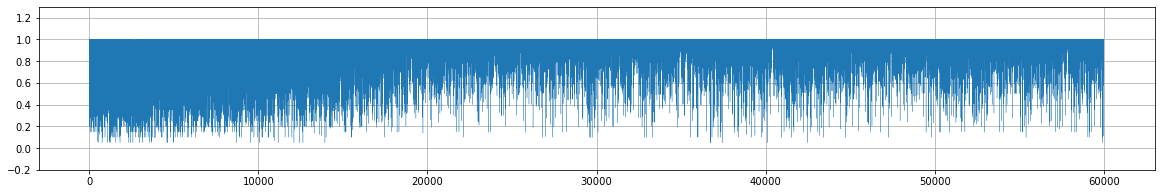

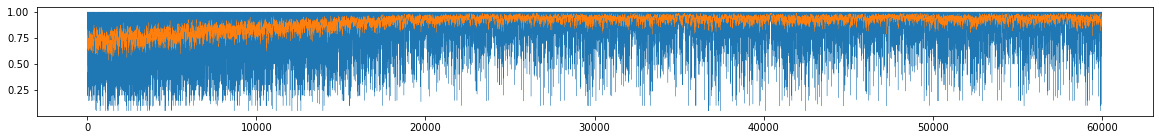

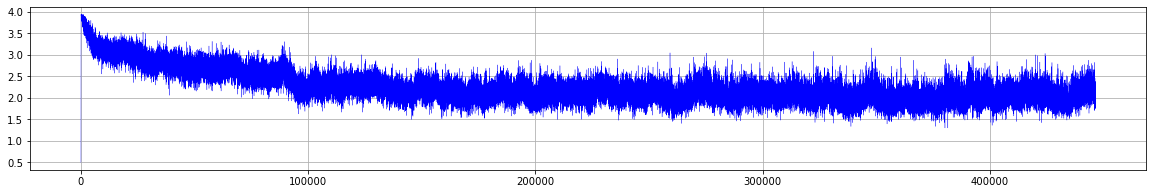

<function matplotlib.pyplot.show(close=None, block=None)>

In [3]:
%matplotlib inline

plt.figure(figsize=(20,3))
plt.plot(h_fill,'-',linewidth=0.3)
plt.ylim(-0.2,1.3)
plt.grid()
plt.show

ts_factor = 0.9
df = pd.DataFrame({'value':h_fill})
smooth = df.ewm(alpha=(1 - ts_factor)).mean()
plt.figure(figsize=(20,2))
plt.plot(df["value"],linewidth=0.3)
plt.plot(smooth["value"],linewidth=0.3)
plt.show

plt.figure(figsize=(20,3))
plt.plot(avg_loss_l,'b-',linewidth=0.3)
plt.grid()
plt.show()
plt.show

0.938266775 0.749711925


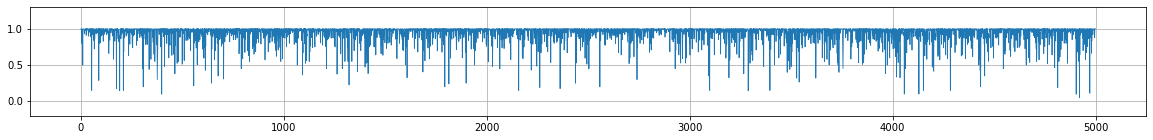

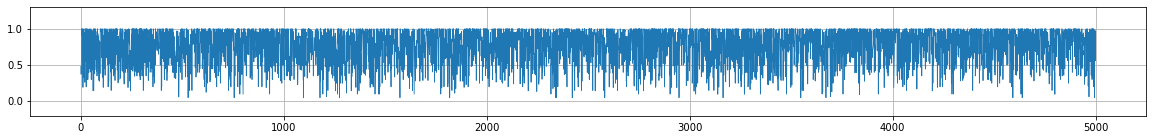

In [4]:
%matplotlib inline

plt.figure(figsize=(20,2))
plt.plot(h_fill[-5000:],'-',linewidth=0.8)
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,2))
plt.plot(h_fill[:5000],'-',linewidth=0.8)
plt.ylim(-0.2,1.3)
plt.grid()
print(np.mean(h_fill[-5000:]), np.mean(h_fill[:5000]))

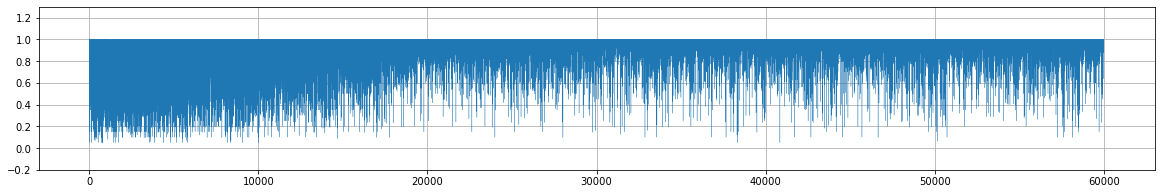

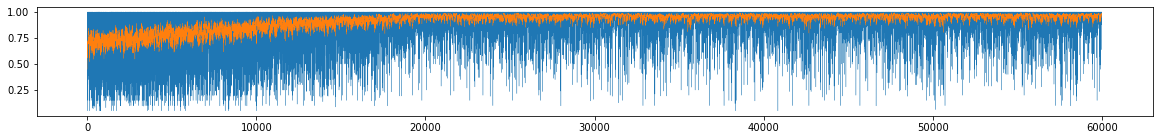

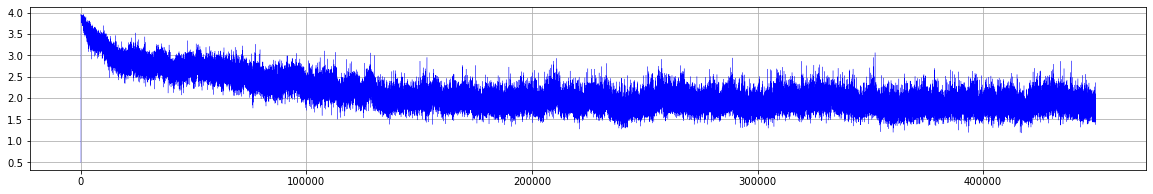

<function matplotlib.pyplot.show(close=None, block=None)>

In [15]:
# agent.model.save_weights("save_model/model_cnn_15_tr3_csrl", save_format="tf")
# np.save("save_model/h_fill_cnn_15_tr3_csrl",h_fill)
# np.save("save_model/avg_loss_l_cnn_15_tr3_csrl",avg_loss_l)

0.9580864499999999 0.747705725


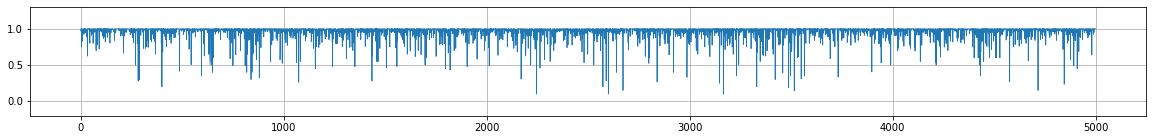

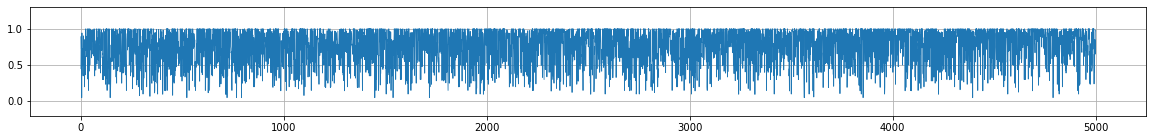

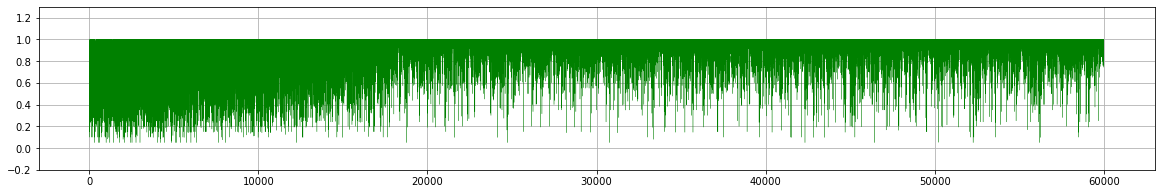

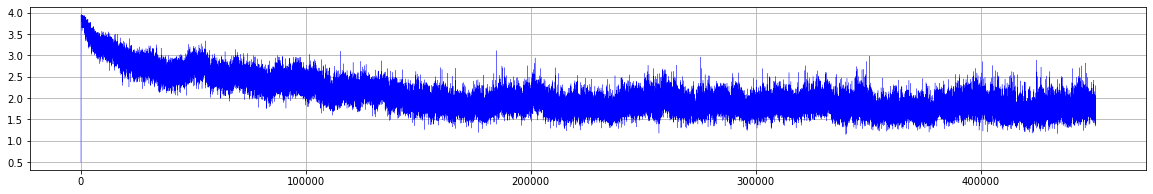

In [26]:
# agent.model.save_weights("save_model/model_15_tr3_csr", save_format="tf")

0.9593993249999999 0.752692925


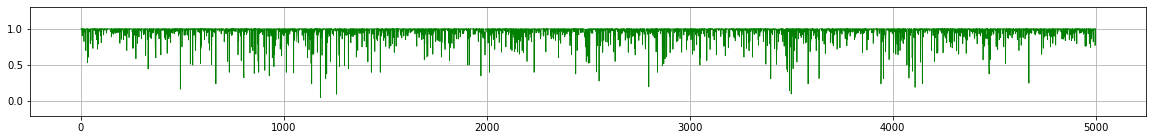

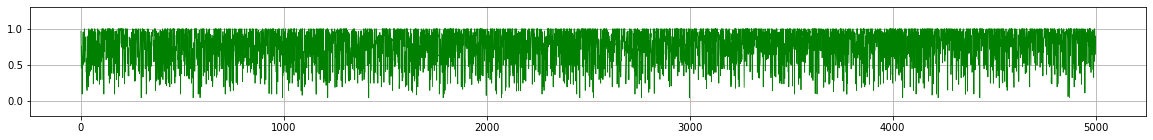

In [11]:
agent.model.save_weights("save_model/model_15_tr3_csr", save_format="tf")

In [ ]:
%matplotlib notebook
# %matplotlib inline
vis_box(used_boxes,pred_pos)

In [ ]:
%matplotlib notebook
# %matplotlib inline
vis_box(np.array(boxes_multi)[0],np.array(gt_pos)[0])